The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j105836m1254'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.3-c1b-04-294.0-F105W 4
CL1059-12.3-c1b-04-294.0-G102 4

 == Grism groups ==

ic1b-294.0-f105w 4 ic1b-294.0-g102 4


ic1b-294.0-f105w                4
ic1b-294.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.3-c1b-04-294.0-F105W 4
CL1059-12.3-c1b-04-294.0-G102 4

 == Grism groups ==

cl1059-12.3-c1b-04-294.0-f105w 4 cl1059-12.3-c1b-04-294.0-g102 4


cl1059-12.3-c1b-04-294.0-f105w  4
cl1059-12.3-c1b-04-294.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1059-12.3-c1b-04-294.0-f105w 4 cl1059-12.3-c1b-04-294.0-g102 4
Skip cl1059-12.3-c1b-04-294.0-f105w
Skip cl1059-12.3-c1b-04-294.0-f105w
Skip cl1059-12.3-c1b-04-294.0-g102
utils.fix_flt_nan: ic1b04o2q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04nvq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04o0q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04o9q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04noq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04o7q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04ntq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b04nlq_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1059-12.3-c1b-04-294.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b04nlq_flt.fits'] = ['ic1b04noq_flt.fits']
# match['ic1b04ntq_flt.fits'] = ['ic1b04nvq_flt.fits']
# match['ic1b04o0q_flt.fits'] = ['ic1b04o2q_flt.fits']
# match['ic1b04o7q_flt.fits'] = ['ic1b04o9q_flt.fits']
ic1b04nlq_flt.fits  -0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b04ntq_flt.fits  -0.065  -0.085  0.00000  1.00000    40  0.052  0.101
ic1b04o0q_flt.fits  -0.054  -0.038  0.00000  1.00000    40  0.054  0.121
ic1b04o7q_flt.fits   0.018   0.009  0.00000  1.00000    39  0.060  0.063


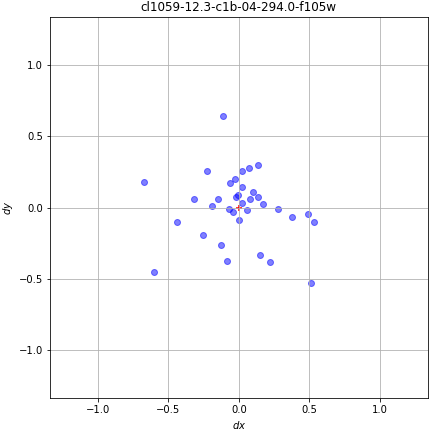

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1059-12.3-c1b-04-294.0-f105w_wcs.png") 


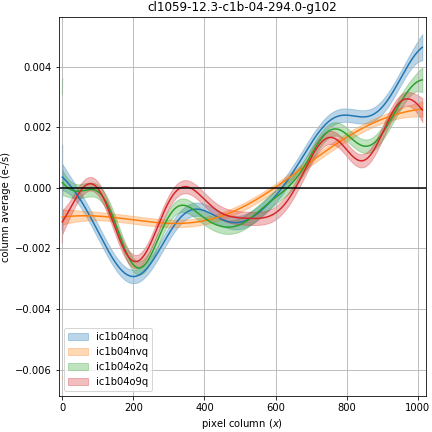

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1059-12.3-c1b-04-294.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 0.4054 1.9075 0.0240 1.00024 0.191 35


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

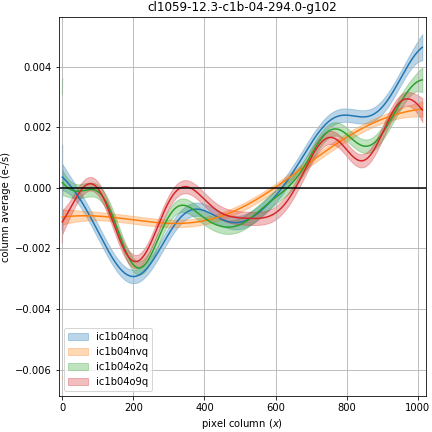

In [18]:
from IPython.display import Image
Image(filename = "./cl1059-12.3-c1b-04-294.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1059-12.3-c1b-04-294.0-f105w        -0.05    0.10


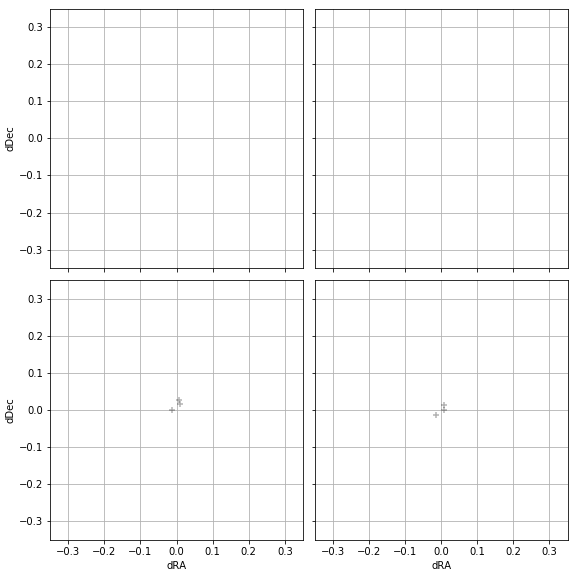

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j105836m1254-f105w_drz_sci.fits
j105836m1254-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j105836m1254-ir.cat.fits
j105836m1254-ir_drz_wht.fits
j105836m1254-ir_drz_sci.fits
j105836m1254-ir_seg.fits
j105836m1254-ir_bkg.fits
j105836m1254_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j105836m1254-ir_drz_sci.fits
WHT_FILE:	j105836m1254-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5211371779441833
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j105836m1254-f105w_drz_sci.fits
F105W_WHT_FILE:	j105836m1254-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5211371779441833
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b04nvq.01.GrismFLT.fits!
Load ic1b04o9q.01.GrismFLT.fits!
Load ic1b04o2q.01.GrismFLT.fits!
Load ic1b04noq.01.GrismFLT.fits!
Files loaded - 1.11 sec.


### The final contamination model ###

IndexError: list index out of range

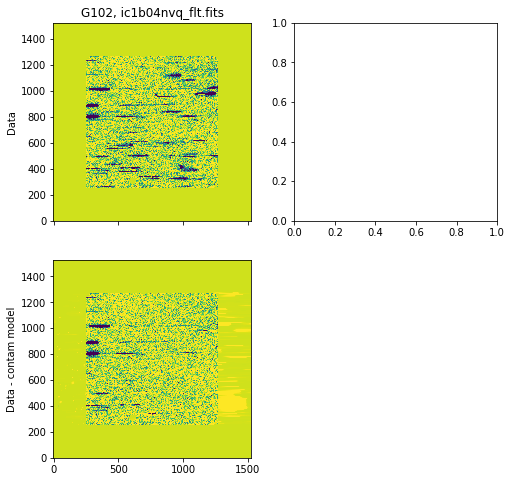

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [27]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j105836m1254/Extractions/d_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [28]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [29]:
# Make PSF file
if not os.path.exists('{0}-f140w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j105836m1254 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j105836m1254 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j105836m1254 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j105836m1254 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j105836m1254 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j105836m1254 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j105836m1254-f105w_psf.fits'] 

Filename: j105836m1254-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


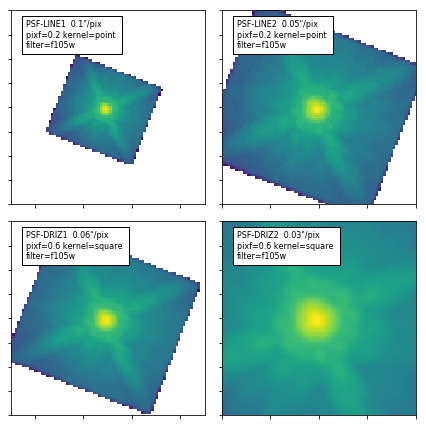

In [30]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [31]:
os.chdir('../Extractions')

In [32]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [34]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/164: 55 0
1/164: 54 0
2/164: 310 4
j105836m1254_00310.beams.fits
3/164: 305 4
j105836m1254_00305.beams.fits
4/164: 202 4
j105836m1254_00202.beams.fits
5/164: 109 4
j105836m1254_00109.beams.fits
6/164: 372 4
j105836m1254_00372.beams.fits
7/164: 244 4
j105836m1254_00244.beams.fits
8/164: 56 4
j105836m1254_00056.beams.fits
9/164: 155 4
j105836m1254_00155.beams.fits
10/164: 262 4
j105836m1254_00262.beams.fits
11/164: 210 4
j105836m1254_00210.beams.fits
12/164: 361 4
j105836m1254_00361.beams.fits
13/164: 211 4
j105836m1254_00211.beams.fits
14/164: 440 4
j105836m1254_00440.beams.fits
15/164: 258 4
j105836m1254_00258.beams.fits
16/164: 264 4
j105836m1254_00264.beams.fits
17/164: 413 4
j105836m1254_00413.beams.fits
18/164: 32 4
j105836m1254_00032.beams.fits
19/164: 124 4
j105836m1254_00124.beams.fits
20/164: 108 4
j105836m1254_00108.beams.fits
21/164: 474 4
j105836m1254_00474.beams.fits
22/164: 297 4
j105836m1254_00297.beams.fits
23/164: 149 4
j105836m1254_00149.beams.fits
24/164: 63 4
j1058

  0.2402 2042399.9 (0.1541) 31/341
  0.2452 2042384.1 (0.1541) 32/341
  0.2502 2042255.8 (0.1541) 33/341
  0.2552 2042040.3 (0.1541) 34/341
  0.2603 2041689.4 (0.1541) 35/341
  0.2653 2041305.6 (0.1541) 36/341
  0.2704 2040952.7 (0.1541) 37/341
  0.2755 2040619.0 (0.1541) 38/341
  0.2806 2040231.4 (0.1541) 39/341
  0.2857 2039879.6 (0.1541) 40/341
  0.2909 2039599.0 (0.1541) 41/341
  0.2960 2039385.2 (0.1541) 42/341
  0.3012 2039202.6 (0.1541) 43/341
  0.3064 2039078.3 (0.1541) 44/341
  0.3117 2038996.5 (0.1541) 45/341
  0.3169 2039081.1 (0.1541) 46/341
  0.3222 2039271.6 (0.1541) 47/341
  0.3275 2039464.6 (0.1541) 48/341
  0.3328 2039643.6 (0.1541) 49/341
  0.3382 2039695.4 (0.1541) 50/341
  0.3435 2039736.8 (0.1541) 51/341
  0.3489 2039700.3 (0.1541) 52/341
  0.3543 2039627.7 (0.1541) 53/341
  0.3598 2039509.5 (0.1541) 54/341
  0.3652 2039399.9 (0.1541) 55/341
  0.3707 2039318.8 (0.1541) 56/341
  0.3762 2039239.8 (0.1541) 57/341
  0.3817 2039182.9 (0.1541) 58/341
  0.3872 2039173.7 (

  1.6414 2034399.7 (1.5685) 220/341
  1.6520 2034564.4 (1.5685) 221/341
  1.6626 2034500.9 (1.5685) 222/341
  1.6733 2034446.7 (1.5685) 223/341
  1.6840 2034707.5 (1.5685) 224/341
  1.6948 2035151.9 (1.5685) 225/341
  1.7056 2035488.9 (1.5685) 226/341
  1.7164 2036099.1 (1.5685) 227/341
  1.7273 2036774.7 (1.5685) 228/341
  1.7382 2037736.2 (1.5685) 229/341
  1.7492 2039166.9 (1.5685) 230/341
  1.7602 2040664.5 (1.5685) 231/341
  1.7713 2041600.1 (1.5685) 232/341
  1.7824 2041940.9 (1.5685) 233/341
  1.7935 2041910.2 (1.5685) 234/341
  1.8047 2042143.7 (1.5685) 235/341
  1.8160 2042859.8 (1.5685) 236/341
  1.8273 2043519.8 (1.5685) 237/341
  1.8386 2044401.0 (1.5685) 238/341
  1.8500 2045632.7 (1.5685) 239/341
  1.8614 2046312.7 (1.5685) 240/341
  1.8729 2046135.6 (1.5685) 241/341
  1.8844 2045189.4 (1.5685) 242/341
  1.8959 2044350.1 (1.5685) 243/341
  1.9075 2044079.5 (1.5685) 244/341
  1.9192 2044293.2 (1.5685) 245/341
  1.9309 2044193.0 (1.5685) 246/341
  1.9426 2043364.0 (1.5685) 

  0.2402   34150.9 (0.1964) 31/341
  0.2452   34184.9 (0.1964) 32/341
  0.2502   34220.0 (0.1964) 33/341
  0.2552   34254.6 (0.1964) 34/341
  0.2603   34272.3 (0.1964) 35/341
  0.2653   34257.3 (0.1964) 36/341
  0.2704   34234.2 (0.1964) 37/341
  0.2755   34217.3 (0.1964) 38/341
  0.2806   34205.2 (0.1964) 39/341
  0.2857   34177.2 (0.1964) 40/341
  0.2909   34120.3 (0.1964) 41/341
  0.2960   33989.8 (0.1964) 42/341
  0.3012   33939.4 (0.1964) 43/341
  0.3064   34001.1 (0.1964) 44/341
  0.3117   34048.8 (0.1964) 45/341
  0.3169   34051.7 (0.1964) 46/341
  0.3222   34159.8 (0.1964) 47/341
  0.3275   34250.7 (0.1964) 48/341
  0.3328   34257.3 (0.1964) 49/341
  0.3382   34254.4 (0.1964) 50/341
  0.3435   34254.4 (0.1964) 51/341
  0.3489   34246.8 (0.1964) 52/341
  0.3543   34239.7 (0.1964) 53/341
  0.3598   34244.1 (0.1964) 54/341
  0.3652   34257.0 (0.1964) 55/341
  0.3707   34295.0 (0.1964) 56/341
  0.3762   34315.6 (0.1964) 57/341
  0.3817   34317.1 (0.1964) 58/341
  0.3872   34293.8 (

  1.6733   34268.4 (0.1964) 223/341
  1.6840   34262.6 (0.1964) 224/341
  1.6948   34267.8 (0.1964) 225/341
  1.7056   34282.7 (0.1964) 226/341
  1.7164   34294.7 (0.1964) 227/341
  1.7273   34307.5 (0.1964) 228/341
  1.7382   34330.3 (0.1964) 229/341
  1.7492   34368.7 (0.1964) 230/341
  1.7602   34416.3 (0.1964) 231/341
  1.7713   34446.2 (0.1964) 232/341
  1.7824   34475.6 (0.1964) 233/341
  1.7935   34514.8 (0.1964) 234/341
  1.8047   34564.3 (0.1964) 235/341
  1.8160   34599.7 (0.1964) 236/341
  1.8273   34615.5 (0.1964) 237/341
  1.8386   34625.7 (0.1964) 238/341
  1.8500   34631.4 (0.1964) 239/341
  1.8614   34627.5 (0.1964) 240/341
  1.8729   34612.9 (0.1964) 241/341
  1.8844   34598.5 (0.1964) 242/341
  1.8959   34578.9 (0.1964) 243/341
  1.9075   34549.5 (0.1964) 244/341
  1.9192   34522.0 (0.1964) 245/341
  1.9309   34491.8 (0.1964) 246/341
  1.9426   34444.7 (0.1964) 247/341
  1.9544   34377.4 (0.1964) 248/341
  1.9663   34324.9 (0.1964) 249/341
  1.9782   34288.2 (0.1964) 

  0.2402  120962.6 (0.2402) 31/341
  0.2452  120825.6 (0.2452) 32/341
  0.2502  120807.5 (0.2502) 33/341
  0.2552  120789.6 (0.2552) 34/341
  0.2603  120788.5 (0.2603) 35/341
  0.2653  120873.8 (0.2603) 36/341
  0.2704  120928.0 (0.2603) 37/341
  0.2755  120983.3 (0.2603) 38/341
  0.2806  121120.1 (0.2603) 39/341
  0.2857  121229.2 (0.2603) 40/341
  0.2909  121234.6 (0.2603) 41/341
  0.2960  121191.3 (0.2603) 42/341
  0.3012  121276.9 (0.2603) 43/341
  0.3064  121378.5 (0.2603) 44/341
  0.3117  121471.8 (0.2603) 45/341
  0.3169  121538.2 (0.2603) 46/341
  0.3222  121556.5 (0.2603) 47/341
  0.3275  121665.0 (0.2603) 48/341
  0.3328  121738.9 (0.2603) 49/341
  0.3382  121766.6 (0.2603) 50/341
  0.3435  121749.9 (0.2603) 51/341
  0.3489  121763.3 (0.2603) 52/341
  0.3543  121785.3 (0.2603) 53/341
  0.3598  121832.8 (0.2603) 54/341
  0.3652  121925.9 (0.2603) 55/341
  0.3707  122049.8 (0.2603) 56/341
  0.3762  122142.4 (0.2603) 57/341
  0.3817  122251.1 (0.2603) 58/341
  0.3872  122372.7 (

  1.6733  130310.5 (0.2603) 223/341
  1.6840  130851.4 (0.2603) 224/341
  1.6948  131757.7 (0.2603) 225/341
  1.7056  132793.7 (0.2603) 226/341
  1.7164  133433.7 (0.2603) 227/341
  1.7273  134215.4 (0.2603) 228/341
  1.7382  134861.0 (0.2603) 229/341
  1.7492  135555.4 (0.2603) 230/341
  1.7602  136120.4 (0.2603) 231/341
  1.7713  136660.3 (0.2603) 232/341
  1.7824  136912.4 (0.2603) 233/341
  1.7935  137026.4 (0.2603) 234/341
  1.8047  136814.8 (0.2603) 235/341
  1.8160  136659.0 (0.2603) 236/341
  1.8273  136199.3 (0.2603) 237/341
  1.8386  135381.9 (0.2603) 238/341
  1.8500  134453.2 (0.2603) 239/341
  1.8614  133533.5 (0.2603) 240/341
  1.8729  132317.5 (0.2603) 241/341
  1.8844  131224.0 (0.2603) 242/341
  1.8959  130100.2 (0.2603) 243/341
  1.9075  129404.1 (0.2603) 244/341
  1.9192  128771.9 (0.2603) 245/341
  1.9309  128166.3 (0.2603) 246/341
  1.9426  127440.1 (0.2603) 247/341
  1.9544  126665.5 (0.2603) 248/341
  1.9663  126108.1 (0.2603) 249/341
  1.9782  125606.1 (0.2603) 

  0.2603   31777.2 (0.2108) 35/341
  0.2653   31722.4 (0.2108) 36/341
  0.2704   31809.5 (0.2108) 37/341
  0.2755   31808.6 (0.2108) 38/341
  0.2806   31815.5 (0.2108) 39/341
  0.2857   31784.8 (0.2108) 40/341
  0.2909   31790.8 (0.2108) 41/341
  0.2960   31775.4 (0.2108) 42/341
  0.3012   31826.6 (0.2108) 43/341
  0.3064   31901.9 (0.2108) 44/341
  0.3117   31972.5 (0.2108) 45/341
  0.3169   32019.9 (0.2108) 46/341
  0.3222   32112.6 (0.2108) 47/341
  0.3275   32185.7 (0.2108) 48/341
  0.3328   32299.7 (0.2108) 49/341
  0.3382   32362.5 (0.2108) 50/341
  0.3435   32398.6 (0.2108) 51/341
  0.3489   32426.6 (0.2108) 52/341
  0.3543   32428.3 (0.2108) 53/341
  0.3598   32447.1 (0.2108) 54/341
  0.3652   32464.6 (0.2108) 55/341
  0.3707   32495.8 (0.2108) 56/341
  0.3762   32521.3 (0.2108) 57/341
  0.3817   32482.7 (0.2108) 58/341
  0.3872   32447.5 (0.2108) 59/341
  0.3928   32389.7 (0.2108) 60/341
  0.3984   32303.4 (0.2108) 61/341
  0.4040   32374.0 (0.2108) 62/341
  0.4096   32397.5 (

  1.6840   42600.6 (0.6476) 224/341
  1.6948   42756.7 (0.6476) 225/341
  1.7056   43129.8 (0.6476) 226/341
  1.7164   43341.9 (0.6476) 227/341
  1.7273   43465.2 (0.6476) 228/341
  1.7382   43818.6 (0.6476) 229/341
  1.7492   44094.2 (0.6476) 230/341
  1.7602   43762.0 (0.6476) 231/341
  1.7713   43632.8 (0.6476) 232/341
  1.7824   43557.4 (0.6476) 233/341
  1.7935   43759.5 (0.6476) 234/341
  1.8047   43889.1 (0.6476) 235/341
  1.8160   43857.3 (0.6476) 236/341
  1.8273   43528.1 (0.6476) 237/341
  1.8386   43187.9 (0.6476) 238/341
  1.8500   42316.8 (0.6476) 239/341
  1.8614   41051.6 (0.6476) 240/341
  1.8729   39913.7 (0.6476) 241/341
  1.8844   39354.1 (0.6476) 242/341
  1.8959   38476.8 (0.6476) 243/341
  1.9075   38221.3 (0.6476) 244/341
  1.9192   37772.5 (0.6476) 245/341
  1.9309   37065.2 (0.6476) 246/341
  1.9426   36845.7 (0.6476) 247/341
  1.9544   36353.7 (0.6476) 248/341
  1.9663   35757.0 (0.6476) 249/341
  1.9782   35456.6 (0.6476) 250/341
  1.9901   35271.0 (0.6476) 

  0.3012   19240.8 (0.2755) 43/341
  0.3064   19276.5 (0.2755) 44/341
  0.3117   19335.7 (0.2755) 45/341
  0.3169   19367.4 (0.2755) 46/341
  0.3222   19398.0 (0.2755) 47/341
  0.3275   19459.3 (0.2755) 48/341
  0.3328   19486.2 (0.2755) 49/341
  0.3382   19469.9 (0.2755) 50/341
  0.3435   19444.5 (0.2755) 51/341
  0.3489   19433.8 (0.2755) 52/341
  0.3543   19446.4 (0.2755) 53/341
  0.3598   19472.9 (0.2755) 54/341
  0.3652   19484.5 (0.2755) 55/341
  0.3707   19478.1 (0.2755) 56/341
  0.3762   19466.7 (0.2755) 57/341
  0.3817   19475.4 (0.2755) 58/341
  0.3872   19508.9 (0.2755) 59/341
  0.3928   19540.0 (0.2755) 60/341
  0.3984   19559.2 (0.2755) 61/341
  0.4040   19571.2 (0.2755) 62/341
  0.4096   19553.8 (0.2755) 63/341
  0.4153   19533.0 (0.2755) 64/341
  0.4209   19519.0 (0.2755) 65/341
  0.4266   19533.7 (0.2755) 66/341
  0.4323   19529.0 (0.2755) 67/341
  0.4381   19475.5 (0.2755) 68/341
  0.4438   19413.5 (0.2755) 69/341
  0.4496   19370.0 (0.2755) 70/341
  0.4554   19332.0 (

  1.8729   25908.5 (0.2755) 241/341
  1.8844   25227.2 (0.2755) 242/341
  1.8959   24743.8 (0.2755) 243/341
  1.9075   24179.0 (0.2755) 244/341
  1.9192   23761.2 (0.2755) 245/341
  1.9309   23085.1 (0.2755) 246/341
  1.9426   22420.2 (0.2755) 247/341
  1.9544   21924.1 (0.2755) 248/341
  1.9663   21455.2 (0.2755) 249/341
  1.9782   20957.0 (0.2755) 250/341
  1.9901   20482.7 (0.2755) 251/341
  2.0021   20119.4 (0.2755) 252/341
  2.0141   19834.6 (0.2755) 253/341
  2.0262   19648.6 (0.2755) 254/341
  2.0383   19474.5 (0.2755) 255/341
  2.0505   19364.5 (0.2755) 256/341
  2.0627   19283.7 (0.2755) 257/341
  2.0750   19270.0 (0.2755) 258/341
  2.0873   19272.8 (0.2755) 259/341
  2.0997   19272.7 (0.2755) 260/341
  2.1121   19299.4 (0.2755) 261/341
  2.1246   19343.9 (0.2755) 262/341
  2.1371   19341.6 (0.2755) 263/341
  2.1497   19320.1 (0.2755) 264/341
  2.1623   19297.1 (0.2755) 265/341
  2.1750   19301.5 (0.2755) 266/341
  2.1877   19304.6 (0.2755) 267/341
  2.2005   19266.0 (0.2755) 

  0.3598   15763.8 (0.2653) 54/341
  0.3652   15793.1 (0.2653) 55/341
  0.3707   15831.1 (0.2653) 56/341
  0.3762   15850.1 (0.2653) 57/341
  0.3817   15855.3 (0.2653) 58/341
  0.3872   15834.6 (0.2653) 59/341
  0.3928   15816.3 (0.2653) 60/341
  0.3984   15814.9 (0.2653) 61/341
  0.4040   15866.1 (0.2653) 62/341
  0.4096   15911.2 (0.2653) 63/341
  0.4153   15957.7 (0.2653) 64/341
  0.4209   15995.6 (0.2653) 65/341
  0.4266   16000.3 (0.2653) 66/341
  0.4323   15973.0 (0.2653) 67/341
  0.4381   15946.8 (0.2653) 68/341
  0.4438   15920.4 (0.2653) 69/341
  0.4496   15933.6 (0.2653) 70/341
  0.4554   15974.4 (0.2653) 71/341
  0.4613   16034.7 (0.2653) 72/341
  0.4671   16034.1 (0.2653) 73/341
  0.4730   16025.6 (0.2653) 74/341
  0.4789   16008.6 (0.2653) 75/341
  0.4848   15964.9 (0.2653) 76/341
  0.4908   15977.1 (0.2653) 77/341
  0.4968   15960.7 (0.2653) 78/341
  0.5028   15913.0 (0.2653) 79/341
  0.5088   15907.1 (0.2653) 80/341
  0.5148   15890.9 (0.2653) 81/341
  0.5209   15878.5 (

  1.9663   18083.4 (0.6876) 249/341
  1.9782   17796.6 (0.6876) 250/341
  1.9901   17782.0 (0.6876) 251/341
  2.0021   17658.6 (0.6876) 252/341
  2.0141   17320.5 (0.6876) 253/341
  2.0262   16871.1 (0.6876) 254/341
  2.0383   16485.4 (0.6876) 255/341
  2.0505   16227.5 (0.6876) 256/341
  2.0627   15974.6 (0.6876) 257/341
  2.0750   15830.3 (0.6876) 258/341
  2.0873   15691.9 (0.6876) 259/341
  2.0997   15607.7 (0.6876) 260/341
  2.1121   15513.0 (0.6876) 261/341
  2.1246   15457.0 (2.1246) 262/341
  2.1371   15452.4 (2.1371) 263/341
  2.1497   15474.4 (2.1371) 264/341
  2.1623   15468.2 (2.1371) 265/341
  2.1750   15464.2 (2.1371) 266/341
  2.1877   15532.3 (2.1371) 267/341
  2.2005   15607.0 (2.1371) 268/341
  2.2133   15645.8 (2.1371) 269/341
  2.2262   15660.4 (2.1371) 270/341
  2.2391   15681.3 (2.1371) 271/341
  2.2521   15722.2 (2.1371) 272/341
  2.2652   15753.3 (2.1371) 273/341
  2.2783   15767.5 (2.1371) 274/341
  2.2914   15773.4 (2.1371) 275/341
  2.3046   15774.9 (2.1371) 

  0.4096    1954.3 (0.2012) 63/341
  0.4153    1949.8 (0.2012) 64/341
  0.4209    1948.9 (0.2012) 65/341
  0.4266    1951.4 (0.2012) 66/341
  0.4323    1949.3 (0.2012) 67/341
  0.4381    1942.2 (0.2012) 68/341
  0.4438    1949.1 (0.2012) 69/341
  0.4496    1956.1 (0.2012) 70/341
  0.4554    1949.0 (0.2012) 71/341
  0.4613    1952.1 (0.2012) 72/341
  0.4671    1950.6 (0.2012) 73/341
  0.4730    1950.4 (0.2012) 74/341
  0.4789    1943.5 (0.2012) 75/341
  0.4848    1925.8 (0.2012) 76/341
  0.4908    1920.4 (0.2012) 77/341
  0.4968    1917.1 (0.2012) 78/341
  0.5028    1900.5 (0.2012) 79/341
  0.5088    1887.5 (0.2012) 80/341
  0.5148    1905.1 (0.2012) 81/341
  0.5209    1917.5 (0.2012) 82/341
  0.5270    1918.6 (0.2012) 83/341
  0.5331    1913.7 (0.2012) 84/341
  0.5393    1917.6 (0.2012) 85/341
  0.5454    1913.2 (0.2012) 86/341
  0.5516    1920.1 (0.2012) 87/341
  0.5579    1917.7 (0.2012) 88/341
  0.5641    1907.7 (0.2012) 89/341
  0.5704    1906.1 (0.2012) 90/341
  0.5767    1911.0 (

  2.0383    1816.9 (0.2012) 255/341
  2.0505    1825.1 (0.2012) 256/341
  2.0627    1800.6 (2.0627) 257/341
  2.0750    1790.9 (2.0750) 258/341
  2.0873    1808.4 (2.0750) 259/341
  2.0997    1810.3 (2.0750) 260/341
  2.1121    1821.2 (2.0750) 261/341
  2.1246    1868.8 (2.0750) 262/341
  2.1371    1912.8 (2.0750) 263/341
  2.1497    1938.5 (2.0750) 264/341
  2.1623    1943.9 (2.0750) 265/341
  2.1750    1953.3 (2.0750) 266/341
  2.1877    1990.6 (2.0750) 267/341
  2.2005    2004.4 (2.0750) 268/341
  2.2133    1994.5 (2.0750) 269/341
  2.2262    2002.7 (2.0750) 270/341
  2.2391    2007.3 (2.0750) 271/341
  2.2521    2003.1 (2.0750) 272/341
  2.2652    2000.6 (2.0750) 273/341
  2.2783    1987.9 (2.0750) 274/341
  2.2914    1972.6 (2.0750) 275/341
  2.3046    1953.8 (2.0750) 276/341
  2.3178    1933.2 (2.0750) 277/341
  2.3311    1922.4 (2.0750) 278/341
  2.3445    1914.1 (2.0750) 279/341
  2.3579    1899.6 (2.0750) 280/341
  2.3713    1856.3 (2.0750) 281/341
  2.3849    1830.4 (2.0750) 

  0.4848   12047.4 (0.2502) 76/341
  0.4908   12020.4 (0.2502) 77/341
  0.4968   11977.4 (0.2502) 78/341
  0.5028   11972.7 (0.2502) 79/341
  0.5088   11965.0 (0.2502) 80/341
  0.5148   11961.0 (0.2502) 81/341
  0.5209   11953.6 (0.2502) 82/341
  0.5270   11964.6 (0.2502) 83/341
  0.5331   11951.8 (0.2502) 84/341
  0.5393   11941.9 (0.2502) 85/341
  0.5454   11935.3 (0.2502) 86/341
  0.5516   11940.5 (0.2502) 87/341
  0.5579   11942.2 (0.2502) 88/341
  0.5641   11934.6 (0.2502) 89/341
  0.5704   11933.0 (0.2502) 90/341
  0.5767   11957.9 (0.2502) 91/341
  0.5830   11947.5 (0.2502) 92/341
  0.5893   11949.3 (0.2502) 93/341
  0.5957   11951.0 (0.2502) 94/341
  0.6021   11953.2 (0.2502) 95/341
  0.6085   11917.8 (0.2502) 96/341
  0.6150   11886.3 (0.2502) 97/341
  0.6214   11858.1 (0.2502) 98/341
  0.6279   11856.5 (0.2502) 99/341
  0.6345   11865.7 (0.2502) 100/341
  0.6410   11836.8 (0.2502) 101/341
  0.6476   11832.6 (0.2502) 102/341
  0.6542   11838.8 (0.2502) 103/341
  0.6608   11863

  2.1371   11856.8 (0.2502) 263/341
  2.1497   11891.3 (0.2502) 264/341
  2.1623   11913.0 (0.2502) 265/341
  2.1750   11922.9 (0.2502) 266/341
  2.1877   11934.1 (0.2502) 267/341
  2.2005   11973.6 (0.2502) 268/341
  2.2133   12008.7 (0.2502) 269/341
  2.2262   12013.9 (0.2502) 270/341
  2.2391   12018.2 (0.2502) 271/341
  2.2521   12046.8 (0.2502) 272/341
  2.2652   12079.4 (0.2502) 273/341
  2.2783   12085.8 (0.2502) 274/341
  2.2914   12069.5 (0.2502) 275/341
  2.3046   12056.2 (0.2502) 276/341
  2.3178   12049.6 (0.2502) 277/341
  2.3311   12037.5 (0.2502) 278/341
  2.3445   12031.1 (0.2502) 279/341
  2.3579   12023.3 (0.2502) 280/341
  2.3713   12015.6 (0.2502) 281/341
  2.3849   12007.6 (0.2502) 282/341
  2.3984   11990.7 (0.2502) 283/341
  2.4120   11969.9 (0.2502) 284/341
  2.4257   11960.8 (0.2502) 285/341
  2.4394   11977.3 (0.2502) 286/341
  2.4532   11987.6 (0.2502) 287/341
  2.4671   11980.3 (0.2502) 288/341
  2.4810   11984.6 (0.2502) 289/341
  2.4949   12004.5 (0.2502) 

  0.2909   11020.5 (0.2909) 41/341
  0.2960   11019.5 (0.2960) 42/341
  0.3012   11034.0 (0.2960) 43/341
  0.3064   11064.8 (0.2960) 44/341
  0.3117   11084.6 (0.2960) 45/341
  0.3169   11070.5 (0.2960) 46/341
  0.3222   11034.4 (0.2960) 47/341
  0.3275   11030.3 (0.2960) 48/341
  0.3328   11070.9 (0.2960) 49/341
  0.3382   11099.0 (0.2960) 50/341
  0.3435   11113.4 (0.2960) 51/341
  0.3489   11105.8 (0.2960) 52/341
  0.3543   11092.4 (0.2960) 53/341
  0.3598   11080.2 (0.2960) 54/341
  0.3652   11069.7 (0.2960) 55/341
  0.3707   11057.2 (0.2960) 56/341
  0.3762   11047.3 (0.2960) 57/341
  0.3817   11043.5 (0.2960) 58/341
  0.3872   11045.1 (0.2960) 59/341
  0.3928   11049.7 (0.2960) 60/341
  0.3984   11056.6 (0.2960) 61/341
  0.4040   11067.1 (0.2960) 62/341
  0.4096   11072.9 (0.2960) 63/341
  0.4153   11079.2 (0.2960) 64/341
  0.4209   11080.3 (0.2960) 65/341
  0.4266   11074.6 (0.2960) 66/341
  0.4323   11071.5 (0.2960) 67/341
  0.4381   11071.9 (0.2960) 68/341
  0.4438   11069.6 (

  1.7602   12146.0 (0.7355) 231/341
  1.7713   12185.9 (0.7355) 232/341
  1.7824   12167.1 (0.7355) 233/341
  1.7935   12108.2 (0.7355) 234/341
  1.8047   12075.9 (0.7355) 235/341
  1.8160   12060.1 (0.7355) 236/341
  1.8273   12042.4 (0.7355) 237/341
  1.8386   12033.6 (0.7355) 238/341
  1.8500   11989.9 (0.7355) 239/341
  1.8614   11957.3 (0.7355) 240/341
  1.8729   11897.2 (0.7355) 241/341
  1.8844   11819.1 (0.7355) 242/341
  1.8959   11756.3 (0.7355) 243/341
  1.9075   11682.9 (0.7355) 244/341
  1.9192   11617.1 (0.7355) 245/341
  1.9309   11566.1 (0.7355) 246/341
  1.9426   11469.6 (0.7355) 247/341
  1.9544   11409.2 (0.7355) 248/341
  1.9663   11392.0 (0.7355) 249/341
  1.9782   11346.1 (0.7355) 250/341
  1.9901   11276.2 (0.7355) 251/341
  2.0021   11257.7 (0.7355) 252/341
  2.0141   11238.7 (0.7355) 253/341
  2.0262   11246.4 (0.7355) 254/341
  2.0383   11231.4 (0.7355) 255/341
  2.0505   11200.3 (0.7355) 256/341
  2.0627   11176.8 (0.7355) 257/341
  2.0750   11157.7 (0.7355) 

  0.2806    8150.3 (0.1044) 39/341
  0.2857    8146.9 (0.1044) 40/341
  0.2909    8133.7 (0.1044) 41/341
  0.2960    8127.3 (0.1044) 42/341
  0.3012    8115.9 (0.1044) 43/341
  0.3064    8109.3 (0.3064) 44/341
  0.3117    8118.2 (0.3064) 45/341
  0.3169    8121.9 (0.3064) 46/341
  0.3222    8120.2 (0.3064) 47/341
  0.3275    8128.3 (0.3064) 48/341
  0.3328    8142.4 (0.3064) 49/341
  0.3382    8149.1 (0.3064) 50/341
  0.3435    8156.0 (0.3064) 51/341
  0.3489    8169.3 (0.3064) 52/341
  0.3543    8178.8 (0.3064) 53/341
  0.3598    8184.2 (0.3064) 54/341
  0.3652    8190.2 (0.3064) 55/341
  0.3707    8182.8 (0.3064) 56/341
  0.3762    8175.5 (0.3064) 57/341
  0.3817    8173.6 (0.3064) 58/341
  0.3872    8179.6 (0.3064) 59/341
  0.3928    8187.7 (0.3064) 60/341
  0.3984    8192.9 (0.3064) 61/341
  0.4040    8203.7 (0.3064) 62/341
  0.4096    8210.3 (0.3064) 63/341
  0.4153    8210.0 (0.3064) 64/341
  0.4209    8210.0 (0.3064) 65/341
  0.4266    8212.9 (0.3064) 66/341
  0.4323    8219.4 (

  1.7273    9170.8 (0.8064) 228/341
  1.7382    9232.7 (0.8064) 229/341
  1.7492    9329.1 (0.8064) 230/341
  1.7602    9382.9 (0.8064) 231/341
  1.7713    9454.5 (0.8064) 232/341
  1.7824    9494.8 (0.8064) 233/341
  1.7935    9524.7 (0.8064) 234/341
  1.8047    9512.7 (0.8064) 235/341
  1.8160    9531.0 (0.8064) 236/341
  1.8273    9524.4 (0.8064) 237/341
  1.8386    9450.9 (0.8064) 238/341
  1.8500    9334.4 (0.8064) 239/341
  1.8614    9276.3 (0.8064) 240/341
  1.8729    9193.4 (0.8064) 241/341
  1.8844    9161.2 (0.8064) 242/341
  1.8959    9108.2 (0.8064) 243/341
  1.9075    8980.0 (0.8064) 244/341
  1.9192    8908.3 (0.8064) 245/341
  1.9309    8840.3 (0.8064) 246/341
  1.9426    8758.2 (0.8064) 247/341
  1.9544    8683.0 (0.8064) 248/341
  1.9663    8650.7 (0.8064) 249/341
  1.9782    8597.5 (0.8064) 250/341
  1.9901    8592.3 (0.8064) 251/341
  2.0021    8531.7 (0.8064) 252/341
  2.0141    8446.4 (0.8064) 253/341
  2.0262    8368.6 (0.8064) 254/341
  2.0383    8308.9 (0.8064) 

  0.3222    7903.6 (0.2960) 47/341
  0.3275    7922.9 (0.2960) 48/341
  0.3328    7936.7 (0.2960) 49/341
  0.3382    7935.0 (0.2960) 50/341
  0.3435    7941.6 (0.2960) 51/341
  0.3489    7931.9 (0.2960) 52/341
  0.3543    7931.3 (0.2960) 53/341
  0.3598    7939.0 (0.2960) 54/341
  0.3652    7939.5 (0.2960) 55/341
  0.3707    7949.6 (0.2960) 56/341
  0.3762    7964.1 (0.2960) 57/341
  0.3817    7977.1 (0.2960) 58/341
  0.3872    7979.0 (0.2960) 59/341
  0.3928    7991.4 (0.2960) 60/341
  0.3984    7991.4 (0.2960) 61/341
  0.4040    7988.7 (0.2960) 62/341
  0.4096    7988.4 (0.2960) 63/341
  0.4153    8002.2 (0.2960) 64/341
  0.4209    8014.3 (0.2960) 65/341
  0.4266    8019.9 (0.2960) 66/341
  0.4323    8017.8 (0.2960) 67/341
  0.4381    8002.2 (0.2960) 68/341
  0.4438    7983.3 (0.2960) 69/341
  0.4496    7972.0 (0.2960) 70/341
  0.4554    7955.1 (0.2960) 71/341
  0.4613    7953.1 (0.2960) 72/341
  0.4671    7959.3 (0.2960) 73/341
  0.4730    7954.7 (0.2960) 74/341
  0.4789    7950.2 (

  1.8729   11538.6 (0.2960) 241/341
  1.8844   11311.8 (0.2960) 242/341
  1.8959   11053.4 (0.2960) 243/341
  1.9075   10711.1 (0.2960) 244/341
  1.9192   10432.6 (0.2960) 245/341
  1.9309   10187.0 (0.2960) 246/341
  1.9426    9899.6 (0.2960) 247/341
  1.9544    9485.9 (0.2960) 248/341
  1.9663    9228.9 (0.2960) 249/341
  1.9782    8955.9 (0.2960) 250/341
  1.9901    8674.4 (0.2960) 251/341
  2.0021    8487.3 (0.2960) 252/341
  2.0141    8310.8 (0.2960) 253/341
  2.0262    8179.6 (0.2960) 254/341
  2.0383    8065.4 (0.2960) 255/341
  2.0505    8012.5 (0.2960) 256/341
  2.0627    7961.6 (0.2960) 257/341
  2.0750    7934.0 (0.2960) 258/341
  2.0873    7934.7 (0.2960) 259/341
  2.0997    7927.7 (0.2960) 260/341
  2.1121    7902.9 (0.2960) 261/341
  2.1246    7930.1 (0.2960) 262/341
  2.1371    7950.9 (0.2960) 263/341
  2.1497    7951.1 (0.2960) 264/341
  2.1623    7929.4 (0.2960) 265/341
  2.1750    7922.5 (0.2960) 266/341
  2.1877    7924.9 (0.2960) 267/341
  2.2005    7917.7 (0.2960) 

  0.3543    5590.4 (0.2452) 53/341
  0.3598    5609.3 (0.2452) 54/341
  0.3652    5620.8 (0.2452) 55/341
  0.3707    5623.7 (0.2452) 56/341
  0.3762    5626.4 (0.2452) 57/341
  0.3817    5631.1 (0.2452) 58/341
  0.3872    5625.4 (0.2452) 59/341
  0.3928    5605.6 (0.2452) 60/341
  0.3984    5596.1 (0.2452) 61/341
  0.4040    5589.7 (0.2452) 62/341
  0.4096    5573.8 (0.2452) 63/341
  0.4153    5575.7 (0.2452) 64/341
  0.4209    5581.9 (0.2452) 65/341
  0.4266    5574.5 (0.2452) 66/341
  0.4323    5549.8 (0.2452) 67/341
  0.4381    5520.8 (0.2452) 68/341
  0.4438    5500.3 (0.2452) 69/341
  0.4496    5488.0 (0.2452) 70/341
  0.4554    5499.7 (0.2452) 71/341
  0.4613    5512.6 (0.2452) 72/341
  0.4671    5504.0 (0.2452) 73/341
  0.4730    5487.9 (0.2452) 74/341
  0.4789    5482.5 (0.2452) 75/341
  0.4848    5471.6 (0.2452) 76/341
  0.4908    5472.0 (0.2452) 77/341
  0.4968    5481.9 (0.2452) 78/341
  0.5028    5487.0 (0.2452) 79/341
  0.5088    5482.3 (0.2452) 80/341
  0.5148    5491.6 (

  1.8844    6100.7 (1.0530) 242/341
  1.8959    6007.2 (1.0530) 243/341
  1.9075    5920.3 (1.0530) 244/341
  1.9192    5886.9 (1.0530) 245/341
  1.9309    5842.9 (1.0530) 246/341
  1.9426    5787.8 (1.0530) 247/341
  1.9544    5733.9 (1.0530) 248/341
  1.9663    5704.1 (1.0530) 249/341
  1.9782    5666.1 (1.0530) 250/341
  1.9901    5657.5 (1.0530) 251/341
  2.0021    5645.6 (1.0530) 252/341
  2.0141    5606.6 (1.0530) 253/341
  2.0262    5594.5 (1.0530) 254/341
  2.0383    5562.1 (1.0530) 255/341
  2.0505    5521.4 (1.0530) 256/341
  2.0627    5496.3 (1.0530) 257/341
  2.0750    5462.8 (1.0530) 258/341
  2.0873    5430.2 (1.0530) 259/341
  2.0997    5409.2 (1.0530) 260/341
  2.1121    5402.0 (1.0530) 261/341
  2.1246    5402.2 (1.0530) 262/341
  2.1371    5396.7 (1.0530) 263/341
  2.1497    5406.8 (1.0530) 264/341
  2.1623    5425.2 (1.0530) 265/341
  2.1750    5431.8 (1.0530) 266/341
  2.1877    5436.9 (1.0530) 267/341
  2.2005    5444.6 (1.0530) 268/341
  2.2133    5452.2 (1.0530) 

  0.3598   21724.7 (0.2960) 54/341
  0.3652   21727.0 (0.2960) 55/341
  0.3707   21727.1 (0.2960) 56/341
  0.3762   21726.4 (0.2960) 57/341
  0.3817   21724.5 (0.2960) 58/341
  0.3872   21721.8 (0.2960) 59/341
  0.3928   21719.3 (0.2960) 60/341
  0.3984   21722.1 (0.2960) 61/341
  0.4040   21727.1 (0.2960) 62/341
  0.4096   21732.9 (0.2960) 63/341
  0.4153   21738.5 (0.2960) 64/341
  0.4209   21743.5 (0.2960) 65/341
  0.4266   21746.1 (0.2960) 66/341
  0.4323   21745.9 (0.2960) 67/341
  0.4381   21744.6 (0.2960) 68/341
  0.4438   21743.2 (0.2960) 69/341
  0.4496   21742.9 (0.2960) 70/341
  0.4554   21744.3 (0.2960) 71/341
  0.4613   21744.6 (0.2960) 72/341
  0.4671   21741.3 (0.2960) 73/341
  0.4730   21733.6 (0.2960) 74/341
  0.4789   21723.3 (0.2960) 75/341
  0.4848   21715.6 (0.2960) 76/341
  0.4908   21710.7 (0.2960) 77/341
  0.4968   21709.1 (0.2960) 78/341
  0.5028   21711.3 (0.2960) 79/341
  0.5088   21712.5 (0.2960) 80/341
  0.5148   21712.6 (0.2960) 81/341
  0.5209   21709.7 (

  1.8844   22696.6 (0.2960) 242/341
  1.8959   22618.2 (0.2960) 243/341
  1.9075   22535.1 (0.2960) 244/341
  1.9192   22449.1 (0.2960) 245/341
  1.9309   22358.5 (0.2960) 246/341
  1.9426   22293.3 (0.2960) 247/341
  1.9544   22220.7 (0.2960) 248/341
  1.9663   22146.3 (0.2960) 249/341
  1.9782   22093.3 (0.2960) 250/341
  1.9901   22060.8 (0.2960) 251/341
  2.0021   22028.8 (0.2960) 252/341
  2.0141   21960.9 (0.2960) 253/341
  2.0262   21885.2 (0.2960) 254/341
  2.0383   21824.6 (0.2960) 255/341
  2.0505   21781.0 (0.2960) 256/341
  2.0627   21750.1 (0.2960) 257/341
  2.0750   21729.8 (0.2960) 258/341
  2.0873   21718.0 (0.2960) 259/341
  2.0997   21712.6 (0.2960) 260/341
  2.1121   21709.9 (0.2960) 261/341
  2.1246   21707.9 (0.2960) 262/341
  2.1371   21703.9 (0.2960) 263/341
  2.1497   21697.8 (0.2960) 264/341
  2.1623   21690.5 (0.2960) 265/341
  2.1750   21683.0 (0.2960) 266/341
  2.1877   21676.3 (0.2960) 267/341
  2.2005   21671.2 (0.2960) 268/341
  2.2133   21668.9 (0.2960) 

  0.3872    5907.6 (0.3064) 59/341
  0.3928    5898.5 (0.3064) 60/341
  0.3984    5893.6 (0.3064) 61/341
  0.4040    5895.6 (0.3064) 62/341
  0.4096    5899.7 (0.3064) 63/341
  0.4153    5900.6 (0.3064) 64/341
  0.4209    5908.6 (0.3064) 65/341
  0.4266    5922.2 (0.3064) 66/341
  0.4323    5918.9 (0.3064) 67/341
  0.4381    5917.4 (0.3064) 68/341
  0.4438    5912.0 (0.3064) 69/341
  0.4496    5907.3 (0.3064) 70/341
  0.4554    5900.2 (0.3064) 71/341
  0.4613    5898.3 (0.3064) 72/341
  0.4671    5890.9 (0.3064) 73/341
  0.4730    5900.6 (0.3064) 74/341
  0.4789    5904.2 (0.3064) 75/341
  0.4848    5899.1 (0.3064) 76/341
  0.4908    5891.4 (0.3064) 77/341
  0.4968    5880.7 (0.3064) 78/341
  0.5028    5878.4 (0.3064) 79/341
  0.5088    5862.6 (0.5088) 80/341
  0.5148    5859.0 (0.5148) 81/341
  0.5209    5850.4 (0.5209) 82/341
  0.5270    5850.5 (0.5209) 83/341
  0.5331    5852.4 (0.5209) 84/341
  0.5393    5857.7 (0.5209) 85/341
  0.5454    5860.2 (0.5209) 86/341
  0.5516    5862.2 (

  2.0141    6071.9 (0.5704) 253/341
  2.0262    5972.6 (0.5704) 254/341
  2.0383    5877.2 (0.5704) 255/341
  2.0505    5840.8 (0.5704) 256/341
  2.0627    5824.3 (2.0627) 257/341
  2.0750    5816.8 (2.0750) 258/341
  2.0873    5803.9 (2.0873) 259/341
  2.0997    5814.9 (2.0873) 260/341
  2.1121    5811.8 (2.0873) 261/341
  2.1246    5820.1 (2.0873) 262/341
  2.1371    5838.0 (2.0873) 263/341
  2.1497    5848.3 (2.0873) 264/341
  2.1623    5868.9 (2.0873) 265/341
  2.1750    5878.9 (2.0873) 266/341
  2.1877    5879.1 (2.0873) 267/341
  2.2005    5882.2 (2.0873) 268/341
  2.2133    5889.6 (2.0873) 269/341
  2.2262    5886.7 (2.0873) 270/341
  2.2391    5878.1 (2.0873) 271/341
  2.2521    5878.6 (2.0873) 272/341
  2.2652    5891.5 (2.0873) 273/341
  2.2783    5893.7 (2.0873) 274/341
  2.2914    5889.5 (2.0873) 275/341
  2.3046    5891.6 (2.0873) 276/341
  2.3178    5897.5 (2.0873) 277/341
  2.3311    5904.1 (2.0873) 278/341
  2.3445    5895.4 (2.0873) 279/341
  2.3579    5891.0 (2.0873) 

  0.4438    7991.5 (0.2502) 69/341
  0.4496    7983.1 (0.2502) 70/341
  0.4554    7972.5 (0.2502) 71/341
  0.4613    7949.8 (0.2502) 72/341
  0.4671    7941.2 (0.2502) 73/341
  0.4730    7951.9 (0.2502) 74/341
  0.4789    7953.5 (0.2502) 75/341
  0.4848    7955.5 (0.2502) 76/341
  0.4908    7958.2 (0.2502) 77/341
  0.4968    7960.2 (0.2502) 78/341
  0.5028    7967.6 (0.2502) 79/341
  0.5088    7972.2 (0.2502) 80/341
  0.5148    7976.5 (0.2502) 81/341
  0.5209    7982.1 (0.2502) 82/341
  0.5270    7988.1 (0.2502) 83/341
  0.5331    7984.2 (0.2502) 84/341
  0.5393    7977.6 (0.2502) 85/341
  0.5454    7967.2 (0.2502) 86/341
  0.5516    7957.9 (0.2502) 87/341
  0.5579    7958.9 (0.2502) 88/341
  0.5641    7947.4 (0.2502) 89/341
  0.5704    7934.6 (0.2502) 90/341
  0.5767    7917.4 (0.2502) 91/341
  0.5830    7903.0 (0.5830) 92/341
  0.5893    7898.8 (0.5893) 93/341
  0.5957    7904.6 (0.5893) 94/341
  0.6021    7906.9 (0.5893) 95/341
  0.6085    7907.1 (0.5893) 96/341
  0.6150    7901.3 (

  2.1623    7891.3 (1.0612) 265/341
  2.1750    7900.2 (1.0612) 266/341
  2.1877    7912.5 (1.0612) 267/341
  2.2005    7921.4 (1.0612) 268/341
  2.2133    7928.4 (1.0612) 269/341
  2.2262    7932.7 (1.0612) 270/341
  2.2391    7938.0 (1.0612) 271/341
  2.2521    7941.1 (1.0612) 272/341
  2.2652    7937.3 (1.0612) 273/341
  2.2783    7932.5 (1.0612) 274/341
  2.2914    7931.7 (1.0612) 275/341
  2.3046    7934.5 (1.0612) 276/341
  2.3178    7933.6 (1.0612) 277/341
  2.3311    7928.9 (1.0612) 278/341
  2.3445    7929.1 (1.0612) 279/341
  2.3579    7933.9 (1.0612) 280/341
  2.3713    7936.3 (1.0612) 281/341
  2.3849    7933.5 (1.0612) 282/341
  2.3984    7933.7 (1.0612) 283/341
  2.4120    7939.0 (1.0612) 284/341
  2.4257    7943.1 (1.0612) 285/341
  2.4394    7945.3 (1.0612) 286/341
  2.4532    7943.7 (1.0612) 287/341
  2.4671    7941.9 (1.0612) 288/341
  2.4810    7938.5 (1.0612) 289/341
  2.4949    7934.2 (1.0612) 290/341
  2.5089    7930.4 (1.0612) 291/341
  2.5230    7927.8 (1.0612) 

  0.5028    6479.2 (0.1222) 79/341
  0.5088    6474.0 (0.1222) 80/341
  0.5148    6465.5 (0.1222) 81/341
  0.5209    6463.9 (0.1222) 82/341
  0.5270    6464.3 (0.1222) 83/341
  0.5331    6458.1 (0.1222) 84/341
  0.5393    6457.4 (0.1222) 85/341
  0.5454    6461.2 (0.1222) 86/341
  0.5516    6462.7 (0.1222) 87/341
  0.5579    6469.7 (0.1222) 88/341
  0.5641    6472.5 (0.1222) 89/341
  0.5704    6474.3 (0.1222) 90/341
  0.5767    6480.8 (0.1222) 91/341
  0.5830    6480.1 (0.1222) 92/341
  0.5893    6474.4 (0.1222) 93/341
  0.5957    6469.8 (0.1222) 94/341
  0.6021    6463.8 (0.1222) 95/341
  0.6085    6459.4 (0.1222) 96/341
  0.6150    6450.6 (0.6150) 97/341
  0.6214    6452.1 (0.6150) 98/341
  0.6279    6456.8 (0.6150) 99/341
  0.6345    6457.9 (0.6150) 100/341
  0.6410    6459.6 (0.6150) 101/341
  0.6476    6464.3 (0.6150) 102/341
  0.6542    6460.0 (0.6150) 103/341
  0.6608    6449.4 (0.6608) 104/341
  0.6675    6444.5 (0.6675) 105/341
  0.6742    6449.3 (0.6675) 106/341
  0.6809    6

  2.1877    6458.3 (0.6675) 267/341
  2.2005    6460.6 (0.6675) 268/341
  2.2133    6459.2 (0.6675) 269/341
  2.2262    6458.1 (0.6675) 270/341
  2.2391    6456.9 (0.6675) 271/341
  2.2521    6457.2 (0.6675) 272/341
  2.2652    6459.1 (0.6675) 273/341
  2.2783    6460.5 (0.6675) 274/341
  2.2914    6461.5 (0.6675) 275/341
  2.3046    6463.7 (0.6675) 276/341
  2.3178    6466.3 (0.6675) 277/341
  2.3311    6465.9 (0.6675) 278/341
  2.3445    6464.5 (0.6675) 279/341
  2.3579    6462.0 (0.6675) 280/341
  2.3713    6458.6 (0.6675) 281/341
  2.3849    6455.8 (0.6675) 282/341
  2.3984    6453.4 (0.6675) 283/341
  2.4120    6453.0 (0.6675) 284/341
  2.4257    6453.1 (0.6675) 285/341
  2.4394    6455.1 (0.6675) 286/341
  2.4532    6459.8 (0.6675) 287/341
  2.4671    6463.5 (0.6675) 288/341
  2.4810    6467.1 (0.6675) 289/341
  2.4949    6469.6 (0.6675) 290/341
  2.5089    6472.9 (0.6675) 291/341
  2.5230    6476.4 (0.6675) 292/341
  2.5371    6477.3 (0.6675) 293/341
  2.5513    6479.3 (0.6675) 

- 2.7141    6453.7 (0.6685) 120/132
- 2.7146    6453.7 (0.6685) 121/132
- 2.7151    6453.7 (0.6685) 122/132
- 2.7156    6453.7 (0.6685) 123/132
- 2.7161    6453.8 (0.6685) 124/132
- 2.7166    6453.8 (0.6685) 125/132
- 2.7171    6453.9 (0.6685) 126/132
- 2.7176    6454.0 (0.6685) 127/132
- 2.7181    6454.1 (0.6685) 128/132
- 2.7186    6454.2 (0.6685) 129/132
- 2.7191    6454.4 (0.6685) 130/132
- 2.7196    6454.5 (0.6685) 131/132
- 2.7201    6454.7 (0.6685) 132/132
Drizzle line -> SII  (0.32 1.43)
Get linemap PSF: F105W
18/164: 32
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    9453.6 (0.1000) 1/341
  0.1044    9452.7 (0.1044) 2/341
  0.1088    9450.6 (0.1088) 3/341
  0.1133    9447.2 (0.1133) 4/341
  0.1177    9443.4 (0.1177) 5/341
  0.1222    9440.1 (0.1222) 6/341
  0.1267    9437.1 (0.1267) 7/341
  0.1312    9435.0 (0.1312) 8/341
  0.1358    9433.0 (0.1358) 9/341
  0.1403    9431.4 (0.1403) 10/3

  1.2509    9425.8 (0.8576) 180/341
  1.2599    9423.3 (0.8576) 181/341
  1.2689    9420.1 (0.8576) 182/341
  1.2780    9416.6 (0.8576) 183/341
  1.2872    9416.1 (0.8576) 184/341
  1.2963    9420.5 (0.8576) 185/341
  1.3055    9428.7 (0.8576) 186/341
  1.3148    9441.3 (0.8576) 187/341
  1.3240    9456.5 (0.8576) 188/341
  1.3334    9466.7 (0.8576) 189/341
  1.3427    9488.1 (0.8576) 190/341
  1.3521    9503.3 (0.8576) 191/341
  1.3615    9515.5 (0.8576) 192/341
  1.3710    9523.7 (0.8576) 193/341
  1.3805    9531.4 (0.8576) 194/341
  1.3900    9538.8 (0.8576) 195/341
  1.3996    9552.9 (0.8576) 196/341
  1.4092    9570.4 (0.8576) 197/341
  1.4189    9579.5 (0.8576) 198/341
  1.4286    9592.9 (0.8576) 199/341
  1.4383    9607.7 (0.8576) 200/341
  1.4481    9612.6 (0.8576) 201/341
  1.4579    9612.3 (0.8576) 202/341
  1.4678    9607.2 (0.8576) 203/341
  1.4776    9612.1 (0.8576) 204/341
  1.4876    9628.7 (0.8576) 205/341
  1.4975    9645.0 (0.8576) 206/341
  1.5076    9673.7 (0.8576) 

- 0.4228    9402.8 (0.4163) 32/66
- 0.4233    9403.9 (0.4163) 33/66
- 0.8516    9397.1 (0.4163) 34/66
- 0.8521    9396.2 (0.4163) 35/66
- 0.8526    9395.4 (0.4163) 36/66
- 0.8531    9394.8 (0.4163) 37/66
- 0.8536    9394.3 (0.4163) 38/66
- 0.8541    9393.8 (0.4163) 39/66
- 0.8546    9393.1 (0.8546) 40/66
- 0.8551    9392.4 (0.8551) 41/66
- 0.8556    9391.8 (0.8556) 42/66
- 0.8561    9391.2 (0.8561) 43/66
- 0.8566    9390.8 (0.8566) 44/66
- 0.8571    9390.6 (0.8571) 45/66
- 0.8576    9390.7 (0.8571) 46/66
- 0.8581    9390.7 (0.8571) 47/66
- 0.8586    9390.5 (0.8586) 48/66
- 0.8591    9390.2 (0.8591) 49/66
- 0.8596    9390.1 (0.8596) 50/66
- 0.8601    9390.0 (0.8601) 51/66
- 0.8606    9390.0 (0.8606) 52/66
- 0.8611    9390.1 (0.8606) 53/66
- 0.8616    9390.5 (0.8606) 54/66
- 0.8621    9391.1 (0.8606) 55/66
- 0.8626    9391.5 (0.8606) 56/66
- 0.8631    9391.9 (0.8606) 57/66
- 0.8636    9392.2 (0.8606) 58/66
- 0.8641    9392.6 (0.8606) 59/66
- 0.8646    9393.0 (0.8606) 60/66
- 0.8651    93

  1.0124   10033.8 (0.9646) 152/341
  1.0204   10031.6 (0.9646) 153/341
  1.0285   10024.6 (0.9646) 154/341
  1.0367   10013.7 (0.9646) 155/341
  1.0448   10002.7 (0.9646) 156/341
  1.0530    9995.0 (0.9646) 157/341
  1.0612    9991.6 (0.9646) 158/341
  1.0695    9987.7 (0.9646) 159/341
  1.0778    9982.3 (0.9646) 160/341
  1.0861    9981.5 (0.9646) 161/341
  1.0945    9983.6 (0.9646) 162/341
  1.1029    9988.3 (0.9646) 163/341
  1.1113    9991.1 (0.9646) 164/341
  1.1198    9993.8 (0.9646) 165/341
  1.1283    9995.4 (0.9646) 166/341
  1.1368    9998.7 (0.9646) 167/341
  1.1454   10003.4 (0.9646) 168/341
  1.1540   10009.7 (0.9646) 169/341
  1.1626   10011.4 (0.9646) 170/341
  1.1713   10009.7 (0.9646) 171/341
  1.1800   10002.5 (0.9646) 172/341
  1.1887    9997.5 (0.9646) 173/341
  1.1975    9998.0 (0.9646) 174/341
  1.2063   10001.5 (0.9646) 175/341
  1.2151   10005.1 (0.9646) 176/341
  1.2240   10009.4 (0.9646) 177/341
  1.2329   10016.4 (0.9646) 178/341
  1.2419   10023.0 (0.9646) 

- 0.9569    9971.3 (0.9569) 3/33
- 0.9574    9970.1 (0.9574) 4/33
- 0.9579    9969.1 (0.9579) 5/33
- 0.9584    9968.0 (0.9584) 6/33
- 0.9589    9967.0 (0.9589) 7/33
- 0.9594    9966.1 (0.9594) 8/33
- 0.9599    9965.1 (0.9599) 9/33
- 0.9604    9964.2 (0.9604) 10/33
- 0.9609    9963.4 (0.9609) 11/33
- 0.9614    9962.9 (0.9614) 12/33
- 0.9619    9962.5 (0.9619) 13/33
- 0.9624    9962.2 (0.9624) 14/33
- 0.9629    9962.2 (0.9629) 15/33
- 0.9634    9962.1 (0.9634) 16/33
- 0.9639    9962.2 (0.9634) 17/33
- 0.9644    9962.4 (0.9634) 18/33
- 0.9649    9962.8 (0.9634) 19/33
- 0.9654    9963.3 (0.9634) 20/33
- 0.9659    9963.7 (0.9634) 21/33
- 0.9664    9964.3 (0.9634) 22/33
- 0.9669    9965.0 (0.9634) 23/33
- 0.9674    9965.7 (0.9634) 24/33
- 0.9679    9966.5 (0.9634) 25/33
- 0.9684    9967.4 (0.9634) 26/33
- 0.9689    9968.5 (0.9634) 27/33
- 0.9694    9969.5 (0.9634) 28/33
- 0.9699    9970.6 (0.9634) 29/33
- 0.9704    9971.5 (0.9634) 30/33
- 0.9709    9972.6 (0.9634) 31/33
- 0.9714    9973.6 (0

  1.0861    7463.8 (1.0612) 161/341
  1.0945    7490.5 (1.0612) 162/341
  1.1029    7498.3 (1.0612) 163/341
  1.1113    7495.2 (1.0612) 164/341
  1.1198    7484.5 (1.0612) 165/341
  1.1283    7479.2 (1.0612) 166/341
  1.1368    7468.1 (1.0612) 167/341
  1.1454    7476.1 (1.0612) 168/341
  1.1540    7483.0 (1.0612) 169/341
  1.1626    7482.8 (1.0612) 170/341
  1.1713    7472.7 (1.0612) 171/341
  1.1800    7472.4 (1.0612) 172/341
  1.1887    7485.1 (1.0612) 173/341
  1.1975    7508.0 (1.0612) 174/341
  1.2063    7509.5 (1.0612) 175/341
  1.2151    7501.2 (1.0612) 176/341
  1.2240    7490.0 (1.0612) 177/341
  1.2329    7519.9 (1.0612) 178/341
  1.2419    7548.9 (1.0612) 179/341
  1.2509    7559.9 (1.0612) 180/341
  1.2599    7534.1 (1.0612) 181/341
  1.2689    7521.3 (1.0612) 182/341
  1.2780    7524.4 (1.0612) 183/341
  1.2872    7509.7 (1.0612) 184/341
  1.2963    7492.6 (1.0612) 185/341
  1.3055    7511.5 (1.0612) 186/341
  1.3148    7525.7 (1.0612) 187/341
  1.3240    7527.6 (1.0612) 

- 1.0552    7435.9 (1.0552) 9/33
- 1.0557    7436.0 (1.0552) 10/33
- 1.0562    7436.1 (1.0552) 11/33
- 1.0567    7436.2 (1.0552) 12/33
- 1.0572    7436.0 (1.0552) 13/33
- 1.0577    7436.0 (1.0552) 14/33
- 1.0582    7436.2 (1.0552) 15/33
- 1.0587    7436.4 (1.0552) 16/33
- 1.0592    7436.5 (1.0552) 17/33
- 1.0597    7436.3 (1.0552) 18/33
- 1.0602    7435.9 (1.0602) 19/33
- 1.0607    7435.3 (1.0607) 20/33
- 1.0612    7434.9 (1.0612) 21/33
- 1.0617    7434.2 (1.0617) 22/33
- 1.0622    7433.8 (1.0622) 23/33
- 1.0627    7434.0 (1.0622) 24/33
- 1.0632    7434.8 (1.0622) 25/33
- 1.0637    7435.5 (1.0622) 26/33
- 1.0642    7436.0 (1.0622) 27/33
- 1.0647    7436.4 (1.0622) 28/33
- 1.0652    7436.8 (1.0622) 29/33
- 1.0657    7437.1 (1.0622) 30/33
- 1.0662    7437.2 (1.0622) 31/33
- 1.0667    7437.1 (1.0622) 32/33
- 1.0672    7437.0 (1.0622) 33/33
Drizzle line -> OIII (3.89 1.56)
Drizzle line -> Hb   (6.80 1.65)
Drizzle line -> Hd   (1.77 3.19)
Drizzle line -> OII  (2168.28 2158.38)
Get linemap P

  1.0695    5509.9 (0.8576) 159/341
  1.0778    5501.9 (0.8576) 160/341
  1.0861    5504.7 (0.8576) 161/341
  1.0945    5500.8 (0.8576) 162/341
  1.1029    5502.3 (0.8576) 163/341
  1.1113    5506.5 (0.8576) 164/341
  1.1198    5509.0 (0.8576) 165/341
  1.1283    5498.1 (0.8576) 166/341
  1.1368    5489.2 (0.8576) 167/341
  1.1454    5489.6 (0.8576) 168/341
  1.1540    5480.4 (0.8576) 169/341
  1.1626    5490.3 (0.8576) 170/341
  1.1713    5500.6 (0.8576) 171/341
  1.1800    5499.2 (0.8576) 172/341
  1.1887    5499.5 (0.8576) 173/341
  1.1975    5506.8 (0.8576) 174/341
  1.2063    5502.5 (0.8576) 175/341
  1.2151    5498.7 (0.8576) 176/341
  1.2240    5497.0 (0.8576) 177/341
  1.2329    5496.5 (0.8576) 178/341
  1.2419    5493.5 (0.8576) 179/341
  1.2509    5496.1 (0.8576) 180/341
  1.2599    5500.1 (0.8576) 181/341
  1.2689    5507.2 (0.8576) 182/341
  1.2780    5525.1 (0.8576) 183/341
  1.2872    5528.7 (0.8576) 184/341
  1.2963    5544.4 (0.8576) 185/341
  1.3055    5558.6 (0.8576) 

- 0.8515    5465.7 (0.8515) 9/99
- 0.8520    5465.8 (0.8515) 10/99
- 0.8525    5466.0 (0.8515) 11/99
- 0.8530    5465.6 (0.8530) 12/99
- 0.8535    5465.0 (0.8535) 13/99
- 0.8540    5464.6 (0.8540) 14/99
- 0.8545    5464.0 (0.8545) 15/99
- 0.8550    5463.9 (0.8550) 16/99
- 0.8555    5464.3 (0.8550) 17/99
- 0.8560    5464.7 (0.8550) 18/99
- 0.8565    5464.8 (0.8550) 19/99
- 0.8570    5464.6 (0.8550) 20/99
- 0.8575    5464.6 (0.8550) 21/99
- 0.8580    5464.8 (0.8550) 22/99
- 0.8585    5465.2 (0.8550) 23/99
- 0.8590    5465.8 (0.8550) 24/99
- 0.8595    5466.6 (0.8550) 25/99
- 0.8600    5467.6 (0.8550) 26/99
- 0.8605    5468.4 (0.8550) 27/99
- 0.8610    5469.2 (0.8550) 28/99
- 0.8615    5469.8 (0.8550) 29/99
- 0.8620    5470.5 (0.8550) 30/99
- 0.8625    5471.0 (0.8550) 31/99
- 0.8630    5471.7 (0.8550) 32/99
- 0.8635    5472.9 (0.8550) 33/99
- 0.9727    5473.0 (0.8550) 34/99
- 0.9732    5471.8 (0.8550) 35/99
- 0.9737    5470.7 (0.8550) 36/99
- 0.9742    5469.6 (0.8550) 37/99
- 0.9747    546

  0.6345    9465.8 (0.5641) 100/341
  0.6410    9466.6 (0.5641) 101/341
  0.6476    9465.6 (0.5641) 102/341
  0.6542    9460.4 (0.5641) 103/341
  0.6608    9463.6 (0.5641) 104/341
  0.6675    9466.7 (0.5641) 105/341
  0.6742    9465.5 (0.5641) 106/341
  0.6809    9465.2 (0.5641) 107/341
  0.6876    9465.4 (0.5641) 108/341
  0.6944    9468.5 (0.5641) 109/341
  0.7012    9466.9 (0.5641) 110/341
  0.7080    9464.4 (0.5641) 111/341
  0.7148    9464.7 (0.5641) 112/341
  0.7217    9467.3 (0.5641) 113/341
  0.7286    9470.7 (0.5641) 114/341
  0.7355    9470.7 (0.5641) 115/341
  0.7425    9466.6 (0.5641) 116/341
  0.7495    9466.1 (0.5641) 117/341
  0.7565    9465.5 (0.5641) 118/341
  0.7635    9465.0 (0.5641) 119/341
  0.7706    9469.0 (0.5641) 120/341
  0.7777    9472.0 (0.5641) 121/341
  0.7848    9473.5 (0.5641) 122/341
  0.7920    9475.1 (0.5641) 123/341
  0.7991    9478.2 (0.5641) 124/341
  0.8064    9482.5 (0.5641) 125/341
  0.8136    9485.3 (0.5641) 126/341
  0.8209    9489.0 (0.5641) 

  2.4532    9472.3 (1.0530) 287/341
  2.4671    9474.8 (1.0530) 288/341
  2.4810    9476.4 (1.0530) 289/341
  2.4949    9476.6 (1.0530) 290/341
  2.5089    9476.4 (1.0530) 291/341
  2.5230    9476.6 (1.0530) 292/341
  2.5371    9479.5 (1.0530) 293/341
  2.5513    9485.9 (1.0530) 294/341
  2.5655    9493.2 (1.0530) 295/341
  2.5798    9495.1 (1.0530) 296/341
  2.5942    9493.6 (1.0530) 297/341
  2.6086    9493.5 (1.0530) 298/341
  2.6230    9494.2 (1.0530) 299/341
  2.6375    9495.1 (1.0530) 300/341
  2.6521    9496.3 (1.0530) 301/341
  2.6668    9500.2 (1.0530) 302/341
  2.6815    9498.8 (1.0530) 303/341
  2.6962    9491.0 (1.0530) 304/341
  2.7110    9484.8 (1.0530) 305/341
  2.7259    9481.5 (1.0530) 306/341
  2.7408    9476.3 (1.0530) 307/341
  2.7558    9466.1 (1.0530) 308/341
  2.7709    9458.7 (1.0530) 309/341
  2.7860    9459.1 (1.0530) 310/341
  2.8012    9460.4 (1.0530) 311/341
  2.8164    9458.6 (1.0530) 312/341
  2.8317    9454.8 (1.0530) 313/341
  2.8471    9453.0 (1.0530) 

  0.6809    4081.5 (0.3117) 107/341
  0.6876    4079.2 (0.3117) 108/341
  0.6944    4077.7 (0.3117) 109/341
  0.7012    4087.5 (0.3117) 110/341
  0.7080    4085.1 (0.3117) 111/341
  0.7148    4074.2 (0.3117) 112/341
  0.7217    4074.7 (0.3117) 113/341
  0.7286    4074.0 (0.3117) 114/341
  0.7355    4073.1 (0.3117) 115/341
  0.7425    4071.5 (0.3117) 116/341
  0.7495    4042.9 (0.7495) 117/341
  0.7565    4064.0 (0.7495) 118/341
  0.7635    4079.4 (0.7495) 119/341
  0.7706    4094.9 (0.7495) 120/341
  0.7777    4093.1 (0.7495) 121/341
  0.7848    4083.2 (0.7495) 122/341
  0.7920    4085.3 (0.7495) 123/341
  0.7991    4086.4 (0.7495) 124/341
  0.8064    4094.8 (0.7495) 125/341
  0.8136    4106.8 (0.7495) 126/341
  0.8209    4100.7 (0.7495) 127/341
  0.8282    4089.7 (0.7495) 128/341
  0.8355    4095.6 (0.7495) 129/341
  0.8428    4116.3 (0.7495) 130/341
  0.8502    4124.6 (0.7495) 131/341
  0.8576    4115.7 (0.7495) 132/341
  0.8651    4127.6 (0.7495) 133/341
  0.8726    4133.8 (0.7495) 

  2.6962    4091.8 (0.7495) 304/341
  2.7110    4083.2 (0.7495) 305/341
  2.7259    4073.1 (0.7495) 306/341
  2.7408    4068.4 (0.7495) 307/341
  2.7558    4079.4 (0.7495) 308/341
  2.7709    4089.3 (0.7495) 309/341
  2.7860    4089.3 (0.7495) 310/341
  2.8012    4090.2 (0.7495) 311/341
  2.8164    4085.8 (0.7495) 312/341
  2.8317    4084.7 (0.7495) 313/341
  2.8471    4087.6 (0.7495) 314/341
  2.8625    4084.7 (0.7495) 315/341
  2.8780    4088.3 (0.7495) 316/341
  2.8935    4098.5 (0.7495) 317/341
  2.9091    4095.7 (0.7495) 318/341
  2.9248    4080.1 (0.7495) 319/341
  2.9405    4073.0 (0.7495) 320/341
  2.9563    4077.7 (0.7495) 321/341
  2.9722    4073.9 (0.7495) 322/341
  2.9881    4065.8 (0.7495) 323/341
  3.0041    4066.5 (0.7495) 324/341
  3.0201    4077.5 (0.7495) 325/341
  3.0362    4096.9 (0.7495) 326/341
  3.0524    4090.4 (0.7495) 327/341
  3.0686    4074.6 (0.7495) 328/341
  3.0850    4088.9 (0.7495) 329/341
  3.1013    4107.1 (0.7495) 330/341
  3.1178    4118.6 (0.7495) 

  0.7706    3970.0 (0.6944) 120/341
  0.7777    3971.2 (0.6944) 121/341
  0.7848    3977.7 (0.6944) 122/341
  0.7920    3977.7 (0.6944) 123/341
  0.7991    3982.3 (0.6944) 124/341
  0.8064    3989.1 (0.6944) 125/341
  0.8136    3990.1 (0.6944) 126/341
  0.8209    3989.6 (0.6944) 127/341
  0.8282    3990.1 (0.6944) 128/341
  0.8355    3990.1 (0.6944) 129/341
  0.8428    3989.9 (0.6944) 130/341
  0.8502    3989.7 (0.6944) 131/341
  0.8576    3989.1 (0.6944) 132/341
  0.8651    3989.0 (0.6944) 133/341
  0.8726    3990.3 (0.6944) 134/341
  0.8801    3991.4 (0.6944) 135/341
  0.8876    3991.2 (0.6944) 136/341
  0.8952    3989.5 (0.6944) 137/341
  0.9028    3987.5 (0.6944) 138/341
  0.9104    3986.4 (0.6944) 139/341
  0.9181    3986.3 (0.6944) 140/341
  0.9257    3986.7 (0.6944) 141/341
  0.9335    3987.2 (0.6944) 142/341
  0.9412    3987.9 (0.6944) 143/341
  0.9490    3988.5 (0.6944) 144/341
  0.9568    3988.9 (0.6944) 145/341
  0.9646    3990.4 (0.6944) 146/341
  0.9725    3993.7 (0.6944) 

  2.7860    3990.1 (0.6944) 310/341
  2.8012    3989.6 (0.6944) 311/341
  2.8164    3989.1 (0.6944) 312/341
  2.8317    3988.7 (0.6944) 313/341
  2.8471    3988.3 (0.6944) 314/341
  2.8625    3987.9 (0.6944) 315/341
  2.8780    3987.4 (0.6944) 316/341
  2.8935    3986.6 (0.6944) 317/341
  2.9091    3986.0 (0.6944) 318/341
  2.9248    3985.8 (0.6944) 319/341
  2.9405    3985.6 (0.6944) 320/341
  2.9563    3985.3 (0.6944) 321/341
  2.9722    3984.9 (0.6944) 322/341
  2.9881    3985.1 (0.6944) 323/341
  3.0041    3985.7 (0.6944) 324/341
  3.0201    3986.5 (0.6944) 325/341
  3.0362    3987.3 (0.6944) 326/341
  3.0524    3988.5 (0.6944) 327/341
  3.0686    3990.0 (0.6944) 328/341
  3.0850    3991.4 (0.6944) 329/341
  3.1013    3992.8 (0.6944) 330/341
  3.1178    3994.8 (0.6944) 331/341
  3.1343    3996.8 (0.6944) 332/341
  3.1508    3998.6 (0.6944) 333/341
  3.1675    4000.1 (0.6944) 334/341
  3.1842    4001.1 (0.6944) 335/341
  3.2009    4002.1 (0.6944) 336/341
  3.2178    4003.1 (0.6944) 

  0.8282    6357.8 (0.2704) 128/341
  0.8355    6356.6 (0.2704) 129/341
  0.8428    6356.8 (0.2704) 130/341
  0.8502    6354.6 (0.2704) 131/341
  0.8576    6354.5 (0.2704) 132/341
  0.8651    6360.2 (0.2704) 133/341
  0.8726    6365.7 (0.2704) 134/341
  0.8801    6367.4 (0.2704) 135/341
  0.8876    6363.2 (0.2704) 136/341
  0.8952    6363.9 (0.2704) 137/341
  0.9028    6363.3 (0.2704) 138/341
  0.9104    6363.8 (0.2704) 139/341
  0.9181    6360.5 (0.2704) 140/341
  0.9257    6358.3 (0.2704) 141/341
  0.9335    6346.8 (0.2704) 142/341
  0.9412    6336.4 (0.2704) 143/341
  0.9490    6343.9 (0.2704) 144/341
  0.9568    6349.3 (0.2704) 145/341
  0.9646    6351.0 (0.2704) 146/341
  0.9725    6353.2 (0.2704) 147/341
  0.9804    6348.7 (0.2704) 148/341
  0.9884    6349.2 (0.2704) 149/341
  0.9963    6350.5 (0.2704) 150/341
  1.0043    6348.4 (0.2704) 151/341
  1.0124    6344.3 (0.2704) 152/341
  1.0204    6349.8 (0.2704) 153/341
  1.0285    6354.3 (0.2704) 154/341
  1.0367    6342.6 (0.2704) 

  3.0201    6366.6 (0.2704) 325/341
  3.0362    6368.4 (0.2704) 326/341
  3.0524    6370.7 (0.2704) 327/341
  3.0686    6370.8 (0.2704) 328/341
  3.0850    6370.7 (0.2704) 329/341
  3.1013    6370.5 (0.2704) 330/341
  3.1178    6370.5 (0.2704) 331/341
  3.1343    6369.1 (0.2704) 332/341
  3.1508    6365.7 (0.2704) 333/341
  3.1675    6362.6 (0.2704) 334/341
  3.1842    6365.7 (0.2704) 335/341
  3.2009    6366.0 (0.2704) 336/341
  3.2178    6368.2 (0.2704) 337/341
  3.2347    6367.6 (0.2704) 338/341
  3.2517    6365.0 (0.2704) 339/341
  3.2687    6363.1 (0.2704) 340/341
  3.2858    6362.3 (0.2704) 341/341
First iteration: z_best=0.2704

- 0.2123    6347.7 (0.2123) 1/264
- 0.2128    6347.0 (0.2128) 2/264
- 0.2133    6346.4 (0.2133) 3/264
- 0.2138    6345.6 (0.2138) 4/264
- 0.2143    6344.9 (0.2143) 5/264
- 0.2148    6344.2 (0.2148) 6/264
- 0.2153    6343.5 (0.2153) 7/264
- 0.2158    6342.8 (0.2158) 8/264
- 0.2163    6342.1 (0.2163) 9/264
- 0.2168    6341.5 (0.2168) 10/264
- 0.2173    634

- 0.9418    6336.3 (0.2696) 182/264
- 0.9423    6336.4 (0.2696) 183/264
- 0.9428    6336.8 (0.2696) 184/264
- 0.9433    6337.4 (0.2696) 185/264
- 0.9438    6337.9 (0.2696) 186/264
- 0.9443    6338.3 (0.2696) 187/264
- 0.9448    6338.8 (0.2696) 188/264
- 0.9453    6339.4 (0.2696) 189/264
- 0.9458    6339.9 (0.2696) 190/264
- 0.9463    6340.3 (0.2696) 191/264
- 0.9468    6340.7 (0.2696) 192/264
- 0.9473    6341.0 (0.2696) 193/264
- 0.9478    6341.7 (0.2696) 194/264
- 0.9483    6342.7 (0.2696) 195/264
- 0.9488    6343.7 (0.2696) 196/264
- 0.9493    6344.5 (0.2696) 197/264
- 0.9498    6345.2 (0.2696) 198/264
- 2.2074    6341.6 (0.2696) 199/264
- 2.2079    6341.4 (0.2696) 200/264
- 2.2084    6341.3 (0.2696) 201/264
- 2.2089    6341.2 (0.2696) 202/264
- 2.2094    6341.1 (0.2696) 203/264
- 2.2099    6341.0 (0.2696) 204/264
- 2.2104    6341.0 (0.2696) 205/264
- 2.2109    6340.9 (0.2696) 206/264
- 2.2114    6340.8 (0.2696) 207/264
- 2.2119    6340.8 (0.2696) 208/264
- 2.2124    6340.7 (0.2696) 

  0.6410   17745.5 (0.5148) 101/341
  0.6476   17743.4 (0.5148) 102/341
  0.6542   17740.0 (0.5148) 103/341
  0.6608   17735.3 (0.5148) 104/341
  0.6675   17734.6 (0.5148) 105/341
  0.6742   17737.6 (0.5148) 106/341
  0.6809   17741.1 (0.5148) 107/341
  0.6876   17746.4 (0.5148) 108/341
  0.6944   17755.1 (0.5148) 109/341
  0.7012   17766.1 (0.5148) 110/341
  0.7080   17777.4 (0.5148) 111/341
  0.7148   17766.4 (0.5148) 112/341
  0.7217   17733.3 (0.5148) 113/341
  0.7286   17705.3 (0.5148) 114/341
  0.7355   17710.2 (0.5148) 115/341
  0.7425   17719.8 (0.5148) 116/341
  0.7495   17742.4 (0.5148) 117/341
  0.7565   17770.3 (0.5148) 118/341
  0.7635   17787.7 (0.5148) 119/341
  0.7706   17799.5 (0.5148) 120/341
  0.7777   17804.8 (0.5148) 121/341
  0.7848   17805.7 (0.5148) 122/341
  0.7920   17805.8 (0.5148) 123/341
  0.7991   17806.7 (0.5148) 124/341
  0.8064   17808.8 (0.5148) 125/341
  0.8136   17810.4 (0.5148) 126/341
  0.8209   17808.7 (0.5148) 127/341
  0.8282   17804.5 (0.5148) 

  2.4810   17795.2 (1.2780) 289/341
  2.4949   17798.2 (1.2780) 290/341
  2.5089   17800.5 (1.2780) 291/341
  2.5230   17803.1 (1.2780) 292/341
  2.5371   17805.3 (1.2780) 293/341
  2.5513   17806.4 (1.2780) 294/341
  2.5655   17806.2 (1.2780) 295/341
  2.5798   17806.0 (1.2780) 296/341
  2.5942   17806.3 (1.2780) 297/341
  2.6086   17806.2 (1.2780) 298/341
  2.6230   17805.4 (1.2780) 299/341
  2.6375   17804.5 (1.2780) 300/341
  2.6521   17804.2 (1.2780) 301/341
  2.6668   17803.2 (1.2780) 302/341
  2.6815   17801.6 (1.2780) 303/341
  2.6962   17800.9 (1.2780) 304/341
  2.7110   17800.9 (1.2780) 305/341
  2.7259   17799.7 (1.2780) 306/341
  2.7408   17796.8 (1.2780) 307/341
  2.7558   17793.8 (1.2780) 308/341
  2.7709   17792.1 (1.2780) 309/341
  2.7860   17791.4 (1.2780) 310/341
  2.8012   17790.6 (1.2780) 311/341
  2.8164   17789.7 (1.2780) 312/341
  2.8317   17789.4 (1.2780) 313/341
  2.8471   17788.8 (1.2780) 314/341
  2.8625   17784.0 (1.2780) 315/341
  2.8780   17774.0 (1.2780) 

  0.6476    2271.7 (0.6476) 102/341
  0.6542    2277.8 (0.6476) 103/341
  0.6608    2279.7 (0.6476) 104/341
  0.6675    2281.0 (0.6476) 105/341
  0.6742    2281.8 (0.6476) 106/341
  0.6809    2282.3 (0.6476) 107/341
  0.6876    2282.4 (0.6476) 108/341
  0.6944    2283.2 (0.6476) 109/341
  0.7012    2282.1 (0.6476) 110/341
  0.7080    2280.1 (0.6476) 111/341
  0.7148    2279.1 (0.6476) 112/341
  0.7217    2278.5 (0.6476) 113/341
  0.7286    2277.5 (0.6476) 114/341
  0.7355    2275.7 (0.6476) 115/341
  0.7425    2277.1 (0.6476) 116/341
  0.7495    2279.1 (0.6476) 117/341
  0.7565    2279.4 (0.6476) 118/341
  0.7635    2281.8 (0.6476) 119/341
  0.7706    2281.0 (0.6476) 120/341
  0.7777    2281.1 (0.6476) 121/341
  0.7848    2279.4 (0.6476) 122/341
  0.7920    2280.1 (0.6476) 123/341
  0.7991    2278.4 (0.6476) 124/341
  0.8064    2276.6 (0.6476) 125/341
  0.8136    2276.2 (0.6476) 126/341
  0.8209    2273.0 (0.6476) 127/341
  0.8282    2272.3 (0.6476) 128/341
  0.8355    2278.5 (0.6476) 

  2.5655    2283.8 (0.6476) 295/341
  2.5798    2283.8 (0.6476) 296/341
  2.5942    2283.6 (0.6476) 297/341
  2.6086    2283.5 (0.6476) 298/341
  2.6230    2283.0 (0.6476) 299/341
  2.6375    2282.7 (0.6476) 300/341
  2.6521    2282.7 (0.6476) 301/341
  2.6668    2282.6 (0.6476) 302/341
  2.6815    2282.5 (0.6476) 303/341
  2.6962    2282.2 (0.6476) 304/341
  2.7110    2282.0 (0.6476) 305/341
  2.7259    2281.8 (0.6476) 306/341
  2.7408    2281.5 (0.6476) 307/341
  2.7558    2281.3 (0.6476) 308/341
  2.7709    2281.0 (0.6476) 309/341
  2.7860    2281.1 (0.6476) 310/341
  2.8012    2280.9 (0.6476) 311/341
  2.8164    2280.8 (0.6476) 312/341
  2.8317    2280.8 (0.6476) 313/341
  2.8471    2281.1 (0.6476) 314/341
  2.8625    2280.9 (0.6476) 315/341
  2.8780    2280.7 (0.6476) 316/341
  2.8935    2280.6 (0.6476) 317/341
  2.9091    2280.4 (0.6476) 318/341
  2.9248    2280.3 (0.6476) 319/341
  2.9405    2279.8 (0.6476) 320/341
  2.9563    2278.9 (0.6476) 321/341
  2.9722    2278.2 (0.6476) 

- 0.5400    2279.1 (0.3921) 147/462
- 0.5405    2279.2 (0.3921) 148/462
- 0.5410    2279.2 (0.3921) 149/462
- 0.5415    2279.2 (0.3921) 150/462
- 0.5420    2279.3 (0.3921) 151/462
- 0.5425    2279.3 (0.3921) 152/462
- 0.5430    2279.4 (0.3921) 153/462
- 0.5435    2279.4 (0.3921) 154/462
- 0.5440    2279.5 (0.3921) 155/462
- 0.5445    2279.5 (0.3921) 156/462
- 0.5450    2279.5 (0.3921) 157/462
- 0.5455    2279.5 (0.3921) 158/462
- 0.5460    2279.5 (0.3921) 159/462
- 0.5465    2279.5 (0.3921) 160/462
- 0.5470    2279.5 (0.3921) 161/462
- 0.5475    2279.5 (0.3921) 162/462
- 0.5480    2279.6 (0.3921) 163/462
- 0.5485    2279.7 (0.3921) 164/462
- 0.5490    2279.7 (0.3921) 165/462
- 0.6385    2277.9 (0.3921) 166/462
- 0.6390    2277.5 (0.3921) 167/462
- 0.6395    2276.9 (0.6395) 168/462
- 0.6400    2276.2 (0.6400) 169/462
- 0.6405    2275.5 (0.6405) 170/462
- 0.6410    2274.8 (0.6410) 171/462
- 0.6415    2274.0 (0.6415) 172/462
- 0.6420    2273.3 (0.6420) 173/462
- 0.6425    2272.6 (0.6425) 

- 1.9154    2279.5 (0.6455) 342/462
- 1.9159    2279.5 (0.6455) 343/462
- 1.9164    2279.5 (0.6455) 344/462
- 1.9169    2279.5 (0.6455) 345/462
- 1.9174    2279.5 (0.6455) 346/462
- 1.9179    2279.5 (0.6455) 347/462
- 1.9184    2279.5 (0.6455) 348/462
- 1.9189    2279.5 (0.6455) 349/462
- 1.9194    2279.5 (0.6455) 350/462
- 1.9199    2279.5 (0.6455) 351/462
- 1.9204    2279.5 (0.6455) 352/462
- 1.9209    2279.5 (0.6455) 353/462
- 1.9214    2279.5 (0.6455) 354/462
- 1.9219    2279.5 (0.6455) 355/462
- 1.9224    2279.5 (0.6455) 356/462
- 1.9229    2279.5 (0.6455) 357/462
- 1.9234    2279.5 (0.6455) 358/462
- 1.9239    2279.5 (0.6455) 359/462
- 1.9244    2279.5 (0.6455) 360/462
- 1.9249    2279.5 (0.6455) 361/462
- 1.9254    2279.5 (0.6455) 362/462
- 1.9259    2279.5 (0.6455) 363/462
- 2.8169    2280.8 (0.6455) 364/462
- 2.8174    2280.8 (0.6455) 365/462
- 2.8179    2280.8 (0.6455) 366/462
- 2.8184    2280.8 (0.6455) 367/462
- 2.8189    2280.7 (0.6455) 368/462
- 2.8194    2280.7 (0.6455) 

  0.4153   13033.1 (0.3382) 64/341
  0.4209   13034.3 (0.3382) 65/341
  0.4266   13040.2 (0.3382) 66/341
  0.4323   13043.0 (0.3382) 67/341
  0.4381   13045.6 (0.3382) 68/341
  0.4438   13047.6 (0.3382) 69/341
  0.4496   13049.7 (0.3382) 70/341
  0.4554   13052.2 (0.3382) 71/341
  0.4613   13053.9 (0.3382) 72/341
  0.4671   13054.7 (0.3382) 73/341
  0.4730   13055.2 (0.3382) 74/341
  0.4789   13055.4 (0.3382) 75/341
  0.4848   13055.8 (0.3382) 76/341
  0.4908   13056.6 (0.3382) 77/341
  0.4968   13057.4 (0.3382) 78/341
  0.5028   13056.9 (0.3382) 79/341
  0.5088   13055.7 (0.3382) 80/341
  0.5148   13053.3 (0.3382) 81/341
  0.5209   13049.8 (0.3382) 82/341
  0.5270   13047.6 (0.3382) 83/341
  0.5331   13044.8 (0.3382) 84/341
  0.5393   13041.5 (0.3382) 85/341
  0.5454   13038.7 (0.3382) 86/341
  0.5516   13037.7 (0.3382) 87/341
  0.5579   13037.6 (0.3382) 88/341
  0.5641   13035.7 (0.3382) 89/341
  0.5704   13032.4 (0.3382) 90/341
  0.5767   13030.8 (0.3382) 91/341
  0.5830   13030.8 (

  2.0021   13328.6 (1.2063) 252/341
  2.0141   13269.8 (1.2063) 253/341
  2.0262   13218.6 (1.2063) 254/341
  2.0383   13164.9 (1.2063) 255/341
  2.0505   13125.9 (1.2063) 256/341
  2.0627   13098.2 (1.2063) 257/341
  2.0750   13073.0 (1.2063) 258/341
  2.0873   13053.8 (1.2063) 259/341
  2.0997   13041.0 (1.2063) 260/341
  2.1121   13033.2 (1.2063) 261/341
  2.1246   13029.7 (1.2063) 262/341
  2.1371   13028.8 (1.2063) 263/341
  2.1497   13030.2 (1.2063) 264/341
  2.1623   13032.2 (1.2063) 265/341
  2.1750   13034.0 (1.2063) 266/341
  2.1877   13035.3 (1.2063) 267/341
  2.2005   13036.1 (1.2063) 268/341
  2.2133   13038.1 (1.2063) 269/341
  2.2262   13039.4 (1.2063) 270/341
  2.2391   13039.8 (1.2063) 271/341
  2.2521   13039.9 (1.2063) 272/341
  2.2652   13039.3 (1.2063) 273/341
  2.2783   13038.5 (1.2063) 274/341
  2.2914   13037.7 (1.2063) 275/341
  2.3046   13037.2 (1.2063) 276/341
  2.3178   13036.7 (1.2063) 277/341
  2.3311   13035.9 (1.2063) 278/341
  2.3445   13034.2 (1.2063) 

  0.4209    4481.6 (0.1449) 65/341
  0.4266    4479.9 (0.1449) 66/341
  0.4323    4476.7 (0.1449) 67/341
  0.4381    4468.6 (0.1449) 68/341
  0.4438    4459.3 (0.1449) 69/341
  0.4496    4454.1 (0.1449) 70/341
  0.4554    4452.2 (0.1449) 71/341
  0.4613    4453.8 (0.1449) 72/341
  0.4671    4459.2 (0.1449) 73/341
  0.4730    4467.6 (0.1449) 74/341
  0.4789    4477.2 (0.1449) 75/341
  0.4848    4485.4 (0.1449) 76/341
  0.4908    4491.4 (0.1449) 77/341
  0.4968    4493.1 (0.1449) 78/341
  0.5028    4495.1 (0.1449) 79/341
  0.5088    4496.9 (0.1449) 80/341
  0.5148    4499.0 (0.1449) 81/341
  0.5209    4501.7 (0.1449) 82/341
  0.5270    4503.8 (0.1449) 83/341
  0.5331    4503.6 (0.1449) 84/341
  0.5393    4501.3 (0.1449) 85/341
  0.5454    4498.3 (0.1449) 86/341
  0.5516    4495.8 (0.1449) 87/341
  0.5579    4490.6 (0.1449) 88/341
  0.5641    4484.7 (0.1449) 89/341
  0.5704    4481.5 (0.1449) 90/341
  0.5767    4480.2 (0.1449) 91/341
  0.5830    4480.5 (0.1449) 92/341
  0.5893    4482.2 (

  2.0021    4546.7 (0.6608) 252/341
  2.0141    4557.0 (0.6608) 253/341
  2.0262    4554.3 (0.6608) 254/341
  2.0383    4544.3 (0.6608) 255/341
  2.0505    4532.1 (0.6608) 256/341
  2.0627    4521.4 (0.6608) 257/341
  2.0750    4508.8 (0.6608) 258/341
  2.0873    4499.2 (0.6608) 259/341
  2.0997    4493.3 (0.6608) 260/341
  2.1121    4490.9 (0.6608) 261/341
  2.1246    4491.5 (0.6608) 262/341
  2.1371    4493.9 (0.6608) 263/341
  2.1497    4495.3 (0.6608) 264/341
  2.1623    4496.5 (0.6608) 265/341
  2.1750    4497.2 (0.6608) 266/341
  2.1877    4498.2 (0.6608) 267/341
  2.2005    4498.9 (0.6608) 268/341
  2.2133    4498.9 (0.6608) 269/341
  2.2262    4498.2 (0.6608) 270/341
  2.2391    4496.6 (0.6608) 271/341
  2.2521    4494.3 (0.6608) 272/341
  2.2652    4490.7 (0.6608) 273/341
  2.2783    4482.0 (0.6608) 274/341
  2.2914    4470.4 (0.6608) 275/341
  2.3046    4460.6 (0.6608) 276/341
  2.3178    4455.1 (0.6608) 277/341
  2.3311    4457.0 (0.6608) 278/341
  2.3445    4466.1 (0.6608) 

  0.4153    4921.6 (0.2653) 64/341
  0.4209    4927.2 (0.2653) 65/341
  0.4266    4933.7 (0.2653) 66/341
  0.4323    4927.7 (0.2653) 67/341
  0.4381    4852.2 (0.4381) 68/341
  0.4438    4643.4 (0.4438) 69/341
  0.4496    4522.2 (0.4496) 70/341
  0.4554    4705.0 (0.4496) 71/341
  0.4613    4872.9 (0.4496) 72/341
  0.4671    4917.0 (0.4496) 73/341
  0.4730    4916.5 (0.4496) 74/341
  0.4789    4905.9 (0.4496) 75/341
  0.4848    4913.6 (0.4496) 76/341
  0.4908    4935.0 (0.4496) 77/341
  0.4968    4936.3 (0.4496) 78/341
  0.5028    4932.7 (0.4496) 79/341
  0.5088    4932.4 (0.4496) 80/341
  0.5148    4931.2 (0.4496) 81/341
  0.5209    4933.0 (0.4496) 82/341
  0.5270    4932.3 (0.4496) 83/341
  0.5331    4928.4 (0.4496) 84/341
  0.5393    4927.5 (0.4496) 85/341
  0.5454    4926.8 (0.4496) 86/341
  0.5516    4924.8 (0.4496) 87/341
  0.5579    4922.3 (0.4496) 88/341
  0.5641    4916.6 (0.4496) 89/341
  0.5704    4907.8 (0.4496) 90/341
  0.5767    4902.6 (0.4496) 91/341
  0.5830    4903.3 (

  2.1246    4910.2 (0.4496) 262/341
  2.1371    4908.4 (0.4496) 263/341
  2.1497    4904.6 (0.4496) 264/341
  2.1623    4903.0 (0.4496) 265/341
  2.1750    4904.3 (0.4496) 266/341
  2.1877    4906.8 (0.4496) 267/341
  2.2005    4907.8 (0.4496) 268/341
  2.2133    4906.7 (0.4496) 269/341
  2.2262    4904.7 (0.4496) 270/341
  2.2391    4903.1 (0.4496) 271/341
  2.2521    4901.6 (0.4496) 272/341
  2.2652    4900.4 (0.4496) 273/341
  2.2783    4902.4 (0.4496) 274/341
  2.2914    4907.7 (0.4496) 275/341
  2.3046    4912.3 (0.4496) 276/341
  2.3178    4916.8 (0.4496) 277/341
  2.3311    4921.0 (0.4496) 278/341
  2.3445    4924.1 (0.4496) 279/341
  2.3579    4928.2 (0.4496) 280/341
  2.3713    4935.0 (0.4496) 281/341
  2.3849    4945.0 (0.4496) 282/341
  2.3984    4953.0 (0.4496) 283/341
  2.4120    4954.1 (0.4496) 284/341
  2.4257    4950.8 (0.4496) 285/341
  2.4394    4949.0 (0.4496) 286/341
  2.4532    4948.8 (0.4496) 287/341
  2.4671    4946.5 (0.4496) 288/341
  2.4810    4941.0 (0.4496) 

  0.4908   12942.5 (0.3707) 77/341
  0.4968   12945.6 (0.3707) 78/341
  0.5028   12950.2 (0.3707) 79/341
  0.5088   12953.4 (0.3707) 80/341
  0.5148   12957.1 (0.3707) 81/341
  0.5209   12957.9 (0.3707) 82/341
  0.5270   12959.2 (0.3707) 83/341
  0.5331   12960.3 (0.3707) 84/341
  0.5393   12962.3 (0.3707) 85/341
  0.5454   12964.4 (0.3707) 86/341
  0.5516   12967.8 (0.3707) 87/341
  0.5579   12970.0 (0.3707) 88/341
  0.5641   12971.8 (0.3707) 89/341
  0.5704   12972.9 (0.3707) 90/341
  0.5767   12973.1 (0.3707) 91/341
  0.5830   12972.9 (0.3707) 92/341
  0.5893   12974.4 (0.3707) 93/341
  0.5957   12975.6 (0.3707) 94/341
  0.6021   12975.2 (0.3707) 95/341
  0.6085   12973.6 (0.3707) 96/341
  0.6150   12971.9 (0.3707) 97/341
  0.6214   12972.5 (0.3707) 98/341
  0.6279   12974.4 (0.3707) 99/341
  0.6345   12976.4 (0.3707) 100/341
  0.6410   12977.3 (0.3707) 101/341
  0.6476   12978.4 (0.3707) 102/341
  0.6542   12979.6 (0.3707) 103/341
  0.6608   12980.7 (0.3707) 104/341
  0.6675   1298

  2.1750   12980.3 (0.3707) 266/341
  2.1877   12984.5 (0.3707) 267/341
  2.2005   12988.1 (0.3707) 268/341
  2.2133   12991.4 (0.3707) 269/341
  2.2262   12993.9 (0.3707) 270/341
  2.2391   12994.5 (0.3707) 271/341
  2.2521   12993.6 (0.3707) 272/341
  2.2652   12992.3 (0.3707) 273/341
  2.2783   12990.9 (0.3707) 274/341
  2.2914   12988.6 (0.3707) 275/341
  2.3046   12985.4 (0.3707) 276/341
  2.3178   12981.0 (0.3707) 277/341
  2.3311   12974.3 (0.3707) 278/341
  2.3445   12966.7 (0.3707) 279/341
  2.3579   12960.0 (0.3707) 280/341
  2.3713   12955.2 (0.3707) 281/341
  2.3849   12952.7 (0.3707) 282/341
  2.3984   12952.7 (0.3707) 283/341
  2.4120   12956.1 (0.3707) 284/341
  2.4257   12962.7 (0.3707) 285/341
  2.4394   12968.5 (0.3707) 286/341
  2.4532   12971.2 (0.3707) 287/341
  2.4671   12972.1 (0.3707) 288/341
  2.4810   12974.3 (0.3707) 289/341
  2.4949   12977.9 (0.3707) 290/341
  2.5089   12980.8 (0.3707) 291/341
  2.5230   12982.6 (0.3707) 292/341
  2.5371   12984.3 (0.3707) 

  0.3012    3951.7 (0.2402) 43/341
  0.3064    3953.9 (0.2402) 44/341
  0.3117    3955.6 (0.2402) 45/341
  0.3169    3954.5 (0.2402) 46/341
  0.3222    3951.4 (0.2402) 47/341
  0.3275    3949.3 (0.2402) 48/341
  0.3328    3946.6 (0.2402) 49/341
  0.3382    3944.9 (0.2402) 50/341
  0.3435    3945.3 (0.2402) 51/341
  0.3489    3946.2 (0.2402) 52/341
  0.3543    3950.2 (0.2402) 53/341
  0.3598    3954.6 (0.2402) 54/341
  0.3652    3955.0 (0.2402) 55/341
  0.3707    3952.9 (0.2402) 56/341
  0.3762    3955.5 (0.2402) 57/341
  0.3817    3957.5 (0.2402) 58/341
  0.3872    3958.1 (0.2402) 59/341
  0.3928    3960.4 (0.2402) 60/341
  0.3984    3958.2 (0.2402) 61/341
  0.4040    3961.1 (0.2402) 62/341
  0.4096    3967.6 (0.2402) 63/341
  0.4153    3967.8 (0.2402) 64/341
  0.4209    3962.1 (0.2402) 65/341
  0.4266    3960.0 (0.2402) 66/341
  0.4323    3956.1 (0.2402) 67/341
  0.4381    3958.3 (0.2402) 68/341
  0.4438    3961.1 (0.2402) 69/341
  0.4496    3959.4 (0.2402) 70/341
  0.4554    3957.5 (

  1.7602    4001.3 (1.0448) 231/341
  1.7713    4010.9 (1.0448) 232/341
  1.7824    4017.5 (1.0448) 233/341
  1.7935    4014.2 (1.0448) 234/341
  1.8047    4012.8 (1.0448) 235/341
  1.8160    4014.4 (1.0448) 236/341
  1.8273    3994.3 (1.0448) 237/341
  1.8386    3994.1 (1.0448) 238/341
  1.8500    3997.5 (1.0448) 239/341
  1.8614    3989.9 (1.0448) 240/341
  1.8729    3984.4 (1.0448) 241/341
  1.8844    3972.0 (1.0448) 242/341
  1.8959    3966.4 (1.0448) 243/341
  1.9075    3960.3 (1.0448) 244/341
  1.9192    3953.6 (1.0448) 245/341
  1.9309    3949.5 (1.0448) 246/341
  1.9426    3946.8 (1.0448) 247/341
  1.9544    3947.4 (1.0448) 248/341
  1.9663    3948.6 (1.0448) 249/341
  1.9782    3948.0 (1.0448) 250/341
  1.9901    3948.4 (1.0448) 251/341
  2.0021    3948.4 (1.0448) 252/341
  2.0141    3947.8 (1.0448) 253/341
  2.0262    3947.0 (1.0448) 254/341
  2.0383    3945.7 (1.0448) 255/341
  2.0505    3944.7 (1.0448) 256/341
  2.0627    3941.8 (1.0448) 257/341
  2.0750    3938.1 (1.0448) 

  0.3435    2107.0 (0.2704) 51/341
  0.3489    2103.2 (0.2704) 52/341
  0.3543    2103.6 (0.2704) 53/341
  0.3598    2101.7 (0.2704) 54/341
  0.3652    2103.4 (0.2704) 55/341
  0.3707    2109.2 (0.2704) 56/341
  0.3762    2109.9 (0.2704) 57/341
  0.3817    2111.9 (0.2704) 58/341
  0.3872    2109.4 (0.2704) 59/341
  0.3928    2103.8 (0.2704) 60/341
  0.3984    2094.8 (0.2704) 61/341
  0.4040    2106.9 (0.2704) 62/341
  0.4096    2112.2 (0.2704) 63/341
  0.4153    2108.8 (0.2704) 64/341
  0.4209    2105.9 (0.2704) 65/341
  0.4266    2103.7 (0.2704) 66/341
  0.4323    2102.4 (0.2704) 67/341
  0.4381    2104.5 (0.2704) 68/341
  0.4438    2099.1 (0.2704) 69/341
  0.4496    2097.6 (0.2704) 70/341
  0.4554    2099.8 (0.2704) 71/341
  0.4613    2093.4 (0.2704) 72/341
  0.4671    2089.0 (0.2704) 73/341
  0.4730    2095.1 (0.2704) 74/341
  0.4789    2093.9 (0.2704) 75/341
  0.4848    2096.2 (0.2704) 76/341
  0.4908    2092.3 (0.2704) 77/341
  0.4968    2082.7 (0.2704) 78/341
  0.5028    2075.9 (

  1.9426    2092.5 (0.6476) 247/341
  1.9544    2089.5 (0.6476) 248/341
  1.9663    2087.8 (0.6476) 249/341
  1.9782    2084.5 (0.6476) 250/341
  1.9901    2080.9 (0.6476) 251/341
  2.0021    2079.8 (0.6476) 252/341
  2.0141    2082.4 (0.6476) 253/341
  2.0262    2083.1 (0.6476) 254/341
  2.0383    2083.5 (0.6476) 255/341
  2.0505    2083.6 (0.6476) 256/341
  2.0627    2082.6 (0.6476) 257/341
  2.0750    2082.0 (0.6476) 258/341
  2.0873    2082.6 (0.6476) 259/341
  2.0997    2079.4 (0.6476) 260/341
  2.1121    2076.4 (0.6476) 261/341
  2.1246    2082.1 (0.6476) 262/341
  2.1371    2085.3 (0.6476) 263/341
  2.1497    2082.2 (0.6476) 264/341
  2.1623    2072.1 (0.6476) 265/341
  2.1750    2075.0 (0.6476) 266/341
  2.1877    2086.8 (0.6476) 267/341
  2.2005    2089.8 (0.6476) 268/341
  2.2133    2085.8 (0.6476) 269/341
  2.2262    2085.1 (0.6476) 270/341
  2.2391    2089.2 (0.6476) 271/341
  2.2521    2089.0 (0.6476) 272/341
  2.2652    2087.8 (0.6476) 273/341
  2.2783    2092.2 (0.6476) 

- 0.6429    2073.5 (0.5823) 105/330
- 0.6434    2072.8 (0.5823) 106/330
- 0.6439    2072.1 (0.5823) 107/330
- 0.6444    2071.7 (0.5823) 108/330
- 0.6449    2070.6 (0.6449) 109/330
- 0.6454    2070.2 (0.6454) 110/330
- 0.6459    2070.5 (0.6454) 111/330
- 0.6464    2070.1 (0.6464) 112/330
- 0.6469    2070.3 (0.6464) 113/330
- 0.6474    2070.5 (0.6464) 114/330
- 0.6479    2070.3 (0.6464) 115/330
- 0.6484    2070.4 (0.6464) 116/330
- 0.6489    2070.2 (0.6464) 117/330
- 0.6494    2070.4 (0.6464) 118/330
- 0.6499    2071.1 (0.6464) 119/330
- 0.6504    2070.9 (0.6464) 120/330
- 0.6509    2070.9 (0.6464) 121/330
- 0.6514    2071.6 (0.6464) 122/330
- 0.6519    2072.2 (0.6464) 123/330
- 0.6524    2072.8 (0.6464) 124/330
- 0.6529    2073.0 (0.6464) 125/330
- 0.6534    2072.7 (0.6464) 126/330
- 0.6539    2072.8 (0.6464) 127/330
- 0.6544    2073.4 (0.6464) 128/330
- 0.6549    2074.2 (0.6464) 129/330
- 0.6554    2073.8 (0.6464) 130/330
- 0.6559    2073.7 (0.6464) 131/330
- 0.6564    2073.9 (0.6464) 

- 2.6572    2073.6 (0.6464) 304/330
- 2.6577    2073.6 (0.6464) 305/330
- 2.6582    2073.5 (0.6464) 306/330
- 2.6587    2073.5 (0.6464) 307/330
- 2.6592    2073.5 (0.6464) 308/330
- 2.6597    2073.5 (0.6464) 309/330
- 2.6602    2073.5 (0.6464) 310/330
- 2.6607    2073.5 (0.6464) 311/330
- 2.6612    2073.5 (0.6464) 312/330
- 2.6617    2073.5 (0.6464) 313/330
- 2.6622    2073.5 (0.6464) 314/330
- 2.6627    2073.5 (0.6464) 315/330
- 2.6632    2073.6 (0.6464) 316/330
- 2.6637    2073.6 (0.6464) 317/330
- 2.6642    2073.6 (0.6464) 318/330
- 2.6647    2073.7 (0.6464) 319/330
- 2.6652    2073.7 (0.6464) 320/330
- 2.6657    2073.8 (0.6464) 321/330
- 2.6662    2073.8 (0.6464) 322/330
- 2.6667    2073.9 (0.6464) 323/330
- 2.6672    2073.9 (0.6464) 324/330
- 2.6677    2074.0 (0.6464) 325/330
- 2.6682    2074.1 (0.6464) 326/330
- 2.6687    2074.2 (0.6464) 327/330
- 2.6692    2074.3 (0.6464) 328/330
- 2.6697    2074.4 (0.6464) 329/330
- 2.6702    2074.5 (0.6464) 330/330
Drizzle line -> Ha   (0.55 1

  1.0448    5462.9 (0.5209) 156/341
  1.0530    5474.9 (0.5209) 157/341
  1.0612    5464.4 (0.5209) 158/341
  1.0695    5463.1 (0.5209) 159/341
  1.0778    5453.0 (0.5209) 160/341
  1.0861    5452.0 (0.5209) 161/341
  1.0945    5460.1 (0.5209) 162/341
  1.1029    5458.5 (0.5209) 163/341
  1.1113    5444.4 (0.5209) 164/341
  1.1198    5436.8 (0.5209) 165/341
  1.1283    5440.7 (0.5209) 166/341
  1.1368    5448.2 (0.5209) 167/341
  1.1454    5448.2 (0.5209) 168/341
  1.1540    5442.2 (0.5209) 169/341
  1.1626    5445.9 (0.5209) 170/341
  1.1713    5454.0 (0.5209) 171/341
  1.1800    5465.6 (0.5209) 172/341
  1.1887    5474.5 (0.5209) 173/341
  1.1975    5471.4 (0.5209) 174/341
  1.2063    5463.2 (0.5209) 175/341
  1.2151    5466.1 (0.5209) 176/341
  1.2240    5476.1 (0.5209) 177/341
  1.2329    5471.6 (0.5209) 178/341
  1.2419    5480.8 (0.5209) 179/341
  1.2509    5480.4 (0.5209) 180/341
  1.2599    5481.8 (0.5209) 181/341
  1.2689    5484.3 (0.5209) 182/341
  1.2780    5466.5 (0.5209) 

- 0.5171    5405.3 (0.5171) 10/33
- 0.5176    5403.8 (0.5176) 11/33
- 0.5181    5402.6 (0.5181) 12/33
- 0.5186    5401.6 (0.5186) 13/33
- 0.5191    5400.9 (0.5191) 14/33
- 0.5196    5400.5 (0.5196) 15/33
- 0.5201    5400.2 (0.5201) 16/33
- 0.5206    5400.1 (0.5206) 17/33
- 0.5211    5400.3 (0.5206) 18/33
- 0.5216    5401.3 (0.5206) 19/33
- 0.5221    5402.7 (0.5206) 20/33
- 0.5226    5404.0 (0.5206) 21/33
- 0.5231    5405.5 (0.5206) 22/33
- 0.5236    5407.0 (0.5206) 23/33
- 0.5241    5408.5 (0.5206) 24/33
- 0.5246    5410.0 (0.5206) 25/33
- 0.5251    5411.6 (0.5206) 26/33
- 0.5256    5413.3 (0.5206) 27/33
- 0.5261    5414.7 (0.5206) 28/33
- 0.5266    5416.0 (0.5206) 29/33
- 0.5271    5417.3 (0.5206) 30/33
- 0.5276    5418.4 (0.5206) 31/33
- 0.5281    5419.3 (0.5206) 32/33
- 0.5286    5419.8 (0.5206) 33/33
Drizzle line -> SII  (6.13 1.44)
Drizzle line -> Ha   (10.34 1.56)
Get linemap PSF: F105W
36/164: 60
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1

  1.1283   17694.2 (0.7217) 166/341
  1.1368   17694.0 (0.7217) 167/341
  1.1454   17696.2 (0.7217) 168/341
  1.1540   17693.5 (0.7217) 169/341
  1.1626   17686.7 (0.7217) 170/341
  1.1713   17684.8 (0.7217) 171/341
  1.1800   17679.9 (0.7217) 172/341
  1.1887   17671.2 (0.7217) 173/341
  1.1975   17679.2 (0.7217) 174/341
  1.2063   17677.6 (0.7217) 175/341
  1.2151   17682.3 (0.7217) 176/341
  1.2240   17694.0 (0.7217) 177/341
  1.2329   17692.3 (0.7217) 178/341
  1.2419   17690.0 (0.7217) 179/341
  1.2509   17691.1 (0.7217) 180/341
  1.2599   17686.4 (0.7217) 181/341
  1.2689   17690.0 (0.7217) 182/341
  1.2780   17691.9 (0.7217) 183/341
  1.2872   17687.6 (0.7217) 184/341
  1.2963   17686.4 (0.7217) 185/341
  1.3055   17684.2 (0.7217) 186/341
  1.3148   17683.6 (0.7217) 187/341
  1.3240   17679.3 (0.7217) 188/341
  1.3334   17675.5 (0.7217) 189/341
  1.3427   17676.9 (0.7217) 190/341
  1.3521   17683.8 (0.7217) 191/341
  1.3615   17689.6 (0.7217) 192/341
  1.3710   17699.2 (0.7217) 

- 0.6436   17668.6 (0.6436) 15/165
- 0.6441   17668.6 (0.6441) 16/165
- 0.6446   17668.6 (0.6446) 17/165
- 0.6451   17668.5 (0.6451) 18/165
- 0.6456   17668.6 (0.6451) 19/165
- 0.6461   17668.7 (0.6451) 20/165
- 0.6466   17668.8 (0.6451) 21/165
- 0.6471   17668.9 (0.6451) 22/165
- 0.6476   17669.2 (0.6451) 23/165
- 0.6481   17669.7 (0.6451) 24/165
- 0.6486   17670.2 (0.6451) 25/165
- 0.6491   17670.7 (0.6451) 26/165
- 0.6496   17671.2 (0.6451) 27/165
- 0.6501   17671.7 (0.6451) 28/165
- 0.6506   17672.3 (0.6451) 29/165
- 0.6511   17672.8 (0.6451) 30/165
- 0.6516   17673.5 (0.6451) 31/165
- 0.6521   17674.1 (0.6451) 32/165
- 0.6526   17674.8 (0.6451) 33/165
- 0.7160   17668.0 (0.7160) 34/165
- 0.7165   17667.8 (0.7165) 35/165
- 0.7170   17667.6 (0.7170) 36/165
- 0.7175   17667.5 (0.7175) 37/165
- 0.7180   17667.2 (0.7180) 38/165
- 0.7185   17666.9 (0.7185) 39/165
- 0.7190   17666.4 (0.7190) 40/165
- 0.7195   17665.8 (0.7195) 41/165
- 0.7200   17665.2 (0.7200) 42/165
- 0.7205   17664.9 (

  0.2806    5731.5 (0.1869) 39/341
  0.2857    5730.3 (0.1869) 40/341
  0.2909    5728.7 (0.1869) 41/341
  0.2960    5727.1 (0.1869) 42/341
  0.3012    5727.0 (0.1869) 43/341
  0.3064    5727.7 (0.1869) 44/341
  0.3117    5729.3 (0.1869) 45/341
  0.3169    5729.9 (0.1869) 46/341
  0.3222    5729.9 (0.1869) 47/341
  0.3275    5730.1 (0.1869) 48/341
  0.3328    5730.4 (0.1869) 49/341
  0.3382    5730.1 (0.1869) 50/341
  0.3435    5727.4 (0.1869) 51/341
  0.3489    5726.1 (0.1869) 52/341
  0.3543    5724.0 (0.1869) 53/341
  0.3598    5721.2 (0.1869) 54/341
  0.3652    5718.4 (0.3652) 55/341
  0.3707    5716.0 (0.3707) 56/341
  0.3762    5715.4 (0.3762) 57/341
  0.3817    5714.2 (0.3817) 58/341
  0.3872    5714.4 (0.3817) 59/341
  0.3928    5714.2 (0.3817) 60/341
  0.3984    5717.2 (0.3817) 61/341
  0.4040    5722.4 (0.3817) 62/341
  0.4096    5726.3 (0.3817) 63/341
  0.4153    5728.0 (0.3817) 64/341
  0.4209    5728.8 (0.3817) 65/341
  0.4266    5729.5 (0.3817) 66/341
  0.4323    5729.9 (

  1.7273    5793.7 (0.8282) 228/341
  1.7382    5799.0 (0.8282) 229/341
  1.7492    5799.6 (0.8282) 230/341
  1.7602    5799.2 (0.8282) 231/341
  1.7713    5805.0 (0.8282) 232/341
  1.7824    5812.2 (0.8282) 233/341
  1.7935    5815.9 (0.8282) 234/341
  1.8047    5814.5 (0.8282) 235/341
  1.8160    5813.2 (0.8282) 236/341
  1.8273    5813.7 (0.8282) 237/341
  1.8386    5812.3 (0.8282) 238/341
  1.8500    5808.9 (0.8282) 239/341
  1.8614    5803.4 (0.8282) 240/341
  1.8729    5795.1 (0.8282) 241/341
  1.8844    5790.2 (0.8282) 242/341
  1.8959    5784.8 (0.8282) 243/341
  1.9075    5775.5 (0.8282) 244/341
  1.9192    5767.8 (0.8282) 245/341
  1.9309    5761.7 (0.8282) 246/341
  1.9426    5755.2 (0.8282) 247/341
  1.9544    5752.9 (0.8282) 248/341
  1.9663    5751.0 (0.8282) 249/341
  1.9782    5749.5 (0.8282) 250/341
  1.9901    5748.5 (0.8282) 251/341
  2.0021    5745.1 (0.8282) 252/341
  2.0141    5739.9 (0.8282) 253/341
  2.0262    5734.7 (0.8282) 254/341
  2.0383    5729.7 (0.8282) 

- 0.9445    5713.1 (0.8271) 79/165
- 0.9450    5713.2 (0.8271) 80/165
- 0.9455    5713.2 (0.8271) 81/165
- 0.9460    5713.3 (0.8271) 82/165
- 0.9465    5713.3 (0.8271) 83/165
- 0.9470    5713.3 (0.8271) 84/165
- 0.9475    5713.3 (0.8271) 85/165
- 0.9480    5713.2 (0.8271) 86/165
- 0.9485    5713.1 (0.8271) 87/165
- 0.9490    5713.1 (0.8271) 88/165
- 0.9495    5713.0 (0.8271) 89/165
- 0.9500    5713.0 (0.8271) 90/165
- 0.9505    5713.0 (0.8271) 91/165
- 0.9510    5713.0 (0.8271) 92/165
- 0.9515    5713.0 (0.8271) 93/165
- 0.9520    5713.1 (0.8271) 94/165
- 0.9525    5713.2 (0.8271) 95/165
- 0.9530    5713.3 (0.8271) 96/165
- 0.9535    5713.3 (0.8271) 97/165
- 0.9540    5713.4 (0.8271) 98/165
- 0.9545    5713.4 (0.8271) 99/165
- 1.1628    5709.8 (0.8271) 100/165
- 1.1633    5709.7 (0.8271) 101/165
- 1.1638    5709.6 (0.8271) 102/165
- 1.1643    5709.5 (0.8271) 103/165
- 1.1648    5709.5 (0.8271) 104/165
- 1.1653    5709.4 (0.8271) 105/165
- 1.1658    5709.3 (0.8271) 106/165
- 1.1663    5

  0.6214    8415.4 (0.6214) 98/341
  0.6279    8409.5 (0.6279) 99/341
  0.6345    8404.4 (0.6345) 100/341
  0.6410    8409.9 (0.6345) 101/341
  0.6476    8426.7 (0.6345) 102/341
  0.6542    8443.1 (0.6345) 103/341
  0.6608    8449.3 (0.6345) 104/341
  0.6675    8453.1 (0.6345) 105/341
  0.6742    8454.2 (0.6345) 106/341
  0.6809    8456.0 (0.6345) 107/341
  0.6876    8455.8 (0.6345) 108/341
  0.6944    8453.9 (0.6345) 109/341
  0.7012    8451.3 (0.6345) 110/341
  0.7080    8448.3 (0.6345) 111/341
  0.7148    8445.5 (0.6345) 112/341
  0.7217    8442.4 (0.6345) 113/341
  0.7286    8439.3 (0.6345) 114/341
  0.7355    8440.1 (0.6345) 115/341
  0.7425    8443.0 (0.6345) 116/341
  0.7495    8445.1 (0.6345) 117/341
  0.7565    8445.7 (0.6345) 118/341
  0.7635    8445.4 (0.6345) 119/341
  0.7706    8444.8 (0.6345) 120/341
  0.7777    8443.4 (0.6345) 121/341
  0.7848    8443.3 (0.6345) 122/341
  0.7920    8443.5 (0.6345) 123/341
  0.7991    8443.5 (0.6345) 124/341
  0.8064    8442.1 (0.6345) 12

  2.4532    8440.9 (0.6345) 287/341
  2.4671    8438.1 (0.6345) 288/341
  2.4810    8435.9 (0.6345) 289/341
  2.4949    8431.5 (0.6345) 290/341
  2.5089    8427.1 (0.6345) 291/341
  2.5230    8427.1 (0.6345) 292/341
  2.5371    8428.7 (0.6345) 293/341
  2.5513    8428.4 (0.6345) 294/341
  2.5655    8427.8 (0.6345) 295/341
  2.5798    8431.5 (0.6345) 296/341
  2.5942    8436.3 (0.6345) 297/341
  2.6086    8437.9 (0.6345) 298/341
  2.6230    8438.7 (0.6345) 299/341
  2.6375    8440.6 (0.6345) 300/341
  2.6521    8442.8 (0.6345) 301/341
  2.6668    8443.6 (0.6345) 302/341
  2.6815    8444.1 (0.6345) 303/341
  2.6962    8447.5 (0.6345) 304/341
  2.7110    8452.0 (0.6345) 305/341
  2.7259    8456.0 (0.6345) 306/341
  2.7408    8458.2 (0.6345) 307/341
  2.7558    8459.7 (0.6345) 308/341
  2.7709    8461.3 (0.6345) 309/341
  2.7860    8462.4 (0.6345) 310/341
  2.8012    8463.0 (0.6345) 311/341
  2.8164    8463.7 (0.6345) 312/341
  2.8317    8465.0 (0.6345) 313/341
  2.8471    8465.5 (0.6345) 

  0.2603    5382.4 (0.2603) 35/341
  0.2653    5388.8 (0.2603) 36/341
  0.2704    5391.3 (0.2603) 37/341
  0.2755    5394.2 (0.2603) 38/341
  0.2806    5393.6 (0.2603) 39/341
  0.2857    5397.7 (0.2603) 40/341
  0.2909    5399.6 (0.2603) 41/341
  0.2960    5403.5 (0.2603) 42/341
  0.3012    5399.4 (0.2603) 43/341
  0.3064    5403.4 (0.2603) 44/341
  0.3117    5397.3 (0.2603) 45/341
  0.3169    5398.1 (0.2603) 46/341
  0.3222    5400.6 (0.2603) 47/341
  0.3275    5406.0 (0.2603) 48/341
  0.3328    5405.9 (0.2603) 49/341
  0.3382    5406.7 (0.2603) 50/341
  0.3435    5405.9 (0.2603) 51/341
  0.3489    5403.4 (0.2603) 52/341
  0.3543    5400.1 (0.2603) 53/341
  0.3598    5401.7 (0.2603) 54/341
  0.3652    5405.1 (0.2603) 55/341
  0.3707    5404.0 (0.2603) 56/341
  0.3762    5406.5 (0.2603) 57/341
  0.3817    5410.4 (0.2603) 58/341
  0.3872    5412.2 (0.2603) 59/341
  0.3928    5412.4 (0.2603) 60/341
  0.3984    5412.9 (0.2603) 61/341
  0.4040    5416.0 (0.2603) 62/341
  0.4096    5417.0 (

  1.7382    5611.4 (1.0861) 229/341
  1.7492    5619.3 (1.0861) 230/341
  1.7602    5625.9 (1.0861) 231/341
  1.7713    5635.3 (1.0861) 232/341
  1.7824    5662.0 (1.0861) 233/341
  1.7935    5635.4 (1.0861) 234/341
  1.8047    5624.2 (1.0861) 235/341
  1.8160    5632.9 (1.0861) 236/341
  1.8273    5616.8 (1.0861) 237/341
  1.8386    5612.5 (1.0861) 238/341
  1.8500    5602.4 (1.0861) 239/341
  1.8614    5571.4 (1.0861) 240/341
  1.8729    5565.2 (1.0861) 241/341
  1.8844    5555.9 (1.0861) 242/341
  1.8959    5522.6 (1.0861) 243/341
  1.9075    5521.7 (1.0861) 244/341
  1.9192    5512.4 (1.0861) 245/341
  1.9309    5492.8 (1.0861) 246/341
  1.9426    5481.2 (1.0861) 247/341
  1.9544    5478.4 (1.0861) 248/341
  1.9663    5457.0 (1.0861) 249/341
  1.9782    5446.6 (1.0861) 250/341
  1.9901    5438.0 (1.0861) 251/341
  2.0021    5426.2 (1.0861) 252/341
  2.0141    5414.8 (1.0861) 253/341
  2.0262    5418.1 (1.0861) 254/341
  2.0383    5411.5 (1.0861) 255/341
  2.0505    5407.1 (1.0861) 

  0.1403    7260.0 (0.1177) 10/341
  0.1449    7264.2 (0.1177) 11/341
  0.1495    7260.4 (0.1177) 12/341
  0.1541    7262.2 (0.1177) 13/341
  0.1587    7262.9 (0.1177) 14/341
  0.1634    7263.9 (0.1177) 15/341
  0.1680    7268.9 (0.1177) 16/341
  0.1727    7271.9 (0.1177) 17/341
  0.1774    7270.7 (0.1177) 18/341
  0.1821    7268.5 (0.1177) 19/341
  0.1869    7271.2 (0.1177) 20/341
  0.1916    7266.6 (0.1177) 21/341
  0.1964    7263.4 (0.1177) 22/341
  0.2012    7264.0 (0.1177) 23/341
  0.2060    7264.5 (0.1177) 24/341
  0.2108    7261.6 (0.1177) 25/341
  0.2157    7262.7 (0.1177) 26/341
  0.2206    7256.0 (0.1177) 27/341
  0.2255    7253.5 (0.1177) 28/341
  0.2304    7252.1 (0.2304) 29/341
  0.2353    7252.6 (0.2304) 30/341
  0.2402    7243.0 (0.2402) 31/341
  0.2452    7240.9 (0.2452) 32/341
  0.2502    7240.1 (0.2502) 33/341
  0.2552    7239.5 (0.2552) 34/341
  0.2603    7241.9 (0.2552) 35/341
  0.2653    7247.9 (0.2552) 36/341
  0.2704    7247.4 (0.2552) 37/341
  0.2755    7250.2 (

  1.5176    7287.9 (1.0695) 208/341
  1.5277    7295.8 (1.0695) 209/341
  1.5378    7284.1 (1.0695) 210/341
  1.5480    7311.0 (1.0695) 211/341
  1.5582    7298.2 (1.0695) 212/341
  1.5685    7324.5 (1.0695) 213/341
  1.5788    7339.0 (1.0695) 214/341
  1.5891    7346.9 (1.0695) 215/341
  1.5995    7329.4 (1.0695) 216/341
  1.6099    7341.0 (1.0695) 217/341
  1.6204    7331.6 (1.0695) 218/341
  1.6309    7352.9 (1.0695) 219/341
  1.6414    7375.2 (1.0695) 220/341
  1.6520    7386.0 (1.0695) 221/341
  1.6626    7381.9 (1.0695) 222/341
  1.6733    7387.5 (1.0695) 223/341
  1.6840    7383.1 (1.0695) 224/341
  1.6948    7369.6 (1.0695) 225/341
  1.7056    7384.0 (1.0695) 226/341
  1.7164    7380.6 (1.0695) 227/341
  1.7273    7385.2 (1.0695) 228/341
  1.7382    7381.2 (1.0695) 229/341
  1.7492    7397.2 (1.0695) 230/341
  1.7602    7392.7 (1.0695) 231/341
  1.7713    7404.2 (1.0695) 232/341
  1.7824    7409.9 (1.0695) 233/341
  1.7935    7402.6 (1.0695) 234/341
  1.8047    7405.2 (1.0695) 

  0.1727    7415.8 (0.1358) 17/341
  0.1774    7415.4 (0.1358) 18/341
  0.1821    7415.4 (0.1358) 19/341
  0.1869    7415.5 (0.1358) 20/341
  0.1916    7415.5 (0.1358) 21/341
  0.1964    7416.3 (0.1358) 22/341
  0.2012    7416.0 (0.1358) 23/341
  0.2060    7416.6 (0.1358) 24/341
  0.2108    7418.2 (0.1358) 25/341
  0.2157    7419.8 (0.1358) 26/341
  0.2206    7420.7 (0.1358) 27/341
  0.2255    7421.6 (0.1358) 28/341
  0.2304    7422.4 (0.1358) 29/341
  0.2353    7424.4 (0.1358) 30/341
  0.2402    7425.8 (0.1358) 31/341
  0.2452    7426.0 (0.1358) 32/341
  0.2502    7425.5 (0.1358) 33/341
  0.2552    7424.4 (0.1358) 34/341
  0.2603    7425.0 (0.1358) 35/341
  0.2653    7425.9 (0.1358) 36/341
  0.2704    7425.7 (0.1358) 37/341
  0.2755    7424.6 (0.1358) 38/341
  0.2806    7423.5 (0.1358) 39/341
  0.2857    7422.2 (0.1358) 40/341
  0.2909    7420.7 (0.1358) 41/341
  0.2960    7418.9 (0.1358) 42/341
  0.3012    7417.6 (0.1358) 43/341
  0.3064    7416.5 (0.1358) 44/341
  0.3117    7415.1 (

  1.5277    7422.1 (0.6476) 209/341
  1.5378    7419.3 (0.6476) 210/341
  1.5480    7417.4 (0.6476) 211/341
  1.5582    7418.3 (0.6476) 212/341
  1.5685    7418.1 (0.6476) 213/341
  1.5788    7416.4 (0.6476) 214/341
  1.5891    7413.4 (0.6476) 215/341
  1.5995    7415.2 (0.6476) 216/341
  1.6099    7415.9 (0.6476) 217/341
  1.6204    7418.0 (0.6476) 218/341
  1.6309    7418.9 (0.6476) 219/341
  1.6414    7422.6 (0.6476) 220/341
  1.6520    7424.7 (0.6476) 221/341
  1.6626    7426.8 (0.6476) 222/341
  1.6733    7425.8 (0.6476) 223/341
  1.6840    7425.5 (0.6476) 224/341
  1.6948    7428.7 (0.6476) 225/341
  1.7056    7432.3 (0.6476) 226/341
  1.7164    7435.4 (0.6476) 227/341
  1.7273    7435.0 (0.6476) 228/341
  1.7382    7433.4 (0.6476) 229/341
  1.7492    7433.9 (0.6476) 230/341
  1.7602    7437.8 (0.6476) 231/341
  1.7713    7438.4 (0.6476) 232/341
  1.7824    7443.1 (0.6476) 233/341
  1.7935    7445.9 (0.6476) 234/341
  1.8047    7454.8 (0.6476) 235/341
  1.8160    7459.9 (0.6476) 

- 0.6520    7399.0 (0.6460) 63/99
- 0.6525    7399.7 (0.6460) 64/99
- 0.6530    7400.4 (0.6460) 65/99
- 0.6535    7401.1 (0.6460) 66/99
- 1.1548    7402.2 (0.6460) 67/99
- 1.1553    7402.0 (0.6460) 68/99
- 1.1558    7401.8 (0.6460) 69/99
- 1.1563    7401.5 (0.6460) 70/99
- 1.1568    7401.3 (0.6460) 71/99
- 1.1573    7401.1 (0.6460) 72/99
- 1.1578    7400.8 (0.6460) 73/99
- 1.1583    7400.5 (0.6460) 74/99
- 1.1588    7400.2 (0.6460) 75/99
- 1.1593    7399.9 (0.6460) 76/99
- 1.1598    7399.7 (0.6460) 77/99
- 1.1603    7399.5 (0.6460) 78/99
- 1.1608    7399.3 (0.6460) 79/99
- 1.1613    7399.1 (0.6460) 80/99
- 1.1618    7399.0 (0.6460) 81/99
- 1.1623    7398.9 (0.6460) 82/99
- 1.1628    7398.7 (0.6460) 83/99
- 1.1633    7398.6 (0.6460) 84/99
- 1.1638    7398.4 (0.6460) 85/99
- 1.1643    7398.3 (0.6460) 86/99
- 1.1648    7398.3 (0.6460) 87/99
- 1.1653    7398.3 (0.6460) 88/99
- 1.1658    7398.5 (0.6460) 89/99
- 1.1663    7398.6 (0.6460) 90/99
- 1.1668    7398.8 (0.6460) 91/99
- 1.1673    73

  1.0204    6032.7 (0.6542) 153/341
  1.0285    6030.9 (0.6542) 154/341
  1.0367    6027.7 (0.6542) 155/341
  1.0448    6029.0 (0.6542) 156/341
  1.0530    6035.7 (0.6542) 157/341
  1.0612    6041.7 (0.6542) 158/341
  1.0695    6042.9 (0.6542) 159/341
  1.0778    6046.9 (0.6542) 160/341
  1.0861    6056.2 (0.6542) 161/341
  1.0945    6058.7 (0.6542) 162/341
  1.1029    6053.7 (0.6542) 163/341
  1.1113    6043.0 (0.6542) 164/341
  1.1198    6035.6 (0.6542) 165/341
  1.1283    6039.9 (0.6542) 166/341
  1.1368    6045.1 (0.6542) 167/341
  1.1454    6038.9 (0.6542) 168/341
  1.1540    5961.9 (0.6542) 169/341
  1.1626    5603.8 (0.6542) 170/341
  1.1713    5529.0 (0.6542) 171/341
  1.1800    5804.9 (0.6542) 172/341
  1.1887    5901.7 (0.6542) 173/341
  1.1975    5968.6 (0.6542) 174/341
  1.2063    6028.4 (0.6542) 175/341
  1.2151    6032.8 (0.6542) 176/341
  1.2240    6057.4 (0.6542) 177/341
  1.2329    6113.0 (0.6542) 178/341
  1.2419    6107.2 (0.6542) 179/341
  1.2509    6080.2 (0.6542) 

- 0.6492    5491.6 (0.6492) 9/33
- 0.6497    5460.5 (0.6497) 10/33
- 0.6502    5432.3 (0.6502) 11/33
- 0.6507    5408.1 (0.6507) 12/33
- 0.6512    5388.5 (0.6512) 13/33
- 0.6517    5374.2 (0.6517) 14/33
- 0.6522    5365.4 (0.6522) 15/33
- 0.6527    5362.4 (0.6527) 16/33
- 0.6532    5365.1 (0.6527) 17/33
- 0.6537    5373.5 (0.6527) 18/33
- 0.6542    5387.2 (0.6527) 19/33
- 0.6547    5405.8 (0.6527) 20/33
- 0.6552    5429.0 (0.6527) 21/33
- 0.6557    5456.2 (0.6527) 22/33
- 0.6562    5486.3 (0.6527) 23/33
- 0.6567    5518.6 (0.6527) 24/33
- 0.6572    5553.0 (0.6527) 25/33
- 0.6577    5588.5 (0.6527) 26/33
- 0.6582    5624.4 (0.6527) 27/33
- 0.6587    5660.0 (0.6527) 28/33
- 0.6592    5694.8 (0.6527) 29/33
- 0.6597    5727.8 (0.6527) 30/33
- 0.6602    5758.4 (0.6527) 31/33
- 0.6607    5787.1 (0.6527) 32/33
- 0.6612    5814.3 (0.6527) 33/33
Drizzle line -> SII  (9.04 2.35)
Drizzle line -> Ha   (32.19 1.14)
Drizzle line -> OI-6302 (6.35 1.42)
Drizzle line -> OIII (22.75 4.79)
Drizzle line -

  1.0695    6694.3 (0.8136) 159/341
  1.0778    6695.7 (0.8136) 160/341
  1.0861    6696.7 (0.8136) 161/341
  1.0945    6697.0 (0.8136) 162/341
  1.1029    6688.8 (0.8136) 163/341
  1.1113    6681.5 (1.1113) 164/341
  1.1198    6684.2 (1.1113) 165/341
  1.1283    6686.2 (1.1113) 166/341
  1.1368    6686.8 (1.1113) 167/341
  1.1454    6692.3 (1.1113) 168/341
  1.1540    6696.6 (1.1113) 169/341
  1.1626    6698.8 (1.1113) 170/341
  1.1713    6699.8 (1.1113) 171/341
  1.1800    6697.7 (1.1113) 172/341
  1.1887    6693.0 (1.1113) 173/341
  1.1975    6690.4 (1.1113) 174/341
  1.2063    6688.4 (1.1113) 175/341
  1.2151    6684.8 (1.1113) 176/341
  1.2240    6682.9 (1.1113) 177/341
  1.2329    6683.3 (1.1113) 178/341
  1.2419    6690.2 (1.1113) 179/341
  1.2509    6701.9 (1.1113) 180/341
  1.2599    6708.4 (1.1113) 181/341
  1.2689    6707.2 (1.1113) 182/341
  1.2780    6710.9 (1.1113) 183/341
  1.2872    6714.0 (1.1113) 184/341
  1.2963    6713.4 (1.1113) 185/341
  1.3055    6707.7 (1.1113) 

- 0.1029    6685.1 (0.1029) 8/627
- 0.1034    6684.9 (0.1034) 9/627
- 0.1039    6684.6 (0.1039) 10/627
- 0.1044    6684.4 (0.1044) 11/627
- 0.1049    6684.1 (0.1049) 12/627
- 0.1054    6683.8 (0.1054) 13/627
- 0.1059    6683.5 (0.1059) 14/627
- 0.1064    6683.2 (0.1064) 15/627
- 0.1069    6682.9 (0.1069) 16/627
- 0.1074    6682.8 (0.1074) 17/627
- 0.1079    6682.7 (0.1079) 18/627
- 0.1084    6682.9 (0.1079) 19/627
- 0.1089    6683.2 (0.1079) 20/627
- 0.1094    6683.8 (0.1079) 21/627
- 0.1099    6684.4 (0.1079) 22/627
- 0.1104    6685.1 (0.1079) 23/627
- 0.1109    6685.9 (0.1079) 24/627
- 0.1114    6686.6 (0.1079) 25/627
- 0.1119    6687.2 (0.1079) 26/627
- 0.1124    6687.8 (0.1079) 27/627
- 0.1129    6688.4 (0.1079) 28/627
- 0.1134    6688.9 (0.1079) 29/627
- 0.1139    6689.3 (0.1079) 30/627
- 0.1144    6689.5 (0.1079) 31/627
- 0.1149    6689.7 (0.1079) 32/627
- 0.1154    6689.8 (0.1079) 33/627
- 0.1518    6686.7 (0.1079) 34/627
- 0.1523    6686.1 (0.1079) 35/627
- 0.1528    6685.6 (0.

- 0.4686    6689.0 (0.1079) 198/627
- 0.6004    6690.9 (0.1079) 199/627
- 0.6009    6690.7 (0.1079) 200/627
- 0.6014    6690.4 (0.1079) 201/627
- 0.6019    6690.1 (0.1079) 202/627
- 0.6024    6689.8 (0.1079) 203/627
- 0.6029    6689.5 (0.1079) 204/627
- 0.6034    6689.1 (0.1079) 205/627
- 0.6039    6688.7 (0.1079) 206/627
- 0.6044    6688.3 (0.1079) 207/627
- 0.6049    6688.0 (0.1079) 208/627
- 0.6054    6687.6 (0.1079) 209/627
- 0.6059    6687.2 (0.1079) 210/627
- 0.6064    6686.9 (0.1079) 211/627
- 0.6069    6686.6 (0.1079) 212/627
- 0.6074    6686.4 (0.1079) 213/627
- 0.6079    6686.2 (0.1079) 214/627
- 0.6084    6686.0 (0.1079) 215/627
- 0.6089    6686.0 (0.1079) 216/627
- 0.6094    6686.1 (0.1079) 217/627
- 0.6099    6686.3 (0.1079) 218/627
- 0.6104    6686.5 (0.1079) 219/627
- 0.6109    6686.8 (0.1079) 220/627
- 0.6114    6687.2 (0.1079) 221/627
- 0.6119    6687.6 (0.1079) 222/627
- 0.6124    6688.1 (0.1079) 223/627
- 0.6129    6688.6 (0.1079) 224/627
- 0.6134    6689.1 (0.1079) 

- 1.1173    6683.4 (1.1103) 388/627
- 1.1178    6683.6 (1.1103) 389/627
- 1.1183    6683.8 (1.1103) 390/627
- 1.1188    6683.9 (1.1103) 391/627
- 1.1193    6684.1 (1.1103) 392/627
- 1.1198    6684.2 (1.1103) 393/627
- 1.1203    6684.3 (1.1103) 394/627
- 1.1208    6684.4 (1.1103) 395/627
- 1.1213    6684.5 (1.1103) 396/627
- 1.2187    6683.1 (1.1103) 397/627
- 1.2192    6683.1 (1.1103) 398/627
- 1.2197    6683.1 (1.1103) 399/627
- 1.2202    6683.1 (1.1103) 400/627
- 1.2207    6683.2 (1.1103) 401/627
- 1.2212    6683.2 (1.1103) 402/627
- 1.2217    6683.2 (1.1103) 403/627
- 1.2222    6683.1 (1.1103) 404/627
- 1.2227    6683.1 (1.1103) 405/627
- 1.2232    6683.0 (1.1103) 406/627
- 1.2237    6682.9 (1.1103) 407/627
- 1.2242    6682.8 (1.1103) 408/627
- 1.2247    6682.8 (1.1103) 409/627
- 1.2252    6682.8 (1.1103) 410/627
- 1.2257    6682.9 (1.1103) 411/627
- 1.2262    6682.9 (1.1103) 412/627
- 1.2267    6682.9 (1.1103) 413/627
- 1.2272    6682.9 (1.1103) 414/627
- 1.2277    6682.9 (1.1103) 

- 3.1124    6689.0 (1.1103) 578/627
- 3.1129    6689.0 (1.1103) 579/627
- 3.1134    6689.0 (1.1103) 580/627
- 3.1139    6689.0 (1.1103) 581/627
- 3.1144    6689.0 (1.1103) 582/627
- 3.1149    6689.0 (1.1103) 583/627
- 3.1154    6689.0 (1.1103) 584/627
- 3.1159    6689.0 (1.1103) 585/627
- 3.1164    6689.0 (1.1103) 586/627
- 3.1169    6689.0 (1.1103) 587/627
- 3.1174    6689.0 (1.1103) 588/627
- 3.1179    6689.0 (1.1103) 589/627
- 3.1184    6689.0 (1.1103) 590/627
- 3.1189    6689.0 (1.1103) 591/627
- 3.1194    6689.0 (1.1103) 592/627
- 3.1199    6689.0 (1.1103) 593/627
- 3.1204    6689.0 (1.1103) 594/627
- 3.2619    6688.2 (1.1103) 595/627
- 3.2624    6688.2 (1.1103) 596/627
- 3.2629    6688.2 (1.1103) 597/627
- 3.2634    6688.2 (1.1103) 598/627
- 3.2639    6688.2 (1.1103) 599/627
- 3.2644    6688.2 (1.1103) 600/627
- 3.2649    6688.2 (1.1103) 601/627
- 3.2654    6688.2 (1.1103) 602/627
- 3.2659    6688.1 (1.1103) 603/627
- 3.2664    6688.1 (1.1103) 604/627
- 3.2669    6688.1 (1.1103) 

  0.9181    7740.5 (0.5088) 140/341
  0.9257    7741.9 (0.5088) 141/341
  0.9335    7743.9 (0.5088) 142/341
  0.9412    7745.4 (0.5088) 143/341
  0.9490    7745.4 (0.5088) 144/341
  0.9568    7744.5 (0.5088) 145/341
  0.9646    7740.9 (0.5088) 146/341
  0.9725    7735.7 (0.5088) 147/341
  0.9804    7731.0 (0.5088) 148/341
  0.9884    7731.1 (0.5088) 149/341
  0.9963    7734.2 (0.5088) 150/341
  1.0043    7734.3 (0.5088) 151/341
  1.0124    7735.6 (0.5088) 152/341
  1.0204    7736.8 (0.5088) 153/341
  1.0285    7736.8 (0.5088) 154/341
  1.0367    7734.2 (0.5088) 155/341
  1.0448    7730.7 (0.5088) 156/341
  1.0530    7730.2 (0.5088) 157/341
  1.0612    7734.8 (0.5088) 158/341
  1.0695    7734.2 (0.5088) 159/341
  1.0778    7733.3 (0.5088) 160/341
  1.0861    7734.1 (0.5088) 161/341
  1.0945    7736.7 (0.5088) 162/341
  1.1029    7736.7 (0.5088) 163/341
  1.1113    7736.5 (0.5088) 164/341
  1.1198    7733.1 (0.5088) 165/341
  1.1283    7729.8 (0.5088) 166/341
  1.1368    7731.2 (0.5088) 

  3.0524    7742.2 (0.5088) 327/341
  3.0686    7743.1 (0.5088) 328/341
  3.0850    7743.0 (0.5088) 329/341
  3.1013    7743.1 (0.5088) 330/341
  3.1178    7743.5 (0.5088) 331/341
  3.1343    7743.8 (0.5088) 332/341
  3.1508    7743.9 (0.5088) 333/341
  3.1675    7743.7 (0.5088) 334/341
  3.1842    7744.4 (0.5088) 335/341
  3.2009    7745.5 (0.5088) 336/341
  3.2178    7746.3 (0.5088) 337/341
  3.2347    7747.4 (0.5088) 338/341
  3.2517    7748.5 (0.5088) 339/341
  3.2687    7749.1 (0.5088) 340/341
  3.2858    7749.3 (0.5088) 341/341
First iteration: z_best=0.5088

- 0.1170    7735.7 (0.1170) 1/429
- 0.1175    7735.6 (0.1175) 2/429
- 0.1180    7735.5 (0.1180) 3/429
- 0.1185    7735.5 (0.1185) 4/429
- 0.1190    7735.4 (0.1190) 5/429
- 0.1195    7735.4 (0.1195) 6/429
- 0.1200    7735.4 (0.1200) 7/429
- 0.1205    7735.3 (0.1205) 8/429
- 0.1210    7735.3 (0.1210) 9/429
- 0.1215    7735.3 (0.1215) 10/429
- 0.1220    7735.2 (0.1220) 11/429
- 0.1225    7735.2 (0.1225) 12/429
- 0.1230    7735.

- 0.6895    7730.9 (0.5094) 182/429
- 0.6900    7730.9 (0.5094) 183/429
- 0.6905    7730.9 (0.5094) 184/429
- 0.6910    7731.0 (0.5094) 185/429
- 0.6915    7731.0 (0.5094) 186/429
- 0.6920    7731.1 (0.5094) 187/429
- 0.6925    7731.2 (0.5094) 188/429
- 0.6930    7731.2 (0.5094) 189/429
- 0.6935    7731.3 (0.5094) 190/429
- 0.6940    7731.4 (0.5094) 191/429
- 0.6945    7731.5 (0.5094) 192/429
- 0.6950    7731.6 (0.5094) 193/429
- 0.6955    7731.7 (0.5094) 194/429
- 0.6960    7731.7 (0.5094) 195/429
- 0.6965    7731.7 (0.5094) 196/429
- 0.6970    7731.7 (0.5094) 197/429
- 0.6975    7731.8 (0.5094) 198/429
- 0.7484    7733.2 (0.5094) 199/429
- 0.7489    7733.2 (0.5094) 200/429
- 0.7494    7733.1 (0.5094) 201/429
- 0.7499    7733.0 (0.5094) 202/429
- 0.7504    7732.9 (0.5094) 203/429
- 0.7509    7732.9 (0.5094) 204/429
- 0.7514    7732.9 (0.5094) 205/429
- 0.7519    7732.9 (0.5094) 206/429
- 0.7524    7732.9 (0.5094) 207/429
- 0.7529    7732.9 (0.5094) 208/429
- 0.7534    7732.9 (0.5094) 

- 2.3157    7733.9 (0.5094) 372/429
- 2.3162    7733.9 (0.5094) 373/429
- 2.3167    7733.9 (0.5094) 374/429
- 2.3172    7733.9 (0.5094) 375/429
- 2.3177    7733.9 (0.5094) 376/429
- 2.3182    7733.9 (0.5094) 377/429
- 2.3187    7733.9 (0.5094) 378/429
- 2.3192    7733.9 (0.5094) 379/429
- 2.3197    7733.9 (0.5094) 380/429
- 2.3202    7733.9 (0.5094) 381/429
- 2.3207    7733.9 (0.5094) 382/429
- 2.3212    7733.9 (0.5094) 383/429
- 2.3217    7733.9 (0.5094) 384/429
- 2.3222    7734.0 (0.5094) 385/429
- 2.3227    7734.0 (0.5094) 386/429
- 2.3232    7734.0 (0.5094) 387/429
- 2.3237    7734.0 (0.5094) 388/429
- 2.3242    7734.0 (0.5094) 389/429
- 2.3247    7734.0 (0.5094) 390/429
- 2.3252    7734.0 (0.5094) 391/429
- 2.3257    7734.0 (0.5094) 392/429
- 2.3262    7734.0 (0.5094) 393/429
- 2.3267    7734.0 (0.5094) 394/429
- 2.3272    7734.0 (0.5094) 395/429
- 2.3277    7734.1 (0.5094) 396/429
- 2.8363    7732.5 (0.5094) 397/429
- 2.8368    7732.5 (0.5094) 398/429
- 2.8373    7732.5 (0.5094) 

  0.8502    6278.1 (0.6542) 131/341
  0.8576    6277.2 (0.6542) 132/341
  0.8651    6277.5 (0.6542) 133/341
  0.8726    6276.6 (0.6542) 134/341
  0.8801    6276.4 (0.6542) 135/341
  0.8876    6278.0 (0.6542) 136/341
  0.8952    6280.7 (0.6542) 137/341
  0.9028    6278.6 (0.6542) 138/341
  0.9104    6277.6 (0.6542) 139/341
  0.9181    6277.2 (0.6542) 140/341
  0.9257    6276.6 (0.6542) 141/341
  0.9335    6274.4 (0.6542) 142/341
  0.9412    6274.6 (0.6542) 143/341
  0.9490    6278.9 (0.6542) 144/341
  0.9568    6283.1 (0.6542) 145/341
  0.9646    6283.7 (0.6542) 146/341
  0.9725    6282.6 (0.6542) 147/341
  0.9804    6280.9 (0.6542) 148/341
  0.9884    6278.1 (0.6542) 149/341
  0.9963    6274.6 (0.6542) 150/341
  1.0043    6270.6 (0.6542) 151/341
  1.0124    6270.0 (0.6542) 152/341
  1.0204    6270.9 (0.6542) 153/341
  1.0285    6271.0 (0.6542) 154/341
  1.0367    6271.8 (0.6542) 155/341
  1.0448    6275.3 (0.6542) 156/341
  1.0530    6281.6 (0.6542) 157/341
  1.0612    6283.7 (0.6542) 

  2.9091    6286.3 (0.6542) 318/341
  2.9248    6286.5 (0.6542) 319/341
  2.9405    6284.9 (0.6542) 320/341
  2.9563    6282.3 (0.6542) 321/341
  2.9722    6280.5 (0.6542) 322/341
  2.9881    6278.6 (0.6542) 323/341
  3.0041    6271.9 (0.6542) 324/341
  3.0201    6259.8 (0.6542) 325/341
  3.0362    6247.3 (0.6542) 326/341
  3.0524    6231.5 (0.6542) 327/341
  3.0686    6214.5 (0.6542) 328/341
  3.0850    6211.3 (0.6542) 329/341
  3.1013    6230.2 (0.6542) 330/341
  3.1178    6251.3 (0.6542) 331/341
  3.1343    6263.3 (0.6542) 332/341
  3.1508    6268.5 (0.6542) 333/341
  3.1675    6269.5 (0.6542) 334/341
  3.1842    6270.5 (0.6542) 335/341
  3.2009    6273.5 (0.6542) 336/341
  3.2178    6277.6 (0.6542) 337/341
  3.2347    6280.7 (0.6542) 338/341
  3.2517    6282.4 (0.6542) 339/341
  3.2687    6283.4 (0.6542) 340/341
  3.2858    6284.0 (0.6542) 341/341
First iteration: z_best=0.6542

- 0.6434    6221.3 (0.6434) 1/33
- 0.6439    6217.9 (0.6439) 2/33
- 0.6444    6214.3 (0.6444) 3/33
- 0.6

  0.8282    7332.4 (0.2206) 128/341
  0.8355    7333.6 (0.2206) 129/341
  0.8428    7334.7 (0.2206) 130/341
  0.8502    7334.6 (0.2206) 131/341
  0.8576    7334.9 (0.2206) 132/341
  0.8651    7335.1 (0.2206) 133/341
  0.8726    7334.8 (0.2206) 134/341
  0.8801    7334.0 (0.2206) 135/341
  0.8876    7333.8 (0.2206) 136/341
  0.8952    7333.0 (0.2206) 137/341
  0.9028    7332.9 (0.2206) 138/341
  0.9104    7333.1 (0.2206) 139/341
  0.9181    7332.9 (0.2206) 140/341
  0.9257    7332.3 (0.2206) 141/341
  0.9335    7331.7 (0.2206) 142/341
  0.9412    7331.1 (0.2206) 143/341
  0.9490    7331.3 (0.2206) 144/341
  0.9568    7330.5 (0.2206) 145/341
  0.9646    7330.9 (0.2206) 146/341
  0.9725    7331.8 (0.2206) 147/341
  0.9804    7331.7 (0.2206) 148/341
  0.9884    7331.2 (0.2206) 149/341
  0.9963    7331.8 (0.2206) 150/341
  1.0043    7332.7 (0.2206) 151/341
  1.0124    7332.2 (0.2206) 152/341
  1.0204    7332.4 (0.2206) 153/341
  1.0285    7332.2 (0.2206) 154/341
  1.0367    7331.7 (0.2206) 

  2.9563    7334.8 (0.2206) 321/341
  2.9722    7334.2 (0.2206) 322/341
  2.9881    7333.9 (0.2206) 323/341
  3.0041    7334.0 (0.2206) 324/341
  3.0201    7334.1 (0.2206) 325/341
  3.0362    7333.8 (0.2206) 326/341
  3.0524    7333.6 (0.2206) 327/341
  3.0686    7332.9 (0.2206) 328/341
  3.0850    7332.1 (0.2206) 329/341
  3.1013    7332.0 (0.2206) 330/341
  3.1178    7332.2 (0.2206) 331/341
  3.1343    7332.7 (0.2206) 332/341
  3.1508    7332.9 (0.2206) 333/341
  3.1675    7332.9 (0.2206) 334/341
  3.1842    7332.7 (0.2206) 335/341
  3.2009    7333.0 (0.2206) 336/341
  3.2178    7333.1 (0.2206) 337/341
  3.2347    7333.3 (0.2206) 338/341
  3.2517    7333.5 (0.2206) 339/341
  3.2687    7333.4 (0.2206) 340/341
  3.2858    7333.8 (0.2206) 341/341
First iteration: z_best=0.2206

- 0.0971    7333.3 (0.0971) 1/726
- 0.0976    7333.3 (0.0971) 2/726
- 0.0981    7333.3 (0.0971) 3/726
- 0.0986    7333.3 (0.0986) 4/726
- 0.0991    7333.2 (0.0991) 5/726
- 0.0996    7333.1 (0.0996) 6/726
- 0.1001

- 0.4756    7331.4 (0.2191) 172/726
- 0.4761    7331.2 (0.2191) 173/726
- 0.4766    7331.1 (0.2191) 174/726
- 0.4771    7331.0 (0.2191) 175/726
- 0.4776    7330.9 (0.2191) 176/726
- 0.4781    7330.8 (0.2191) 177/726
- 0.4786    7330.7 (0.2191) 178/726
- 0.4791    7330.7 (0.2191) 179/726
- 0.4796    7330.7 (0.2191) 180/726
- 0.4801    7330.7 (0.2191) 181/726
- 0.4806    7330.7 (0.2191) 182/726
- 0.4811    7330.8 (0.2191) 183/726
- 0.4816    7330.8 (0.2191) 184/726
- 0.4821    7330.9 (0.2191) 185/726
- 0.4826    7330.9 (0.2191) 186/726
- 0.4831    7330.9 (0.2191) 187/726
- 0.4836    7330.9 (0.2191) 188/726
- 0.4841    7331.0 (0.2191) 189/726
- 0.4846    7331.0 (0.2191) 190/726
- 0.4851    7331.0 (0.2191) 191/726
- 0.4856    7331.1 (0.2191) 192/726
- 0.4861    7331.2 (0.2191) 193/726
- 0.4866    7331.2 (0.2191) 194/726
- 0.4871    7331.3 (0.2191) 195/726
- 0.4876    7331.3 (0.2191) 196/726
- 0.4881    7331.4 (0.2191) 197/726
- 0.4886    7331.4 (0.2191) 198/726
- 0.5306    7332.3 (0.2191) 

- 0.9662    7330.9 (0.2191) 363/726
- 1.0625    7330.7 (0.2191) 364/726
- 1.0630    7330.5 (0.2191) 365/726
- 1.0635    7330.3 (0.2191) 366/726
- 1.0640    7330.1 (0.2191) 367/726
- 1.0645    7329.9 (0.2191) 368/726
- 1.0650    7329.6 (0.2191) 369/726
- 1.0655    7329.4 (0.2191) 370/726
- 1.0660    7329.2 (0.2191) 371/726
- 1.0665    7329.0 (0.2191) 372/726
- 1.0670    7328.8 (0.2191) 373/726
- 1.0675    7328.7 (0.2191) 374/726
- 1.0680    7328.6 (0.2191) 375/726
- 1.0685    7328.5 (0.2191) 376/726
- 1.0690    7328.4 (0.2191) 377/726
- 1.0695    7328.4 (0.2191) 378/726
- 1.0700    7328.4 (0.2191) 379/726
- 1.0705    7328.4 (0.2191) 380/726
- 1.0710    7328.4 (0.2191) 381/726
- 1.0715    7328.4 (0.2191) 382/726
- 1.0720    7328.4 (0.2191) 383/726
- 1.0725    7328.4 (0.2191) 384/726
- 1.0730    7328.5 (0.2191) 385/726
- 1.0735    7328.6 (0.2191) 386/726
- 1.0740    7328.7 (0.2191) 387/726
- 1.0745    7328.8 (0.2191) 388/726
- 1.0750    7328.9 (0.2191) 389/726
- 1.0755    7329.0 (0.2191) 

- 2.3854    7331.9 (0.2191) 555/726
- 2.3859    7331.9 (0.2191) 556/726
- 2.3864    7331.9 (0.2191) 557/726
- 2.3869    7331.9 (0.2191) 558/726
- 2.3874    7331.9 (0.2191) 559/726
- 2.3879    7331.9 (0.2191) 560/726
- 2.3884    7331.9 (0.2191) 561/726
- 2.5496    7333.2 (0.2191) 562/726
- 2.5501    7333.2 (0.2191) 563/726
- 2.5506    7333.2 (0.2191) 564/726
- 2.5511    7333.2 (0.2191) 565/726
- 2.5516    7333.2 (0.2191) 566/726
- 2.5521    7333.2 (0.2191) 567/726
- 2.5526    7333.2 (0.2191) 568/726
- 2.5531    7333.2 (0.2191) 569/726
- 2.5536    7333.2 (0.2191) 570/726
- 2.5541    7333.1 (0.2191) 571/726
- 2.5546    7333.1 (0.2191) 572/726
- 2.5551    7333.1 (0.2191) 573/726
- 2.5556    7333.1 (0.2191) 574/726
- 2.5561    7333.1 (0.2191) 575/726
- 2.5566    7333.1 (0.2191) 576/726
- 2.5571    7333.1 (0.2191) 577/726
- 2.5576    7333.1 (0.2191) 578/726
- 2.5581    7333.1 (0.2191) 579/726
- 2.5586    7333.1 (0.2191) 580/726
- 2.5591    7333.1 (0.2191) 581/726
- 2.5596    7333.1 (0.2191) 

  0.1358    8357.0 (0.1044) 9/341
  0.1403    8357.7 (0.1044) 10/341
  0.1449    8358.3 (0.1044) 11/341
  0.1495    8358.5 (0.1044) 12/341
  0.1541    8358.7 (0.1044) 13/341
  0.1587    8359.6 (0.1044) 14/341
  0.1634    8360.5 (0.1044) 15/341
  0.1680    8361.5 (0.1044) 16/341
  0.1727    8362.0 (0.1044) 17/341
  0.1774    8361.9 (0.1044) 18/341
  0.1821    8361.8 (0.1044) 19/341
  0.1869    8361.4 (0.1044) 20/341
  0.1916    8360.7 (0.1044) 21/341
  0.1964    8359.5 (0.1044) 22/341
  0.2012    8358.6 (0.1044) 23/341
  0.2060    8358.5 (0.1044) 24/341
  0.2108    8358.9 (0.1044) 25/341
  0.2157    8359.1 (0.1044) 26/341
  0.2206    8359.2 (0.1044) 27/341
  0.2255    8359.5 (0.1044) 28/341
  0.2304    8360.3 (0.1044) 29/341
  0.2353    8361.0 (0.1044) 30/341
  0.2402    8361.4 (0.1044) 31/341
  0.2452    8362.0 (0.1044) 32/341
  0.2502    8362.8 (0.1044) 33/341
  0.2552    8361.2 (0.1044) 34/341
  0.2603    8360.3 (0.1044) 35/341
  0.2653    8360.9 (0.1044) 36/341
  0.2704    8359.6 (0

  1.4189    8357.1 (1.2240) 198/341
  1.4286    8361.1 (1.2240) 199/341
  1.4383    8362.2 (1.2240) 200/341
  1.4481    8364.3 (1.2240) 201/341
  1.4579    8364.0 (1.2240) 202/341
  1.4678    8362.4 (1.2240) 203/341
  1.4776    8360.4 (1.2240) 204/341
  1.4876    8359.4 (1.2240) 205/341
  1.4975    8359.2 (1.2240) 206/341
  1.5076    8359.3 (1.2240) 207/341
  1.5176    8360.0 (1.2240) 208/341
  1.5277    8361.5 (1.2240) 209/341
  1.5378    8360.7 (1.2240) 210/341
  1.5480    8362.4 (1.2240) 211/341
  1.5582    8362.2 (1.2240) 212/341
  1.5685    8360.2 (1.2240) 213/341
  1.5788    8358.3 (1.2240) 214/341
  1.5891    8358.2 (1.2240) 215/341
  1.5995    8359.4 (1.2240) 216/341
  1.6099    8361.9 (1.2240) 217/341
  1.6204    8362.3 (1.2240) 218/341
  1.6309    8364.1 (1.2240) 219/341
  1.6414    8366.5 (1.2240) 220/341
  1.6520    8366.2 (1.2240) 221/341
  1.6626    8361.8 (1.2240) 222/341
  1.6733    8356.8 (1.2240) 223/341
  1.6840    8355.6 (1.2240) 224/341
  1.6948    8359.0 (1.2240) 

- 0.3689    8355.8 (0.1055) 47/429
- 0.3694    8355.7 (0.1055) 48/429
- 0.3699    8355.6 (0.1055) 49/429
- 0.3704    8355.5 (0.1055) 50/429
- 0.3709    8355.4 (0.1055) 51/429
- 0.3714    8355.4 (0.1055) 52/429
- 0.3719    8355.4 (0.1055) 53/429
- 0.3724    8355.5 (0.1055) 54/429
- 0.3729    8355.6 (0.1055) 55/429
- 0.3734    8355.9 (0.1055) 56/429
- 0.3739    8356.1 (0.1055) 57/429
- 0.3744    8356.4 (0.1055) 58/429
- 0.3749    8356.7 (0.1055) 59/429
- 0.3754    8357.0 (0.1055) 60/429
- 0.3759    8357.4 (0.1055) 61/429
- 0.3764    8357.7 (0.1055) 62/429
- 0.3769    8357.9 (0.1055) 63/429
- 0.3774    8358.2 (0.1055) 64/429
- 0.3779    8358.4 (0.1055) 65/429
- 0.3784    8358.6 (0.1055) 66/429
- 0.5301    8348.6 (0.1055) 67/429
- 0.5306    8348.5 (0.1055) 68/429
- 0.5311    8348.5 (0.1055) 69/429
- 0.5316    8348.4 (0.1055) 70/429
- 0.5321    8348.2 (0.1055) 71/429
- 0.5326    8348.1 (0.1055) 72/429
- 0.5331    8347.9 (0.1055) 73/429
- 0.5336    8347.8 (0.1055) 74/429
- 0.5341    8347.6 (

- 1.1133    8353.8 (0.1055) 241/429
- 1.1138    8353.7 (0.1055) 242/429
- 1.1143    8353.7 (0.1055) 243/429
- 1.1148    8353.7 (0.1055) 244/429
- 1.1153    8353.7 (0.1055) 245/429
- 1.1158    8353.7 (0.1055) 246/429
- 1.1163    8353.7 (0.1055) 247/429
- 1.1168    8353.8 (0.1055) 248/429
- 1.1173    8353.8 (0.1055) 249/429
- 1.1178    8353.8 (0.1055) 250/429
- 1.1183    8353.8 (0.1055) 251/429
- 1.1188    8353.8 (0.1055) 252/429
- 1.1193    8353.8 (0.1055) 253/429
- 1.1198    8353.7 (0.1055) 254/429
- 1.1203    8353.7 (0.1055) 255/429
- 1.1208    8353.7 (0.1055) 256/429
- 1.1213    8353.8 (0.1055) 257/429
- 1.1218    8354.0 (0.1055) 258/429
- 1.1223    8354.2 (0.1055) 259/429
- 1.1228    8354.3 (0.1055) 260/429
- 1.1233    8354.4 (0.1055) 261/429
- 1.1238    8354.4 (0.1055) 262/429
- 1.1243    8354.4 (0.1055) 263/429
- 1.1248    8354.4 (0.1055) 264/429
- 1.2133    8347.6 (0.1055) 265/429
- 1.2138    8347.4 (0.1055) 266/429
- 1.2143    8347.1 (0.1055) 267/429
- 1.2148    8346.9 (0.1055) 

Drizzle line -> Hb   (0.48 1.91)
Drizzle line -> Hd   (2.03 3.07)
Drizzle line -> NeIII-3867 (5.88 4.69)
Drizzle line -> OII  (17.47 6.26)
Get linemap PSF: F105W
48/164: 289
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    3540.1 (0.1000) 1/341
  0.1044    3538.7 (0.1044) 2/341
  0.1088    3538.4 (0.1088) 3/341
  0.1133    3540.4 (0.1088) 4/341
  0.1177    3541.2 (0.1088) 5/341
  0.1222    3537.0 (0.1222) 6/341
  0.1267    3546.4 (0.1222) 7/341
  0.1312    3551.4 (0.1222) 8/341
  0.1358    3546.4 (0.1222) 9/341
  0.1403    3543.4 (0.1222) 10/341
  0.1449    3544.1 (0.1222) 11/341
  0.1495    3546.6 (0.1222) 12/341
  0.1541    3549.8 (0.1222) 13/341
  0.1587    3551.5 (0.1222) 14/341
  0.1634    3544.6 (0.1222) 15/341
  0.1680    3539.6 (0.1222) 16/341
  0.1727    3534.4 (0.1727) 17/341
  0.1774    3532.2 (0.1774) 18/341
  0.1821    3531.3 (0.1821) 19/341
  0.1869    3527.1 (0.1869) 20/341
  0.1916

  1.3334    3589.7 (0.8282) 189/341
  1.3427    3588.0 (0.8282) 190/341
  1.3521    3587.5 (0.8282) 191/341
  1.3615    3580.5 (0.8282) 192/341
  1.3710    3574.8 (0.8282) 193/341
  1.3805    3604.1 (0.8282) 194/341
  1.3900    3628.6 (0.8282) 195/341
  1.3996    3645.6 (0.8282) 196/341
  1.4092    3665.1 (0.8282) 197/341
  1.4189    3656.9 (0.8282) 198/341
  1.4286    3655.4 (0.8282) 199/341
  1.4383    3672.3 (0.8282) 200/341
  1.4481    3640.8 (0.8282) 201/341
  1.4579    3629.9 (0.8282) 202/341
  1.4678    3713.7 (0.8282) 203/341
  1.4776    3731.8 (0.8282) 204/341
  1.4876    3755.1 (0.8282) 205/341
  1.4975    3754.8 (0.8282) 206/341
  1.5076    3737.0 (0.8282) 207/341
  1.5176    3753.5 (0.8282) 208/341
  1.5277    3771.4 (0.8282) 209/341
  1.5378    3770.5 (0.8282) 210/341
  1.5480    3774.8 (0.8282) 211/341
  1.5582    3758.2 (0.8282) 212/341
  1.5685    3766.1 (0.8282) 213/341
  1.5788    3782.9 (0.8282) 214/341
  1.5891    3785.2 (0.8282) 215/341
  1.5995    3786.2 (0.8282) 

49/164: 237
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    5556.3 (0.1000) 1/341
  0.1044    5556.8 (0.1000) 2/341
  0.1088    5557.7 (0.1000) 3/341
  0.1133    5558.2 (0.1000) 4/341
  0.1177    5558.5 (0.1000) 5/341
  0.1222    5558.3 (0.1000) 6/341
  0.1267    5558.4 (0.1000) 7/341
  0.1312    5559.1 (0.1000) 8/341
  0.1358    5558.3 (0.1000) 9/341
  0.1403    5549.6 (0.1403) 10/341
  0.1449    5537.6 (0.1449) 11/341
  0.1495    5534.2 (0.1495) 12/341
  0.1541    5542.1 (0.1495) 13/341
  0.1587    5551.2 (0.1495) 14/341
  0.1634    5555.4 (0.1495) 15/341
  0.1680    5555.4 (0.1495) 16/341
  0.1727    5555.1 (0.1495) 17/341
  0.1774    5554.4 (0.1495) 18/341
  0.1821    5553.6 (0.1495) 19/341
  0.1869    5552.5 (0.1495) 20/341
  0.1916    5552.0 (0.1495) 21/341
  0.1964    5552.2 (0.1495) 22/341
  0.2012    5552.7 (0.1495) 23/341
  0.2060    5553.0 (0.1495) 24/341
  0.2108    5554.1 (0.1495) 25

  1.3334    5563.7 (1.1887) 189/341
  1.3427    5564.0 (1.1887) 190/341
  1.3521    5565.1 (1.1887) 191/341
  1.3615    5559.8 (1.1887) 192/341
  1.3710    5556.0 (1.1887) 193/341
  1.3805    5558.9 (1.1887) 194/341
  1.3900    5564.8 (1.1887) 195/341
  1.3996    5567.7 (1.1887) 196/341
  1.4092    5566.7 (1.1887) 197/341
  1.4189    5564.7 (1.1887) 198/341
  1.4286    5567.2 (1.1887) 199/341
  1.4383    5570.7 (1.1887) 200/341
  1.4481    5571.1 (1.1887) 201/341
  1.4579    5572.5 (1.1887) 202/341
  1.4678    5575.2 (1.1887) 203/341
  1.4776    5577.5 (1.1887) 204/341
  1.4876    5578.8 (1.1887) 205/341
  1.4975    5581.9 (1.1887) 206/341
  1.5076    5582.4 (1.1887) 207/341
  1.5176    5582.4 (1.1887) 208/341
  1.5277    5582.0 (1.1887) 209/341
  1.5378    5578.7 (1.1887) 210/341
  1.5480    5571.5 (1.1887) 211/341
  1.5582    5567.2 (1.1887) 212/341
  1.5685    5566.0 (1.1887) 213/341
  1.5788    5565.0 (1.1887) 214/341
  1.5891    5563.5 (1.1887) 215/341
  1.5995    5561.5 (1.1887) 

- 0.6604    5538.0 (0.1481) 39/132
- 0.6609    5537.3 (0.1481) 40/132
- 0.6614    5536.6 (0.1481) 41/132
- 0.6619    5536.0 (0.1481) 42/132
- 0.6624    5535.5 (0.1481) 43/132
- 0.6629    5535.1 (0.1481) 44/132
- 0.6634    5534.7 (0.1481) 45/132
- 0.6639    5534.5 (0.1481) 46/132
- 0.6644    5534.3 (0.1481) 47/132
- 0.6649    5534.2 (0.1481) 48/132
- 0.6654    5534.2 (0.1481) 49/132
- 0.6659    5534.3 (0.1481) 50/132
- 0.6664    5534.4 (0.1481) 51/132
- 0.6669    5534.6 (0.1481) 52/132
- 0.6674    5535.0 (0.1481) 53/132
- 0.6679    5535.4 (0.1481) 54/132
- 0.6684    5535.8 (0.1481) 55/132
- 0.6689    5536.3 (0.1481) 56/132
- 0.6694    5536.9 (0.1481) 57/132
- 0.6699    5537.4 (0.1481) 58/132
- 0.6704    5537.9 (0.1481) 59/132
- 0.6709    5538.4 (0.1481) 60/132
- 0.6714    5538.9 (0.1481) 61/132
- 0.6719    5539.4 (0.1481) 62/132
- 0.6724    5539.9 (0.1481) 63/132
- 0.6729    5540.5 (0.1481) 64/132
- 0.6734    5541.0 (0.1481) 65/132
- 0.6739    5541.5 (0.1481) 66/132
- 1.1827    5534.3 (

  0.5641    3919.6 (0.4554) 89/341
  0.5704    3918.3 (0.4554) 90/341
  0.5767    3918.4 (0.4554) 91/341
  0.5830    3919.1 (0.4554) 92/341
  0.5893    3917.1 (0.4554) 93/341
  0.5957    3918.2 (0.4554) 94/341
  0.6021    3919.5 (0.4554) 95/341
  0.6085    3919.2 (0.4554) 96/341
  0.6150    3916.5 (0.4554) 97/341
  0.6214    3913.1 (0.4554) 98/341
  0.6279    3909.2 (0.4554) 99/341
  0.6345    3905.9 (0.4554) 100/341
  0.6410    3905.2 (0.4554) 101/341
  0.6476    3904.2 (0.4554) 102/341
  0.6542    3903.1 (0.4554) 103/341
  0.6608    3901.9 (0.4554) 104/341
  0.6675    3902.3 (0.4554) 105/341
  0.6742    3902.5 (0.4554) 106/341
  0.6809    3901.8 (0.4554) 107/341
  0.6876    3900.7 (0.4554) 108/341
  0.6944    3899.8 (0.4554) 109/341
  0.7012    3898.4 (0.4554) 110/341
  0.7080    3897.3 (0.4554) 111/341
  0.7148    3895.3 (0.4554) 112/341
  0.7217    3894.4 (0.4554) 113/341
  0.7286    3893.6 (0.4554) 114/341
  0.7355    3892.3 (0.4554) 115/341
  0.7425    3890.8 (0.4554) 116/341
  0

  2.3579    3897.1 (1.5582) 280/341
  2.3713    3899.5 (1.5582) 281/341
  2.3849    3901.4 (1.5582) 282/341
  2.3984    3902.8 (1.5582) 283/341
  2.4120    3903.2 (1.5582) 284/341
  2.4257    3902.7 (1.5582) 285/341
  2.4394    3901.7 (1.5582) 286/341
  2.4532    3900.7 (1.5582) 287/341
  2.4671    3898.9 (1.5582) 288/341
  2.4810    3896.2 (1.5582) 289/341
  2.4949    3893.3 (1.5582) 290/341
  2.5089    3890.6 (1.5582) 291/341
  2.5230    3886.8 (1.5582) 292/341
  2.5371    3881.5 (1.5582) 293/341
  2.5513    3877.2 (1.5582) 294/341
  2.5655    3876.3 (1.5582) 295/341
  2.5798    3879.2 (1.5582) 296/341
  2.5942    3881.5 (1.5582) 297/341
  2.6086    3882.5 (1.5582) 298/341
  2.6230    3883.4 (1.5582) 299/341
  2.6375    3884.1 (1.5582) 300/341
  2.6521    3884.4 (1.5582) 301/341
  2.6668    3884.4 (1.5582) 302/341
  2.6815    3884.6 (1.5582) 303/341
  2.6962    3885.2 (1.5582) 304/341
  2.7110    3885.6 (1.5582) 305/341
  2.7259    3886.0 (1.5582) 306/341
  2.7408    3886.1 (1.5582) 

  0.6214  152551.4 (0.1000) 98/341
  0.6279  152551.4 (0.1000) 99/341
  0.6345  152551.4 (0.1000) 100/341
  0.6410  152551.4 (0.1000) 101/341
  0.6476  152551.4 (0.1000) 102/341
  0.6542  152551.4 (0.1000) 103/341
  0.6608  152551.4 (0.1000) 104/341
  0.6675  152551.4 (0.1000) 105/341
  0.6742  152551.4 (0.1000) 106/341
  0.6809  152551.4 (0.1000) 107/341
  0.6876  152551.4 (0.1000) 108/341
  0.6944  152551.4 (0.1000) 109/341
  0.7012  152551.4 (0.1000) 110/341
  0.7080  152551.4 (0.1000) 111/341
  0.7148  152551.4 (0.1000) 112/341
  0.7217  152551.4 (0.1000) 113/341
  0.7286  152551.4 (0.1000) 114/341
  0.7355  152551.4 (0.1000) 115/341
  0.7425  152551.4 (0.1000) 116/341
  0.7495  152551.4 (0.1000) 117/341
  0.7565  152551.4 (0.1000) 118/341
  0.7635  152551.4 (0.1000) 119/341
  0.7706  152551.4 (0.1000) 120/341
  0.7777  152551.4 (0.1000) 121/341
  0.7848  152551.4 (0.1000) 122/341
  0.7920  152551.4 (0.1000) 123/341
  0.7991  152551.4 (0.1000) 124/341
  0.8064  152551.4 (0.1000) 12

  2.5230  152551.4 (0.1000) 292/341
  2.5371  152551.4 (0.1000) 293/341
  2.5513  152551.4 (0.1000) 294/341
  2.5655  152551.4 (0.1000) 295/341
  2.5798  152551.4 (0.1000) 296/341
  2.5942  152551.4 (0.1000) 297/341
  2.6086  152551.4 (0.1000) 298/341
  2.6230  152551.4 (0.1000) 299/341
  2.6375  152551.4 (0.1000) 300/341
  2.6521  152551.4 (0.1000) 301/341
  2.6668  152551.4 (0.1000) 302/341
  2.6815  152551.4 (0.1000) 303/341
  2.6962  152551.4 (0.1000) 304/341
  2.7110  152551.4 (0.1000) 305/341
  2.7259  152551.4 (0.1000) 306/341
  2.7408  152551.4 (0.1000) 307/341
  2.7558  152551.4 (0.1000) 308/341
  2.7709  152551.4 (0.1000) 309/341
  2.7860  152551.4 (0.1000) 310/341
  2.8012  152551.4 (0.1000) 311/341
  2.8164  152551.4 (0.1000) 312/341
  2.8317  152551.4 (0.1000) 313/341
  2.8471  152551.4 (0.1000) 314/341
  2.8625  152551.4 (0.1000) 315/341
  2.8780  152551.4 (0.1000) 316/341
  2.8935  152551.4 (0.1000) 317/341
  2.9091  152551.4 (0.1000) 318/341
  2.9248  152551.4 (0.1000) 

  0.5270    3102.2 (0.4266) 83/341
  0.5331    3102.1 (0.4266) 84/341
  0.5393    3102.0 (0.4266) 85/341
  0.5454    3101.9 (0.4266) 86/341
  0.5516    3101.9 (0.4266) 87/341
  0.5579    3101.9 (0.4266) 88/341
  0.5641    3101.6 (0.4266) 89/341
  0.5704    3101.5 (0.4266) 90/341
  0.5767    3101.4 (0.4266) 91/341
  0.5830    3101.2 (0.4266) 92/341
  0.5893    3101.0 (0.4266) 93/341
  0.5957    3100.7 (0.4266) 94/341
  0.6021    3100.3 (0.4266) 95/341
  0.6085    3099.9 (0.4266) 96/341
  0.6150    3100.0 (0.4266) 97/341
  0.6214    3099.9 (0.4266) 98/341
  0.6279    3100.0 (0.4266) 99/341
  0.6345    3099.8 (0.4266) 100/341
  0.6410    3099.6 (0.4266) 101/341
  0.6476    3099.2 (0.4266) 102/341
  0.6542    3098.7 (0.4266) 103/341
  0.6608    3098.4 (0.4266) 104/341
  0.6675    3098.7 (0.4266) 105/341
  0.6742    3098.2 (0.4266) 106/341
  0.6809    3098.7 (0.4266) 107/341
  0.6876    3098.6 (0.4266) 108/341
  0.6944    3098.7 (0.4266) 109/341
  0.7012    3098.7 (0.4266) 110/341
  0.7080 

  2.2783    3103.7 (1.3900) 274/341
  2.2914    3104.1 (1.3900) 275/341
  2.3046    3104.7 (1.3900) 276/341
  2.3178    3105.3 (1.3900) 277/341
  2.3311    3105.8 (1.3900) 278/341
  2.3445    3106.3 (1.3900) 279/341
  2.3579    3106.3 (1.3900) 280/341
  2.3713    3105.8 (1.3900) 281/341
  2.3849    3104.9 (1.3900) 282/341
  2.3984    3104.2 (1.3900) 283/341
  2.4120    3103.6 (1.3900) 284/341
  2.4257    3102.8 (1.3900) 285/341
  2.4394    3101.9 (1.3900) 286/341
  2.4532    3101.0 (1.3900) 287/341
  2.4671    3100.4 (1.3900) 288/341
  2.4810    3099.9 (1.3900) 289/341
  2.4949    3099.4 (1.3900) 290/341
  2.5089    3099.2 (1.3900) 291/341
  2.5230    3099.1 (1.3900) 292/341
  2.5371    3099.0 (1.3900) 293/341
  2.5513    3099.0 (1.3900) 294/341
  2.5655    3099.1 (1.3900) 295/341
  2.5798    3099.0 (1.3900) 296/341
  2.5942    3098.8 (1.3900) 297/341
  2.6086    3098.6 (1.3900) 298/341
  2.6230    3098.2 (1.3900) 299/341
  2.6375    3098.0 (1.3900) 300/341
  2.6521    3097.9 (1.3900) 

- 1.3956    3079.8 (1.3891) 125/165
- 1.3961    3079.8 (1.3891) 126/165
- 1.3966    3079.8 (1.3891) 127/165
- 1.3971    3079.8 (1.3891) 128/165
- 1.3976    3079.8 (1.3891) 129/165
- 1.3981    3079.9 (1.3891) 130/165
- 1.3986    3079.9 (1.3891) 131/165
- 1.3991    3080.0 (1.3891) 132/165
- 1.4972    3087.4 (1.3891) 133/165
- 1.4977    3087.4 (1.3891) 134/165
- 1.4982    3087.4 (1.3891) 135/165
- 1.4987    3087.4 (1.3891) 136/165
- 1.4992    3087.3 (1.3891) 137/165
- 1.4997    3087.3 (1.3891) 138/165
- 1.5002    3087.2 (1.3891) 139/165
- 1.5007    3087.2 (1.3891) 140/165
- 1.5012    3087.2 (1.3891) 141/165
- 1.5017    3087.2 (1.3891) 142/165
- 1.5022    3087.3 (1.3891) 143/165
- 1.5027    3087.3 (1.3891) 144/165
- 1.5032    3087.3 (1.3891) 145/165
- 1.5037    3087.4 (1.3891) 146/165
- 1.5042    3087.4 (1.3891) 147/165
- 1.5047    3087.3 (1.3891) 148/165
- 1.5052    3087.3 (1.3891) 149/165
- 1.5057    3087.1 (1.3891) 150/165
- 1.5062    3086.9 (1.3891) 151/165
- 1.5067    3086.7 (1.3891) 

  1.0124    3898.8 (0.3275) 152/341
  1.0204    3899.7 (0.3275) 153/341
  1.0285    3900.4 (0.3275) 154/341
  1.0367    3900.0 (0.3275) 155/341
  1.0448    3898.9 (0.3275) 156/341
  1.0530    3895.9 (0.3275) 157/341
  1.0612    3893.5 (0.3275) 158/341
  1.0695    3892.2 (0.3275) 159/341
  1.0778    3891.7 (0.3275) 160/341
  1.0861    3892.5 (0.3275) 161/341
  1.0945    3895.5 (0.3275) 162/341
  1.1029    3898.6 (0.3275) 163/341
  1.1113    3901.2 (0.3275) 164/341
  1.1198    3901.7 (0.3275) 165/341
  1.1283    3900.6 (0.3275) 166/341
  1.1368    3898.3 (0.3275) 167/341
  1.1454    3895.7 (0.3275) 168/341
  1.1540    3893.2 (0.3275) 169/341
  1.1626    3892.4 (0.3275) 170/341
  1.1713    3891.8 (0.3275) 171/341
  1.1800    3890.9 (0.3275) 172/341
  1.1887    3889.6 (0.3275) 173/341
  1.1975    3888.8 (1.1975) 174/341
  1.2063    3888.8 (1.1975) 175/341
  1.2151    3889.8 (1.1975) 176/341
  1.2240    3891.0 (1.1975) 177/341
  1.2329    3891.7 (1.1975) 178/341
  1.2419    3892.3 (1.1975) 

- 0.3232    3890.7 (0.3232) 8/330
- 0.3237    3890.6 (0.3237) 9/330
- 0.3242    3890.4 (0.3242) 10/330
- 0.3247    3890.1 (0.3247) 11/330
- 0.3252    3889.9 (0.3252) 12/330
- 0.3257    3889.7 (0.3257) 13/330
- 0.3262    3889.5 (0.3262) 14/330
- 0.3267    3889.3 (0.3267) 15/330
- 0.3272    3889.2 (0.3272) 16/330
- 0.3277    3889.2 (0.3277) 17/330
- 0.3282    3889.1 (0.3282) 18/330
- 0.3287    3889.2 (0.3282) 19/330
- 0.3292    3889.2 (0.3282) 20/330
- 0.3297    3889.3 (0.3282) 21/330
- 0.3302    3889.5 (0.3282) 22/330
- 0.3307    3889.7 (0.3282) 23/330
- 0.3312    3889.9 (0.3282) 24/330
- 0.3317    3890.1 (0.3282) 25/330
- 0.3322    3890.4 (0.3282) 26/330
- 0.3327    3890.7 (0.3282) 27/330
- 0.3332    3890.9 (0.3282) 28/330
- 0.3337    3891.2 (0.3282) 29/330
- 0.3342    3891.5 (0.3282) 30/330
- 0.3347    3891.8 (0.3282) 31/330
- 0.3352    3892.1 (0.3282) 32/330
- 0.3357    3892.4 (0.3282) 33/330
- 0.4078    3897.0 (0.3282) 34/330
- 0.4083    3897.0 (0.3282) 35/330
- 0.4088    3897.0 (0.

- 1.0722    3892.1 (0.3282) 206/330
- 1.0727    3892.1 (0.3282) 207/330
- 1.0732    3892.1 (0.3282) 208/330
- 1.0737    3892.1 (0.3282) 209/330
- 1.0742    3892.0 (0.3282) 210/330
- 1.0747    3892.0 (0.3282) 211/330
- 1.0752    3891.9 (0.3282) 212/330
- 1.0757    3891.9 (0.3282) 213/330
- 1.0762    3891.9 (0.3282) 214/330
- 1.0767    3891.8 (0.3282) 215/330
- 1.0772    3891.8 (0.3282) 216/330
- 1.0777    3891.7 (0.3282) 217/330
- 1.0782    3891.7 (0.3282) 218/330
- 1.0787    3891.7 (0.3282) 219/330
- 1.0792    3891.7 (0.3282) 220/330
- 1.0797    3891.6 (0.3282) 221/330
- 1.0802    3891.7 (0.3282) 222/330
- 1.0807    3891.7 (0.3282) 223/330
- 1.0812    3891.8 (0.3282) 224/330
- 1.0817    3891.8 (0.3282) 225/330
- 1.0822    3891.9 (0.3282) 226/330
- 1.0827    3892.0 (0.3282) 227/330
- 1.0832    3892.1 (0.3282) 228/330
- 1.0837    3892.2 (0.3282) 229/330
- 1.0842    3892.2 (0.3282) 230/330
- 1.0847    3892.3 (0.3282) 231/330
- 1.1938    3889.1 (1.1938) 232/330
- 1.1943    3889.1 (1.1943) 

  0.4266    7167.5 (0.2552) 66/341
  0.4323    7163.7 (0.4323) 67/341
  0.4381    7164.9 (0.4323) 68/341
  0.4438    7167.9 (0.4323) 69/341
  0.4496    7166.5 (0.4323) 70/341
  0.4554    7165.9 (0.4323) 71/341
  0.4613    7168.3 (0.4323) 72/341
  0.4671    7169.5 (0.4323) 73/341
  0.4730    7167.9 (0.4323) 74/341
  0.4789    7163.2 (0.4789) 75/341
  0.4848    7162.7 (0.4848) 76/341
  0.4908    7165.2 (0.4848) 77/341
  0.4968    7166.1 (0.4848) 78/341
  0.5028    7167.6 (0.4848) 79/341
  0.5088    7167.9 (0.4848) 80/341
  0.5148    7165.6 (0.4848) 81/341
  0.5209    7164.2 (0.4848) 82/341
  0.5270    7165.0 (0.4848) 83/341
  0.5331    7166.4 (0.4848) 84/341
  0.5393    7166.8 (0.4848) 85/341
  0.5454    7166.7 (0.4848) 86/341
  0.5516    7167.2 (0.4848) 87/341
  0.5579    7168.8 (0.4848) 88/341
  0.5641    7169.5 (0.4848) 89/341
  0.5704    7170.0 (0.4848) 90/341
  0.5767    7170.0 (0.4848) 91/341
  0.5830    7169.8 (0.4848) 92/341
  0.5893    7169.6 (0.4848) 93/341
  0.5957    7167.7 (

  2.1121    7168.3 (1.0695) 261/341
  2.1246    7167.7 (1.0695) 262/341
  2.1371    7167.7 (1.0695) 263/341
  2.1497    7168.0 (1.0695) 264/341
  2.1623    7167.8 (1.0695) 265/341
  2.1750    7167.3 (1.0695) 266/341
  2.1877    7166.9 (1.0695) 267/341
  2.2005    7166.9 (1.0695) 268/341
  2.2133    7167.1 (1.0695) 269/341
  2.2262    7167.1 (1.0695) 270/341
  2.2391    7167.0 (1.0695) 271/341
  2.2521    7167.2 (1.0695) 272/341
  2.2652    7167.1 (1.0695) 273/341
  2.2783    7167.1 (1.0695) 274/341
  2.2914    7167.8 (1.0695) 275/341
  2.3046    7168.4 (1.0695) 276/341
  2.3178    7168.6 (1.0695) 277/341
  2.3311    7169.0 (1.0695) 278/341
  2.3445    7169.8 (1.0695) 279/341
  2.3579    7170.4 (1.0695) 280/341
  2.3713    7170.6 (1.0695) 281/341
  2.3849    7170.5 (1.0695) 282/341
  2.3984    7170.8 (1.0695) 283/341
  2.4120    7171.2 (1.0695) 284/341
  2.4257    7171.5 (1.0695) 285/341
  2.4394    7171.5 (1.0695) 286/341
  2.4532    7171.6 (1.0695) 287/341
  2.4671    7171.9 (1.0695) 

- 0.6140    7164.4 (0.4825) 109/297
- 0.6145    7164.3 (0.4825) 110/297
- 0.6150    7164.3 (0.4825) 111/297
- 0.6155    7164.2 (0.4825) 112/297
- 0.6160    7164.1 (0.4825) 113/297
- 0.6165    7164.0 (0.4825) 114/297
- 0.6170    7164.0 (0.4825) 115/297
- 0.6175    7164.0 (0.4825) 116/297
- 0.6180    7164.0 (0.4825) 117/297
- 0.6185    7164.1 (0.4825) 118/297
- 0.6190    7164.1 (0.4825) 119/297
- 0.6195    7164.2 (0.4825) 120/297
- 0.6200    7164.3 (0.4825) 121/297
- 0.6205    7164.4 (0.4825) 122/297
- 0.6210    7164.4 (0.4825) 123/297
- 0.6215    7164.5 (0.4825) 124/297
- 0.6220    7164.5 (0.4825) 125/297
- 0.6225    7164.5 (0.4825) 126/297
- 0.6230    7164.6 (0.4825) 127/297
- 0.6235    7164.6 (0.4825) 128/297
- 0.6240    7164.6 (0.4825) 129/297
- 0.6245    7164.7 (0.4825) 130/297
- 0.6250    7164.7 (0.4825) 131/297
- 0.6255    7164.7 (0.4825) 132/297
- 0.8730    7165.6 (0.4825) 133/297
- 0.8735    7165.2 (0.4825) 134/297
- 0.8740    7164.9 (0.4825) 135/297
- 0.8745    7164.6 (0.4825) 

- 1.4273    7163.7 (1.0707) 297/297
Drizzle line -> OIII (2.09 1.95)
Drizzle line -> Hb   (4.00 1.92)
Drizzle line -> NeIII-3867 (17.56 10.00)
Drizzle line -> OII  (76.51 213.19)
Get linemap PSF: F105W
55/164: 10
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    8885.9 (0.1000) 1/341
  0.1044    8887.0 (0.1000) 2/341
  0.1088    8887.4 (0.1000) 3/341
  0.1133    8889.0 (0.1000) 4/341
  0.1177    8890.4 (0.1000) 5/341
  0.1222    8891.7 (0.1000) 6/341
  0.1267    8894.0 (0.1000) 7/341
  0.1312    8893.8 (0.1000) 8/341
  0.1358    8892.3 (0.1000) 9/341
  0.1403    8890.6 (0.1000) 10/341
  0.1449    8888.7 (0.1000) 11/341
  0.1495    8886.8 (0.1000) 12/341
  0.1541    8885.4 (0.1541) 13/341
  0.1587    8884.9 (0.1587) 14/341
  0.1634    8885.3 (0.1587) 15/341
  0.1680    8886.4 (0.1587) 16/341
  0.1727    8888.0 (0.1587) 17/341
  0.1774    8889.3 (0.1587) 18/341
  0.1821    8890.8 (0.1587) 19/341
  0.

  1.3148    8844.0 (1.2872) 187/341
  1.3240    8850.5 (1.2872) 188/341
  1.3334    8852.8 (1.2872) 189/341
  1.3427    8851.0 (1.2872) 190/341
  1.3521    8843.7 (1.2872) 191/341
  1.3615    8833.5 (1.2872) 192/341
  1.3710    8821.3 (1.3710) 193/341
  1.3805    8816.0 (1.3805) 194/341
  1.3900    8815.5 (1.3900) 195/341
  1.3996    8816.8 (1.3900) 196/341
  1.4092    8819.1 (1.3900) 197/341
  1.4189    8825.5 (1.3900) 198/341
  1.4286    8832.7 (1.3900) 199/341
  1.4383    8836.2 (1.3900) 200/341
  1.4481    8834.4 (1.3900) 201/341
  1.4579    8831.2 (1.3900) 202/341
  1.4678    8829.8 (1.3900) 203/341
  1.4776    8832.2 (1.3900) 204/341
  1.4876    8834.1 (1.3900) 205/341
  1.4975    8837.6 (1.3900) 206/341
  1.5076    8848.3 (1.3900) 207/341
  1.5176    8857.7 (1.3900) 208/341
  1.5277    8857.2 (1.3900) 209/341
  1.5378    8850.3 (1.3900) 210/341
  1.5480    8841.5 (1.3900) 211/341
  1.5582    8836.9 (1.3900) 212/341
  1.5685    8837.9 (1.3900) 213/341
  1.5788    8843.4 (1.3900) 

Drizzle line -> Hd   (3.22 2.11)
Drizzle line -> OII  (0.14 3.71)
Get linemap PSF: F105W
56/164: 194
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    7482.4 (0.1000) 1/341
  0.1044    7444.2 (0.1044) 2/341
  0.1088    7485.0 (0.1044) 3/341
  0.1133    7502.8 (0.1044) 4/341
  0.1177    7514.0 (0.1044) 5/341
  0.1222    7518.0 (0.1044) 6/341
  0.1267    7519.4 (0.1044) 7/341
  0.1312    7519.0 (0.1044) 8/341
  0.1358    7517.9 (0.1044) 9/341
  0.1403    7515.1 (0.1044) 10/341
  0.1449    7511.0 (0.1044) 11/341
  0.1495    7508.4 (0.1044) 12/341
  0.1541    7506.6 (0.1044) 13/341
  0.1587    7500.5 (0.1044) 14/341
  0.1634    7498.4 (0.1044) 15/341
  0.1680    7500.6 (0.1044) 16/341
  0.1727    7500.6 (0.1044) 17/341
  0.1774    7501.3 (0.1044) 18/341
  0.1821    7501.6 (0.1044) 19/341
  0.1869    7501.7 (0.1044) 20/341
  0.1916    7504.3 (0.1044) 21/341
  0.1964    7509.3 (0.1044) 22/341
  0.2012   

  1.3240    7500.3 (0.6021) 188/341
  1.3334    7499.4 (0.6021) 189/341
  1.3427    7507.5 (0.6021) 190/341
  1.3521    7513.0 (0.6021) 191/341
  1.3615    7511.4 (0.6021) 192/341
  1.3710    7509.5 (0.6021) 193/341
  1.3805    7512.6 (0.6021) 194/341
  1.3900    7513.3 (0.6021) 195/341
  1.3996    7518.9 (0.6021) 196/341
  1.4092    7530.0 (0.6021) 197/341
  1.4189    7540.5 (0.6021) 198/341
  1.4286    7546.3 (0.6021) 199/341
  1.4383    7542.7 (0.6021) 200/341
  1.4481    7535.3 (0.6021) 201/341
  1.4579    7533.7 (0.6021) 202/341
  1.4678    7526.9 (0.6021) 203/341
  1.4776    7521.3 (0.6021) 204/341
  1.4876    7523.8 (0.6021) 205/341
  1.4975    7512.9 (0.6021) 206/341
  1.5076    7505.1 (0.6021) 207/341
  1.5176    7518.9 (0.6021) 208/341
  1.5277    7535.1 (0.6021) 209/341
  1.5378    7547.8 (0.6021) 210/341
  1.5480    7567.5 (0.6021) 211/341
  1.5582    7581.3 (0.6021) 212/341
  1.5685    7593.3 (0.6021) 213/341
  1.5788    7578.1 (0.6021) 214/341
  1.5891    7571.3 (0.6021) 

Get linemap PSF: F105W
57/164: 278
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    5894.3 (0.1000) 1/341
  0.1044    5894.5 (0.1000) 2/341
  0.1088    5894.7 (0.1000) 3/341
  0.1133    5895.4 (0.1000) 4/341
  0.1177    5895.1 (0.1000) 5/341
  0.1222    5894.4 (0.1000) 6/341
  0.1267    5892.5 (0.1267) 7/341
  0.1312    5891.5 (0.1312) 8/341
  0.1358    5892.2 (0.1312) 9/341
  0.1403    5893.1 (0.1312) 10/341
  0.1449    5893.7 (0.1312) 11/341
  0.1495    5893.3 (0.1312) 12/341
  0.1541    5893.6 (0.1312) 13/341
  0.1587    5893.3 (0.1312) 14/341
  0.1634    5892.9 (0.1312) 15/341
  0.1680    5893.1 (0.1312) 16/341
  0.1727    5893.6 (0.1312) 17/341
  0.1774    5893.6 (0.1312) 18/341
  0.1821    5894.3 (0.1312) 19/341
  0.1869    5894.7 (0.1312) 20/341
  0.1916    5894.6 (0.1312) 21/341
  0.1964    5895.0 (0.1312) 22/341
  0.2012    5893.6 (0.1312) 23/341
  0.2060    5892.8 (0.1312) 24/341
  0.210

  1.3055    5899.7 (0.3489) 186/341
  1.3148    5899.7 (0.3489) 187/341
  1.3240    5893.4 (0.3489) 188/341
  1.3334    5892.8 (0.3489) 189/341
  1.3427    5896.5 (0.3489) 190/341
  1.3521    5896.4 (0.3489) 191/341
  1.3615    5898.0 (0.3489) 192/341
  1.3710    5889.4 (0.3489) 193/341
  1.3805    5893.0 (0.3489) 194/341
  1.3900    5905.5 (0.3489) 195/341
  1.3996    5904.0 (0.3489) 196/341
  1.4092    5902.7 (0.3489) 197/341
  1.4189    5901.8 (0.3489) 198/341
  1.4286    5904.4 (0.3489) 199/341
  1.4383    5904.0 (0.3489) 200/341
  1.4481    5909.3 (0.3489) 201/341
  1.4579    5909.5 (0.3489) 202/341
  1.4678    5910.2 (0.3489) 203/341
  1.4776    5907.3 (0.3489) 204/341
  1.4876    5908.2 (0.3489) 205/341
  1.4975    5909.5 (0.3489) 206/341
  1.5076    5911.6 (0.3489) 207/341
  1.5176    5917.7 (0.3489) 208/341
  1.5277    5915.3 (0.3489) 209/341
  1.5378    5908.0 (0.3489) 210/341
  1.5480    5906.7 (0.3489) 211/341
  1.5582    5905.7 (0.3489) 212/341
  1.5685    5907.9 (0.3489) 

- 0.4563    5891.2 (0.3487) 42/330
- 0.4568    5891.1 (0.3487) 43/330
- 0.4573    5891.1 (0.3487) 44/330
- 0.4578    5891.1 (0.3487) 45/330
- 0.4583    5891.1 (0.3487) 46/330
- 0.4588    5891.0 (0.3487) 47/330
- 0.4593    5891.0 (0.3487) 48/330
- 0.4598    5890.9 (0.3487) 49/330
- 0.4603    5890.8 (0.3487) 50/330
- 0.4608    5890.8 (0.3487) 51/330
- 0.4613    5890.8 (0.3487) 52/330
- 0.4618    5890.8 (0.3487) 53/330
- 0.4623    5890.8 (0.3487) 54/330
- 0.4628    5890.9 (0.3487) 55/330
- 0.4633    5890.9 (0.3487) 56/330
- 0.4638    5890.9 (0.3487) 57/330
- 0.4643    5891.0 (0.3487) 58/330
- 0.4648    5891.1 (0.3487) 59/330
- 0.4653    5891.2 (0.3487) 60/330
- 0.4658    5891.3 (0.3487) 61/330
- 0.4663    5891.5 (0.3487) 62/330
- 0.4668    5891.6 (0.3487) 63/330
- 0.4673    5891.7 (0.3487) 64/330
- 0.4678    5891.8 (0.3487) 65/330
- 0.4683    5891.8 (0.3487) 66/330
- 0.5550    5891.5 (0.3487) 67/330
- 0.5555    5891.4 (0.3487) 68/330
- 0.5560    5891.5 (0.3487) 69/330
- 0.5565    5891.5 (

- 1.2389    5892.0 (0.3487) 240/330
- 1.2394    5891.8 (0.3487) 241/330
- 1.2399    5891.6 (0.3487) 242/330
- 1.2404    5891.4 (0.3487) 243/330
- 1.2409    5891.2 (0.3487) 244/330
- 1.2414    5891.1 (0.3487) 245/330
- 1.2419    5890.9 (0.3487) 246/330
- 1.2424    5890.7 (0.3487) 247/330
- 1.2429    5890.5 (0.3487) 248/330
- 1.2434    5890.4 (0.3487) 249/330
- 1.2439    5890.4 (0.3487) 250/330
- 1.2444    5890.4 (0.3487) 251/330
- 1.2449    5890.5 (0.3487) 252/330
- 1.2454    5890.6 (0.3487) 253/330
- 1.2459    5890.8 (0.3487) 254/330
- 1.2464    5891.0 (0.3487) 255/330
- 1.2469    5891.2 (0.3487) 256/330
- 1.2474    5891.3 (0.3487) 257/330
- 1.2479    5891.4 (0.3487) 258/330
- 1.2484    5891.5 (0.3487) 259/330
- 1.2489    5891.6 (0.3487) 260/330
- 1.2494    5891.8 (0.3487) 261/330
- 1.2499    5892.0 (0.3487) 262/330
- 1.2504    5892.2 (0.3487) 263/330
- 1.2509    5892.4 (0.3487) 264/330
- 1.3649    5896.1 (0.3487) 265/330
- 1.3654    5895.7 (0.3487) 266/330
- 1.3659    5895.1 (0.3487) 

  0.6150   12955.0 (0.3435) 97/341
  0.6214   12958.6 (0.3435) 98/341
  0.6279   12963.7 (0.3435) 99/341
  0.6345   12964.3 (0.3435) 100/341
  0.6410   12963.5 (0.3435) 101/341
  0.6476   12962.9 (0.3435) 102/341
  0.6542   12961.5 (0.3435) 103/341
  0.6608   12960.0 (0.3435) 104/341
  0.6675   12960.1 (0.3435) 105/341
  0.6742   12959.2 (0.3435) 106/341
  0.6809   12957.9 (0.3435) 107/341
  0.6876   12957.1 (0.3435) 108/341
  0.6944   12957.6 (0.3435) 109/341
  0.7012   12958.1 (0.3435) 110/341
  0.7080   12955.7 (0.3435) 111/341
  0.7148   12948.8 (0.3435) 112/341
  0.7217   12941.0 (0.3435) 113/341
  0.7286   12936.8 (0.3435) 114/341
  0.7355   12932.0 (0.3435) 115/341
  0.7425   12924.7 (0.3435) 116/341
  0.7495   12910.0 (0.3435) 117/341
  0.7565   12868.9 (0.3435) 118/341
  0.7635   12841.6 (0.7635) 119/341
  0.7706   12861.4 (0.7635) 120/341
  0.7777   12880.9 (0.7635) 121/341
  0.7848   12874.1 (0.7635) 122/341
  0.7920   12879.0 (0.7635) 123/341
  0.7991   12883.1 (0.7635) 124

  2.4257   12933.2 (0.7635) 285/341
  2.4394   12933.6 (0.7635) 286/341
  2.4532   12933.2 (0.7635) 287/341
  2.4671   12933.7 (0.7635) 288/341
  2.4810   12936.0 (0.7635) 289/341
  2.4949   12938.1 (0.7635) 290/341
  2.5089   12939.6 (0.7635) 291/341
  2.5230   12942.1 (0.7635) 292/341
  2.5371   12947.8 (0.7635) 293/341
  2.5513   12955.1 (0.7635) 294/341
  2.5655   12959.8 (0.7635) 295/341
  2.5798   12963.3 (0.7635) 296/341
  2.5942   12966.9 (0.7635) 297/341
  2.6086   12969.4 (0.7635) 298/341
  2.6230   12970.2 (0.7635) 299/341
  2.6375   12970.6 (0.7635) 300/341
  2.6521   12973.2 (0.7635) 301/341
  2.6668   12978.0 (0.7635) 302/341
  2.6815   12980.9 (0.7635) 303/341
  2.6962   12978.8 (0.7635) 304/341
  2.7110   12974.5 (0.7635) 305/341
  2.7259   12972.7 (0.7635) 306/341
  2.7408   12971.3 (0.7635) 307/341
  2.7558   12968.2 (0.7635) 308/341
  2.7709   12966.5 (0.7635) 309/341
  2.7860   12964.5 (0.7635) 310/341
  2.8012   12960.5 (0.7635) 311/341
  2.8164   12952.9 (0.7635) 

  0.4438    7432.2 (0.4381) 69/341
  0.4496    7434.0 (0.4381) 70/341
  0.4554    7433.6 (0.4381) 71/341
  0.4613    7437.7 (0.4381) 72/341
  0.4671    7440.0 (0.4381) 73/341
  0.4730    7437.9 (0.4381) 74/341
  0.4789    7440.7 (0.4381) 75/341
  0.4848    7443.3 (0.4381) 76/341
  0.4908    7447.8 (0.4381) 77/341
  0.4968    7450.7 (0.4381) 78/341
  0.5028    7449.7 (0.4381) 79/341
  0.5088    7443.6 (0.4381) 80/341
  0.5148    7443.6 (0.4381) 81/341
  0.5209    7449.4 (0.4381) 82/341
  0.5270    7454.6 (0.4381) 83/341
  0.5331    7455.2 (0.4381) 84/341
  0.5393    7455.4 (0.4381) 85/341
  0.5454    7452.2 (0.4381) 86/341
  0.5516    7449.2 (0.4381) 87/341
  0.5579    7453.0 (0.4381) 88/341
  0.5641    7454.1 (0.4381) 89/341
  0.5704    7454.7 (0.4381) 90/341
  0.5767    7454.7 (0.4381) 91/341
  0.5830    7453.7 (0.4381) 92/341
  0.5893    7453.2 (0.4381) 93/341
  0.5957    7452.8 (0.4381) 94/341
  0.6021    7452.7 (0.4381) 95/341
  0.6085    7452.5 (0.4381) 96/341
  0.6150    7452.2 (

  2.1371    7449.2 (0.9104) 263/341
  2.1497    7449.2 (0.9104) 264/341
  2.1623    7449.4 (0.9104) 265/341
  2.1750    7449.6 (0.9104) 266/341
  2.1877    7449.9 (0.9104) 267/341
  2.2005    7450.2 (0.9104) 268/341
  2.2133    7450.4 (0.9104) 269/341
  2.2262    7450.5 (0.9104) 270/341
  2.2391    7450.5 (0.9104) 271/341
  2.2521    7450.6 (0.9104) 272/341
  2.2652    7450.8 (0.9104) 273/341
  2.2783    7450.9 (0.9104) 274/341
  2.2914    7451.1 (0.9104) 275/341
  2.3046    7451.2 (0.9104) 276/341
  2.3178    7451.3 (0.9104) 277/341
  2.3311    7451.4 (0.9104) 278/341
  2.3445    7451.4 (0.9104) 279/341
  2.3579    7451.7 (0.9104) 280/341
  2.3713    7452.1 (0.9104) 281/341
  2.3849    7452.4 (0.9104) 282/341
  2.3984    7452.6 (0.9104) 283/341
  2.4120    7453.0 (0.9104) 284/341
  2.4257    7453.4 (0.9104) 285/341
  2.4394    7453.6 (0.9104) 286/341
  2.4532    7453.7 (0.9104) 287/341
  2.4671    7453.9 (0.9104) 288/341
  2.4810    7454.1 (0.9104) 289/341
  2.4949    7454.3 (0.9104) 

  0.1449    4553.1 (0.1133) 11/341
  0.1495    4552.1 (0.1133) 12/341
  0.1541    4548.4 (0.1133) 13/341
  0.1587    4547.2 (0.1587) 14/341
  0.1634    4548.2 (0.1587) 15/341
  0.1680    4547.8 (0.1587) 16/341
  0.1727    4550.1 (0.1587) 17/341
  0.1774    4550.1 (0.1587) 18/341
  0.1821    4550.5 (0.1587) 19/341
  0.1869    4550.2 (0.1587) 20/341
  0.1916    4550.4 (0.1587) 21/341
  0.1964    4549.2 (0.1587) 22/341
  0.2012    4548.1 (0.1587) 23/341
  0.2060    4548.9 (0.1587) 24/341
  0.2108    4551.6 (0.1587) 25/341
  0.2157    4554.5 (0.1587) 26/341
  0.2206    4558.8 (0.1587) 27/341
  0.2255    4561.9 (0.1587) 28/341
  0.2304    4563.4 (0.1587) 29/341
  0.2353    4563.1 (0.1587) 30/341
  0.2402    4561.3 (0.1587) 31/341
  0.2452    4560.1 (0.1587) 32/341
  0.2502    4558.0 (0.1587) 33/341
  0.2552    4555.8 (0.1587) 34/341
  0.2603    4553.1 (0.1587) 35/341
  0.2653    4550.8 (0.1587) 36/341
  0.2704    4549.4 (0.1587) 37/341
  0.2755    4547.2 (0.2755) 38/341
  0.2806    4545.1 (

  1.4678    4553.5 (1.1198) 203/341
  1.4776    4544.5 (1.1198) 204/341
  1.4876    4535.2 (1.1198) 205/341
  1.4975    4532.5 (1.1198) 206/341
  1.5076    4539.6 (1.1198) 207/341
  1.5176    4546.4 (1.1198) 208/341
  1.5277    4544.7 (1.1198) 209/341
  1.5378    4538.9 (1.1198) 210/341
  1.5480    4547.1 (1.1198) 211/341
  1.5582    4550.2 (1.1198) 212/341
  1.5685    4539.8 (1.1198) 213/341
  1.5788    4546.7 (1.1198) 214/341
  1.5891    4554.8 (1.1198) 215/341
  1.5995    4550.4 (1.1198) 216/341
  1.6099    4555.7 (1.1198) 217/341
  1.6204    4551.1 (1.1198) 218/341
  1.6309    4551.4 (1.1198) 219/341
  1.6414    4560.1 (1.1198) 220/341
  1.6520    4573.4 (1.1198) 221/341
  1.6626    4573.6 (1.1198) 222/341
  1.6733    4585.8 (1.1198) 223/341
  1.6840    4594.2 (1.1198) 224/341
  1.6948    4590.8 (1.1198) 225/341
  1.7056    4579.2 (1.1198) 226/341
  1.7164    4575.8 (1.1198) 227/341
  1.7273    4591.3 (1.1198) 228/341
  1.7382    4608.0 (1.1198) 229/341
  1.7492    4608.7 (1.1198) 

- 1.2216    4523.3 (1.1217) 55/66
- 1.2221    4523.4 (1.1217) 56/66
- 1.2226    4523.7 (1.1217) 57/66
- 1.2231    4524.1 (1.1217) 58/66
- 1.2236    4524.3 (1.1217) 59/66
- 1.2241    4524.4 (1.1217) 60/66
- 1.2246    4524.4 (1.1217) 61/66
- 1.2251    4524.5 (1.1217) 62/66
- 1.2256    4524.8 (1.1217) 63/66
- 1.2261    4525.1 (1.1217) 64/66
- 1.2266    4525.4 (1.1217) 65/66
- 1.2271    4525.8 (1.1217) 66/66
Drizzle line -> OIII (5.55 1.20)
Drizzle line -> Hb   (2.83 1.14)
Get linemap PSF: F105W
61/164: 50
62/164: 439
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000   23956.8 (0.1000) 1/341
  0.1044   23953.2 (0.1044) 2/341
  0.1088   23953.2 (0.1044) 3/341
  0.1133   23954.0 (0.1044) 4/341
  0.1177   23952.4 (0.1177) 5/341
  0.1222   23950.2 (0.1222) 6/341
  0.1267   23951.4 (0.1222) 7/341
  0.1312   23951.1 (0.1222) 8/341
  0.1358   23950.5 (0.1222) 9/341
  0.1403   23949.8 (0.1403) 10/341
  0.1449   2

  1.2151   23946.3 (0.6021) 176/341
  1.2240   23947.5 (0.6021) 177/341
  1.2329   23948.7 (0.6021) 178/341
  1.2419   23948.9 (0.6021) 179/341
  1.2509   23945.4 (0.6021) 180/341
  1.2599   23943.3 (0.6021) 181/341
  1.2689   23940.3 (1.2689) 182/341
  1.2780   23937.0 (1.2780) 183/341
  1.2872   23934.4 (1.2872) 184/341
  1.2963   23935.0 (1.2872) 185/341
  1.3055   23937.5 (1.2872) 186/341
  1.3148   23941.1 (1.2872) 187/341
  1.3240   23942.5 (1.2872) 188/341
  1.3334   23944.6 (1.2872) 189/341
  1.3427   23945.9 (1.2872) 190/341
  1.3521   23947.8 (1.2872) 191/341
  1.3615   23951.4 (1.2872) 192/341
  1.3710   23951.7 (1.2872) 193/341
  1.3805   23954.7 (1.2872) 194/341
  1.3900   23958.3 (1.2872) 195/341
  1.3996   23957.4 (1.2872) 196/341
  1.4092   23958.4 (1.2872) 197/341
  1.4189   23962.5 (1.2872) 198/341
  1.4286   23964.3 (1.2872) 199/341
  1.4383   23960.5 (1.2872) 200/341
  1.4481   23959.0 (1.2872) 201/341
  1.4579   23959.2 (1.2872) 202/341
  1.4678   23961.8 (1.2872) 

- 0.6067   23942.6 (0.6022) 26/66
- 0.6072   23942.8 (0.6022) 27/66
- 0.6077   23943.2 (0.6022) 28/66
- 0.6082   23943.6 (0.6022) 29/66
- 0.6087   23944.0 (0.6022) 30/66
- 0.6092   23944.5 (0.6022) 31/66
- 0.6097   23945.1 (0.6022) 32/66
- 0.6102   23945.6 (0.6022) 33/66
- 1.2820   23935.5 (1.2820) 34/66
- 1.2825   23935.3 (1.2825) 35/66
- 1.2830   23935.0 (1.2830) 36/66
- 1.2835   23934.8 (1.2835) 37/66
- 1.2840   23934.6 (1.2840) 38/66
- 1.2845   23934.4 (1.2845) 39/66
- 1.2850   23934.3 (1.2850) 40/66
- 1.2855   23934.3 (1.2855) 41/66
- 1.2860   23934.3 (1.2855) 42/66
- 1.2865   23934.3 (1.2855) 43/66
- 1.2870   23934.4 (1.2855) 44/66
- 1.2875   23934.4 (1.2855) 45/66
- 1.2880   23934.5 (1.2855) 46/66
- 1.2885   23934.5 (1.2855) 47/66
- 1.2890   23934.5 (1.2855) 48/66
- 1.2895   23934.6 (1.2855) 49/66
- 1.2900   23934.6 (1.2855) 50/66
- 1.2905   23934.7 (1.2855) 51/66
- 1.2910   23934.8 (1.2855) 52/66
- 1.2915   23934.9 (1.2855) 53/66
- 1.2920   23934.9 (1.2855) 54/66
- 1.2925   239

  1.0043    7589.0 (0.4848) 151/341
  1.0124    7609.3 (0.4848) 152/341
  1.0204    7622.5 (0.4848) 153/341
  1.0285    7627.1 (0.4848) 154/341
  1.0367    7625.2 (0.4848) 155/341
  1.0448    7627.4 (0.4848) 156/341
  1.0530    7628.9 (0.4848) 157/341
  1.0612    7630.1 (0.4848) 158/341
  1.0695    7628.3 (0.4848) 159/341
  1.0778    7621.4 (0.4848) 160/341
  1.0861    7613.2 (0.4848) 161/341
  1.0945    7612.6 (0.4848) 162/341
  1.1029    7614.8 (0.4848) 163/341
  1.1113    7617.1 (0.4848) 164/341
  1.1198    7622.3 (0.4848) 165/341
  1.1283    7627.1 (0.4848) 166/341
  1.1368    7629.0 (0.4848) 167/341
  1.1454    7627.5 (0.4848) 168/341
  1.1540    7623.3 (0.4848) 169/341
  1.1626    7619.1 (0.4848) 170/341
  1.1713    7620.2 (0.4848) 171/341
  1.1800    7626.0 (0.4848) 172/341
  1.1887    7632.6 (0.4848) 173/341
  1.1975    7633.4 (0.4848) 174/341
  1.2063    7634.7 (0.4848) 175/341
  1.2151    7636.4 (0.4848) 176/341
  1.2240    7636.8 (0.4848) 177/341
  1.2329    7644.9 (0.4848) 

- 0.4786    7587.2 (0.4786) 2/33
- 0.4791    7582.5 (0.4791) 3/33
- 0.4796    7577.8 (0.4796) 4/33
- 0.4801    7573.0 (0.4801) 5/33
- 0.4806    7568.5 (0.4806) 6/33
- 0.4811    7564.1 (0.4811) 7/33
- 0.4816    7559.9 (0.4816) 8/33
- 0.4821    7555.9 (0.4821) 9/33
- 0.4826    7552.1 (0.4826) 10/33
- 0.4831    7548.6 (0.4831) 11/33
- 0.4836    7545.4 (0.4836) 12/33
- 0.4841    7542.7 (0.4841) 13/33
- 0.4846    7540.5 (0.4846) 14/33
- 0.4851    7538.8 (0.4851) 15/33
- 0.4856    7537.7 (0.4856) 16/33
- 0.4861    7537.2 (0.4861) 17/33
- 0.4866    7537.3 (0.4861) 18/33
- 0.4871    7538.0 (0.4861) 19/33
- 0.4876    7539.3 (0.4861) 20/33
- 0.4881    7541.1 (0.4861) 21/33
- 0.4886    7543.4 (0.4861) 22/33
- 0.4891    7546.2 (0.4861) 23/33
- 0.4896    7549.4 (0.4861) 24/33
- 0.4901    7552.8 (0.4861) 25/33
- 0.4906    7556.4 (0.4861) 26/33
- 0.4911    7560.2 (0.4861) 27/33
- 0.4916    7564.2 (0.4861) 28/33
- 0.4921    7568.2 (0.4861) 29/33
- 0.4926    7572.4 (0.4861) 30/33
- 0.4931    7576.5 (0.

  1.0695  228848.1 (0.6214) 159/341
  1.0778  228770.7 (0.6214) 160/341
  1.0861  228716.4 (0.6214) 161/341
  1.0945  228596.8 (0.6214) 162/341
  1.1029  228467.6 (1.1029) 163/341
  1.1113  228367.4 (1.1113) 164/341
  1.1198  228435.7 (1.1113) 165/341
  1.1283  228674.4 (1.1113) 166/341
  1.1368  228808.5 (1.1113) 167/341
  1.1454  228815.2 (1.1113) 168/341
  1.1540  228805.1 (1.1113) 169/341
  1.1626  228806.6 (1.1113) 170/341
  1.1713  228847.9 (1.1113) 171/341
  1.1800  228963.6 (1.1113) 172/341
  1.1887  229131.6 (1.1113) 173/341
  1.1975  229294.6 (1.1113) 174/341
  1.2063  229489.4 (1.1113) 175/341
  1.2151  229605.7 (1.1113) 176/341
  1.2240  229672.3 (1.1113) 177/341
  1.2329  229781.3 (1.1113) 178/341
  1.2419  229868.0 (1.1113) 179/341
  1.2509  229939.8 (1.1113) 180/341
  1.2599  229987.9 (1.1113) 181/341
  1.2689  230081.5 (1.1113) 182/341
  1.2780  230125.8 (1.1113) 183/341
  1.2872  230193.9 (1.1113) 184/341
  1.2963  230283.6 (1.1113) 185/341
  1.3055  230300.1 (1.1113) 

- 1.1096  228374.1 (1.1096) 12/33
- 1.1101  228372.2 (1.1101) 13/33
- 1.1106  228370.4 (1.1106) 14/33
- 1.1111  228368.3 (1.1111) 15/33
- 1.1116  228365.8 (1.1116) 16/33
- 1.1121  228363.1 (1.1121) 17/33
- 1.1126  228360.3 (1.1126) 18/33
- 1.1131  228357.9 (1.1131) 19/33
- 1.1136  228356.3 (1.1136) 20/33
- 1.1141  228355.8 (1.1141) 21/33
- 1.1146  228356.7 (1.1141) 22/33
- 1.1151  228360.0 (1.1141) 23/33
- 1.1156  228365.4 (1.1141) 24/33
- 1.1161  228372.0 (1.1141) 25/33
- 1.1166  228379.5 (1.1141) 26/33
- 1.1171  228387.6 (1.1141) 27/33
- 1.1176  228395.8 (1.1141) 28/33
- 1.1181  228404.0 (1.1141) 29/33
- 1.1186  228412.7 (1.1141) 30/33
- 1.1191  228422.2 (1.1141) 31/33
- 1.1196  228432.5 (1.1141) 32/33
- 1.1201  228443.9 (1.1141) 33/33
Drizzle line -> OIII-4363 (23.42 4.41)
Drizzle line -> Hg   (74.48 4.63)
Drizzle line -> Hd   (235.04 4.34)
Drizzle line -> NeIII-3867 (681.02 7.97)
Drizzle line -> OII  (1789.31 19.11)
Get linemap PSF: F105W
66/164: 430
67/164: 487
1 ic1b04nvq_flt.fit

  1.1283   10381.1 (1.1113) 166/341
  1.1368   10381.7 (1.1113) 167/341
  1.1454   10384.1 (1.1113) 168/341
  1.1540   10380.9 (1.1113) 169/341
  1.1626   10375.0 (1.1626) 170/341
  1.1713   10371.7 (1.1713) 171/341
  1.1800   10368.6 (1.1800) 172/341
  1.1887   10363.7 (1.1887) 173/341
  1.1975   10359.9 (1.1975) 174/341
  1.2063   10363.7 (1.1975) 175/341
  1.2151   10366.3 (1.1975) 176/341
  1.2240   10370.0 (1.1975) 177/341
  1.2329   10370.1 (1.1975) 178/341
  1.2419   10370.0 (1.1975) 179/341
  1.2509   10371.9 (1.1975) 180/341
  1.2599   10371.1 (1.1975) 181/341
  1.2689   10370.0 (1.1975) 182/341
  1.2780   10369.2 (1.1975) 183/341
  1.2872   10368.8 (1.1975) 184/341
  1.2963   10366.6 (1.1975) 185/341
  1.3055   10363.3 (1.1975) 186/341
  1.3148   10360.4 (1.1975) 187/341
  1.3240   10360.5 (1.1975) 188/341
  1.3334   10359.8 (1.3334) 189/341
  1.3427   10361.4 (1.3334) 190/341
  1.3521   10361.0 (1.3334) 191/341
  1.3615   10362.3 (1.3334) 192/341
  1.3710   10362.8 (1.3334) 

- 1.1960   10359.9 (1.1960) 14/165
- 1.1965   10359.8 (1.1965) 15/165
- 1.1970   10359.9 (1.1965) 16/165
- 1.1975   10359.9 (1.1965) 17/165
- 1.1980   10359.9 (1.1965) 18/165
- 1.1985   10360.1 (1.1965) 19/165
- 1.1990   10360.4 (1.1965) 20/165
- 1.1995   10360.6 (1.1965) 21/165
- 1.2000   10360.9 (1.1965) 22/165
- 1.2005   10361.0 (1.1965) 23/165
- 1.2010   10361.2 (1.1965) 24/165
- 1.2015   10361.4 (1.1965) 25/165
- 1.2020   10361.6 (1.1965) 26/165
- 1.2025   10361.9 (1.1965) 27/165
- 1.2030   10362.2 (1.1965) 28/165
- 1.2035   10362.5 (1.1965) 29/165
- 1.2040   10362.8 (1.1965) 30/165
- 1.2045   10363.0 (1.1965) 31/165
- 1.2050   10363.2 (1.1965) 32/165
- 1.2055   10363.4 (1.1965) 33/165
- 1.3237   10360.4 (1.1965) 34/165
- 1.3242   10360.6 (1.1965) 35/165
- 1.3247   10360.8 (1.1965) 36/165
- 1.3252   10360.8 (1.1965) 37/165
- 1.3257   10360.8 (1.1965) 38/165
- 1.3262   10360.6 (1.1965) 39/165
- 1.3267   10360.3 (1.1965) 40/165
- 1.3272   10360.0 (1.1965) 41/165
- 1.3277   10359.7 (

  0.2755    3227.0 (0.2552) 38/341
  0.2806    3228.3 (0.2552) 39/341
  0.2857    3228.2 (0.2552) 40/341
  0.2909    3226.4 (0.2552) 41/341
  0.2960    3228.6 (0.2552) 42/341
  0.3012    3229.2 (0.2552) 43/341
  0.3064    3222.8 (0.2552) 44/341
  0.3117    3215.7 (0.3117) 45/341
  0.3169    3210.9 (0.3169) 46/341
  0.3222    3206.8 (0.3222) 47/341
  0.3275    3205.8 (0.3275) 48/341
  0.3328    3207.7 (0.3275) 49/341
  0.3382    3212.1 (0.3275) 50/341
  0.3435    3212.6 (0.3275) 51/341
  0.3489    3213.2 (0.3275) 52/341
  0.3543    3210.8 (0.3275) 53/341
  0.3598    3210.7 (0.3275) 54/341
  0.3652    3207.9 (0.3275) 55/341
  0.3707    3206.5 (0.3275) 56/341
  0.3762    3208.0 (0.3275) 57/341
  0.3817    3212.0 (0.3275) 58/341
  0.3872    3216.5 (0.3275) 59/341
  0.3928    3221.8 (0.3275) 60/341
  0.3984    3224.7 (0.3275) 61/341
  0.4040    3224.1 (0.3275) 62/341
  0.4096    3220.4 (0.3275) 63/341
  0.4153    3218.3 (0.3275) 64/341
  0.4209    3217.6 (0.3275) 65/341
  0.4266    3216.5 (

  1.7824    3262.5 (1.6733) 233/341
  1.7935    3274.5 (1.6733) 234/341
  1.8047    3261.1 (1.6733) 235/341
  1.8160    3243.3 (1.6733) 236/341
  1.8273    3229.2 (1.6733) 237/341
  1.8386    3227.5 (1.6733) 238/341
  1.8500    3215.2 (1.6733) 239/341
  1.8614    3224.4 (1.6733) 240/341
  1.8729    3245.4 (1.6733) 241/341
  1.8844    3255.8 (1.6733) 242/341
  1.8959    3252.0 (1.6733) 243/341
  1.9075    3249.1 (1.6733) 244/341
  1.9192    3229.4 (1.6733) 245/341
  1.9309    3238.4 (1.6733) 246/341
  1.9426    3238.5 (1.6733) 247/341
  1.9544    3233.7 (1.6733) 248/341
  1.9663    3239.0 (1.6733) 249/341
  1.9782    3242.8 (1.6733) 250/341
  1.9901    3232.9 (1.6733) 251/341
  2.0021    3221.1 (1.6733) 252/341
  2.0141    3217.3 (1.6733) 253/341
  2.0262    3213.5 (1.6733) 254/341
  2.0383    3212.7 (1.6733) 255/341
  2.0505    3213.3 (1.6733) 256/341
  2.0627    3211.6 (1.6733) 257/341
  2.0750    3212.3 (1.6733) 258/341
  2.0873    3215.0 (1.6733) 259/341
  2.0997    3212.2 (1.6733) 

  0.3435    3499.1 (0.3328) 51/341
  0.3489    3500.2 (0.3328) 52/341
  0.3543    3499.7 (0.3328) 53/341
  0.3598    3499.4 (0.3328) 54/341
  0.3652    3499.0 (0.3328) 55/341
  0.3707    3498.0 (0.3328) 56/341
  0.3762    3496.3 (0.3328) 57/341
  0.3817    3495.0 (0.3817) 58/341
  0.3872    3495.0 (0.3872) 59/341
  0.3928    3495.0 (0.3872) 60/341
  0.3984    3494.7 (0.3984) 61/341
  0.4040    3493.0 (0.4040) 62/341
  0.4096    3493.3 (0.4040) 63/341
  0.4153    3494.8 (0.4040) 64/341
  0.4209    3495.1 (0.4040) 65/341
  0.4266    3494.9 (0.4040) 66/341
  0.4323    3495.5 (0.4040) 67/341
  0.4381    3498.3 (0.4040) 68/341
  0.4438    3502.1 (0.4040) 69/341
  0.4496    3505.7 (0.4040) 70/341
  0.4554    3507.1 (0.4040) 71/341
  0.4613    3508.0 (0.4040) 72/341
  0.4671    3510.8 (0.4040) 73/341
  0.4730    3512.5 (0.4040) 74/341
  0.4789    3512.2 (0.4040) 75/341
  0.4848    3513.9 (0.4040) 76/341
  0.4908    3516.8 (0.4040) 77/341
  0.4968    3518.1 (0.4040) 78/341
  0.5028    3517.9 (

  1.9075    3520.7 (1.3148) 244/341
  1.9192    3516.3 (1.3148) 245/341
  1.9309    3508.2 (1.3148) 246/341
  1.9426    3507.5 (1.3148) 247/341
  1.9544    3506.0 (1.3148) 248/341
  1.9663    3503.2 (1.3148) 249/341
  1.9782    3509.9 (1.3148) 250/341
  1.9901    3525.4 (1.3148) 251/341
  2.0021    3526.9 (1.3148) 252/341
  2.0141    3523.7 (1.3148) 253/341
  2.0262    3518.4 (1.3148) 254/341
  2.0383    3517.1 (1.3148) 255/341
  2.0505    3514.1 (1.3148) 256/341
  2.0627    3510.5 (1.3148) 257/341
  2.0750    3507.8 (1.3148) 258/341
  2.0873    3506.0 (1.3148) 259/341
  2.0997    3504.1 (1.3148) 260/341
  2.1121    3501.4 (1.3148) 261/341
  2.1246    3496.6 (1.3148) 262/341
  2.1371    3493.2 (1.3148) 263/341
  2.1497    3490.6 (1.3148) 264/341
  2.1623    3489.6 (1.3148) 265/341
  2.1750    3485.7 (1.3148) 266/341
  2.1877    3485.8 (1.3148) 267/341
  2.2005    3491.8 (1.3148) 268/341
  2.2133    3496.2 (1.3148) 269/341
  2.2262    3497.6 (1.3148) 270/341
  2.2391    3496.8 (1.3148) 

- 1.5785    3480.0 (1.3137) 98/99
- 1.5790    3480.4 (1.3137) 99/99
Drizzle line -> Hb   (0.44 0.91)
Drizzle line -> OIII-4363 (0.82 0.98)
Drizzle line -> OII  (0.31 2.28)
Get linemap PSF: F105W
70/164: 431
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    7904.7 (0.1000) 1/341
  0.1044    7904.2 (0.1044) 2/341
  0.1088    7903.6 (0.1088) 3/341
  0.1133    7903.1 (0.1133) 4/341
  0.1177    7903.1 (0.1177) 5/341
  0.1222    7902.5 (0.1222) 6/341
  0.1267    7902.3 (0.1267) 7/341
  0.1312    7903.4 (0.1267) 8/341
  0.1358    7903.7 (0.1267) 9/341
  0.1403    7903.9 (0.1267) 10/341
  0.1449    7904.2 (0.1267) 11/341
  0.1495    7904.2 (0.1267) 12/341
  0.1541    7903.8 (0.1267) 13/341
  0.1587    7903.7 (0.1267) 14/341
  0.1634    7904.0 (0.1267) 15/341
  0.1680    7904.2 (0.1267) 16/341
  0.1727    7904.2 (0.1267) 17/341
  0.1774    7904.4 (0.1267) 18/341
  0.1821    7904.8 (0.1267) 19/341
  0.1869  

  1.3334    7902.4 (1.2963) 189/341
  1.3427    7900.0 (1.2963) 190/341
  1.3521    7895.4 (1.2963) 191/341
  1.3615    7895.9 (1.2963) 192/341
  1.3710    7900.4 (1.2963) 193/341
  1.3805    7900.0 (1.2963) 194/341
  1.3900    7901.4 (1.2963) 195/341
  1.3996    7900.7 (1.2963) 196/341
  1.4092    7898.0 (1.2963) 197/341
  1.4189    7897.8 (1.2963) 198/341
  1.4286    7898.2 (1.2963) 199/341
  1.4383    7897.8 (1.2963) 200/341
  1.4481    7901.3 (1.2963) 201/341
  1.4579    7903.8 (1.2963) 202/341
  1.4678    7900.1 (1.2963) 203/341
  1.4776    7895.7 (1.2963) 204/341
  1.4876    7895.3 (1.2963) 205/341
  1.4975    7896.4 (1.2963) 206/341
  1.5076    7902.8 (1.2963) 207/341
  1.5176    7905.9 (1.2963) 208/341
  1.5277    7905.9 (1.2963) 209/341
  1.5378    7906.7 (1.2963) 210/341
  1.5480    7908.0 (1.2963) 211/341
  1.5582    7908.5 (1.2963) 212/341
  1.5685    7911.1 (1.2963) 213/341
  1.5788    7911.8 (1.2963) 214/341
  1.5891    7911.3 (1.2963) 215/341
  1.5995    7911.6 (1.2963) 

- 1.0407    7896.5 (0.8571) 44/165
- 1.0412    7896.4 (0.8571) 45/165
- 1.0417    7896.4 (0.8571) 46/165
- 1.0422    7896.5 (0.8571) 47/165
- 1.0427    7896.5 (0.8571) 48/165
- 1.0432    7896.6 (0.8571) 49/165
- 1.0437    7896.6 (0.8571) 50/165
- 1.0442    7896.6 (0.8571) 51/165
- 1.0447    7896.6 (0.8571) 52/165
- 1.0452    7896.7 (0.8571) 53/165
- 1.0457    7896.8 (0.8571) 54/165
- 1.0462    7896.9 (0.8571) 55/165
- 1.0467    7897.0 (0.8571) 56/165
- 1.0472    7897.2 (0.8571) 57/165
- 1.0477    7897.3 (0.8571) 58/165
- 1.0482    7897.3 (0.8571) 59/165
- 1.0487    7897.4 (0.8571) 60/165
- 1.0492    7897.6 (0.8571) 61/165
- 1.0497    7897.7 (0.8571) 62/165
- 1.0502    7897.9 (0.8571) 63/165
- 1.0507    7897.9 (0.8571) 64/165
- 1.0512    7898.1 (0.8571) 65/165
- 1.0517    7898.1 (0.8571) 66/165
- 1.1720    7896.6 (0.8571) 67/165
- 1.1725    7896.5 (0.8571) 68/165
- 1.1730    7896.5 (0.8571) 69/165
- 1.1735    7896.4 (0.8571) 70/165
- 1.1740    7896.4 (0.8571) 71/165
- 1.1745    7896.3 (

  0.4209    8263.6 (0.1634) 65/341
  0.4266    8264.0 (0.1634) 66/341
  0.4323    8263.9 (0.1634) 67/341
  0.4381    8261.9 (0.1634) 68/341
  0.4438    8260.5 (0.1634) 69/341
  0.4496    8261.0 (0.1634) 70/341
  0.4554    8262.3 (0.1634) 71/341
  0.4613    8260.3 (0.1634) 72/341
  0.4671    8258.9 (0.1634) 73/341
  0.4730    8258.5 (0.1634) 74/341
  0.4789    8259.9 (0.1634) 75/341
  0.4848    8261.5 (0.1634) 76/341
  0.4908    8263.7 (0.1634) 77/341
  0.4968    8265.0 (0.1634) 78/341
  0.5028    8264.9 (0.1634) 79/341
  0.5088    8264.0 (0.1634) 80/341
  0.5148    8263.7 (0.1634) 81/341
  0.5209    8261.6 (0.1634) 82/341
  0.5270    8262.6 (0.1634) 83/341
  0.5331    8263.2 (0.1634) 84/341
  0.5393    8262.9 (0.1634) 85/341
  0.5454    8263.2 (0.1634) 86/341
  0.5516    8262.4 (0.1634) 87/341
  0.5579    8261.1 (0.1634) 88/341
  0.5641    8259.4 (0.1634) 89/341
  0.5704    8257.2 (0.1634) 90/341
  0.5767    8257.3 (0.1634) 91/341
  0.5830    8259.9 (0.1634) 92/341
  0.5893    8260.3 (

  2.0383    8268.2 (1.2151) 255/341
  2.0505    8269.3 (1.2151) 256/341
  2.0627    8268.9 (1.2151) 257/341
  2.0750    8267.5 (1.2151) 258/341
  2.0873    8266.5 (1.2151) 259/341
  2.0997    8265.1 (1.2151) 260/341
  2.1121    8263.0 (1.2151) 261/341
  2.1246    8261.5 (1.2151) 262/341
  2.1371    8261.8 (1.2151) 263/341
  2.1497    8262.6 (1.2151) 264/341
  2.1623    8263.8 (1.2151) 265/341
  2.1750    8263.7 (1.2151) 266/341
  2.1877    8263.5 (1.2151) 267/341
  2.2005    8263.8 (1.2151) 268/341
  2.2133    8264.2 (1.2151) 269/341
  2.2262    8264.4 (1.2151) 270/341
  2.2391    8264.7 (1.2151) 271/341
  2.2521    8265.0 (1.2151) 272/341
  2.2652    8265.1 (1.2151) 273/341
  2.2783    8265.1 (1.2151) 274/341
  2.2914    8265.0 (1.2151) 275/341
  2.3046    8264.9 (1.2151) 276/341
  2.3178    8264.7 (1.2151) 277/341
  2.3311    8264.0 (1.2151) 278/341
  2.3445    8262.5 (1.2151) 279/341
  2.3579    8261.5 (1.2151) 280/341
  2.3713    8261.8 (1.2151) 281/341
  2.3849    8263.2 (1.2151) 

- 0.6809    8254.0 (0.1623) 104/297
- 0.6814    8253.5 (0.1623) 105/297
- 0.6819    8253.0 (0.1623) 106/297
- 0.6824    8252.5 (0.1623) 107/297
- 0.6829    8252.1 (0.6829) 108/297
- 0.6834    8251.6 (0.6834) 109/297
- 0.6839    8251.3 (0.6839) 110/297
- 0.6844    8250.9 (0.6844) 111/297
- 0.6849    8250.6 (0.6849) 112/297
- 0.6854    8250.4 (0.6854) 113/297
- 0.6859    8250.1 (0.6859) 114/297
- 0.6864    8250.0 (0.6864) 115/297
- 0.6869    8250.0 (0.6869) 116/297
- 0.6874    8250.1 (0.6869) 117/297
- 0.6879    8250.3 (0.6869) 118/297
- 0.6884    8250.6 (0.6869) 119/297
- 0.6889    8251.0 (0.6869) 120/297
- 0.6894    8251.3 (0.6869) 121/297
- 0.6899    8251.8 (0.6869) 122/297
- 0.6904    8252.3 (0.6869) 123/297
- 0.6909    8252.8 (0.6869) 124/297
- 0.6914    8253.3 (0.6869) 125/297
- 0.6919    8253.8 (0.6869) 126/297
- 0.6924    8254.2 (0.6869) 127/297
- 0.6929    8254.6 (0.6869) 128/297
- 0.6934    8255.1 (0.6869) 129/297
- 0.6939    8255.6 (0.6869) 130/297
- 0.6944    8256.1 (0.6869) 

Drizzle line -> OIII (6.59 1.81)
Drizzle line -> Hb   (1.13 1.48)
Drizzle line -> Hg   (1.22 1.98)
Drizzle line -> Hd   (1.97 2.57)
Drizzle line -> NeIII-3867 (6.67 4.09)
Drizzle line -> OII  (1.73 5.62)
Get linemap PSF: F105W
72/164: 70
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    4361.9 (0.1000) 1/341
  0.1044    4361.5 (0.1044) 2/341
  0.1088    4361.3 (0.1088) 3/341
  0.1133    4360.7 (0.1133) 4/341
  0.1177    4360.2 (0.1177) 5/341
  0.1222    4360.4 (0.1177) 6/341
  0.1267    4360.0 (0.1267) 7/341
  0.1312    4358.3 (0.1312) 8/341
  0.1358    4353.9 (0.1358) 9/341
  0.1403    4352.9 (0.1403) 10/341
  0.1449    4356.1 (0.1403) 11/341
  0.1495    4358.3 (0.1403) 12/341
  0.1541    4358.6 (0.1403) 13/341
  0.1587    4358.3 (0.1403) 14/341
  0.1634    4357.5 (0.1403) 15/341
  0.1680    4353.8 (0.1403) 16/341
  0.1727    4344.6 (0.1727) 17/341
  0.1774    4337.1 (0.1774) 18/341
  0.1821    43

  1.2689    4316.5 (1.2599) 182/341
  1.2780    4328.5 (1.2599) 183/341
  1.2872    4332.5 (1.2599) 184/341
  1.2963    4337.1 (1.2599) 185/341
  1.3055    4337.2 (1.2599) 186/341
  1.3148    4327.9 (1.2599) 187/341
  1.3240    4311.1 (1.3240) 188/341
  1.3334    4305.8 (1.3334) 189/341
  1.3427    4322.1 (1.3334) 190/341
  1.3521    4336.9 (1.3334) 191/341
  1.3615    4343.0 (1.3334) 192/341
  1.3710    4348.1 (1.3334) 193/341
  1.3805    4350.6 (1.3334) 194/341
  1.3900    4350.3 (1.3334) 195/341
  1.3996    4345.1 (1.3334) 196/341
  1.4092    4346.4 (1.3334) 197/341
  1.4189    4350.5 (1.3334) 198/341
  1.4286    4351.5 (1.3334) 199/341
  1.4383    4350.8 (1.3334) 200/341
  1.4481    4348.8 (1.3334) 201/341
  1.4579    4347.6 (1.3334) 202/341
  1.4678    4346.5 (1.3334) 203/341
  1.4776    4342.4 (1.3334) 204/341
  1.4876    4339.1 (1.3334) 205/341
  1.4975    4337.0 (1.3334) 206/341
  1.5076    4333.8 (1.3334) 207/341
  1.5176    4331.8 (1.3334) 208/341
  1.5277    4331.6 (1.3334) 

- 1.3390    4314.9 (1.3300) 33/99
- 2.0299    4312.1 (1.3300) 34/99
- 2.0304    4311.4 (1.3300) 35/99
- 2.0309    4310.8 (1.3300) 36/99
- 2.0314    4310.1 (1.3300) 37/99
- 2.0319    4309.5 (1.3300) 38/99
- 2.0324    4308.8 (1.3300) 39/99
- 2.0329    4308.3 (1.3300) 40/99
- 2.0334    4307.7 (1.3300) 41/99
- 2.0339    4307.3 (1.3300) 42/99
- 2.0344    4306.8 (1.3300) 43/99
- 2.0349    4306.4 (1.3300) 44/99
- 2.0354    4306.1 (1.3300) 45/99
- 2.0359    4305.9 (1.3300) 46/99
- 2.0364    4305.7 (1.3300) 47/99
- 2.0369    4305.6 (1.3300) 48/99
- 2.0374    4305.6 (1.3300) 49/99
- 2.0379    4305.6 (1.3300) 50/99
- 2.0384    4305.7 (1.3300) 51/99
- 2.0389    4305.9 (1.3300) 52/99
- 2.0394    4306.1 (1.3300) 53/99
- 2.0399    4306.4 (1.3300) 54/99
- 2.0404    4306.8 (1.3300) 55/99
- 2.0409    4307.2 (1.3300) 56/99
- 2.0414    4307.7 (1.3300) 57/99
- 2.0419    4308.2 (1.3300) 58/99
- 2.0424    4308.7 (1.3300) 59/99
- 2.0429    4309.3 (1.3300) 60/99
- 2.0434    4309.9 (1.3300) 61/99
- 2.0439    43

  0.8502   15704.3 (0.7635) 131/341
  0.8576   15695.4 (0.7635) 132/341
  0.8651   15684.9 (0.7635) 133/341
  0.8726   15673.4 (0.7635) 134/341
  0.8801   15665.8 (0.7635) 135/341
  0.8876   15660.2 (0.7635) 136/341
  0.8952   15660.0 (0.7635) 137/341
  0.9028   15661.1 (0.7635) 138/341
  0.9104   15658.3 (0.7635) 139/341
  0.9181   15659.9 (0.7635) 140/341
  0.9257   15662.2 (0.7635) 141/341
  0.9335   15666.3 (0.7635) 142/341
  0.9412   15665.3 (0.7635) 143/341
  0.9490   15655.6 (0.7635) 144/341
  0.9568   15646.0 (0.7635) 145/341
  0.9646   15638.3 (0.7635) 146/341
  0.9725   15631.7 (0.7635) 147/341
  0.9804   15630.8 (0.7635) 148/341
  0.9884   15625.2 (0.7635) 149/341
  0.9963   15626.9 (0.7635) 150/341
  1.0043   15626.5 (0.7635) 151/341
  1.0124   15624.6 (0.7635) 152/341
  1.0204   15622.5 (0.7635) 153/341
  1.0285   15621.7 (0.7635) 154/341
  1.0367   15625.7 (0.7635) 155/341
  1.0448   15632.4 (0.7635) 156/341
  1.0530   15629.1 (0.7635) 157/341
  1.0612   15623.7 (0.7635) 

  2.9881   15617.8 (2.1121) 323/341
  3.0041   15555.4 (2.1121) 324/341
  3.0201   15569.9 (2.1121) 325/341
  3.0362   15584.9 (2.1121) 326/341
  3.0524   15618.1 (2.1121) 327/341
  3.0686   15636.1 (2.1121) 328/341
  3.0850   15630.3 (2.1121) 329/341
  3.1013   15625.7 (2.1121) 330/341
  3.1178   15619.3 (2.1121) 331/341
  3.1343   15612.4 (2.1121) 332/341
  3.1508   15602.5 (2.1121) 333/341
  3.1675   15591.8 (2.1121) 334/341
  3.1842   15571.3 (2.1121) 335/341
  3.2009   15546.9 (2.1121) 336/341
  3.2178   15498.9 (2.1121) 337/341
  3.2347   15444.3 (2.1121) 338/341
  3.2517   15380.9 (2.1121) 339/341
  3.2687   15332.3 (2.1121) 340/341
  3.2858   15224.5 (2.1121) 341/341
First iteration: z_best=2.1121

- 2.0996   12328.9 (2.0996) 1/33
- 2.1001   12306.2 (2.1001) 2/33
- 2.1006   12286.8 (2.1006) 3/33
- 2.1011   12270.4 (2.1011) 4/33
- 2.1016   12254.0 (2.1016) 5/33
- 2.1021   12237.5 (2.1021) 6/33
- 2.1026   12222.1 (2.1026) 7/33
- 2.1031   12208.5 (2.1031) 8/33
- 2.1036   12196.4 (

  0.9412    4202.8 (0.6085) 143/341
  0.9490    4204.4 (0.6085) 144/341
  0.9568    4204.0 (0.6085) 145/341
  0.9646    4200.5 (0.6085) 146/341
  0.9725    4201.0 (0.6085) 147/341
  0.9804    4203.1 (0.6085) 148/341
  0.9884    4200.2 (0.6085) 149/341
  0.9963    4200.0 (0.6085) 150/341
  1.0043    4201.8 (0.6085) 151/341
  1.0124    4203.7 (0.6085) 152/341
  1.0204    4203.8 (0.6085) 153/341
  1.0285    4204.3 (0.6085) 154/341
  1.0367    4205.5 (0.6085) 155/341
  1.0448    4206.1 (0.6085) 156/341
  1.0530    4204.7 (0.6085) 157/341
  1.0612    4204.7 (0.6085) 158/341
  1.0695    4206.5 (0.6085) 159/341
  1.0778    4203.7 (0.6085) 160/341
  1.0861    4203.8 (0.6085) 161/341
  1.0945    4199.7 (0.6085) 162/341
  1.1029    4194.3 (1.1029) 163/341
  1.1113    4199.2 (1.1029) 164/341
  1.1198    4200.7 (1.1029) 165/341
  1.1283    4202.8 (1.1029) 166/341
  1.1368    4203.4 (1.1029) 167/341
  1.1454    4208.3 (1.1029) 168/341
  1.1540    4206.6 (1.1029) 169/341
  1.1626    4206.9 (1.1029) 

  3.2347    4216.1 (1.1029) 338/341
  3.2517    4216.8 (1.1029) 339/341
  3.2687    4216.9 (1.1029) 340/341
  3.2858    4218.3 (1.1029) 341/341
First iteration: z_best=1.1029

- 0.0987    4202.3 (0.0987) 1/594
- 0.0992    4202.4 (0.0987) 2/594
- 0.0997    4202.4 (0.0987) 3/594
- 0.1002    4202.4 (0.0987) 4/594
- 0.1007    4202.4 (0.0987) 5/594
- 0.1012    4202.3 (0.0987) 6/594
- 0.1017    4202.1 (0.1017) 7/594
- 0.1022    4201.9 (0.1022) 8/594
- 0.1027    4201.4 (0.1027) 9/594
- 0.1032    4200.8 (0.1032) 10/594
- 0.1037    4200.0 (0.1037) 11/594
- 0.1042    4199.1 (0.1042) 12/594
- 0.1047    4198.2 (0.1047) 13/594
- 0.1052    4197.6 (0.1052) 14/594
- 0.1057    4197.1 (0.1057) 15/594
- 0.1062    4197.0 (0.1062) 16/594
- 0.1067    4197.0 (0.1062) 17/594
- 0.1072    4197.3 (0.1062) 18/594
- 0.1077    4197.7 (0.1062) 19/594
- 0.1082    4198.1 (0.1062) 20/594
- 0.1087    4198.6 (0.1062) 21/594
- 0.1092    4199.0 (0.1062) 22/594
- 0.1097    4199.4 (0.1062) 23/594
- 0.1102    4199.8 (0.1062) 

- 0.6105    4197.9 (0.6065) 189/594
- 0.6110    4198.1 (0.6065) 190/594
- 0.6115    4198.4 (0.6065) 191/594
- 0.6120    4198.8 (0.6065) 192/594
- 0.6125    4199.2 (0.6065) 193/594
- 0.6130    4199.6 (0.6065) 194/594
- 0.6135    4200.0 (0.6065) 195/594
- 0.6140    4200.3 (0.6065) 196/594
- 0.6145    4200.4 (0.6065) 197/594
- 0.6150    4200.6 (0.6065) 198/594
- 0.7227    4201.9 (0.6065) 199/594
- 0.7232    4201.7 (0.6065) 200/594
- 0.7237    4201.6 (0.6065) 201/594
- 0.7242    4201.5 (0.6065) 202/594
- 0.7247    4201.4 (0.6065) 203/594
- 0.7252    4201.4 (0.6065) 204/594
- 0.7257    4201.3 (0.6065) 205/594
- 0.7262    4201.0 (0.6065) 206/594
- 0.7267    4200.9 (0.6065) 207/594
- 0.7272    4200.7 (0.6065) 208/594
- 0.7277    4200.4 (0.6065) 209/594
- 0.7282    4200.3 (0.6065) 210/594
- 0.7287    4200.2 (0.6065) 211/594
- 0.7292    4200.2 (0.6065) 212/594
- 0.7297    4200.2 (0.6065) 213/594
- 0.7302    4200.1 (0.6065) 214/594
- 0.7307    4199.9 (0.6065) 215/594
- 0.7312    4199.7 (0.6065) 

- 1.1983    4194.0 (1.1983) 381/594
- 1.1988    4194.3 (1.1983) 382/594
- 1.1993    4194.8 (1.1983) 383/594
- 1.1998    4195.2 (1.1983) 384/594
- 1.2003    4195.3 (1.1983) 385/594
- 1.2008    4195.3 (1.1983) 386/594
- 1.2013    4195.3 (1.1983) 387/594
- 1.2018    4195.4 (1.1983) 388/594
- 1.2023    4195.4 (1.1983) 389/594
- 1.2028    4195.5 (1.1983) 390/594
- 1.2033    4195.5 (1.1983) 391/594
- 1.2038    4195.5 (1.1983) 392/594
- 1.2043    4195.6 (1.1983) 393/594
- 1.2048    4195.8 (1.1983) 394/594
- 1.2053    4196.1 (1.1983) 395/594
- 1.2058    4196.6 (1.1983) 396/594
- 1.2951    4198.8 (1.1983) 397/594
- 1.2956    4198.4 (1.1983) 398/594
- 1.2961    4197.9 (1.1983) 399/594
- 1.2966    4197.5 (1.1983) 400/594
- 1.2971    4197.1 (1.1983) 401/594
- 1.2976    4196.8 (1.1983) 402/594
- 1.2981    4196.5 (1.1983) 403/594
- 1.2986    4196.2 (1.1983) 404/594
- 1.2991    4195.9 (1.1983) 405/594
- 1.2996    4195.7 (1.1983) 406/594
- 1.3001    4195.7 (1.1983) 407/594
- 1.3006    4195.7 (1.1983) 

- 2.9255    4202.0 (1.1983) 579/594
- 2.9260    4202.0 (1.1983) 580/594
- 2.9265    4202.1 (1.1983) 581/594
- 2.9270    4202.1 (1.1983) 582/594
- 2.9275    4202.1 (1.1983) 583/594
- 2.9280    4202.1 (1.1983) 584/594
- 2.9285    4202.2 (1.1983) 585/594
- 2.9290    4202.2 (1.1983) 586/594
- 2.9295    4202.2 (1.1983) 587/594
- 2.9300    4202.3 (1.1983) 588/594
- 2.9305    4202.3 (1.1983) 589/594
- 2.9310    4202.3 (1.1983) 590/594
- 2.9315    4202.4 (1.1983) 591/594
- 2.9320    4202.4 (1.1983) 592/594
- 2.9325    4202.5 (1.1983) 593/594
- 2.9330    4202.5 (1.1983) 594/594
Drizzle line -> OIII (0.76 1.06)
Drizzle line -> Hb   (1.23 0.87)
Drizzle line -> OIII-4363 (0.61 1.47)
Drizzle line -> Hg   (0.07 1.49)
Drizzle line -> Hd   (0.38 1.63)
Drizzle line -> NeIII-3867 (0.80 2.53)
Drizzle line -> OII  (0.46 3.83)
Get linemap PSF: F105W
75/164: 383
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    6272.0 (

  1.2063    6299.8 (0.5893) 175/341
  1.2151    6299.0 (0.5893) 176/341
  1.2240    6295.8 (0.5893) 177/341
  1.2329    6306.7 (0.5893) 178/341
  1.2419    6308.3 (0.5893) 179/341
  1.2509    6307.3 (0.5893) 180/341
  1.2599    6299.5 (0.5893) 181/341
  1.2689    6288.4 (0.5893) 182/341
  1.2780    6302.5 (0.5893) 183/341
  1.2872    6310.2 (0.5893) 184/341
  1.2963    6313.3 (0.5893) 185/341
  1.3055    6318.0 (0.5893) 186/341
  1.3148    6328.9 (0.5893) 187/341
  1.3240    6337.3 (0.5893) 188/341
  1.3334    6314.1 (0.5893) 189/341
  1.3427    6327.2 (0.5893) 190/341
  1.3521    6335.5 (0.5893) 191/341
  1.3615    6335.1 (0.5893) 192/341
  1.3710    6335.1 (0.5893) 193/341
  1.3805    6337.6 (0.5893) 194/341
  1.3900    6338.8 (0.5893) 195/341
  1.3996    6345.0 (0.5893) 196/341
  1.4092    6352.5 (0.5893) 197/341
  1.4189    6355.1 (0.5893) 198/341
  1.4286    6354.4 (0.5893) 199/341
  1.4383    6355.2 (0.5893) 200/341
  1.4481    6350.8 (0.5893) 201/341
  1.4579    6349.9 (0.5893) 

- 0.5960    6190.5 (0.5885) 29/33
- 0.5965    6190.8 (0.5885) 30/33
- 0.5970    6191.3 (0.5885) 31/33
- 0.5975    6191.7 (0.5885) 32/33
- 0.5980    6192.3 (0.5885) 33/33
Drizzle line -> Ha   (3.06 1.21)
Drizzle line -> OI-6302 (0.02 1.59)
Drizzle line -> OIII (80.58 9.50)
Drizzle line -> Hb   (453.32 504.69)
Get linemap PSF: F105W
76/164: 498
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    6282.4 (0.1000) 1/341
  0.1044    6282.3 (0.1044) 2/341
  0.1088    6282.1 (0.1088) 3/341
  0.1133    6282.4 (0.1088) 4/341
  0.1177    6282.6 (0.1088) 5/341
  0.1222    6282.5 (0.1088) 6/341
  0.1267    6282.1 (0.1088) 7/341
  0.1312    6281.9 (0.1312) 8/341
  0.1358    6282.3 (0.1312) 9/341
  0.1403    6281.6 (0.1403) 10/341
  0.1449    6281.1 (0.1449) 11/341
  0.1495    6281.9 (0.1449) 12/341
  0.1541    6282.5 (0.1449) 13/341
  0.1587    6282.9 (0.1449) 14/341
  0.1634    6283.1 (0.1449) 15/341
  0.1680    

  1.2963    6282.1 (1.0612) 185/341
  1.3055    6282.2 (1.0612) 186/341
  1.3148    6282.6 (1.0612) 187/341
  1.3240    6282.6 (1.0612) 188/341
  1.3334    6282.3 (1.0612) 189/341
  1.3427    6282.9 (1.0612) 190/341
  1.3521    6282.6 (1.0612) 191/341
  1.3615    6282.9 (1.0612) 192/341
  1.3710    6282.5 (1.0612) 193/341
  1.3805    6282.3 (1.0612) 194/341
  1.3900    6280.7 (1.0612) 195/341
  1.3996    6279.0 (1.0612) 196/341
  1.4092    6279.5 (1.0612) 197/341
  1.4189    6281.2 (1.0612) 198/341
  1.4286    6281.0 (1.0612) 199/341
  1.4383    6281.8 (1.0612) 200/341
  1.4481    6283.0 (1.0612) 201/341
  1.4579    6283.0 (1.0612) 202/341
  1.4678    6281.7 (1.0612) 203/341
  1.4776    6281.4 (1.0612) 204/341
  1.4876    6281.7 (1.0612) 205/341
  1.4975    6281.8 (1.0612) 206/341
  1.5076    6283.3 (1.0612) 207/341
  1.5176    6283.3 (1.0612) 208/341
  1.5277    6285.0 (1.0612) 209/341
  1.5378    6287.1 (1.0612) 210/341
  1.5480    6286.9 (1.0612) 211/341
  1.5582    6287.0 (1.0612) 

- 0.1519    6282.2 (0.1429) 32/726
- 0.1524    6282.3 (0.1429) 33/726
- 0.1889    6284.0 (0.1429) 34/726
- 0.1894    6283.9 (0.1429) 35/726
- 0.1899    6283.8 (0.1429) 36/726
- 0.1904    6283.7 (0.1429) 37/726
- 0.1909    6283.7 (0.1429) 38/726
- 0.1914    6283.6 (0.1429) 39/726
- 0.1919    6283.5 (0.1429) 40/726
- 0.1924    6283.4 (0.1429) 41/726
- 0.1929    6283.4 (0.1429) 42/726
- 0.1934    6283.3 (0.1429) 43/726
- 0.1939    6283.2 (0.1429) 44/726
- 0.1944    6283.2 (0.1429) 45/726
- 0.1949    6283.1 (0.1429) 46/726
- 0.1954    6283.1 (0.1429) 47/726
- 0.1959    6283.1 (0.1429) 48/726
- 0.1964    6283.1 (0.1429) 49/726
- 0.1969    6283.1 (0.1429) 50/726
- 0.1974    6283.1 (0.1429) 51/726
- 0.1979    6283.2 (0.1429) 52/726
- 0.1984    6283.2 (0.1429) 53/726
- 0.1989    6283.2 (0.1429) 54/726
- 0.1994    6283.3 (0.1429) 55/726
- 0.1999    6283.3 (0.1429) 56/726
- 0.2004    6283.4 (0.1429) 57/726
- 0.2009    6283.4 (0.1429) 58/726
- 0.2014    6283.4 (0.1429) 59/726
- 0.2019    6283.4 (

- 0.5820    6280.5 (0.5740) 230/726
- 0.5825    6280.5 (0.5740) 231/726
- 0.6851    6280.9 (0.5740) 232/726
- 0.6856    6280.8 (0.5740) 233/726
- 0.6861    6280.7 (0.5740) 234/726
- 0.6866    6280.6 (0.5740) 235/726
- 0.6871    6280.4 (0.5740) 236/726
- 0.6876    6280.3 (0.5740) 237/726
- 0.6881    6280.2 (0.5740) 238/726
- 0.6886    6280.0 (0.5740) 239/726
- 0.6891    6279.9 (0.5740) 240/726
- 0.6896    6279.9 (0.5740) 241/726
- 0.6901    6279.8 (0.5740) 242/726
- 0.6906    6279.7 (0.5740) 243/726
- 0.6911    6279.6 (0.5740) 244/726
- 0.6916    6279.5 (0.5740) 245/726
- 0.6921    6279.5 (0.5740) 246/726
- 0.6926    6279.5 (0.5740) 247/726
- 0.6931    6279.5 (0.5740) 248/726
- 0.6936    6279.6 (0.5740) 249/726
- 0.6941    6279.7 (0.5740) 250/726
- 0.6946    6279.7 (0.5740) 251/726
- 0.6951    6279.8 (0.5740) 252/726
- 0.6956    6279.9 (0.5740) 253/726
- 0.6961    6280.0 (0.5740) 254/726
- 0.6966    6280.1 (0.5740) 255/726
- 0.6971    6280.2 (0.5740) 256/726
- 0.6976    6280.4 (0.5740) 

- 1.3010    6282.0 (1.0643) 417/726
- 1.3015    6282.0 (1.0643) 418/726
- 1.3020    6282.0 (1.0643) 419/726
- 1.3025    6282.0 (1.0643) 420/726
- 1.3030    6282.0 (1.0643) 421/726
- 1.3035    6282.0 (1.0643) 422/726
- 1.3040    6282.1 (1.0643) 423/726
- 1.3045    6282.1 (1.0643) 424/726
- 1.3050    6282.2 (1.0643) 425/726
- 1.3055    6282.2 (1.0643) 426/726
- 1.3060    6282.3 (1.0643) 427/726
- 1.3065    6282.3 (1.0643) 428/726
- 1.3070    6282.3 (1.0643) 429/726
- 1.3942    6279.7 (1.0643) 430/726
- 1.3947    6279.6 (1.0643) 431/726
- 1.3952    6279.5 (1.0643) 432/726
- 1.3957    6279.5 (1.0643) 433/726
- 1.3962    6279.4 (1.0643) 434/726
- 1.3967    6279.4 (1.0643) 435/726
- 1.3972    6279.3 (1.0643) 436/726
- 1.3977    6279.2 (1.0643) 437/726
- 1.3982    6279.1 (1.0643) 438/726
- 1.3987    6279.1 (1.0643) 439/726
- 1.3992    6279.0 (1.0643) 440/726
- 1.3997    6278.9 (1.0643) 441/726
- 1.4002    6278.9 (1.0643) 442/726
- 1.4007    6278.9 (1.0643) 443/726
- 1.4012    6278.9 (1.0643) 

- 2.5076    6281.8 (1.0643) 604/726
- 2.5081    6281.8 (1.0643) 605/726
- 2.5086    6281.7 (1.0643) 606/726
- 2.5091    6281.7 (1.0643) 607/726
- 2.5096    6281.7 (1.0643) 608/726
- 2.5101    6281.7 (1.0643) 609/726
- 2.5106    6281.7 (1.0643) 610/726
- 2.5111    6281.7 (1.0643) 611/726
- 2.5116    6281.8 (1.0643) 612/726
- 2.5121    6281.8 (1.0643) 613/726
- 2.5126    6281.8 (1.0643) 614/726
- 2.5131    6281.8 (1.0643) 615/726
- 2.5136    6281.8 (1.0643) 616/726
- 2.5141    6281.8 (1.0643) 617/726
- 2.5146    6281.8 (1.0643) 618/726
- 2.5151    6281.8 (1.0643) 619/726
- 2.5156    6281.8 (1.0643) 620/726
- 2.5161    6281.8 (1.0643) 621/726
- 2.5166    6281.8 (1.0643) 622/726
- 2.5171    6281.8 (1.0643) 623/726
- 2.5176    6281.8 (1.0643) 624/726
- 2.5181    6281.8 (1.0643) 625/726
- 2.5186    6281.8 (1.0643) 626/726
- 2.5191    6281.8 (1.0643) 627/726
- 2.6456    6282.3 (1.0643) 628/726
- 2.6461    6282.3 (1.0643) 629/726
- 2.6466    6282.3 (1.0643) 630/726
- 2.6471    6282.3 (1.0643) 

  0.4153    3526.6 (0.3928) 64/341
  0.4209    3527.3 (0.3928) 65/341
  0.4266    3526.9 (0.3928) 66/341
  0.4323    3525.9 (0.3928) 67/341
  0.4381    3524.3 (0.3928) 68/341
  0.4438    3523.6 (0.3928) 69/341
  0.4496    3523.5 (0.3928) 70/341
  0.4554    3523.8 (0.3928) 71/341
  0.4613    3526.1 (0.3928) 72/341
  0.4671    3527.0 (0.3928) 73/341
  0.4730    3527.4 (0.3928) 74/341
  0.4789    3526.7 (0.3928) 75/341
  0.4848    3525.4 (0.3928) 76/341
  0.4908    3523.5 (0.3928) 77/341
  0.4968    3522.4 (0.3928) 78/341
  0.5028    3521.2 (0.3928) 79/341
  0.5088    3521.9 (0.3928) 80/341
  0.5148    3524.0 (0.3928) 81/341
  0.5209    3524.3 (0.3928) 82/341
  0.5270    3524.6 (0.3928) 83/341
  0.5331    3524.0 (0.3928) 84/341
  0.5393    3523.2 (0.3928) 85/341
  0.5454    3523.7 (0.3928) 86/341
  0.5516    3522.2 (0.3928) 87/341
  0.5579    3521.1 (0.3928) 88/341
  0.5641    3522.1 (0.3928) 89/341
  0.5704    3521.2 (0.3928) 90/341
  0.5767    3520.2 (0.3928) 91/341
  0.5830    3520.8 (

  2.0873    3521.3 (0.3928) 259/341
  2.0997    3522.4 (0.3928) 260/341
  2.1121    3522.1 (0.3928) 261/341
  2.1246    3521.8 (0.3928) 262/341
  2.1371    3522.7 (0.3928) 263/341
  2.1497    3522.5 (0.3928) 264/341
  2.1623    3521.5 (0.3928) 265/341
  2.1750    3521.7 (0.3928) 266/341
  2.1877    3524.2 (0.3928) 267/341
  2.2005    3525.5 (0.3928) 268/341
  2.2133    3525.9 (0.3928) 269/341
  2.2262    3525.5 (0.3928) 270/341
  2.2391    3526.1 (0.3928) 271/341
  2.2521    3527.3 (0.3928) 272/341
  2.2652    3527.5 (0.3928) 273/341
  2.2783    3526.6 (0.3928) 274/341
  2.2914    3526.0 (0.3928) 275/341
  2.3046    3526.5 (0.3928) 276/341
  2.3178    3526.6 (0.3928) 277/341
  2.3311    3526.6 (0.3928) 278/341
  2.3445    3527.1 (0.3928) 279/341
  2.3579    3527.7 (0.3928) 280/341
  2.3713    3527.9 (0.3928) 281/341
  2.3849    3527.2 (0.3928) 282/341
  2.3984    3526.8 (0.3928) 283/341
  2.4120    3527.1 (0.3928) 284/341
  2.4257    3527.3 (0.3928) 285/341
  2.4394    3526.1 (0.3928) 

- 0.3152    3525.8 (0.2662) 117/792
- 0.3157    3525.9 (0.2662) 118/792
- 0.3162    3526.1 (0.2662) 119/792
- 0.3167    3526.2 (0.2662) 120/792
- 0.3172    3526.4 (0.2662) 121/792
- 0.3177    3526.5 (0.2662) 122/792
- 0.3182    3526.6 (0.2662) 123/792
- 0.3187    3526.7 (0.2662) 124/792
- 0.3192    3526.8 (0.2662) 125/792
- 0.3197    3526.9 (0.2662) 126/792
- 0.3202    3527.0 (0.2662) 127/792
- 0.3207    3527.1 (0.2662) 128/792
- 0.3212    3527.1 (0.2662) 129/792
- 0.3217    3527.1 (0.2662) 130/792
- 0.3222    3527.1 (0.2662) 131/792
- 0.3227    3527.1 (0.2662) 132/792
- 0.3824    3522.5 (0.2662) 133/792
- 0.3829    3522.4 (0.2662) 134/792
- 0.3834    3522.1 (0.2662) 135/792
- 0.3839    3521.6 (0.2662) 136/792
- 0.3844    3521.2 (0.2662) 137/792
- 0.3849    3520.7 (0.2662) 138/792
- 0.3854    3520.1 (0.3854) 139/792
- 0.3859    3519.4 (0.3859) 140/792
- 0.3864    3518.8 (0.3864) 141/792
- 0.3869    3518.2 (0.3869) 142/792
- 0.3874    3517.5 (0.3874) 143/792
- 0.3879    3516.9 (0.3879) 

- 0.7232    3522.2 (0.3899) 312/792
- 0.7237    3522.1 (0.3899) 313/792
- 0.7242    3522.0 (0.3899) 314/792
- 0.7247    3522.0 (0.3899) 315/792
- 0.7252    3522.0 (0.3899) 316/792
- 0.7257    3521.9 (0.3899) 317/792
- 0.7262    3521.9 (0.3899) 318/792
- 0.7267    3521.9 (0.3899) 319/792
- 0.7272    3521.9 (0.3899) 320/792
- 0.7277    3522.0 (0.3899) 321/792
- 0.7282    3522.3 (0.3899) 322/792
- 0.7287    3522.5 (0.3899) 323/792
- 0.7292    3522.8 (0.3899) 324/792
- 0.7297    3522.9 (0.3899) 325/792
- 0.7302    3522.8 (0.3899) 326/792
- 0.7307    3523.0 (0.3899) 327/792
- 0.7312    3523.2 (0.3899) 328/792
- 0.7317    3523.2 (0.3899) 329/792
- 0.7322    3523.2 (0.3899) 330/792
- 0.8153    3525.1 (0.3899) 331/792
- 0.8158    3524.8 (0.3899) 332/792
- 0.8163    3524.5 (0.3899) 333/792
- 0.8168    3524.0 (0.3899) 334/792
- 0.8173    3523.5 (0.3899) 335/792
- 0.8178    3523.1 (0.3899) 336/792
- 0.8183    3522.8 (0.3899) 337/792
- 0.8188    3522.4 (0.3899) 338/792
- 0.8193    3522.1 (0.3899) 

- 1.2601    3519.2 (0.3899) 506/792
- 1.2606    3518.9 (0.3899) 507/792
- 1.2611    3518.7 (0.3899) 508/792
- 1.2616    3518.6 (0.3899) 509/792
- 1.2621    3518.4 (0.3899) 510/792
- 1.2626    3518.4 (0.3899) 511/792
- 1.2631    3518.4 (0.3899) 512/792
- 1.2636    3518.5 (0.3899) 513/792
- 1.2641    3518.7 (0.3899) 514/792
- 1.2646    3518.9 (0.3899) 515/792
- 1.2651    3519.2 (0.3899) 516/792
- 1.2656    3519.5 (0.3899) 517/792
- 1.2661    3519.8 (0.3899) 518/792
- 1.2666    3520.1 (0.3899) 519/792
- 1.2671    3520.2 (0.3899) 520/792
- 1.2676    3520.3 (0.3899) 521/792
- 1.2681    3520.4 (0.3899) 522/792
- 1.2686    3520.6 (0.3899) 523/792
- 1.2691    3520.7 (0.3899) 524/792
- 1.2696    3520.9 (0.3899) 525/792
- 1.2701    3521.2 (0.3899) 526/792
- 1.2706    3521.6 (0.3899) 527/792
- 1.2711    3521.9 (0.3899) 528/792
- 1.3507    3522.1 (0.3899) 529/792
- 1.3512    3521.7 (0.3899) 530/792
- 1.3517    3521.4 (0.3899) 531/792
- 1.3522    3521.0 (0.3899) 532/792
- 1.3527    3520.6 (0.3899) 

- 2.7390    3526.7 (0.3899) 704/792
- 2.7395    3526.7 (0.3899) 705/792
- 2.7400    3526.6 (0.3899) 706/792
- 2.7405    3526.6 (0.3899) 707/792
- 2.7410    3526.6 (0.3899) 708/792
- 2.7415    3526.6 (0.3899) 709/792
- 2.7420    3526.6 (0.3899) 710/792
- 2.7425    3526.5 (0.3899) 711/792
- 2.7430    3526.5 (0.3899) 712/792
- 2.7435    3526.5 (0.3899) 713/792
- 2.7440    3526.5 (0.3899) 714/792
- 2.7445    3526.5 (0.3899) 715/792
- 2.7450    3526.5 (0.3899) 716/792
- 2.7455    3526.5 (0.3899) 717/792
- 2.7460    3526.5 (0.3899) 718/792
- 2.7465    3526.6 (0.3899) 719/792
- 2.7470    3526.6 (0.3899) 720/792
- 2.7475    3526.6 (0.3899) 721/792
- 2.7480    3526.6 (0.3899) 722/792
- 2.7485    3526.7 (0.3899) 723/792
- 2.7490    3526.7 (0.3899) 724/792
- 2.7495    3526.8 (0.3899) 725/792
- 2.7500    3526.8 (0.3899) 726/792
- 2.9163    3520.5 (0.3899) 727/792
- 2.9168    3520.4 (0.3899) 728/792
- 2.9173    3520.2 (0.3899) 729/792
- 2.9178    3520.1 (0.3899) 730/792
- 2.9183    3520.0 (0.3899) 

  0.6809    4629.7 (0.4438) 107/341
  0.6876    4634.1 (0.4438) 108/341
  0.6944    4635.5 (0.4438) 109/341
  0.7012    4637.0 (0.4438) 110/341
  0.7080    4637.8 (0.4438) 111/341
  0.7148    4638.0 (0.4438) 112/341
  0.7217    4639.2 (0.4438) 113/341
  0.7286    4639.9 (0.4438) 114/341
  0.7355    4639.6 (0.4438) 115/341
  0.7425    4638.9 (0.4438) 116/341
  0.7495    4638.8 (0.4438) 117/341
  0.7565    4639.4 (0.4438) 118/341
  0.7635    4639.5 (0.4438) 119/341
  0.7706    4639.1 (0.4438) 120/341
  0.7777    4638.8 (0.4438) 121/341
  0.7848    4638.7 (0.4438) 122/341
  0.7920    4638.8 (0.4438) 123/341
  0.7991    4638.9 (0.4438) 124/341
  0.8064    4638.3 (0.4438) 125/341
  0.8136    4637.7 (0.4438) 126/341
  0.8209    4637.1 (0.4438) 127/341
  0.8282    4636.7 (0.4438) 128/341
  0.8355    4636.3 (0.4438) 129/341
  0.8428    4635.2 (0.4438) 130/341
  0.8502    4632.7 (0.4438) 131/341
  0.8576    4633.2 (0.4438) 132/341
  0.8651    4634.0 (0.4438) 133/341
  0.8726    4632.4 (0.4438) 

  2.6375    4639.7 (0.8952) 300/341
  2.6521    4639.1 (0.8952) 301/341
  2.6668    4638.4 (0.8952) 302/341
  2.6815    4638.1 (0.8952) 303/341
  2.6962    4638.2 (0.8952) 304/341
  2.7110    4638.4 (0.8952) 305/341
  2.7259    4638.0 (0.8952) 306/341
  2.7408    4637.2 (0.8952) 307/341
  2.7558    4636.3 (0.8952) 308/341
  2.7709    4636.3 (0.8952) 309/341
  2.7860    4636.7 (0.8952) 310/341
  2.8012    4637.0 (0.8952) 311/341
  2.8164    4637.1 (0.8952) 312/341
  2.8317    4637.3 (0.8952) 313/341
  2.8471    4638.0 (0.8952) 314/341
  2.8625    4638.7 (0.8952) 315/341
  2.8780    4639.8 (0.8952) 316/341
  2.8935    4640.9 (0.8952) 317/341
  2.9091    4641.4 (0.8952) 318/341
  2.9248    4641.6 (0.8952) 319/341
  2.9405    4642.1 (0.8952) 320/341
  2.9563    4642.7 (0.8952) 321/341
  2.9722    4643.0 (0.8952) 322/341
  2.9881    4642.7 (0.8952) 323/341
  3.0041    4642.0 (0.8952) 324/341
  3.0201    4641.4 (0.8952) 325/341
  3.0362    4641.3 (0.8952) 326/341
  3.0524    4640.9 (0.8952) 

  0.3222    4173.0 (0.2960) 47/341
  0.3275    4175.4 (0.2960) 48/341
  0.3328    4177.0 (0.2960) 49/341
  0.3382    4177.3 (0.2960) 50/341
  0.3435    4177.2 (0.2960) 51/341
  0.3489    4176.4 (0.2960) 52/341
  0.3543    4176.2 (0.2960) 53/341
  0.3598    4176.9 (0.2960) 54/341
  0.3652    4176.7 (0.2960) 55/341
  0.3707    4176.6 (0.2960) 56/341
  0.3762    4176.0 (0.2960) 57/341
  0.3817    4175.3 (0.2960) 58/341
  0.3872    4174.9 (0.2960) 59/341
  0.3928    4175.1 (0.2960) 60/341
  0.3984    4175.4 (0.2960) 61/341
  0.4040    4175.2 (0.2960) 62/341
  0.4096    4175.4 (0.2960) 63/341
  0.4153    4175.7 (0.2960) 64/341
  0.4209    4175.1 (0.2960) 65/341
  0.4266    4175.5 (0.2960) 66/341
  0.4323    4176.4 (0.2960) 67/341
  0.4381    4176.8 (0.2960) 68/341
  0.4438    4177.1 (0.2960) 69/341
  0.4496    4177.0 (0.2960) 70/341
  0.4554    4176.8 (0.2960) 71/341
  0.4613    4177.0 (0.2960) 72/341
  0.4671    4177.1 (0.2960) 73/341
  0.4730    4174.4 (0.2960) 74/341
  0.4789    4173.7 (

  1.8614    4268.6 (0.7080) 240/341
  1.8729    4264.8 (0.7080) 241/341
  1.8844    4259.1 (0.7080) 242/341
  1.8959    4251.5 (0.7080) 243/341
  1.9075    4248.4 (0.7080) 244/341
  1.9192    4240.8 (0.7080) 245/341
  1.9309    4233.5 (0.7080) 246/341
  1.9426    4226.0 (0.7080) 247/341
  1.9544    4216.2 (0.7080) 248/341
  1.9663    4209.0 (0.7080) 249/341
  1.9782    4203.7 (0.7080) 250/341
  1.9901    4196.3 (0.7080) 251/341
  2.0021    4189.1 (0.7080) 252/341
  2.0141    4184.7 (0.7080) 253/341
  2.0262    4180.0 (0.7080) 254/341
  2.0383    4177.9 (0.7080) 255/341
  2.0505    4175.3 (0.7080) 256/341
  2.0627    4173.4 (0.7080) 257/341
  2.0750    4171.8 (0.7080) 258/341
  2.0873    4170.6 (0.7080) 259/341
  2.0997    4169.9 (0.7080) 260/341
  2.1121    4169.4 (0.7080) 261/341
  2.1246    4169.1 (0.7080) 262/341
  2.1371    4169.0 (0.7080) 263/341
  2.1497    4168.6 (0.7080) 264/341
  2.1623    4167.3 (0.7080) 265/341
  2.1750    4167.3 (0.7080) 266/341
  2.1877    4167.2 (0.7080) 

- 1.0315    4161.3 (0.7109) 87/132
- 1.0320    4161.4 (0.7109) 88/132
- 1.0325    4161.4 (0.7109) 89/132
- 1.0330    4161.4 (0.7109) 90/132
- 1.0335    4161.5 (0.7109) 91/132
- 1.0340    4161.6 (0.7109) 92/132
- 1.0345    4161.8 (0.7109) 93/132
- 1.0350    4162.1 (0.7109) 94/132
- 1.0355    4162.4 (0.7109) 95/132
- 1.0360    4162.7 (0.7109) 96/132
- 1.0365    4162.9 (0.7109) 97/132
- 1.0370    4163.2 (0.7109) 98/132
- 1.0375    4163.5 (0.7109) 99/132
- 1.1021    4161.0 (0.7109) 100/132
- 1.1026    4160.7 (0.7109) 101/132
- 1.1031    4160.3 (0.7109) 102/132
- 1.1036    4160.0 (0.7109) 103/132
- 1.1041    4159.7 (0.7109) 104/132
- 1.1046    4159.4 (0.7109) 105/132
- 1.1051    4159.1 (0.7109) 106/132
- 1.1056    4158.9 (0.7109) 107/132
- 1.1061    4158.6 (0.7109) 108/132
- 1.1066    4158.4 (0.7109) 109/132
- 1.1071    4158.2 (0.7109) 110/132
- 1.1076    4157.9 (0.7109) 111/132
- 1.1081    4157.6 (0.7109) 112/132
- 1.1086    4157.4 (0.7109) 113/132
- 1.1091    4157.3 (0.7109) 114/132
- 1.1

  0.9104    8033.7 (0.5893) 139/341
  0.9181    8034.2 (0.5893) 140/341
  0.9257    8033.3 (0.5893) 141/341
  0.9335    8032.9 (0.5893) 142/341
  0.9412    8032.1 (0.5893) 143/341
  0.9490    8026.3 (0.5893) 144/341
  0.9568    8026.3 (0.5893) 145/341
  0.9646    8025.2 (0.5893) 146/341
  0.9725    8028.5 (0.5893) 147/341
  0.9804    8030.9 (0.5893) 148/341
  0.9884    8032.6 (0.5893) 149/341
  0.9963    8034.5 (0.5893) 150/341
  1.0043    8034.1 (0.5893) 151/341
  1.0124    8033.6 (0.5893) 152/341
  1.0204    8033.8 (0.5893) 153/341
  1.0285    8032.0 (0.5893) 154/341
  1.0367    8028.7 (0.5893) 155/341
  1.0448    8022.1 (0.5893) 156/341
  1.0530    8022.8 (0.5893) 157/341
  1.0612    8019.7 (0.5893) 158/341
  1.0695    8006.6 (0.5893) 159/341
  1.0778    7994.8 (1.0778) 160/341
  1.0861    7992.0 (1.0861) 161/341
  1.0945    7993.8 (1.0861) 162/341
  1.1029    8009.7 (1.0861) 163/341
  1.1113    8010.4 (1.0861) 164/341
  1.1198    8002.6 (1.0861) 165/341
  1.1283    8002.6 (1.0861) 

  3.1013    8036.5 (1.0861) 330/341
  3.1178    8037.5 (1.0861) 331/341
  3.1343    8038.6 (1.0861) 332/341
  3.1508    8040.3 (1.0861) 333/341
  3.1675    8042.4 (1.0861) 334/341
  3.1842    8044.1 (1.0861) 335/341
  3.2009    8045.9 (1.0861) 336/341
  3.2178    8047.1 (1.0861) 337/341
  3.2347    8048.2 (1.0861) 338/341
  3.2517    8049.6 (1.0861) 339/341
  3.2687    8050.2 (1.0861) 340/341
  3.2858    8052.0 (1.0861) 341/341
First iteration: z_best=1.0861

- 1.0790    7993.9 (1.0790) 1/99
- 1.0795    7993.8 (1.0795) 2/99
- 1.0800    7993.7 (1.0800) 3/99
- 1.0805    7993.6 (1.0805) 4/99
- 1.0810    7993.7 (1.0805) 5/99
- 1.0815    7993.7 (1.0805) 6/99
- 1.0820    7993.6 (1.0805) 7/99
- 1.0825    7993.5 (1.0825) 8/99
- 1.0830    7993.5 (1.0830) 9/99
- 1.0835    7993.5 (1.0830) 10/99
- 1.0840    7993.4 (1.0840) 11/99
- 1.0845    7993.2 (1.0845) 12/99
- 1.0850    7992.8 (1.0850) 13/99
- 1.0855    7992.4 (1.0855) 14/99
- 1.0860    7992.0 (1.0860) 15/99
- 1.0865    7991.7 (1.0865) 16/99
-

  0.5454    3818.9 (0.4671) 86/341
  0.5516    3820.7 (0.4671) 87/341
  0.5579    3820.1 (0.4671) 88/341
  0.5641    3817.0 (0.4671) 89/341
  0.5704    3816.6 (0.4671) 90/341
  0.5767    3818.4 (0.4671) 91/341
  0.5830    3817.3 (0.4671) 92/341
  0.5893    3815.3 (0.5893) 93/341
  0.5957    3815.2 (0.5957) 94/341
  0.6021    3815.7 (0.5957) 95/341
  0.6085    3817.0 (0.5957) 96/341
  0.6150    3817.5 (0.5957) 97/341
  0.6214    3817.5 (0.5957) 98/341
  0.6279    3819.2 (0.5957) 99/341
  0.6345    3819.5 (0.5957) 100/341
  0.6410    3819.0 (0.5957) 101/341
  0.6476    3818.8 (0.5957) 102/341
  0.6542    3818.0 (0.5957) 103/341
  0.6608    3817.4 (0.5957) 104/341
  0.6675    3816.3 (0.5957) 105/341
  0.6742    3816.7 (0.5957) 106/341
  0.6809    3818.4 (0.5957) 107/341
  0.6876    3816.7 (0.5957) 108/341
  0.6944    3818.2 (0.5957) 109/341
  0.7012    3819.0 (0.5957) 110/341
  0.7080    3820.7 (0.5957) 111/341
  0.7148    3820.4 (0.5957) 112/341
  0.7217    3819.3 (0.5957) 113/341
  0.72

  2.4120    3819.5 (1.3240) 284/341
  2.4257    3820.2 (1.3240) 285/341
  2.4394    3820.8 (1.3240) 286/341
  2.4532    3821.1 (1.3240) 287/341
  2.4671    3820.9 (1.3240) 288/341
  2.4810    3820.5 (1.3240) 289/341
  2.4949    3820.3 (1.3240) 290/341
  2.5089    3820.2 (1.3240) 291/341
  2.5230    3820.1 (1.3240) 292/341
  2.5371    3819.8 (1.3240) 293/341
  2.5513    3819.6 (1.3240) 294/341
  2.5655    3819.8 (1.3240) 295/341
  2.5798    3820.6 (1.3240) 296/341
  2.5942    3820.7 (1.3240) 297/341
  2.6086    3819.4 (1.3240) 298/341
  2.6230    3818.4 (1.3240) 299/341
  2.6375    3819.4 (1.3240) 300/341
  2.6521    3820.5 (1.3240) 301/341
  2.6668    3821.2 (1.3240) 302/341
  2.6815    3821.8 (1.3240) 303/341
  2.6962    3822.2 (1.3240) 304/341
  2.7110    3821.6 (1.3240) 305/341
  2.7259    3820.6 (1.3240) 306/341
  2.7408    3821.2 (1.3240) 307/341
  2.7558    3822.8 (1.3240) 308/341
  2.7709    3823.6 (1.3240) 309/341
  2.7860    3822.7 (1.3240) 310/341
  2.8012    3822.1 (1.3240) 

- 1.0824    3811.8 (1.0824) 141/264
- 1.0829    3811.7 (1.0829) 142/264
- 1.0834    3811.5 (1.0834) 143/264
- 1.0839    3811.4 (1.0839) 144/264
- 1.0844    3811.2 (1.0844) 145/264
- 1.0849    3811.1 (1.0849) 146/264
- 1.0854    3811.1 (1.0854) 147/264
- 1.0859    3811.1 (1.0859) 148/264
- 1.0864    3811.1 (1.0859) 149/264
- 1.0869    3811.2 (1.0859) 150/264
- 1.0874    3811.3 (1.0859) 151/264
- 1.0879    3811.3 (1.0859) 152/264
- 1.0884    3811.4 (1.0859) 153/264
- 1.0889    3811.5 (1.0859) 154/264
- 1.0894    3811.6 (1.0859) 155/264
- 1.0899    3811.8 (1.0859) 156/264
- 1.0904    3812.0 (1.0859) 157/264
- 1.0909    3812.3 (1.0859) 158/264
- 1.0914    3812.6 (1.0859) 159/264
- 1.0919    3812.8 (1.0859) 160/264
- 1.0924    3813.0 (1.0859) 161/264
- 1.0929    3813.2 (1.0859) 162/264
- 1.0934    3813.4 (1.0859) 163/264
- 1.0939    3813.5 (1.0859) 164/264
- 1.0944    3813.7 (1.0859) 165/264
- 1.1808    3814.6 (1.0859) 166/264
- 1.1813    3814.3 (1.0859) 167/264
- 1.1818    3814.1 (1.0859) 

  0.4209    7606.5 (0.1587) 65/341
  0.4266    7606.7 (0.1587) 66/341
  0.4323    7607.1 (0.1587) 67/341
  0.4381    7607.2 (0.1587) 68/341
  0.4438    7606.8 (0.1587) 69/341
  0.4496    7606.0 (0.1587) 70/341
  0.4554    7605.0 (0.1587) 71/341
  0.4613    7604.4 (0.1587) 72/341
  0.4671    7604.1 (0.1587) 73/341
  0.4730    7603.8 (0.1587) 74/341
  0.4789    7603.2 (0.1587) 75/341
  0.4848    7602.0 (0.1587) 76/341
  0.4908    7602.0 (0.1587) 77/341
  0.4968    7602.9 (0.1587) 78/341
  0.5028    7602.6 (0.1587) 79/341
  0.5088    7601.9 (0.1587) 80/341
  0.5148    7598.7 (0.5148) 81/341
  0.5209    7597.7 (0.5209) 82/341
  0.5270    7597.5 (0.5270) 83/341
  0.5331    7598.5 (0.5270) 84/341
  0.5393    7600.9 (0.5270) 85/341
  0.5454    7602.4 (0.5270) 86/341
  0.5516    7601.2 (0.5270) 87/341
  0.5579    7599.1 (0.5270) 88/341
  0.5641    7601.5 (0.5270) 89/341
  0.5704    7603.7 (0.5270) 90/341
  0.5767    7603.6 (0.5270) 91/341
  0.5830    7603.4 (0.5270) 92/341
  0.5893    7601.1 (

  2.0021    7581.7 (1.2151) 252/341
  2.0141    7578.1 (2.0141) 253/341
  2.0262    7578.3 (2.0141) 254/341
  2.0383    7579.3 (2.0141) 255/341
  2.0505    7579.7 (2.0141) 256/341
  2.0627    7579.7 (2.0141) 257/341
  2.0750    7582.1 (2.0141) 258/341
  2.0873    7585.4 (2.0141) 259/341
  2.0997    7587.7 (2.0141) 260/341
  2.1121    7584.7 (2.0141) 261/341
  2.1246    7581.8 (2.0141) 262/341
  2.1371    7580.6 (2.0141) 263/341
  2.1497    7580.0 (2.0141) 264/341
  2.1623    7577.0 (2.1623) 265/341
  2.1750    7574.5 (2.1750) 266/341
  2.1877    7572.6 (2.1877) 267/341
  2.2005    7572.1 (2.2005) 268/341
  2.2133    7574.2 (2.2005) 269/341
  2.2262    7578.3 (2.2005) 270/341
  2.2391    7582.4 (2.2005) 271/341
  2.2521    7584.8 (2.2005) 272/341
  2.2652    7587.5 (2.2005) 273/341
  2.2783    7589.8 (2.2005) 274/341
  2.2914    7590.0 (2.2005) 275/341
  2.3046    7588.1 (2.2005) 276/341
  2.3178    7585.9 (2.2005) 277/341
  2.3311    7583.5 (2.2005) 278/341
  2.3445    7580.0 (2.2005) 

- 2.0140    7578.1 (2.0130) 105/198
- 2.0145    7578.1 (2.0130) 106/198
- 2.0150    7578.1 (2.0130) 107/198
- 2.0155    7578.2 (2.0130) 108/198
- 2.0160    7578.2 (2.0130) 109/198
- 2.0165    7578.2 (2.0130) 110/198
- 2.0170    7578.2 (2.0130) 111/198
- 2.0175    7578.1 (2.0130) 112/198
- 2.0180    7578.1 (2.0180) 113/198
- 2.0185    7578.0 (2.0185) 114/198
- 2.0190    7577.9 (2.0190) 115/198
- 2.0195    7577.8 (2.0195) 116/198
- 2.0200    7577.7 (2.0200) 117/198
- 2.0205    7577.6 (2.0205) 118/198
- 2.0210    7577.5 (2.0210) 119/198
- 2.0215    7577.5 (2.0215) 120/198
- 2.0220    7577.4 (2.0220) 121/198
- 2.0225    7577.5 (2.0220) 122/198
- 2.0230    7577.5 (2.0220) 123/198
- 2.0235    7577.6 (2.0220) 124/198
- 2.0240    7577.8 (2.0220) 125/198
- 2.0245    7577.9 (2.0220) 126/198
- 2.0250    7578.0 (2.0220) 127/198
- 2.0255    7578.2 (2.0220) 128/198
- 2.0260    7578.3 (2.0220) 129/198
- 2.0265    7578.4 (2.0220) 130/198
- 2.0270    7578.5 (2.0220) 131/198
- 2.0275    7578.6 (2.0220) 

  0.6214    2059.8 (0.5331) 98/341
  0.6279    2057.7 (0.5331) 99/341
  0.6345    2058.8 (0.5331) 100/341
  0.6410    2059.1 (0.5331) 101/341
  0.6476    2057.7 (0.5331) 102/341
  0.6542    2061.1 (0.5331) 103/341
  0.6608    2061.5 (0.5331) 104/341
  0.6675    2059.6 (0.5331) 105/341
  0.6742    2051.5 (0.6742) 106/341
  0.6809    2046.4 (0.6809) 107/341
  0.6876    2055.7 (0.6809) 108/341
  0.6944    2051.0 (0.6809) 109/341
  0.7012    2054.8 (0.6809) 110/341
  0.7080    2050.6 (0.6809) 111/341
  0.7148    2053.1 (0.6809) 112/341
  0.7217    2053.8 (0.6809) 113/341
  0.7286    2052.8 (0.6809) 114/341
  0.7355    2057.5 (0.6809) 115/341
  0.7425    2059.2 (0.6809) 116/341
  0.7495    2057.8 (0.6809) 117/341
  0.7565    2061.9 (0.6809) 118/341
  0.7635    2060.8 (0.6809) 119/341
  0.7706    2060.2 (0.6809) 120/341
  0.7777    2062.7 (0.6809) 121/341
  0.7848    2061.5 (0.6809) 122/341
  0.7920    2058.1 (0.6809) 123/341
  0.7991    2058.9 (0.6809) 124/341
  0.8064    2057.8 (0.6809) 12

  2.6086    2065.8 (0.6809) 298/341
  2.6230    2064.3 (0.6809) 299/341
  2.6375    2062.5 (0.6809) 300/341
  2.6521    2062.4 (0.6809) 301/341
  2.6668    2062.3 (0.6809) 302/341
  2.6815    2062.2 (0.6809) 303/341
  2.6962    2060.7 (0.6809) 304/341
  2.7110    2059.7 (0.6809) 305/341
  2.7259    2060.5 (0.6809) 306/341
  2.7408    2061.4 (0.6809) 307/341
  2.7558    2060.4 (0.6809) 308/341
  2.7709    2059.0 (0.6809) 309/341
  2.7860    2057.4 (0.6809) 310/341
  2.8012    2056.2 (0.6809) 311/341
  2.8164    2057.4 (0.6809) 312/341
  2.8317    2058.9 (0.6809) 313/341
  2.8471    2059.2 (0.6809) 314/341
  2.8625    2057.8 (0.6809) 315/341
  2.8780    2055.4 (0.6809) 316/341
  2.8935    2055.7 (0.6809) 317/341
  2.9091    2056.7 (0.6809) 318/341
  2.9248    2058.6 (0.6809) 319/341
  2.9405    2059.7 (0.6809) 320/341
  2.9563    2060.0 (0.6809) 321/341
  2.9722    2060.2 (0.6809) 322/341
  2.9881    2058.4 (0.6809) 323/341
  3.0041    2060.0 (0.6809) 324/341
  3.0201    2062.0 (0.6809) 

- 1.0159    2056.8 (0.6784) 156/198
- 1.0164    2057.3 (0.6784) 157/198
- 1.0169    2057.9 (0.6784) 158/198
- 1.0174    2058.4 (0.6784) 159/198
- 1.0179    2058.9 (0.6784) 160/198
- 1.0184    2059.5 (0.6784) 161/198
- 1.0189    2060.0 (0.6784) 162/198
- 1.0194    2060.5 (0.6784) 163/198
- 1.0199    2061.2 (0.6784) 164/198
- 1.0204    2061.8 (0.6784) 165/198
- 2.8759    2055.5 (0.6784) 166/198
- 2.8764    2055.5 (0.6784) 167/198
- 2.8769    2055.4 (0.6784) 168/198
- 2.8774    2055.4 (0.6784) 169/198
- 2.8779    2055.4 (0.6784) 170/198
- 2.8784    2055.3 (0.6784) 171/198
- 2.8789    2055.3 (0.6784) 172/198
- 2.8794    2055.3 (0.6784) 173/198
- 2.8799    2055.3 (0.6784) 174/198
- 2.8804    2055.2 (0.6784) 175/198
- 2.8809    2055.2 (0.6784) 176/198
- 2.8814    2055.2 (0.6784) 177/198
- 2.8819    2055.2 (0.6784) 178/198
- 2.8824    2055.2 (0.6784) 179/198
- 2.8829    2055.2 (0.6784) 180/198
- 2.8834    2055.2 (0.6784) 181/198
- 2.8839    2055.3 (0.6784) 182/198
- 2.8844    2055.3 (0.6784) 

  0.9412    4357.9 (0.5641) 143/341
  0.9490    4358.2 (0.5641) 144/341
  0.9568    4358.4 (0.5641) 145/341
  0.9646    4358.9 (0.5641) 146/341
  0.9725    4359.1 (0.5641) 147/341
  0.9804    4359.0 (0.5641) 148/341
  0.9884    4358.1 (0.5641) 149/341
  0.9963    4356.7 (0.5641) 150/341
  1.0043    4353.6 (0.5641) 151/341
  1.0124    4351.1 (0.5641) 152/341
  1.0204    4349.2 (0.5641) 153/341
  1.0285    4343.9 (0.5641) 154/341
  1.0367    4341.6 (0.5641) 155/341
  1.0448    4337.4 (0.5641) 156/341
  1.0530    4335.9 (1.0530) 157/341
  1.0612    4335.7 (1.0612) 158/341
  1.0695    4344.6 (1.0612) 159/341
  1.0778    4348.3 (1.0612) 160/341
  1.0861    4349.2 (1.0612) 161/341
  1.0945    4349.1 (1.0612) 162/341
  1.1029    4345.3 (1.0612) 163/341
  1.1113    4346.0 (1.0612) 164/341
  1.1198    4348.2 (1.0612) 165/341
  1.1283    4347.4 (1.0612) 166/341
  1.1368    4346.1 (1.0612) 167/341
  1.1454    4345.6 (1.0612) 168/341
  1.1540    4347.2 (1.0612) 169/341
  1.1626    4349.6 (1.0612) 

  3.2517    4364.3 (1.0612) 339/341
  3.2687    4365.7 (1.0612) 340/341
  3.2858    4366.9 (1.0612) 341/341
First iteration: z_best=1.0612

- 0.5575    4339.6 (0.5575) 1/132
- 0.5580    4339.3 (0.5580) 2/132
- 0.5585    4339.0 (0.5585) 3/132
- 0.5590    4338.7 (0.5590) 4/132
- 0.5595    4338.5 (0.5595) 5/132
- 0.5600    4338.3 (0.5600) 6/132
- 0.5605    4338.0 (0.5605) 7/132
- 0.5610    4337.9 (0.5610) 8/132
- 0.5615    4337.7 (0.5615) 9/132
- 0.5620    4337.6 (0.5620) 10/132
- 0.5625    4337.5 (0.5625) 11/132
- 0.5630    4337.4 (0.5630) 12/132
- 0.5635    4337.2 (0.5635) 13/132
- 0.5640    4337.1 (0.5640) 14/132
- 0.5645    4337.1 (0.5645) 15/132
- 0.5650    4337.0 (0.5650) 16/132
- 0.5655    4336.9 (0.5655) 17/132
- 0.5660    4336.9 (0.5660) 18/132
- 0.5665    4336.8 (0.5665) 19/132
- 0.5670    4336.7 (0.5670) 20/132
- 0.5675    4336.7 (0.5675) 21/132
- 0.5680    4336.7 (0.5680) 22/132
- 0.5685    4336.7 (0.5680) 23/132
- 0.5690    4336.8 (0.5680) 24/132
- 0.5695    4337.1 (0.5680) 2

  0.4096    2433.2 (0.3817) 63/341
  0.4153    2433.2 (0.3817) 64/341
  0.4209    2433.8 (0.3817) 65/341
  0.4266    2433.3 (0.3817) 66/341
  0.4323    2432.7 (0.3817) 67/341
  0.4381    2432.3 (0.3817) 68/341
  0.4438    2432.0 (0.3817) 69/341
  0.4496    2431.5 (0.3817) 70/341
  0.4554    2431.2 (0.3817) 71/341
  0.4613    2430.6 (0.3817) 72/341
  0.4671    2429.9 (0.3817) 73/341
  0.4730    2429.6 (0.3817) 74/341
  0.4789    2429.1 (0.3817) 75/341
  0.4848    2429.7 (0.3817) 76/341
  0.4908    2430.0 (0.3817) 77/341
  0.4968    2430.4 (0.3817) 78/341
  0.5028    2430.7 (0.3817) 79/341
  0.5088    2430.5 (0.3817) 80/341
  0.5148    2430.2 (0.3817) 81/341
  0.5209    2431.1 (0.3817) 82/341
  0.5270    2431.9 (0.3817) 83/341
  0.5331    2432.2 (0.3817) 84/341
  0.5393    2432.5 (0.3817) 85/341
  0.5454    2432.2 (0.3817) 86/341
  0.5516    2432.4 (0.3817) 87/341
  0.5579    2432.3 (0.3817) 88/341
  0.5641    2431.8 (0.3817) 89/341
  0.5704    2431.4 (0.3817) 90/341
  0.5767    2431.1 (

  2.0141    2432.9 (0.8136) 253/341
  2.0262    2433.4 (0.8136) 254/341
  2.0383    2433.6 (0.8136) 255/341
  2.0505    2433.9 (0.8136) 256/341
  2.0627    2434.1 (0.8136) 257/341
  2.0750    2434.0 (0.8136) 258/341
  2.0873    2433.6 (0.8136) 259/341
  2.0997    2433.4 (0.8136) 260/341
  2.1121    2432.9 (0.8136) 261/341
  2.1246    2432.9 (0.8136) 262/341
  2.1371    2432.6 (0.8136) 263/341
  2.1497    2433.0 (0.8136) 264/341
  2.1623    2433.3 (0.8136) 265/341
  2.1750    2433.5 (0.8136) 266/341
  2.1877    2433.6 (0.8136) 267/341
  2.2005    2433.9 (0.8136) 268/341
  2.2133    2434.3 (0.8136) 269/341
  2.2262    2434.4 (0.8136) 270/341
  2.2391    2434.3 (0.8136) 271/341
  2.2521    2434.1 (0.8136) 272/341
  2.2652    2433.9 (0.8136) 273/341
  2.2783    2433.7 (0.8136) 274/341
  2.2914    2433.5 (0.8136) 275/341
  2.3046    2433.0 (0.8136) 276/341
  2.3178    2432.6 (0.8136) 277/341
  2.3311    2431.9 (0.8136) 278/341
  2.3445    2431.0 (0.8136) 279/341
  2.3579    2430.6 (0.8136) 

- 1.4059    2424.5 (0.8134) 105/132
- 1.4064    2424.1 (0.8134) 106/132
- 1.4069    2423.7 (0.8134) 107/132
- 1.4074    2423.4 (0.8134) 108/132
- 1.4079    2423.1 (0.8134) 109/132
- 1.4084    2422.8 (0.8134) 110/132
- 1.4089    2422.6 (0.8134) 111/132
- 1.4094    2422.4 (0.8134) 112/132
- 1.4099    2422.2 (0.8134) 113/132
- 1.4104    2422.1 (0.8134) 114/132
- 1.4109    2422.0 (0.8134) 115/132
- 1.4114    2422.1 (0.8134) 116/132
- 1.4119    2422.2 (0.8134) 117/132
- 1.4124    2422.3 (0.8134) 118/132
- 1.4129    2422.5 (0.8134) 119/132
- 1.4134    2422.7 (0.8134) 120/132
- 1.4139    2423.0 (0.8134) 121/132
- 1.4144    2423.3 (0.8134) 122/132
- 1.4149    2423.5 (0.8134) 123/132
- 1.4154    2423.8 (0.8134) 124/132
- 1.4159    2424.1 (0.8134) 125/132
- 1.4164    2424.3 (0.8134) 126/132
- 1.4169    2424.5 (0.8134) 127/132
- 1.4174    2424.7 (0.8134) 128/132
- 1.4179    2424.9 (0.8134) 129/132
- 1.4184    2425.1 (0.8134) 130/132
- 1.4189    2425.4 (0.8134) 131/132
- 1.4194    2425.6 (0.8134) 

  1.0778    4179.4 (0.1088) 160/341
  1.0861    4155.2 (0.1088) 161/341
  1.0945    4130.0 (0.1088) 162/341
  1.1029    4013.6 (0.1088) 163/341
  1.1113    3905.0 (1.1113) 164/341
  1.1198    4111.0 (1.1113) 165/341
  1.1283    4133.1 (1.1113) 166/341
  1.1368    4145.3 (1.1113) 167/341
  1.1454    4156.3 (1.1113) 168/341
  1.1540    4154.3 (1.1113) 169/341
  1.1626    4156.7 (1.1113) 170/341
  1.1713    4155.0 (1.1113) 171/341
  1.1800    4145.8 (1.1113) 172/341
  1.1887    4145.1 (1.1113) 173/341
  1.1975    4149.4 (1.1113) 174/341
  1.2063    4149.0 (1.1113) 175/341
  1.2151    4148.1 (1.1113) 176/341
  1.2240    4152.8 (1.1113) 177/341
  1.2329    4158.4 (1.1113) 178/341
  1.2419    4168.3 (1.1113) 179/341
  1.2509    4172.9 (1.1113) 180/341
  1.2599    4170.0 (1.1113) 181/341
  1.2689    4165.0 (1.1113) 182/341
  1.2780    4161.4 (1.1113) 183/341
  1.2872    4155.8 (1.1113) 184/341
  1.2963    4157.3 (1.1113) 185/341
  1.3055    4158.4 (1.1113) 186/341
  1.3148    4156.1 (1.1113) 

- 0.1049    4046.3 (0.1049) 10/99
- 0.1054    4023.4 (0.1054) 11/99
- 0.1059    3999.4 (0.1059) 12/99
- 0.1064    3975.9 (0.1064) 13/99
- 0.1069    3954.3 (0.1069) 14/99
- 0.1074    3937.0 (0.1074) 15/99
- 0.1079    3926.5 (0.1079) 16/99
- 0.1084    3924.8 (0.1084) 17/99
- 0.1089    3932.5 (0.1084) 18/99
- 0.1094    3949.1 (0.1084) 19/99
- 0.1099    3972.9 (0.1084) 20/99
- 0.1104    4001.4 (0.1084) 21/99
- 0.1109    4031.4 (0.1084) 22/99
- 0.1114    4059.7 (0.1084) 23/99
- 0.1119    4084.6 (0.1084) 24/99
- 0.1124    4105.5 (0.1084) 25/99
- 0.1129    4122.9 (0.1084) 26/99
- 0.1134    4137.1 (0.1084) 27/99
- 0.1139    4148.3 (0.1084) 28/99
- 0.1144    4156.7 (0.1084) 29/99
- 0.1149    4163.0 (0.1084) 30/99
- 0.1154    4167.6 (0.1084) 31/99
- 0.1159    4170.9 (0.1084) 32/99
- 0.1164    4173.2 (0.1084) 33/99
- 0.6000    4097.0 (0.1084) 34/99
- 0.6005    4090.6 (0.1084) 35/99
- 0.6010    4083.3 (0.1084) 36/99
- 0.6015    4075.0 (0.1084) 37/99
- 0.6020    4065.5 (0.1084) 38/99
- 0.6025    40

  0.6542    6694.8 (0.3328) 103/341
  0.6608    6695.0 (0.3328) 104/341
  0.6675    6695.4 (0.3328) 105/341
  0.6742    6695.8 (0.3328) 106/341
  0.6809    6696.1 (0.3328) 107/341
  0.6876    6696.0 (0.3328) 108/341
  0.6944    6695.6 (0.3328) 109/341
  0.7012    6693.4 (0.3328) 110/341
  0.7080    6695.1 (0.3328) 111/341
  0.7148    6695.4 (0.3328) 112/341
  0.7217    6695.0 (0.3328) 113/341
  0.7286    6695.2 (0.3328) 114/341
  0.7355    6693.7 (0.3328) 115/341
  0.7425    6691.4 (0.3328) 116/341
  0.7495    6689.1 (0.3328) 117/341
  0.7565    6692.0 (0.3328) 118/341
  0.7635    6694.5 (0.3328) 119/341
  0.7706    6695.2 (0.3328) 120/341
  0.7777    6695.6 (0.3328) 121/341
  0.7848    6696.5 (0.3328) 122/341
  0.7920    6696.9 (0.3328) 123/341
  0.7991    6697.3 (0.3328) 124/341
  0.8064    6697.3 (0.3328) 125/341
  0.8136    6696.9 (0.3328) 126/341
  0.8209    6696.8 (0.3328) 127/341
  0.8282    6696.6 (0.3328) 128/341
  0.8355    6695.9 (0.3328) 129/341
  0.8428    6695.4 (0.3328) 

  2.6086    6695.5 (1.3521) 298/341
  2.6230    6695.7 (1.3521) 299/341
  2.6375    6696.1 (1.3521) 300/341
  2.6521    6696.3 (1.3521) 301/341
  2.6668    6696.1 (1.3521) 302/341
  2.6815    6695.9 (1.3521) 303/341
  2.6962    6695.9 (1.3521) 304/341
  2.7110    6695.9 (1.3521) 305/341
  2.7259    6695.8 (1.3521) 306/341
  2.7408    6695.8 (1.3521) 307/341
  2.7558    6695.9 (1.3521) 308/341
  2.7709    6695.8 (1.3521) 309/341
  2.7860    6695.4 (1.3521) 310/341
  2.8012    6695.2 (1.3521) 311/341
  2.8164    6695.6 (1.3521) 312/341
  2.8317    6696.1 (1.3521) 313/341
  2.8471    6696.0 (1.3521) 314/341
  2.8625    6696.3 (1.3521) 315/341
  2.8780    6696.8 (1.3521) 316/341
  2.8935    6697.3 (1.3521) 317/341
  2.9091    6697.6 (1.3521) 318/341
  2.9248    6697.8 (1.3521) 319/341
  2.9405    6698.1 (1.3521) 320/341
  2.9563    6698.3 (1.3521) 321/341
  2.9722    6698.6 (1.3521) 322/341
  2.9881    6699.0 (1.3521) 323/341
  3.0041    6698.9 (1.3521) 324/341
  3.0201    6698.6 (1.3521) 

- 0.6186    6693.2 (0.3328) 153/429
- 0.6191    6693.2 (0.3328) 154/429
- 0.6196    6693.2 (0.3328) 155/429
- 0.6201    6693.3 (0.3328) 156/429
- 0.6206    6693.4 (0.3328) 157/429
- 0.6211    6693.5 (0.3328) 158/429
- 0.6216    6693.5 (0.3328) 159/429
- 0.6221    6693.5 (0.3328) 160/429
- 0.6226    6693.6 (0.3328) 161/429
- 0.6231    6693.6 (0.3328) 162/429
- 0.6236    6693.6 (0.3328) 163/429
- 0.6241    6693.7 (0.3328) 164/429
- 0.6246    6693.8 (0.3328) 165/429
- 0.7411    6691.9 (0.3328) 166/429
- 0.7416    6691.8 (0.3328) 167/429
- 0.7421    6691.6 (0.3328) 168/429
- 0.7426    6691.4 (0.3328) 169/429
- 0.7431    6691.1 (0.3328) 170/429
- 0.7436    6690.9 (0.3328) 171/429
- 0.7441    6690.6 (0.3328) 172/429
- 0.7446    6690.4 (0.3328) 173/429
- 0.7451    6690.2 (0.3328) 174/429
- 0.7456    6690.0 (0.3328) 175/429
- 0.7461    6689.8 (0.3328) 176/429
- 0.7466    6689.7 (0.3328) 177/429
- 0.7471    6689.6 (0.3328) 178/429
- 0.7476    6689.5 (0.3328) 179/429
- 0.7481    6689.3 (0.3328) 

- 1.3442    6684.2 (1.3442) 340/429
- 1.3447    6684.1 (1.3447) 341/429
- 1.3452    6684.0 (1.3452) 342/429
- 1.3457    6683.9 (1.3457) 343/429
- 1.3462    6683.8 (1.3462) 344/429
- 1.3467    6683.7 (1.3467) 345/429
- 1.3472    6683.6 (1.3472) 346/429
- 1.3477    6683.6 (1.3477) 347/429
- 1.3482    6683.6 (1.3477) 348/429
- 1.3487    6683.6 (1.3477) 349/429
- 1.3492    6683.7 (1.3477) 350/429
- 1.3497    6683.8 (1.3477) 351/429
- 1.3502    6683.9 (1.3477) 352/429
- 1.3507    6684.0 (1.3477) 353/429
- 1.3512    6684.1 (1.3477) 354/429
- 1.3517    6684.3 (1.3477) 355/429
- 1.3522    6684.5 (1.3477) 356/429
- 1.3527    6684.7 (1.3477) 357/429
- 1.3532    6685.0 (1.3477) 358/429
- 1.3537    6685.3 (1.3477) 359/429
- 1.3542    6685.7 (1.3477) 360/429
- 1.3547    6686.0 (1.3477) 361/429
- 1.3552    6686.3 (1.3477) 362/429
- 1.3557    6686.7 (1.3477) 363/429
- 1.4314    6692.4 (1.3477) 364/429
- 1.4319    6692.4 (1.3477) 365/429
- 1.4324    6692.4 (1.3477) 366/429
- 1.4329    6692.4 (1.3477) 

  0.6345    6100.8 (0.5641) 100/341
  0.6410    6100.3 (0.5641) 101/341
  0.6476    6099.6 (0.5641) 102/341
  0.6542    6099.0 (0.5641) 103/341
  0.6608    6099.2 (0.5641) 104/341
  0.6675    6099.4 (0.5641) 105/341
  0.6742    6098.8 (0.5641) 106/341
  0.6809    6097.6 (0.5641) 107/341
  0.6876    6097.1 (0.5641) 108/341
  0.6944    6097.7 (0.5641) 109/341
  0.7012    6098.5 (0.5641) 110/341
  0.7080    6099.5 (0.5641) 111/341
  0.7148    6099.8 (0.5641) 112/341
  0.7217    6099.9 (0.5641) 113/341
  0.7286    6099.8 (0.5641) 114/341
  0.7355    6099.4 (0.5641) 115/341
  0.7425    6097.7 (0.5641) 116/341
  0.7495    6097.8 (0.5641) 117/341
  0.7565    6095.7 (0.5641) 118/341
  0.7635    6091.5 (0.5641) 119/341
  0.7706    6093.2 (0.5641) 120/341
  0.7777    6095.6 (0.5641) 121/341
  0.7848    6098.3 (0.5641) 122/341
  0.7920    6100.1 (0.5641) 123/341
  0.7991    6100.8 (0.5641) 124/341
  0.8064    6102.4 (0.5641) 125/341
  0.8136    6104.0 (0.5641) 126/341
  0.8209    6104.0 (0.5641) 

  2.4810    6100.8 (0.5641) 289/341
  2.4949    6099.1 (0.5641) 290/341
  2.5089    6097.7 (0.5641) 291/341
  2.5230    6098.4 (0.5641) 292/341
  2.5371    6100.2 (0.5641) 293/341
  2.5513    6101.1 (0.5641) 294/341
  2.5655    6101.8 (0.5641) 295/341
  2.5798    6102.3 (0.5641) 296/341
  2.5942    6102.3 (0.5641) 297/341
  2.6086    6102.3 (0.5641) 298/341
  2.6230    6102.7 (0.5641) 299/341
  2.6375    6103.4 (0.5641) 300/341
  2.6521    6105.2 (0.5641) 301/341
  2.6668    6106.8 (0.5641) 302/341
  2.6815    6106.4 (0.5641) 303/341
  2.6962    6104.9 (0.5641) 304/341
  2.7110    6103.6 (0.5641) 305/341
  2.7259    6102.8 (0.5641) 306/341
  2.7408    6101.8 (0.5641) 307/341
  2.7558    6100.6 (0.5641) 308/341
  2.7709    6099.6 (0.5641) 309/341
  2.7860    6098.2 (0.5641) 310/341
  2.8012    6095.7 (0.5641) 311/341
  2.8164    6093.0 (0.5641) 312/341
  2.8317    6092.1 (0.5641) 313/341
  2.8471    6090.9 (0.5641) 314/341
  2.8625    6089.9 (0.5641) 315/341
  2.8780    6093.0 (0.5641) 

  0.2755    3561.2 (0.1869) 38/341
  0.2806    3559.9 (0.1869) 39/341
  0.2857    3558.2 (0.1869) 40/341
  0.2909    3556.6 (0.1869) 41/341
  0.2960    3556.1 (0.2960) 42/341
  0.3012    3556.9 (0.2960) 43/341
  0.3064    3557.9 (0.2960) 44/341
  0.3117    3559.0 (0.2960) 45/341
  0.3169    3560.7 (0.2960) 46/341
  0.3222    3562.1 (0.2960) 47/341
  0.3275    3563.4 (0.2960) 48/341
  0.3328    3563.9 (0.2960) 49/341
  0.3382    3563.5 (0.2960) 50/341
  0.3435    3563.0 (0.2960) 51/341
  0.3489    3562.9 (0.2960) 52/341
  0.3543    3562.9 (0.2960) 53/341
  0.3598    3562.8 (0.2960) 54/341
  0.3652    3562.5 (0.2960) 55/341
  0.3707    3562.5 (0.2960) 56/341
  0.3762    3561.6 (0.2960) 57/341
  0.3817    3560.6 (0.2960) 58/341
  0.3872    3559.6 (0.2960) 59/341
  0.3928    3558.7 (0.2960) 60/341
  0.3984    3559.0 (0.2960) 61/341
  0.4040    3559.5 (0.2960) 62/341
  0.4096    3559.7 (0.2960) 63/341
  0.4153    3560.0 (0.2960) 64/341
  0.4209    3560.6 (0.2960) 65/341
  0.4266    3560.9 (

  1.7382    3560.3 (0.9568) 229/341
  1.7492    3556.2 (0.9568) 230/341
  1.7602    3549.2 (0.9568) 231/341
  1.7713    3545.6 (0.9568) 232/341
  1.7824    3545.0 (0.9568) 233/341
  1.7935    3543.4 (0.9568) 234/341
  1.8047    3546.7 (0.9568) 235/341
  1.8160    3542.2 (0.9568) 236/341
  1.8273    3545.1 (0.9568) 237/341
  1.8386    3550.0 (0.9568) 238/341
  1.8500    3554.2 (0.9568) 239/341
  1.8614    3558.4 (0.9568) 240/341
  1.8729    3556.4 (0.9568) 241/341
  1.8844    3550.2 (0.9568) 242/341
  1.8959    3549.2 (0.9568) 243/341
  1.9075    3549.5 (0.9568) 244/341
  1.9192    3544.5 (0.9568) 245/341
  1.9309    3546.1 (0.9568) 246/341
  1.9426    3544.3 (0.9568) 247/341
  1.9544    3544.0 (0.9568) 248/341
  1.9663    3544.9 (0.9568) 249/341
  1.9782    3544.1 (0.9568) 250/341
  1.9901    3542.3 (0.9568) 251/341
  2.0021    3543.8 (0.9568) 252/341
  2.0141    3544.9 (0.9568) 253/341
  2.0262    3542.4 (0.9568) 254/341
  2.0383    3537.5 (0.9568) 255/341
  2.0505    3538.4 (0.9568) 

- 1.6243    3528.5 (0.9586) 83/99
- 1.6248    3528.1 (0.9586) 84/99
- 1.6253    3527.9 (0.9586) 85/99
- 1.6258    3527.9 (0.9586) 86/99
- 1.6263    3528.0 (0.9586) 87/99
- 1.6268    3528.4 (0.9586) 88/99
- 1.6273    3528.8 (0.9586) 89/99
- 1.6278    3529.4 (0.9586) 90/99
- 1.6283    3530.1 (0.9586) 91/99
- 1.6288    3530.7 (0.9586) 92/99
- 1.6293    3531.4 (0.9586) 93/99
- 1.6298    3532.1 (0.9586) 94/99
- 1.6303    3532.8 (0.9586) 95/99
- 1.6308    3533.5 (0.9586) 96/99
- 1.6313    3534.4 (0.9586) 97/99
- 1.6318    3535.3 (0.9586) 98/99
- 1.6323    3536.3 (0.9586) 99/99
Drizzle line -> OIII (8.40 1.56)
Get linemap PSF: F105W
90/164: 28
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    3118.4 (0.1000) 1/341
  0.1044    3118.8 (0.1000) 2/341
  0.1088    3119.1 (0.1000) 3/341
  0.1133    3119.2 (0.1000) 4/341
  0.1177    3119.1 (0.1000) 5/341
  0.1222    3119.0 (0.1000) 6/341
  0.1267    3118.9 (0.10

  1.2419    3115.3 (0.9412) 179/341
  1.2509    3115.3 (0.9412) 180/341
  1.2599    3115.5 (0.9412) 181/341
  1.2689    3115.0 (0.9412) 182/341
  1.2780    3114.4 (0.9412) 183/341
  1.2872    3115.0 (0.9412) 184/341
  1.2963    3114.3 (0.9412) 185/341
  1.3055    3114.2 (0.9412) 186/341
  1.3148    3115.1 (0.9412) 187/341
  1.3240    3115.2 (0.9412) 188/341
  1.3334    3115.2 (0.9412) 189/341
  1.3427    3115.5 (0.9412) 190/341
  1.3521    3109.9 (0.9412) 191/341
  1.3615    3112.9 (0.9412) 192/341
  1.3710    3114.2 (0.9412) 193/341
  1.3805    3114.2 (0.9412) 194/341
  1.3900    3114.1 (0.9412) 195/341
  1.3996    3115.4 (0.9412) 196/341
  1.4092    3115.0 (0.9412) 197/341
  1.4189    3115.4 (0.9412) 198/341
  1.4286    3115.8 (0.9412) 199/341
  1.4383    3115.7 (0.9412) 200/341
  1.4481    3116.4 (0.9412) 201/341
  1.4579    3116.6 (0.9412) 202/341
  1.4678    3116.7 (0.9412) 203/341
  1.4776    3116.7 (0.9412) 204/341
  1.4876    3116.7 (0.9412) 205/341
  1.4975    3116.9 (0.9412) 

- 0.3431    3113.5 (0.3371) 26/264
- 0.3436    3113.6 (0.3371) 27/264
- 0.3441    3113.7 (0.3371) 28/264
- 0.3446    3113.8 (0.3371) 29/264
- 0.3451    3114.0 (0.3371) 30/264
- 0.3456    3114.1 (0.3371) 31/264
- 0.3461    3114.2 (0.3371) 32/264
- 0.3466    3114.3 (0.3371) 33/264
- 0.4303    3114.8 (0.3371) 34/264
- 0.4308    3114.4 (0.3371) 35/264
- 0.4313    3114.0 (0.3371) 36/264
- 0.4318    3113.6 (0.3371) 37/264
- 0.4323    3113.2 (0.3371) 38/264
- 0.4328    3112.8 (0.3371) 39/264
- 0.4333    3112.3 (0.3371) 40/264
- 0.4338    3111.7 (0.3371) 41/264
- 0.4343    3111.0 (0.3371) 42/264
- 0.4348    3110.2 (0.4348) 43/264
- 0.4353    3109.4 (0.4353) 44/264
- 0.4358    3108.5 (0.4358) 45/264
- 0.4363    3107.8 (0.4363) 46/264
- 0.4368    3107.2 (0.4368) 47/264
- 0.4373    3106.8 (0.4373) 48/264
- 0.4378    3106.8 (0.4378) 49/264
- 0.4383    3107.0 (0.4378) 50/264
- 0.4388    3107.5 (0.4378) 51/264
- 0.4393    3108.1 (0.4378) 52/264
- 0.4398    3108.9 (0.4378) 53/264
- 0.4403    3109.7 (

- 2.0199    3111.1 (0.9406) 220/264
- 2.0204    3111.1 (0.9406) 221/264
- 2.0209    3111.1 (0.9406) 222/264
- 2.0214    3111.1 (0.9406) 223/264
- 2.0219    3111.2 (0.9406) 224/264
- 2.0224    3111.2 (0.9406) 225/264
- 2.0229    3111.2 (0.9406) 226/264
- 2.0234    3111.2 (0.9406) 227/264
- 2.0239    3111.3 (0.9406) 228/264
- 2.0244    3111.3 (0.9406) 229/264
- 2.0249    3111.3 (0.9406) 230/264
- 2.0254    3111.4 (0.9406) 231/264
- 2.3069    3110.5 (0.9406) 232/264
- 2.3074    3110.5 (0.9406) 233/264
- 2.3079    3110.4 (0.9406) 234/264
- 2.3084    3110.4 (0.9406) 235/264
- 2.3089    3110.4 (0.9406) 236/264
- 2.3094    3110.4 (0.9406) 237/264
- 2.3099    3110.4 (0.9406) 238/264
- 2.3104    3110.4 (0.9406) 239/264
- 2.3109    3110.4 (0.9406) 240/264
- 2.3114    3110.3 (0.9406) 241/264
- 2.3119    3110.3 (0.9406) 242/264
- 2.3124    3110.3 (0.9406) 243/264
- 2.3129    3110.3 (0.9406) 244/264
- 2.3134    3110.3 (0.9406) 245/264
- 2.3139    3110.3 (0.9406) 246/264
- 2.3144    3110.2 (0.9406) 

  0.9490    5864.6 (0.9181) 144/341
  0.9568    5865.5 (0.9181) 145/341
  0.9646    5866.3 (0.9181) 146/341
  0.9725    5867.6 (0.9181) 147/341
  0.9804    5868.5 (0.9181) 148/341
  0.9884    5868.6 (0.9181) 149/341
  0.9963    5866.6 (0.9181) 150/341
  1.0043    5865.0 (0.9181) 151/341
  1.0124    5864.4 (0.9181) 152/341
  1.0204    5865.1 (0.9181) 153/341
  1.0285    5866.1 (0.9181) 154/341
  1.0367    5867.1 (0.9181) 155/341
  1.0448    5865.9 (0.9181) 156/341
  1.0530    5850.4 (0.9181) 157/341
  1.0612    5861.6 (0.9181) 158/341
  1.0695    5865.9 (0.9181) 159/341
  1.0778    5866.4 (0.9181) 160/341
  1.0861    5866.9 (0.9181) 161/341
  1.0945    5868.2 (0.9181) 162/341
  1.1029    5869.1 (0.9181) 163/341
  1.1113    5869.5 (0.9181) 164/341
  1.1198    5869.0 (0.9181) 165/341
  1.1283    5866.5 (0.9181) 166/341
  1.1368    5865.5 (0.9181) 167/341
  1.1454    5866.3 (0.9181) 168/341
  1.1540    5868.3 (0.9181) 169/341
  1.1626    5869.3 (0.9181) 170/341
  1.1713    5869.0 (0.9181) 

  3.1675    5862.0 (1.7602) 334/341
  3.1842    5858.4 (1.7602) 335/341
  3.2009    5856.7 (1.7602) 336/341
  3.2178    5859.0 (1.7602) 337/341
  3.2347    5863.3 (1.7602) 338/341
  3.2517    5866.0 (1.7602) 339/341
  3.2687    5866.6 (1.7602) 340/341
  3.2858    5866.0 (1.7602) 341/341
First iteration: z_best=1.7602

- 1.5642    5840.1 (1.5642) 1/66
- 1.5647    5838.9 (1.5647) 2/66
- 1.5652    5837.8 (1.5652) 3/66
- 1.5657    5836.7 (1.5657) 4/66
- 1.5662    5835.7 (1.5662) 5/66
- 1.5667    5834.8 (1.5667) 6/66
- 1.5672    5834.0 (1.5672) 7/66
- 1.5677    5833.1 (1.5677) 8/66
- 1.5682    5832.3 (1.5682) 9/66
- 1.5687    5831.6 (1.5687) 10/66
- 1.5692    5831.0 (1.5692) 11/66
- 1.5697    5830.4 (1.5697) 12/66
- 1.5702    5829.9 (1.5702) 13/66
- 1.5707    5829.5 (1.5707) 14/66
- 1.5712    5829.1 (1.5712) 15/66
- 1.5717    5828.9 (1.5717) 16/66
- 1.5722    5828.8 (1.5722) 17/66
- 1.5727    5828.7 (1.5727) 18/66
- 1.5732    5828.7 (1.5727) 19/66
- 1.5737    5828.9 (1.5727) 20/66
- 1.5742 

  0.7425    3632.0 (0.3435) 116/341
  0.7495    3627.9 (0.3435) 117/341
  0.7565    3623.6 (0.3435) 118/341
  0.7635    3612.0 (0.3435) 119/341
  0.7706    3623.5 (0.3435) 120/341
  0.7777    3629.7 (0.3435) 121/341
  0.7848    3631.7 (0.3435) 122/341
  0.7920    3633.2 (0.3435) 123/341
  0.7991    3634.5 (0.3435) 124/341
  0.8064    3636.6 (0.3435) 125/341
  0.8136    3638.0 (0.3435) 126/341
  0.8209    3636.7 (0.3435) 127/341
  0.8282    3633.9 (0.3435) 128/341
  0.8355    3632.7 (0.3435) 129/341
  0.8428    3633.2 (0.3435) 130/341
  0.8502    3632.2 (0.3435) 131/341
  0.8576    3630.7 (0.3435) 132/341
  0.8651    3628.6 (0.3435) 133/341
  0.8726    3627.0 (0.3435) 134/341
  0.8801    3628.1 (0.3435) 135/341
  0.8876    3630.9 (0.3435) 136/341
  0.8952    3631.7 (0.3435) 137/341
  0.9028    3631.2 (0.3435) 138/341
  0.9104    3631.2 (0.3435) 139/341
  0.9181    3631.6 (0.3435) 140/341
  0.9257    3633.2 (0.3435) 141/341
  0.9335    3633.0 (0.3435) 142/341
  0.9412    3633.5 (0.3435) 

  2.8625    3632.6 (1.3710) 315/341
  2.8780    3634.0 (1.3710) 316/341
  2.8935    3634.7 (1.3710) 317/341
  2.9091    3635.2 (1.3710) 318/341
  2.9248    3635.9 (1.3710) 319/341
  2.9405    3636.2 (1.3710) 320/341
  2.9563    3636.4 (1.3710) 321/341
  2.9722    3637.0 (1.3710) 322/341
  2.9881    3637.6 (1.3710) 323/341
  3.0041    3637.6 (1.3710) 324/341
  3.0201    3637.2 (1.3710) 325/341
  3.0362    3637.2 (1.3710) 326/341
  3.0524    3637.0 (1.3710) 327/341
  3.0686    3636.6 (1.3710) 328/341
  3.0850    3636.3 (1.3710) 329/341
  3.1013    3636.0 (1.3710) 330/341
  3.1178    3636.4 (1.3710) 331/341
  3.1343    3637.2 (1.3710) 332/341
  3.1508    3637.6 (1.3710) 333/341
  3.1675    3638.3 (1.3710) 334/341
  3.1842    3638.3 (1.3710) 335/341
  3.2009    3638.0 (1.3710) 336/341
  3.2178    3638.5 (1.3710) 337/341
  3.2347    3638.6 (1.3710) 338/341
  3.2517    3639.0 (1.3710) 339/341
  3.2687    3640.0 (1.3710) 340/341
  3.2858    3641.1 (1.3710) 341/341
First iteration: z_best=1.37

  0.7920    5273.5 (0.5331) 123/341
  0.7991    5273.2 (0.5331) 124/341
  0.8064    5272.5 (0.5331) 125/341
  0.8136    5270.8 (0.5331) 126/341
  0.8209    5272.9 (0.5331) 127/341
  0.8282    5273.7 (0.5331) 128/341
  0.8355    5273.3 (0.5331) 129/341
  0.8428    5272.3 (0.5331) 130/341
  0.8502    5270.3 (0.5331) 131/341
  0.8576    5270.0 (0.5331) 132/341
  0.8651    5268.8 (0.5331) 133/341
  0.8726    5271.0 (0.5331) 134/341
  0.8801    5271.3 (0.5331) 135/341
  0.8876    5271.5 (0.5331) 136/341
  0.8952    5272.7 (0.5331) 137/341
  0.9028    5274.0 (0.5331) 138/341
  0.9104    5274.5 (0.5331) 139/341
  0.9181    5274.9 (0.5331) 140/341
  0.9257    5274.4 (0.5331) 141/341
  0.9335    5273.1 (0.5331) 142/341
  0.9412    5272.5 (0.5331) 143/341
  0.9490    5271.8 (0.5331) 144/341
  0.9568    5270.3 (0.5331) 145/341
  0.9646    5269.6 (0.5331) 146/341
  0.9725    5270.3 (0.5331) 147/341
  0.9804    5270.8 (0.5331) 148/341
  0.9884    5270.7 (0.5331) 149/341
  0.9963    5271.3 (0.5331) 

  2.8164    5269.5 (1.0043) 312/341
  2.8317    5271.5 (1.0043) 313/341
  2.8471    5272.5 (1.0043) 314/341
  2.8625    5272.7 (1.0043) 315/341
  2.8780    5272.6 (1.0043) 316/341
  2.8935    5271.8 (1.0043) 317/341
  2.9091    5272.1 (1.0043) 318/341
  2.9248    5273.0 (1.0043) 319/341
  2.9405    5273.1 (1.0043) 320/341
  2.9563    5272.4 (1.0043) 321/341
  2.9722    5272.8 (1.0043) 322/341
  2.9881    5273.8 (1.0043) 323/341
  3.0041    5274.1 (1.0043) 324/341
  3.0201    5273.6 (1.0043) 325/341
  3.0362    5272.7 (1.0043) 326/341
  3.0524    5272.2 (1.0043) 327/341
  3.0686    5272.0 (1.0043) 328/341
  3.0850    5271.7 (1.0043) 329/341
  3.1013    5272.0 (1.0043) 330/341
  3.1178    5272.7 (1.0043) 331/341
  3.1343    5272.4 (1.0043) 332/341
  3.1508    5272.2 (1.0043) 333/341
  3.1675    5272.3 (1.0043) 334/341
  3.1842    5272.0 (1.0043) 335/341
  3.2009    5271.5 (1.0043) 336/341
  3.2178    5269.9 (1.0043) 337/341
  3.2347    5268.7 (1.0043) 338/341
  3.2517    5269.6 (1.0043) 

- 0.3899    5273.7 (0.1069) 163/759
- 0.3904    5273.9 (0.1069) 164/759
- 0.3909    5274.1 (0.1069) 165/759
- 0.4466    5271.4 (0.1069) 166/759
- 0.4471    5271.4 (0.1069) 167/759
- 0.4476    5271.3 (0.1069) 168/759
- 0.4481    5271.3 (0.1069) 169/759
- 0.4486    5271.2 (0.1069) 170/759
- 0.4491    5271.2 (0.1069) 171/759
- 0.4496    5271.1 (0.1069) 172/759
- 0.4501    5271.1 (0.1069) 173/759
- 0.4506    5271.1 (0.1069) 174/759
- 0.4511    5271.0 (0.1069) 175/759
- 0.4516    5270.9 (0.1069) 176/759
- 0.4521    5270.9 (0.1069) 177/759
- 0.4526    5270.8 (0.1069) 178/759
- 0.4531    5270.8 (0.1069) 179/759
- 0.4536    5270.8 (0.1069) 180/759
- 0.4541    5270.8 (0.1069) 181/759
- 0.4546    5270.8 (0.1069) 182/759
- 0.4551    5270.8 (0.1069) 183/759
- 0.4556    5270.8 (0.1069) 184/759
- 0.4561    5270.9 (0.1069) 185/759
- 0.4566    5270.9 (0.1069) 186/759
- 0.4571    5270.9 (0.1069) 187/759
- 0.4576    5270.9 (0.1069) 188/759
- 0.4581    5271.0 (0.1069) 189/759
- 0.4586    5271.1 (0.1069) 

- 0.8685    5269.8 (0.5301) 356/759
- 0.8690    5269.9 (0.5301) 357/759
- 0.8695    5270.2 (0.5301) 358/759
- 0.8700    5270.4 (0.5301) 359/759
- 0.8705    5270.6 (0.5301) 360/759
- 0.8710    5270.7 (0.5301) 361/759
- 0.8715    5270.8 (0.5301) 362/759
- 0.8720    5270.9 (0.5301) 363/759
- 0.9989    5270.0 (0.5301) 364/759
- 0.9994    5269.7 (0.5301) 365/759
- 0.9999    5269.4 (0.5301) 366/759
- 1.0004    5269.0 (0.5301) 367/759
- 1.0009    5268.5 (0.5301) 368/759
- 1.0014    5267.9 (0.5301) 369/759
- 1.0019    5267.3 (0.5301) 370/759
- 1.0024    5266.6 (0.5301) 371/759
- 1.0029    5266.0 (0.5301) 372/759
- 1.0034    5265.4 (0.5301) 373/759
- 1.0039    5264.8 (0.5301) 374/759
- 1.0044    5264.3 (0.5301) 375/759
- 1.0049    5263.9 (0.5301) 376/759
- 1.0054    5263.6 (0.5301) 377/759
- 1.0059    5263.5 (1.0059) 378/759
- 1.0064    5263.4 (1.0064) 379/759
- 1.0069    5263.4 (1.0064) 380/759
- 1.0074    5263.6 (1.0064) 381/759
- 1.0079    5263.7 (1.0064) 382/759
- 1.0084    5263.9 (1.0064) 

- 2.0087    5264.2 (1.0064) 553/759
- 2.0092    5264.3 (1.0064) 554/759
- 2.0097    5264.5 (1.0064) 555/759
- 2.0102    5264.6 (1.0064) 556/759
- 2.0107    5264.8 (1.0064) 557/759
- 2.0112    5265.0 (1.0064) 558/759
- 2.0117    5265.2 (1.0064) 559/759
- 2.0122    5265.4 (1.0064) 560/759
- 2.0127    5265.6 (1.0064) 561/759
- 2.1940    5271.3 (1.0064) 562/759
- 2.1945    5271.3 (1.0064) 563/759
- 2.1950    5271.3 (1.0064) 564/759
- 2.1955    5271.3 (1.0064) 565/759
- 2.1960    5271.2 (1.0064) 566/759
- 2.1965    5271.2 (1.0064) 567/759
- 2.1970    5271.2 (1.0064) 568/759
- 2.1975    5271.2 (1.0064) 569/759
- 2.1980    5271.1 (1.0064) 570/759
- 2.1985    5271.1 (1.0064) 571/759
- 2.1990    5271.1 (1.0064) 572/759
- 2.1995    5271.1 (1.0064) 573/759
- 2.2000    5271.1 (1.0064) 574/759
- 2.2005    5271.1 (1.0064) 575/759
- 2.2010    5271.1 (1.0064) 576/759
- 2.2015    5271.1 (1.0064) 577/759
- 2.2020    5271.1 (1.0064) 578/759
- 2.2025    5271.1 (1.0064) 579/759
- 2.2030    5271.1 (1.0064) 

- 3.2388    5268.8 (1.0064) 748/759
- 3.2393    5268.9 (1.0064) 749/759
- 3.2398    5268.9 (1.0064) 750/759
- 3.2403    5268.9 (1.0064) 751/759
- 3.2408    5268.9 (1.0064) 752/759
- 3.2413    5268.9 (1.0064) 753/759
- 3.2418    5269.0 (1.0064) 754/759
- 3.2423    5269.0 (1.0064) 755/759
- 3.2428    5269.0 (1.0064) 756/759
- 3.2433    5269.1 (1.0064) 757/759
- 3.2438    5269.1 (1.0064) 758/759
- 3.2443    5269.1 (1.0064) 759/759
Drizzle line -> OIII (4.23 1.22)
Drizzle line -> Hb   (1.13 1.08)
Drizzle line -> Hg   (0.67 2.04)
Drizzle line -> Hd   (1.56 3.59)
Get linemap PSF: F105W
94/164: 105
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    4865.4 (0.1000) 1/341
  0.1044    4865.5 (0.1000) 2/341
  0.1088    4865.6 (0.1000) 3/341
  0.1133    4865.5 (0.1000) 4/341
  0.1177    4864.9 (0.1177) 5/341
  0.1222    4863.2 (0.1222) 6/341
  0.1267    4859.3 (0.1267) 7/341
  0.1312    4858.0 (0.1312) 8/341
  

  1.2240    4841.4 (0.7777) 177/341
  1.2329    4841.8 (0.7777) 178/341
  1.2419    4841.1 (0.7777) 179/341
  1.2509    4838.6 (0.7777) 180/341
  1.2599    4836.9 (0.7777) 181/341
  1.2689    4837.0 (0.7777) 182/341
  1.2780    4834.8 (0.7777) 183/341
  1.2872    4834.8 (0.7777) 184/341
  1.2963    4833.3 (0.7777) 185/341
  1.3055    4833.8 (0.7777) 186/341
  1.3148    4831.1 (1.3148) 187/341
  1.3240    4827.8 (1.3240) 188/341
  1.3334    4828.1 (1.3240) 189/341
  1.3427    4831.1 (1.3240) 190/341
  1.3521    4830.4 (1.3240) 191/341
  1.3615    4831.0 (1.3240) 192/341
  1.3710    4832.8 (1.3240) 193/341
  1.3805    4834.2 (1.3240) 194/341
  1.3900    4833.2 (1.3240) 195/341
  1.3996    4834.5 (1.3240) 196/341
  1.4092    4837.7 (1.3240) 197/341
  1.4189    4842.1 (1.3240) 198/341
  1.4286    4842.3 (1.3240) 199/341
  1.4383    4841.7 (1.3240) 200/341
  1.4481    4840.4 (1.3240) 201/341
  1.4579    4840.2 (1.3240) 202/341
  1.4678    4841.2 (1.3240) 203/341
  1.4776    4841.8 (1.3240) 

- 0.7795    4833.5 (0.7780) 25/330
- 0.7800    4833.8 (0.7780) 26/330
- 0.7805    4834.0 (0.7780) 27/330
- 0.7810    4834.3 (0.7780) 28/330
- 0.7815    4834.6 (0.7780) 29/330
- 0.7820    4835.0 (0.7780) 30/330
- 0.7825    4835.3 (0.7780) 31/330
- 0.7830    4835.6 (0.7780) 32/330
- 0.7835    4835.9 (0.7780) 33/330
- 1.3199    4828.6 (1.3199) 34/330
- 1.3204    4828.5 (1.3204) 35/330
- 1.3209    4828.5 (1.3209) 36/330
- 1.3214    4828.4 (1.3214) 37/330
- 1.3219    4828.3 (1.3219) 38/330
- 1.3224    4828.2 (1.3224) 39/330
- 1.3229    4828.0 (1.3229) 40/330
- 1.3234    4827.9 (1.3234) 41/330
- 1.3239    4827.8 (1.3239) 42/330
- 1.3244    4827.7 (1.3244) 43/330
- 1.3249    4827.6 (1.3249) 44/330
- 1.3254    4827.6 (1.3254) 45/330
- 1.3259    4827.5 (1.3259) 46/330
- 1.3264    4827.4 (1.3264) 47/330
- 1.3269    4827.4 (1.3269) 48/330
- 1.3274    4827.3 (1.3274) 49/330
- 1.3279    4827.3 (1.3274) 50/330
- 1.3284    4827.4 (1.3274) 51/330
- 1.3289    4827.5 (1.3274) 52/330
- 1.3294    4827.5 (

- 2.2825    4835.2 (1.3274) 217/330
- 2.2830    4835.2 (1.3274) 218/330
- 2.2835    4835.2 (1.3274) 219/330
- 2.2840    4835.2 (1.3274) 220/330
- 2.2845    4835.2 (1.3274) 221/330
- 2.2850    4835.2 (1.3274) 222/330
- 2.2855    4835.3 (1.3274) 223/330
- 2.2860    4835.3 (1.3274) 224/330
- 2.2865    4835.3 (1.3274) 225/330
- 2.2870    4835.3 (1.3274) 226/330
- 2.2875    4835.4 (1.3274) 227/330
- 2.2880    4835.4 (1.3274) 228/330
- 2.2885    4835.5 (1.3274) 229/330
- 2.2890    4835.5 (1.3274) 230/330
- 2.2895    4835.6 (1.3274) 231/330
- 2.5757    4832.5 (1.3274) 232/330
- 2.5762    4832.4 (1.3274) 233/330
- 2.5767    4832.4 (1.3274) 234/330
- 2.5772    4832.4 (1.3274) 235/330
- 2.5777    4832.3 (1.3274) 236/330
- 2.5782    4832.3 (1.3274) 237/330
- 2.5787    4832.3 (1.3274) 238/330
- 2.5792    4832.2 (1.3274) 239/330
- 2.5797    4832.2 (1.3274) 240/330
- 2.5802    4832.2 (1.3274) 241/330
- 2.5807    4832.2 (1.3274) 242/330
- 2.5812    4832.2 (1.3274) 243/330
- 2.5817    4832.2 (1.3274) 

  0.4438    2645.9 (0.2255) 69/341
  0.4496    2645.9 (0.2255) 70/341
  0.4554    2644.6 (0.2255) 71/341
  0.4613    2645.0 (0.2255) 72/341
  0.4671    2643.5 (0.2255) 73/341
  0.4730    2644.3 (0.2255) 74/341
  0.4789    2643.0 (0.2255) 75/341
  0.4848    2642.1 (0.2255) 76/341
  0.4908    2642.6 (0.2255) 77/341
  0.4968    2640.6 (0.2255) 78/341
  0.5028    2640.4 (0.2255) 79/341
  0.5088    2644.5 (0.2255) 80/341
  0.5148    2644.2 (0.2255) 81/341
  0.5209    2641.6 (0.2255) 82/341
  0.5270    2641.9 (0.2255) 83/341
  0.5331    2644.3 (0.2255) 84/341
  0.5393    2636.4 (0.2255) 85/341
  0.5454    2634.7 (0.5454) 86/341
  0.5516    2643.7 (0.5454) 87/341
  0.5579    2645.8 (0.5454) 88/341
  0.5641    2643.0 (0.5454) 89/341
  0.5704    2643.3 (0.5454) 90/341
  0.5767    2644.4 (0.5454) 91/341
  0.5830    2643.2 (0.5454) 92/341
  0.5893    2642.5 (0.5454) 93/341
  0.5957    2644.2 (0.5454) 94/341
  0.6021    2638.4 (0.5454) 95/341
  0.6085    2639.5 (0.5454) 96/341
  0.6150    2640.1 (

  2.1623    2641.7 (0.7012) 265/341
  2.1750    2644.4 (0.7012) 266/341
  2.1877    2643.4 (0.7012) 267/341
  2.2005    2641.2 (0.7012) 268/341
  2.2133    2641.9 (0.7012) 269/341
  2.2262    2644.0 (0.7012) 270/341
  2.2391    2645.3 (0.7012) 271/341
  2.2521    2645.3 (0.7012) 272/341
  2.2652    2645.3 (0.7012) 273/341
  2.2783    2646.2 (0.7012) 274/341
  2.2914    2646.7 (0.7012) 275/341
  2.3046    2646.6 (0.7012) 276/341
  2.3178    2646.3 (0.7012) 277/341
  2.3311    2646.2 (0.7012) 278/341
  2.3445    2646.5 (0.7012) 279/341
  2.3579    2645.6 (0.7012) 280/341
  2.3713    2644.9 (0.7012) 281/341
  2.3849    2643.1 (0.7012) 282/341
  2.3984    2642.5 (0.7012) 283/341
  2.4120    2644.4 (0.7012) 284/341
  2.4257    2644.4 (0.7012) 285/341
  2.4394    2643.9 (0.7012) 286/341
  2.4532    2645.1 (0.7012) 287/341
  2.4671    2645.3 (0.7012) 288/341
  2.4810    2644.0 (0.7012) 289/341
  2.4949    2643.8 (0.7012) 290/341
  2.5089    2645.4 (0.7012) 291/341
  2.5230    2645.1 (0.7012) 

- 0.7032    2635.1 (0.7002) 122/363
- 0.7037    2636.1 (0.7002) 123/363
- 0.7042    2637.0 (0.7002) 124/363
- 0.7047    2637.6 (0.7002) 125/363
- 0.7052    2638.3 (0.7002) 126/363
- 0.7057    2639.0 (0.7002) 127/363
- 0.7062    2639.5 (0.7002) 128/363
- 0.7067    2639.9 (0.7002) 129/363
- 0.7072    2640.4 (0.7002) 130/363
- 0.7077    2640.7 (0.7002) 131/363
- 0.7082    2640.8 (0.7002) 132/363
- 0.8286    2643.7 (0.7002) 133/363
- 0.8291    2643.4 (0.7002) 134/363
- 0.8296    2643.0 (0.7002) 135/363
- 0.8301    2642.7 (0.7002) 136/363
- 0.8306    2642.4 (0.7002) 137/363
- 0.8311    2642.1 (0.7002) 138/363
- 0.8316    2641.9 (0.7002) 139/363
- 0.8321    2641.8 (0.7002) 140/363
- 0.8326    2641.7 (0.7002) 141/363
- 0.8331    2641.5 (0.7002) 142/363
- 0.8336    2641.3 (0.7002) 143/363
- 0.8341    2641.1 (0.7002) 144/363
- 0.8346    2641.0 (0.7002) 145/363
- 0.8351    2640.9 (0.7002) 146/363
- 0.8356    2640.8 (0.7002) 147/363
- 0.8361    2640.6 (0.7002) 148/363
- 0.8366    2640.6 (0.7002) 

- 2.1514    2637.1 (0.7002) 319/363
- 2.1519    2636.8 (0.7002) 320/363
- 2.1524    2636.7 (0.7002) 321/363
- 2.1529    2636.5 (0.7002) 322/363
- 2.1534    2636.4 (0.7002) 323/363
- 2.1539    2636.4 (0.7002) 324/363
- 2.1544    2636.5 (0.7002) 325/363
- 2.1549    2636.6 (0.7002) 326/363
- 2.1554    2636.9 (0.7002) 327/363
- 2.1559    2637.6 (0.7002) 328/363
- 2.1564    2638.6 (0.7002) 329/363
- 2.1569    2639.7 (0.7002) 330/363
- 2.8074    2636.8 (0.7002) 331/363
- 2.8079    2636.7 (0.7002) 332/363
- 2.8084    2636.7 (0.7002) 333/363
- 2.8089    2636.6 (0.7002) 334/363
- 2.8094    2636.6 (0.7002) 335/363
- 2.8099    2636.6 (0.7002) 336/363
- 2.8104    2636.5 (0.7002) 337/363
- 2.8109    2636.5 (0.7002) 338/363
- 2.8114    2636.5 (0.7002) 339/363
- 2.8119    2636.5 (0.7002) 340/363
- 2.8124    2636.5 (0.7002) 341/363
- 2.8129    2636.5 (0.7002) 342/363
- 2.8134    2636.5 (0.7002) 343/363
- 2.8139    2636.4 (0.7002) 344/363
- 2.8144    2636.4 (0.7002) 345/363
- 2.8149    2636.4 (0.7002) 

  1.0204    2431.9 (0.6876) 153/341
  1.0285    2434.0 (0.6876) 154/341
  1.0367    2431.3 (0.6876) 155/341
  1.0448    2434.8 (0.6876) 156/341
  1.0530    2438.1 (0.6876) 157/341
  1.0612    2438.7 (0.6876) 158/341
  1.0695    2433.4 (0.6876) 159/341
  1.0778    2429.9 (0.6876) 160/341
  1.0861    2428.3 (0.6876) 161/341
  1.0945    2433.8 (0.6876) 162/341
  1.1029    2435.0 (0.6876) 163/341
  1.1113    2440.6 (0.6876) 164/341
  1.1198    2441.3 (0.6876) 165/341
  1.1283    2437.6 (0.6876) 166/341
  1.1368    2443.9 (0.6876) 167/341
  1.1454    2447.4 (0.6876) 168/341
  1.1540    2447.2 (0.6876) 169/341
  1.1626    2446.2 (0.6876) 170/341
  1.1713    2437.4 (0.6876) 171/341
  1.1800    2432.3 (0.6876) 172/341
  1.1887    2437.4 (0.6876) 173/341
  1.1975    2449.1 (0.6876) 174/341
  1.2063    2444.4 (0.6876) 175/341
  1.2151    2449.0 (0.6876) 176/341
  1.2240    2458.0 (0.6876) 177/341
  1.2329    2459.0 (0.6876) 178/341
  1.2419    2460.7 (0.6876) 179/341
  1.2509    2455.1 (0.6876) 

- 0.5170    2429.6 (0.5170) 4/297
- 0.5175    2429.1 (0.5175) 5/297
- 0.5180    2428.5 (0.5180) 6/297
- 0.5185    2427.9 (0.5185) 7/297
- 0.5190    2427.2 (0.5190) 8/297
- 0.5195    2426.4 (0.5195) 9/297
- 0.5200    2425.5 (0.5200) 10/297
- 0.5205    2424.3 (0.5205) 11/297
- 0.5210    2423.3 (0.5210) 12/297
- 0.5215    2422.3 (0.5215) 13/297
- 0.5220    2421.4 (0.5220) 14/297
- 0.5225    2420.6 (0.5225) 15/297
- 0.5230    2420.1 (0.5230) 16/297
- 0.5235    2419.7 (0.5235) 17/297
- 0.5240    2419.5 (0.5240) 18/297
- 0.5245    2419.7 (0.5240) 19/297
- 0.5250    2420.2 (0.5240) 20/297
- 0.5255    2420.9 (0.5240) 21/297
- 0.5260    2421.8 (0.5240) 22/297
- 0.5265    2422.8 (0.5240) 23/297
- 0.5270    2423.9 (0.5240) 24/297
- 0.5275    2425.2 (0.5240) 25/297
- 0.5280    2426.5 (0.5240) 26/297
- 0.5285    2427.6 (0.5240) 27/297
- 0.5290    2428.7 (0.5240) 28/297
- 0.5295    2429.6 (0.5240) 29/297
- 0.5300    2430.1 (0.5240) 30/297
- 0.5305    2430.1 (0.5240) 31/297
- 0.5310    2430.1 (0.5240

- 1.0764    2430.3 (0.6859) 200/297
- 1.0769    2430.2 (0.6859) 201/297
- 1.0774    2430.1 (0.6859) 202/297
- 1.0779    2429.9 (0.6859) 203/297
- 1.0784    2429.8 (0.6859) 204/297
- 1.0789    2429.6 (0.6859) 205/297
- 1.0794    2429.3 (0.6859) 206/297
- 1.0799    2428.9 (0.6859) 207/297
- 1.0804    2428.6 (0.6859) 208/297
- 1.0809    2428.4 (0.6859) 209/297
- 1.0814    2428.2 (0.6859) 210/297
- 1.0819    2428.0 (0.6859) 211/297
- 1.0824    2427.7 (0.6859) 212/297
- 1.0829    2427.6 (0.6859) 213/297
- 1.0834    2427.7 (0.6859) 214/297
- 1.0839    2427.9 (0.6859) 215/297
- 1.0844    2428.0 (0.6859) 216/297
- 1.0849    2428.0 (0.6859) 217/297
- 1.0854    2428.1 (0.6859) 218/297
- 1.0859    2428.2 (0.6859) 219/297
- 1.0864    2428.3 (0.6859) 220/297
- 1.0869    2428.5 (0.6859) 221/297
- 1.0874    2428.7 (0.6859) 222/297
- 1.0879    2428.9 (0.6859) 223/297
- 1.0884    2429.0 (0.6859) 224/297
- 1.0889    2429.2 (0.6859) 225/297
- 1.0894    2429.4 (0.6859) 226/297
- 1.0899    2429.7 (0.6859) 

  0.6150    1813.7 (0.3489) 97/341
  0.6214    1809.5 (0.3489) 98/341
  0.6279    1816.5 (0.3489) 99/341
  0.6345    1817.6 (0.3489) 100/341
  0.6410    1817.9 (0.3489) 101/341
  0.6476    1818.9 (0.3489) 102/341
  0.6542    1819.1 (0.3489) 103/341
  0.6608    1818.3 (0.3489) 104/341
  0.6675    1818.3 (0.3489) 105/341
  0.6742    1817.0 (0.3489) 106/341
  0.6809    1816.6 (0.3489) 107/341
  0.6876    1817.2 (0.3489) 108/341
  0.6944    1818.2 (0.3489) 109/341
  0.7012    1815.8 (0.3489) 110/341
  0.7080    1813.4 (0.3489) 111/341
  0.7148    1816.8 (0.3489) 112/341
  0.7217    1819.5 (0.3489) 113/341
  0.7286    1819.1 (0.3489) 114/341
  0.7355    1817.6 (0.3489) 115/341
  0.7425    1817.4 (0.3489) 116/341
  0.7495    1816.3 (0.3489) 117/341
  0.7565    1809.7 (0.3489) 118/341
  0.7635    1755.6 (0.3489) 119/341
  0.7706    1671.0 (0.3489) 120/341
  0.7777    1706.2 (0.3489) 121/341
  0.7848    1775.9 (0.3489) 122/341
  0.7920    1795.5 (0.3489) 123/341
  0.7991    1810.1 (0.3489) 124

  2.4120    1806.8 (0.3489) 284/341
  2.4257    1806.4 (0.3489) 285/341
  2.4394    1806.8 (0.3489) 286/341
  2.4532    1809.4 (0.3489) 287/341
  2.4671    1812.3 (0.3489) 288/341
  2.4810    1813.1 (0.3489) 289/341
  2.4949    1810.9 (0.3489) 290/341
  2.5089    1807.6 (0.3489) 291/341
  2.5230    1804.3 (0.3489) 292/341
  2.5371    1802.5 (0.3489) 293/341
  2.5513    1804.3 (0.3489) 294/341
  2.5655    1804.8 (0.3489) 295/341
  2.5798    1803.4 (0.3489) 296/341
  2.5942    1803.4 (0.3489) 297/341
  2.6086    1803.9 (0.3489) 298/341
  2.6230    1804.3 (0.3489) 299/341
  2.6375    1805.0 (0.3489) 300/341
  2.6521    1805.6 (0.3489) 301/341
  2.6668    1807.6 (0.3489) 302/341
  2.6815    1808.2 (0.3489) 303/341
  2.6962    1806.7 (0.3489) 304/341
  2.7110    1807.1 (0.3489) 305/341
  2.7259    1808.9 (0.3489) 306/341
  2.7408    1809.5 (0.3489) 307/341
  2.7558    1808.0 (0.3489) 308/341
  2.7709    1806.5 (0.3489) 309/341
  2.7860    1806.5 (0.3489) 310/341
  2.8012    1808.3 (0.3489) 

  0.4438    9652.2 (0.3435) 69/341
  0.4496    9652.1 (0.3435) 70/341
  0.4554    9652.7 (0.3435) 71/341
  0.4613    9653.4 (0.3435) 72/341
  0.4671    9653.6 (0.3435) 73/341
  0.4730    9653.5 (0.3435) 74/341
  0.4789    9653.8 (0.3435) 75/341
  0.4848    9652.3 (0.3435) 76/341
  0.4908    9648.4 (0.3435) 77/341
  0.4968    9648.4 (0.3435) 78/341
  0.5028    9652.4 (0.3435) 79/341
  0.5088    9654.1 (0.3435) 80/341
  0.5148    9652.7 (0.3435) 81/341
  0.5209    9647.2 (0.3435) 82/341
  0.5270    9646.9 (0.5270) 83/341
  0.5331    9646.4 (0.5331) 84/341
  0.5393    9645.6 (0.5393) 85/341
  0.5454    9647.0 (0.5393) 86/341
  0.5516    9650.7 (0.5393) 87/341
  0.5579    9653.3 (0.5393) 88/341
  0.5641    9653.8 (0.5393) 89/341
  0.5704    9653.2 (0.5393) 90/341
  0.5767    9653.0 (0.5393) 91/341
  0.5830    9653.8 (0.5393) 92/341
  0.5893    9653.2 (0.5393) 93/341
  0.5957    9653.2 (0.5393) 94/341
  0.6021    9653.4 (0.5393) 95/341
  0.6085    9653.1 (0.5393) 96/341
  0.6150    9653.7 (

  2.0873    9655.0 (1.0204) 259/341
  2.0997    9655.1 (1.0204) 260/341
  2.1121    9654.8 (1.0204) 261/341
  2.1246    9654.5 (1.0204) 262/341
  2.1371    9654.5 (1.0204) 263/341
  2.1497    9654.4 (1.0204) 264/341
  2.1623    9654.1 (1.0204) 265/341
  2.1750    9653.6 (1.0204) 266/341
  2.1877    9653.4 (1.0204) 267/341
  2.2005    9653.5 (1.0204) 268/341
  2.2133    9653.2 (1.0204) 269/341
  2.2262    9652.9 (1.0204) 270/341
  2.2391    9652.7 (1.0204) 271/341
  2.2521    9652.7 (1.0204) 272/341
  2.2652    9652.7 (1.0204) 273/341
  2.2783    9652.4 (1.0204) 274/341
  2.2914    9652.2 (1.0204) 275/341
  2.3046    9652.3 (1.0204) 276/341
  2.3178    9652.2 (1.0204) 277/341
  2.3311    9652.0 (1.0204) 278/341
  2.3445    9652.0 (1.0204) 279/341
  2.3579    9652.2 (1.0204) 280/341
  2.3713    9652.3 (1.0204) 281/341
  2.3849    9652.2 (1.0204) 282/341
  2.3984    9652.3 (1.0204) 283/341
  2.4120    9652.7 (1.0204) 284/341
  2.4257    9653.2 (1.0204) 285/341
  2.4394    9653.2 (1.0204) 

- 0.5370    9646.1 (0.5370) 113/396
- 0.5375    9646.0 (0.5375) 114/396
- 0.5380    9645.9 (0.5380) 115/396
- 0.5385    9645.8 (0.5385) 116/396
- 0.5390    9645.7 (0.5390) 117/396
- 0.5395    9645.5 (0.5395) 118/396
- 0.5400    9645.4 (0.5400) 119/396
- 0.5405    9645.4 (0.5405) 120/396
- 0.5410    9645.3 (0.5410) 121/396
- 0.5415    9645.3 (0.5415) 122/396
- 0.5420    9645.4 (0.5415) 123/396
- 0.5425    9645.4 (0.5415) 124/396
- 0.5430    9645.6 (0.5415) 125/396
- 0.5435    9645.8 (0.5415) 126/396
- 0.5440    9646.0 (0.5415) 127/396
- 0.5445    9646.3 (0.5415) 128/396
- 0.5450    9646.6 (0.5415) 129/396
- 0.5455    9647.0 (0.5415) 130/396
- 0.5460    9647.4 (0.5415) 131/396
- 0.5465    9647.8 (0.5415) 132/396
- 0.7560    9651.0 (0.5415) 133/396
- 0.7565    9650.9 (0.5415) 134/396
- 0.7570    9650.8 (0.5415) 135/396
- 0.7575    9650.6 (0.5415) 136/396
- 0.7580    9650.4 (0.5415) 137/396
- 0.7585    9650.2 (0.5415) 138/396
- 0.7590    9650.0 (0.5415) 139/396
- 0.7595    9649.8 (0.5415) 

- 1.2814    9648.2 (1.0223) 303/396
- 1.2819    9648.0 (1.0223) 304/396
- 1.2824    9647.7 (1.0223) 305/396
- 1.2829    9647.4 (1.0223) 306/396
- 1.2834    9647.1 (1.0223) 307/396
- 1.2839    9646.8 (1.0223) 308/396
- 1.2844    9646.5 (1.0223) 309/396
- 1.2849    9646.3 (1.0223) 310/396
- 1.2854    9646.0 (1.0223) 311/396
- 1.2859    9645.8 (1.0223) 312/396
- 1.2864    9645.6 (1.0223) 313/396
- 1.2869    9645.5 (1.0223) 314/396
- 1.2874    9645.4 (1.0223) 315/396
- 1.2879    9645.4 (1.0223) 316/396
- 1.2884    9645.5 (1.0223) 317/396
- 1.2889    9645.6 (1.0223) 318/396
- 1.2894    9645.7 (1.0223) 319/396
- 1.2899    9645.9 (1.0223) 320/396
- 1.2904    9646.2 (1.0223) 321/396
- 1.2909    9646.4 (1.0223) 322/396
- 1.2914    9646.7 (1.0223) 323/396
- 1.2919    9647.1 (1.0223) 324/396
- 1.2924    9647.4 (1.0223) 325/396
- 1.2929    9647.8 (1.0223) 326/396
- 1.2934    9648.1 (1.0223) 327/396
- 1.2939    9648.5 (1.0223) 328/396
- 1.2944    9648.8 (1.0223) 329/396
- 1.2949    9649.1 (1.0223) 

  0.6214    9398.6 (0.5704) 98/341
  0.6279    9396.6 (0.5704) 99/341
  0.6345    9396.2 (0.5704) 100/341
  0.6410    9396.5 (0.5704) 101/341
  0.6476    9397.3 (0.5704) 102/341
  0.6542    9396.7 (0.5704) 103/341
  0.6608    9397.6 (0.5704) 104/341
  0.6675    9398.4 (0.5704) 105/341
  0.6742    9399.1 (0.5704) 106/341
  0.6809    9399.3 (0.5704) 107/341
  0.6876    9399.9 (0.5704) 108/341
  0.6944    9400.1 (0.5704) 109/341
  0.7012    9400.0 (0.5704) 110/341
  0.7080    9399.4 (0.5704) 111/341
  0.7148    9399.6 (0.5704) 112/341
  0.7217    9400.0 (0.5704) 113/341
  0.7286    9399.8 (0.5704) 114/341
  0.7355    9389.7 (0.5704) 115/341
  0.7425    9378.4 (0.7425) 116/341
  0.7495    9375.6 (0.7495) 117/341
  0.7565    9371.6 (0.7565) 118/341
  0.7635    9370.0 (0.7635) 119/341
  0.7706    9379.5 (0.7635) 120/341
  0.7777    9390.0 (0.7635) 121/341
  0.7848    9398.3 (0.7635) 122/341
  0.7920    9401.3 (0.7635) 123/341
  0.7991    9403.9 (0.7635) 124/341
  0.8064    9407.2 (0.7635) 12

  2.4532    9405.6 (1.3805) 287/341
  2.4671    9405.8 (1.3805) 288/341
  2.4810    9405.5 (1.3805) 289/341
  2.4949    9405.5 (1.3805) 290/341
  2.5089    9405.8 (1.3805) 291/341
  2.5230    9405.7 (1.3805) 292/341
  2.5371    9405.3 (1.3805) 293/341
  2.5513    9405.0 (1.3805) 294/341
  2.5655    9405.2 (1.3805) 295/341
  2.5798    9404.9 (1.3805) 296/341
  2.5942    9404.4 (1.3805) 297/341
  2.6086    9404.2 (1.3805) 298/341
  2.6230    9404.2 (1.3805) 299/341
  2.6375    9404.1 (1.3805) 300/341
  2.6521    9404.0 (1.3805) 301/341
  2.6668    9404.3 (1.3805) 302/341
  2.6815    9404.5 (1.3805) 303/341
  2.6962    9404.3 (1.3805) 304/341
  2.7110    9404.2 (1.3805) 305/341
  2.7259    9404.4 (1.3805) 306/341
  2.7408    9404.3 (1.3805) 307/341
  2.7558    9404.1 (1.3805) 308/341
  2.7709    9403.9 (1.3805) 309/341
  2.7860    9403.5 (1.3805) 310/341
  2.8012    9402.9 (1.3805) 311/341
  2.8164    9402.4 (1.3805) 312/341
  2.8317    9402.4 (1.3805) 313/341
  2.8471    9402.0 (1.3805) 

  0.6608    5055.4 (0.1727) 104/341
  0.6675    5055.2 (0.1727) 105/341
  0.6742    5055.0 (0.1727) 106/341
  0.6809    5054.3 (0.1727) 107/341
  0.6876    5051.4 (0.1727) 108/341
  0.6944    5045.5 (0.1727) 109/341
  0.7012    5036.9 (0.7012) 110/341
  0.7080    5041.2 (0.7012) 111/341
  0.7148    5045.9 (0.7012) 112/341
  0.7217    5048.8 (0.7012) 113/341
  0.7286    5048.9 (0.7012) 114/341
  0.7355    5051.0 (0.7012) 115/341
  0.7425    5050.8 (0.7012) 116/341
  0.7495    5049.8 (0.7012) 117/341
  0.7565    5049.3 (0.7012) 118/341
  0.7635    5048.2 (0.7012) 119/341
  0.7706    5050.0 (0.7012) 120/341
  0.7777    5052.3 (0.7012) 121/341
  0.7848    5052.1 (0.7012) 122/341
  0.7920    5053.1 (0.7012) 123/341
  0.7991    5053.8 (0.7012) 124/341
  0.8064    5054.3 (0.7012) 125/341
  0.8136    5054.0 (0.7012) 126/341
  0.8209    5053.1 (0.7012) 127/341
  0.8282    5052.2 (0.7012) 128/341
  0.8355    5051.6 (0.7012) 129/341
  0.8428    5051.4 (0.7012) 130/341
  0.8502    5050.9 (0.7012) 

  2.6230    5044.7 (1.9901) 299/341
  2.6375    5043.3 (1.9901) 300/341
  2.6521    5042.5 (1.9901) 301/341
  2.6668    5042.6 (1.9901) 302/341
  2.6815    5043.2 (1.9901) 303/341
  2.6962    5043.6 (1.9901) 304/341
  2.7110    5044.1 (1.9901) 305/341
  2.7259    5044.1 (1.9901) 306/341
  2.7408    5043.4 (1.9901) 307/341
  2.7558    5043.1 (1.9901) 308/341
  2.7709    5043.1 (1.9901) 309/341
  2.7860    5043.7 (1.9901) 310/341
  2.8012    5043.9 (1.9901) 311/341
  2.8164    5042.1 (1.9901) 312/341
  2.8317    5039.8 (1.9901) 313/341
  2.8471    5039.8 (1.9901) 314/341
  2.8625    5041.8 (1.9901) 315/341
  2.8780    5044.6 (1.9901) 316/341
  2.8935    5046.4 (1.9901) 317/341
  2.9091    5048.3 (1.9901) 318/341
  2.9248    5049.5 (1.9901) 319/341
  2.9405    5050.2 (1.9901) 320/341
  2.9563    5051.3 (1.9901) 321/341
  2.9722    5052.4 (1.9901) 322/341
  2.9881    5053.2 (1.9901) 323/341
  3.0041    5053.3 (1.9901) 324/341
  3.0201    5053.0 (1.9901) 325/341
  3.0362    5053.3 (1.9901) 

- 1.7822    5037.9 (0.7013) 149/264
- 1.7827    5038.0 (0.7013) 150/264
- 1.7832    5038.1 (0.7013) 151/264
- 1.7837    5038.2 (0.7013) 152/264
- 1.7842    5038.2 (0.7013) 153/264
- 1.7847    5038.3 (0.7013) 154/264
- 1.7852    5038.4 (0.7013) 155/264
- 1.7857    5038.5 (0.7013) 156/264
- 1.7862    5038.6 (0.7013) 157/264
- 1.7867    5038.6 (0.7013) 158/264
- 1.7872    5038.7 (0.7013) 159/264
- 1.7877    5038.8 (0.7013) 160/264
- 1.7882    5038.9 (0.7013) 161/264
- 1.7887    5039.0 (0.7013) 162/264
- 1.7892    5039.1 (0.7013) 163/264
- 1.7897    5039.2 (0.7013) 164/264
- 1.7902    5039.3 (0.7013) 165/264
- 1.9851    5036.4 (1.9851) 166/264
- 1.9856    5036.0 (1.9856) 167/264
- 1.9861    5035.6 (1.9861) 168/264
- 1.9866    5035.3 (1.9866) 169/264
- 1.9871    5034.9 (1.9871) 170/264
- 1.9876    5034.5 (1.9876) 171/264
- 1.9881    5034.1 (1.9881) 172/264
- 1.9886    5033.7 (1.9886) 173/264
- 1.9891    5033.3 (1.9891) 174/264
- 1.9896    5033.0 (1.9896) 175/264
- 1.9901    5032.6 (1.9901) 

  0.4438   11794.1 (0.1044) 69/341
  0.4496   11794.3 (0.1044) 70/341
  0.4554   11794.4 (0.1044) 71/341
  0.4613   11794.6 (0.1044) 72/341
  0.4671   11794.5 (0.1044) 73/341
  0.4730   11794.6 (0.1044) 74/341
  0.4789   11794.7 (0.1044) 75/341
  0.4848   11794.9 (0.1044) 76/341
  0.4908   11795.2 (0.1044) 77/341
  0.4968   11795.3 (0.1044) 78/341
  0.5028   11795.2 (0.1044) 79/341
  0.5088   11795.9 (0.1044) 80/341
  0.5148   11795.2 (0.1044) 81/341
  0.5209   11793.8 (0.1044) 82/341
  0.5270   11793.0 (0.1044) 83/341
  0.5331   11792.8 (0.1044) 84/341
  0.5393   11792.7 (0.1044) 85/341
  0.5454   11791.6 (0.1044) 86/341
  0.5516   11789.3 (0.1044) 87/341
  0.5579   11788.3 (0.1044) 88/341
  0.5641   11788.8 (0.1044) 89/341
  0.5704   11785.2 (0.1044) 90/341
  0.5767   11781.4 (0.1044) 91/341
  0.5830   11777.6 (0.1044) 92/341
  0.5893   11775.3 (0.1044) 93/341
  0.5957   11772.4 (0.1044) 94/341
  0.6021   11768.1 (0.6021) 95/341
  0.6085   11770.4 (0.6021) 96/341
  0.6150   11776.9 (

  2.0873   11786.1 (1.1029) 259/341
  2.0997   11786.2 (1.1029) 260/341
  2.1121   11785.2 (1.1029) 261/341
  2.1246   11783.1 (1.1029) 262/341
  2.1371   11780.4 (1.1029) 263/341
  2.1497   11777.7 (1.1029) 264/341
  2.1623   11774.8 (1.1029) 265/341
  2.1750   11771.0 (1.1029) 266/341
  2.1877   11769.6 (1.1029) 267/341
  2.2005   11770.7 (1.1029) 268/341
  2.2133   11772.3 (1.1029) 269/341
  2.2262   11774.3 (1.1029) 270/341
  2.2391   11777.0 (1.1029) 271/341
  2.2521   11779.5 (1.1029) 272/341
  2.2652   11780.7 (1.1029) 273/341
  2.2783   11780.7 (1.1029) 274/341
  2.2914   11780.1 (1.1029) 275/341
  2.3046   11778.8 (1.1029) 276/341
  2.3178   11777.2 (1.1029) 277/341
  2.3311   11775.8 (1.1029) 278/341
  2.3445   11775.1 (1.1029) 279/341
  2.3579   11774.1 (1.1029) 280/341
  2.3713   11773.2 (1.1029) 281/341
  2.3849   11773.8 (1.1029) 282/341
  2.3984   11775.8 (1.1029) 283/341
  2.4120   11777.9 (1.1029) 284/341
  2.4257   11779.9 (1.1029) 285/341
  2.4394   11781.6 (1.1029) 

- 2.1847   11769.8 (1.1026) 108/132
- 2.1852   11769.7 (1.1026) 109/132
- 2.1857   11769.7 (1.1026) 110/132
- 2.1862   11769.7 (1.1026) 111/132
- 2.1867   11769.7 (1.1026) 112/132
- 2.1872   11769.6 (1.1026) 113/132
- 2.1877   11769.6 (1.1026) 114/132
- 2.1882   11769.6 (1.1026) 115/132
- 2.1887   11769.6 (1.1026) 116/132
- 2.1892   11769.6 (1.1026) 117/132
- 2.1897   11769.6 (1.1026) 118/132
- 2.1902   11769.6 (1.1026) 119/132
- 2.1907   11769.6 (1.1026) 120/132
- 2.1912   11769.7 (1.1026) 121/132
- 2.1917   11769.7 (1.1026) 122/132
- 2.1922   11769.7 (1.1026) 123/132
- 2.1927   11769.8 (1.1026) 124/132
- 2.1932   11769.8 (1.1026) 125/132
- 2.1937   11769.9 (1.1026) 126/132
- 2.1942   11769.9 (1.1026) 127/132
- 2.1947   11770.0 (1.1026) 128/132
- 2.1952   11770.0 (1.1026) 129/132
- 2.1957   11770.0 (1.1026) 130/132
- 2.1962   11770.1 (1.1026) 131/132
- 2.1967   11770.1 (1.1026) 132/132
Drizzle line -> OIII (10.30 2.28)
Drizzle line -> Hb   (3.82 2.19)
Get linemap PSF: F105W
102/164: 1

  1.1368    4599.0 (0.6876) 167/341
  1.1454    4599.5 (0.6876) 168/341
  1.1540    4599.3 (0.6876) 169/341
  1.1626    4598.5 (0.6876) 170/341
  1.1713    4598.0 (0.6876) 171/341
  1.1800    4597.4 (0.6876) 172/341
  1.1887    4597.2 (0.6876) 173/341
  1.1975    4597.5 (0.6876) 174/341
  1.2063    4596.8 (0.6876) 175/341
  1.2151    4593.5 (0.6876) 176/341
  1.2240    4596.1 (0.6876) 177/341
  1.2329    4597.1 (0.6876) 178/341
  1.2419    4598.3 (0.6876) 179/341
  1.2509    4597.6 (0.6876) 180/341
  1.2599    4597.7 (0.6876) 181/341
  1.2689    4598.7 (0.6876) 182/341
  1.2780    4598.0 (0.6876) 183/341
  1.2872    4596.4 (0.6876) 184/341
  1.2963    4594.9 (0.6876) 185/341
  1.3055    4594.8 (0.6876) 186/341
  1.3148    4595.1 (0.6876) 187/341
  1.3240    4596.5 (0.6876) 188/341
  1.3334    4596.8 (0.6876) 189/341
  1.3427    4596.3 (0.6876) 190/341
  1.3521    4595.8 (0.6876) 191/341
  1.3615    4595.8 (0.6876) 192/341
  1.3710    4594.9 (0.6876) 193/341
  1.3805    4594.6 (0.6876) 

- 0.1662    4595.1 (0.1627) 23/759
- 0.1667    4595.8 (0.1627) 24/759
- 0.1672    4596.4 (0.1627) 25/759
- 0.1677    4596.9 (0.1627) 26/759
- 0.1682    4597.4 (0.1627) 27/759
- 0.1687    4597.8 (0.1627) 28/759
- 0.1692    4598.1 (0.1627) 29/759
- 0.1697    4598.4 (0.1627) 30/759
- 0.1702    4598.6 (0.1627) 31/759
- 0.1707    4598.8 (0.1627) 32/759
- 0.1712    4598.9 (0.1627) 33/759
- 0.2178    4598.6 (0.1627) 34/759
- 0.2183    4598.5 (0.1627) 35/759
- 0.2188    4598.5 (0.1627) 36/759
- 0.2193    4598.4 (0.1627) 37/759
- 0.2198    4598.4 (0.1627) 38/759
- 0.2203    4598.3 (0.1627) 39/759
- 0.2208    4598.3 (0.1627) 40/759
- 0.2213    4598.2 (0.1627) 41/759
- 0.2218    4598.2 (0.1627) 42/759
- 0.2223    4598.2 (0.1627) 43/759
- 0.2228    4598.2 (0.1627) 44/759
- 0.2233    4598.2 (0.1627) 45/759
- 0.2238    4598.2 (0.1627) 46/759
- 0.2243    4598.1 (0.1627) 47/759
- 0.2248    4598.1 (0.1627) 48/759
- 0.2253    4598.1 (0.1627) 49/759
- 0.2258    4598.1 (0.1627) 50/759
- 0.2263    4598.1 (

- 0.5253    4598.5 (0.1627) 215/759
- 0.5258    4598.5 (0.1627) 216/759
- 0.5263    4598.6 (0.1627) 217/759
- 0.5268    4598.6 (0.1627) 218/759
- 0.5273    4598.7 (0.1627) 219/759
- 0.5278    4598.7 (0.1627) 220/759
- 0.5283    4598.7 (0.1627) 221/759
- 0.5288    4598.7 (0.1627) 222/759
- 0.5293    4598.8 (0.1627) 223/759
- 0.5298    4598.8 (0.1627) 224/759
- 0.5303    4598.8 (0.1627) 225/759
- 0.5308    4598.9 (0.1627) 226/759
- 0.5313    4598.9 (0.1627) 227/759
- 0.5318    4599.0 (0.1627) 228/759
- 0.5323    4599.0 (0.1627) 229/759
- 0.5328    4599.1 (0.1627) 230/759
- 0.5333    4599.2 (0.1627) 231/759
- 0.5779    4597.2 (0.1627) 232/759
- 0.5784    4597.1 (0.1627) 233/759
- 0.5789    4597.1 (0.1627) 234/759
- 0.5794    4597.1 (0.1627) 235/759
- 0.5799    4597.0 (0.1627) 236/759
- 0.5804    4597.0 (0.1627) 237/759
- 0.5809    4596.9 (0.1627) 238/759
- 0.5814    4596.9 (0.1627) 239/759
- 0.5819    4596.8 (0.1627) 240/759
- 0.5824    4596.7 (0.1627) 241/759
- 0.5829    4596.7 (0.1627) 

- 1.0723    4593.6 (0.1627) 407/759
- 1.0728    4593.7 (0.1627) 408/759
- 1.0733    4593.7 (0.1627) 409/759
- 1.0738    4593.7 (0.1627) 410/759
- 1.0743    4593.6 (0.1627) 411/759
- 1.0748    4593.6 (0.1627) 412/759
- 1.0753    4593.6 (0.1627) 413/759
- 1.0758    4593.5 (0.1627) 414/759
- 1.0763    4593.5 (0.1627) 415/759
- 1.0768    4593.5 (0.1627) 416/759
- 1.0773    4593.6 (0.1627) 417/759
- 1.0778    4593.6 (0.1627) 418/759
- 1.0783    4593.7 (0.1627) 419/759
- 1.0788    4593.7 (0.1627) 420/759
- 1.0793    4593.7 (0.1627) 421/759
- 1.0798    4593.7 (0.1627) 422/759
- 1.0803    4593.7 (0.1627) 423/759
- 1.0808    4593.7 (0.1627) 424/759
- 1.0813    4593.7 (0.1627) 425/759
- 1.0818    4593.7 (0.1627) 426/759
- 1.0823    4593.7 (0.1627) 427/759
- 1.0828    4593.7 (0.1627) 428/759
- 1.0833    4593.7 (0.1627) 429/759
- 1.2077    4596.1 (0.1627) 430/759
- 1.2082    4595.8 (0.1627) 431/759
- 1.2087    4595.5 (0.1627) 432/759
- 1.2092    4595.2 (0.1627) 433/759
- 1.2097    4594.9 (0.1627) 

- 2.1600    4593.2 (1.4791) 599/759
- 2.1605    4593.2 (1.4791) 600/759
- 2.1610    4593.1 (1.4791) 601/759
- 2.1615    4593.1 (1.4791) 602/759
- 2.1620    4593.1 (1.4791) 603/759
- 2.1625    4593.1 (1.4791) 604/759
- 2.1630    4593.1 (1.4791) 605/759
- 2.1635    4593.0 (1.4791) 606/759
- 2.1640    4593.0 (1.4791) 607/759
- 2.1645    4593.0 (1.4791) 608/759
- 2.1650    4593.0 (1.4791) 609/759
- 2.1655    4593.1 (1.4791) 610/759
- 2.1660    4593.1 (1.4791) 611/759
- 2.1665    4593.1 (1.4791) 612/759
- 2.1670    4593.1 (1.4791) 613/759
- 2.1675    4593.1 (1.4791) 614/759
- 2.1680    4593.1 (1.4791) 615/759
- 2.1685    4593.1 (1.4791) 616/759
- 2.1690    4593.2 (1.4791) 617/759
- 2.1695    4593.2 (1.4791) 618/759
- 2.1700    4593.2 (1.4791) 619/759
- 2.1705    4593.2 (1.4791) 620/759
- 2.1710    4593.3 (1.4791) 621/759
- 2.1715    4593.3 (1.4791) 622/759
- 2.1720    4593.3 (1.4791) 623/759
- 2.1725    4593.3 (1.4791) 624/759
- 2.1730    4593.3 (1.4791) 625/759
- 2.1735    4593.4 (1.4791) 

  0.2012    3880.6 (0.1358) 23/341
  0.2060    3880.8 (0.1358) 24/341
  0.2108    3880.4 (0.1358) 25/341
  0.2157    3879.1 (0.1358) 26/341
  0.2206    3877.3 (0.1358) 27/341
  0.2255    3876.1 (0.1358) 28/341
  0.2304    3875.1 (0.1358) 29/341
  0.2353    3874.6 (0.1358) 30/341
  0.2402    3873.1 (0.1358) 31/341
  0.2452    3870.4 (0.1358) 32/341
  0.2502    3868.3 (0.1358) 33/341
  0.2552    3867.8 (0.1358) 34/341
  0.2603    3867.1 (0.1358) 35/341
  0.2653    3868.0 (0.1358) 36/341
  0.2704    3871.2 (0.1358) 37/341
  0.2755    3873.3 (0.1358) 38/341
  0.2806    3873.4 (0.1358) 39/341
  0.2857    3876.4 (0.1358) 40/341
  0.2909    3877.1 (0.1358) 41/341
  0.2960    3876.7 (0.1358) 42/341
  0.3012    3874.8 (0.1358) 43/341
  0.3064    3872.9 (0.1358) 44/341
  0.3117    3871.6 (0.1358) 45/341
  0.3169    3871.4 (0.1358) 46/341
  0.3222    3870.8 (0.1358) 47/341
  0.3275    3871.1 (0.1358) 48/341
  0.3328    3871.0 (0.1358) 49/341
  0.3382    3870.6 (0.1358) 50/341
  0.3435    3871.8 (

  1.5788    3874.2 (1.0530) 214/341
  1.5891    3885.1 (1.0530) 215/341
  1.5995    3883.7 (1.0530) 216/341
  1.6099    3874.3 (1.0530) 217/341
  1.6204    3877.3 (1.0530) 218/341
  1.6309    3885.0 (1.0530) 219/341
  1.6414    3891.5 (1.0530) 220/341
  1.6520    3893.7 (1.0530) 221/341
  1.6626    3880.7 (1.0530) 222/341
  1.6733    3879.5 (1.0530) 223/341
  1.6840    3900.5 (1.0530) 224/341
  1.6948    3903.0 (1.0530) 225/341
  1.7056    3899.8 (1.0530) 226/341
  1.7164    3901.8 (1.0530) 227/341
  1.7273    3899.5 (1.0530) 228/341
  1.7382    3895.5 (1.0530) 229/341
  1.7492    3882.6 (1.0530) 230/341
  1.7602    3852.3 (1.0530) 231/341
  1.7713    3903.7 (1.0530) 232/341
  1.7824    3940.0 (1.0530) 233/341
  1.7935    3939.8 (1.0530) 234/341
  1.8047    3935.3 (1.0530) 235/341
  1.8160    3932.0 (1.0530) 236/341
  1.8273    3930.8 (1.0530) 237/341
  1.8386    3925.0 (1.0530) 238/341
  1.8500    3909.5 (1.0530) 239/341
  1.8614    3903.1 (1.0530) 240/341
  1.8729    3913.9 (1.0530) 

- 1.0632    3836.7 (1.0562) 65/66
- 1.0637    3839.6 (1.0562) 66/66
Drizzle line -> OIII (10.02 1.26)
Drizzle line -> Hb   (2.10 1.16)
Drizzle line -> OIII-4363 (1.27 1.67)
Drizzle line -> Hd   (1.52 2.59)
Drizzle line -> NeIII-3867 (1.19 6.17)
Drizzle line -> OII  (73748.17 67587.17)
Get linemap PSF: F105W
105/164: 476
1 ic1b04nvq_flt.fits G102
2 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000     686.9 (0.1000) 1/341
  0.1044     686.7 (0.1044) 2/341
  0.1088     686.8 (0.1044) 3/341
  0.1133     686.7 (0.1133) 4/341
  0.1177     686.7 (0.1133) 5/341
  0.1222     687.1 (0.1133) 6/341
  0.1267     687.2 (0.1133) 7/341
  0.1312     686.9 (0.1133) 8/341
  0.1358     686.4 (0.1358) 9/341
  0.1403     686.8 (0.1358) 10/341
  0.1449     686.7 (0.1358) 11/341
  0.1495     686.5 (0.1358) 12/341
  0.1541     686.4 (0.1541) 13/341
  0.1587     686.6 (0.1541) 14/341
  0.1634     687.3 (0.1541) 15/341
  0.1680     687.7 (0.1541) 16/341
  0.1727     687.0 (0.1541) 17/341
  0.1774     686.

  1.3805     683.6 (0.8726) 194/341
  1.3900     682.7 (0.8726) 195/341
  1.3996     682.8 (0.8726) 196/341
  1.4092     684.9 (0.8726) 197/341
  1.4189     682.9 (0.8726) 198/341
  1.4286     676.5 (0.8726) 199/341
  1.4383     680.2 (0.8726) 200/341
  1.4481     686.5 (0.8726) 201/341
  1.4579     688.6 (0.8726) 202/341
  1.4678     689.9 (0.8726) 203/341
  1.4776     693.2 (0.8726) 204/341
  1.4876     692.9 (0.8726) 205/341
  1.4975     692.1 (0.8726) 206/341
  1.5076     687.9 (0.8726) 207/341
  1.5176     681.2 (0.8726) 208/341
  1.5277     694.5 (0.8726) 209/341
  1.5378     700.8 (0.8726) 210/341
  1.5480     704.8 (0.8726) 211/341
  1.5582     708.4 (0.8726) 212/341
  1.5685     709.1 (0.8726) 213/341
  1.5788     705.5 (0.8726) 214/341
  1.5891     707.6 (0.8726) 215/341
  1.5995     711.4 (0.8726) 216/341
  1.6099     712.4 (0.8726) 217/341
  1.6204     712.8 (0.8726) 218/341
  1.6309     713.4 (0.8726) 219/341
  1.6414     713.7 (0.8726) 220/341
  1.6520     711.8 (0.8726) 

- 0.8716     668.5 (0.8716) 46/99
- 0.8721     667.9 (0.8721) 47/99
- 0.8726     667.4 (0.8726) 48/99
- 0.8731     667.1 (0.8731) 49/99
- 0.8736     666.8 (0.8736) 50/99
- 0.8741     666.7 (0.8741) 51/99
- 0.8746     666.7 (0.8741) 52/99
- 0.8751     666.9 (0.8741) 53/99
- 0.8756     667.3 (0.8741) 54/99
- 0.8761     667.7 (0.8741) 55/99
- 0.8766     668.3 (0.8741) 56/99
- 0.8771     669.0 (0.8741) 57/99
- 0.8776     669.7 (0.8741) 58/99
- 0.8781     670.5 (0.8741) 59/99
- 0.8786     671.3 (0.8741) 60/99
- 0.8791     672.1 (0.8741) 61/99
- 0.8796     672.8 (0.8741) 62/99
- 0.8801     673.5 (0.8741) 63/99
- 0.8806     674.1 (0.8741) 64/99
- 0.8811     674.6 (0.8741) 65/99
- 0.8816     675.2 (0.8741) 66/99
- 1.4219     679.7 (0.8741) 67/99
- 1.4224     679.2 (0.8741) 68/99
- 1.4229     678.7 (0.8741) 69/99
- 1.4234     678.2 (0.8741) 70/99
- 1.4239     677.8 (0.8741) 71/99
- 1.4244     677.4 (0.8741) 72/99
- 1.4249     677.0 (0.8741) 73/99
- 1.4254     676.7 (0.8741) 74/99
- 1.4259     6

  0.8726    4953.4 (0.4040) 134/341
  0.8801    4953.1 (0.4040) 135/341
  0.8876    4950.0 (0.4040) 136/341
  0.8952    4948.1 (0.4040) 137/341
  0.9028    4947.0 (0.4040) 138/341
  0.9104    4952.9 (0.4040) 139/341
  0.9181    4954.9 (0.4040) 140/341
  0.9257    4954.3 (0.4040) 141/341
  0.9335    4954.4 (0.4040) 142/341
  0.9412    4954.8 (0.4040) 143/341
  0.9490    4955.2 (0.4040) 144/341
  0.9568    4953.2 (0.4040) 145/341
  0.9646    4950.0 (0.4040) 146/341
  0.9725    4949.0 (0.4040) 147/341
  0.9804    4951.7 (0.4040) 148/341
  0.9884    4952.9 (0.4040) 149/341
  0.9963    4952.9 (0.4040) 150/341
  1.0043    4953.2 (0.4040) 151/341
  1.0124    4953.4 (0.4040) 152/341
  1.0204    4954.1 (0.4040) 153/341
  1.0285    4954.0 (0.4040) 154/341
  1.0367    4952.8 (0.4040) 155/341
  1.0448    4951.4 (0.4040) 156/341
  1.0530    4950.5 (0.4040) 157/341
  1.0612    4950.9 (0.4040) 158/341
  1.0695    4951.3 (0.4040) 159/341
  1.0778    4951.9 (0.4040) 160/341
  1.0861    4952.5 (0.4040) 

  3.1343    4954.2 (1.4678) 332/341
  3.1508    4954.3 (1.4678) 333/341
  3.1675    4954.4 (1.4678) 334/341
  3.1842    4954.4 (1.4678) 335/341
  3.2009    4954.4 (1.4678) 336/341
  3.2178    4954.4 (1.4678) 337/341
  3.2347    4953.4 (1.4678) 338/341
  3.2517    4952.3 (1.4678) 339/341
  3.2687    4951.7 (1.4678) 340/341
  3.2858    4952.1 (1.4678) 341/341
First iteration: z_best=1.4678

- 0.2379    4953.4 (0.2379) 1/363
- 0.2384    4953.3 (0.2384) 2/363
- 0.2389    4953.1 (0.2389) 3/363
- 0.2394    4953.0 (0.2394) 4/363
- 0.2399    4952.9 (0.2399) 5/363
- 0.2404    4952.8 (0.2404) 6/363
- 0.2409    4952.7 (0.2409) 7/363
- 0.2414    4952.6 (0.2414) 8/363
- 0.2419    4952.5 (0.2419) 9/363
- 0.2424    4952.4 (0.2424) 10/363
- 0.2429    4952.3 (0.2429) 11/363
- 0.2434    4952.2 (0.2434) 12/363
- 0.2439    4952.0 (0.2439) 13/363
- 0.2444    4951.9 (0.2444) 14/363
- 0.2449    4951.8 (0.2449) 15/363
- 0.2454    4951.7 (0.2454) 16/363
- 0.2459    4951.7 (0.2459) 17/363
- 0.2464    4951.8 (0.

- 0.9712    4949.0 (0.4031) 183/363
- 0.9717    4949.0 (0.4031) 184/363
- 0.9722    4949.0 (0.4031) 185/363
- 0.9727    4949.0 (0.4031) 186/363
- 0.9732    4949.0 (0.4031) 187/363
- 0.9737    4949.0 (0.4031) 188/363
- 0.9742    4949.1 (0.4031) 189/363
- 0.9747    4949.2 (0.4031) 190/363
- 0.9752    4949.4 (0.4031) 191/363
- 0.9757    4949.6 (0.4031) 192/363
- 0.9762    4949.8 (0.4031) 193/363
- 0.9767    4950.0 (0.4031) 194/363
- 0.9772    4950.2 (0.4031) 195/363
- 0.9777    4950.4 (0.4031) 196/363
- 0.9782    4950.7 (0.4031) 197/363
- 0.9787    4950.9 (0.4031) 198/363
- 1.0465    4950.9 (0.4031) 199/363
- 1.0470    4950.8 (0.4031) 200/363
- 1.0475    4950.8 (0.4031) 201/363
- 1.0480    4950.7 (0.4031) 202/363
- 1.0485    4950.6 (0.4031) 203/363
- 1.0490    4950.6 (0.4031) 204/363
- 1.0495    4950.5 (0.4031) 205/363
- 1.0500    4950.5 (0.4031) 206/363
- 1.0505    4950.5 (0.4031) 207/363
- 1.0510    4950.5 (0.4031) 208/363
- 1.0515    4950.5 (0.4031) 209/363
- 1.0520    4950.5 (0.4031) 

User templates! N=17 

  0.1000    9431.0 (0.1000) 1/341
  0.1044    9431.1 (0.1000) 2/341
  0.1088    9431.5 (0.1000) 3/341
  0.1133    9432.1 (0.1000) 4/341
  0.1177    9432.2 (0.1000) 5/341
  0.1222    9431.8 (0.1000) 6/341
  0.1267    9431.9 (0.1000) 7/341
  0.1312    9430.9 (0.1312) 8/341
  0.1358    9431.3 (0.1312) 9/341
  0.1403    9431.9 (0.1312) 10/341
  0.1449    9432.8 (0.1312) 11/341
  0.1495    9432.8 (0.1312) 12/341
  0.1541    9432.1 (0.1312) 13/341
  0.1587    9431.8 (0.1312) 14/341
  0.1634    9431.4 (0.1312) 15/341
  0.1680    9432.3 (0.1312) 16/341
  0.1727    9433.1 (0.1312) 17/341
  0.1774    9432.7 (0.1312) 18/341
  0.1821    9432.2 (0.1312) 19/341
  0.1869    9431.3 (0.1312) 20/341
  0.1916    9431.3 (0.1312) 21/341
  0.1964    9432.1 (0.1312) 22/341
  0.2012    9432.4 (0.1312) 23/341
  0.2060    9432.1 (0.1312) 24/341
  0.2108    9432.3 (0.1312) 25/341
  0.2157    9431.9 (0.1312) 26/341
  0.2206    9431.3 (0.1312) 27/341
  0.2255    9431.2 (0.1312) 28/341
  0.23

  1.4286    9431.0 (0.4153) 199/341
  1.4383    9433.7 (0.4153) 200/341
  1.4481    9434.4 (0.4153) 201/341
  1.4579    9434.7 (0.4153) 202/341
  1.4678    9436.5 (0.4153) 203/341
  1.4776    9434.1 (0.4153) 204/341
  1.4876    9416.8 (0.4153) 205/341
  1.4975    9418.4 (0.4153) 206/341
  1.5076    9437.6 (0.4153) 207/341
  1.5176    9445.2 (0.4153) 208/341
  1.5277    9444.4 (0.4153) 209/341
  1.5378    9443.4 (0.4153) 210/341
  1.5480    9443.3 (0.4153) 211/341
  1.5582    9443.2 (0.4153) 212/341
  1.5685    9447.1 (0.4153) 213/341
  1.5788    9452.6 (0.4153) 214/341
  1.5891    9453.0 (0.4153) 215/341
  1.5995    9451.8 (0.4153) 216/341
  1.6099    9453.4 (0.4153) 217/341
  1.6204    9445.5 (0.4153) 218/341
  1.6309    9439.7 (0.4153) 219/341
  1.6414    9441.7 (0.4153) 220/341
  1.6520    9446.6 (0.4153) 221/341
  1.6626    9452.3 (0.4153) 222/341
  1.6733    9456.1 (0.4153) 223/341
  1.6840    9454.9 (0.4153) 224/341
  1.6948    9456.2 (0.4153) 225/341
  1.7056    9457.3 (0.4153) 

- 0.8562    9409.6 (0.4157) 48/132
- 0.8567    9409.5 (0.4157) 49/132
- 0.8572    9409.6 (0.4157) 50/132
- 0.8577    9409.7 (0.4157) 51/132
- 0.8582    9410.1 (0.4157) 52/132
- 0.8587    9410.5 (0.4157) 53/132
- 0.8592    9411.1 (0.4157) 54/132
- 0.8597    9411.7 (0.4157) 55/132
- 0.8602    9412.5 (0.4157) 56/132
- 0.8607    9413.2 (0.4157) 57/132
- 0.8612    9414.0 (0.4157) 58/132
- 0.8617    9414.9 (0.4157) 59/132
- 0.8622    9415.8 (0.4157) 60/132
- 0.8627    9416.7 (0.4157) 61/132
- 0.8632    9417.6 (0.4157) 62/132
- 0.8637    9418.5 (0.4157) 63/132
- 0.8642    9419.4 (0.4157) 64/132
- 0.8647    9420.1 (0.4157) 65/132
- 0.8652    9420.8 (0.4157) 66/132
- 0.9609    9418.0 (0.4157) 67/132
- 0.9614    9417.9 (0.4157) 68/132
- 0.9619    9417.7 (0.4157) 69/132
- 0.9624    9417.6 (0.4157) 70/132
- 0.9629    9417.5 (0.4157) 71/132
- 0.9634    9417.4 (0.4157) 72/132
- 0.9639    9417.4 (0.4157) 73/132
- 0.9644    9417.3 (0.4157) 74/132
- 0.9649    9417.1 (0.4157) 75/132
- 0.9654    9417.0 (

  0.7080    2551.2 (0.2603) 111/341
  0.7148    2551.3 (0.2603) 112/341
  0.7217    2551.1 (0.2603) 113/341
  0.7286    2551.0 (0.2603) 114/341
  0.7355    2551.1 (0.2603) 115/341
  0.7425    2551.2 (0.2603) 116/341
  0.7495    2551.2 (0.2603) 117/341
  0.7565    2551.0 (0.2603) 118/341
  0.7635    2551.0 (0.2603) 119/341
  0.7706    2550.4 (0.2603) 120/341
  0.7777    2550.7 (0.2603) 121/341
  0.7848    2550.8 (0.2603) 122/341
  0.7920    2550.7 (0.2603) 123/341
  0.7991    2551.1 (0.2603) 124/341
  0.8064    2551.0 (0.2603) 125/341
  0.8136    2551.2 (0.2603) 126/341
  0.8209    2551.4 (0.2603) 127/341
  0.8282    2551.5 (0.2603) 128/341
  0.8355    2551.2 (0.2603) 129/341
  0.8428    2550.8 (0.2603) 130/341
  0.8502    2551.0 (0.2603) 131/341
  0.8576    2550.4 (0.2603) 132/341
  0.8651    2551.2 (0.2603) 133/341
  0.8726    2551.2 (0.2603) 134/341
  0.8801    2551.1 (0.2603) 135/341
  0.8876    2551.2 (0.2603) 136/341
  0.8952    2551.5 (0.2603) 137/341
  0.9028    2551.6 (0.2603) 

  2.8164    2551.3 (0.2603) 312/341
  2.8317    2551.3 (0.2603) 313/341
  2.8471    2551.2 (0.2603) 314/341
  2.8625    2551.2 (0.2603) 315/341
  2.8780    2551.2 (0.2603) 316/341
  2.8935    2551.2 (0.2603) 317/341
  2.9091    2551.2 (0.2603) 318/341
  2.9248    2551.1 (0.2603) 319/341
  2.9405    2551.2 (0.2603) 320/341
  2.9563    2551.2 (0.2603) 321/341
  2.9722    2551.2 (0.2603) 322/341
  2.9881    2551.2 (0.2603) 323/341
  3.0041    2551.2 (0.2603) 324/341
  3.0201    2551.2 (0.2603) 325/341
  3.0362    2551.2 (0.2603) 326/341
  3.0524    2551.2 (0.2603) 327/341
  3.0686    2551.2 (0.2603) 328/341
  3.0850    2551.2 (0.2603) 329/341
  3.1013    2551.1 (0.2603) 330/341
  3.1178    2551.2 (0.2603) 331/341
  3.1343    2551.2 (0.2603) 332/341
  3.1508    2551.2 (0.2603) 333/341
  3.1675    2551.1 (0.2603) 334/341
  3.1842    2551.1 (0.2603) 335/341
  3.2009    2551.1 (0.2603) 336/341
  3.2178    2551.2 (0.2603) 337/341
  3.2347    2551.1 (0.2603) 338/341
  3.2517    2551.1 (0.2603) 

  0.4438    2616.6 (0.1358) 69/341
  0.4496    2618.0 (0.1358) 70/341
  0.4554    2618.0 (0.1358) 71/341
  0.4613    2613.3 (0.1358) 72/341
  0.4671    2614.5 (0.1358) 73/341
  0.4730    2615.2 (0.1358) 74/341
  0.4789    2616.2 (0.1358) 75/341
  0.4848    2617.7 (0.1358) 76/341
  0.4908    2617.0 (0.1358) 77/341
  0.4968    2615.9 (0.1358) 78/341
  0.5028    2616.2 (0.1358) 79/341
  0.5088    2615.7 (0.1358) 80/341
  0.5148    2609.8 (0.1358) 81/341
  0.5209    2604.6 (0.1358) 82/341
  0.5270    2610.6 (0.1358) 83/341
  0.5331    2615.8 (0.1358) 84/341
  0.5393    2616.2 (0.1358) 85/341
  0.5454    2612.7 (0.1358) 86/341
  0.5516    2611.6 (0.1358) 87/341
  0.5579    2614.2 (0.1358) 88/341
  0.5641    2612.4 (0.1358) 89/341
  0.5704    2610.6 (0.1358) 90/341
  0.5767    2614.2 (0.1358) 91/341
  0.5830    2612.4 (0.1358) 92/341
  0.5893    2614.5 (0.1358) 93/341
  0.5957    2613.6 (0.1358) 94/341
  0.6021    2614.3 (0.1358) 95/341
  0.6085    2611.0 (0.1358) 96/341
  0.6150    2607.8 (

  2.1623    2613.6 (1.1713) 265/341
  2.1750    2614.1 (1.1713) 266/341
  2.1877    2614.6 (1.1713) 267/341
  2.2005    2614.2 (1.1713) 268/341
  2.2133    2613.7 (1.1713) 269/341
  2.2262    2613.6 (1.1713) 270/341
  2.2391    2613.2 (1.1713) 271/341
  2.2521    2612.2 (1.1713) 272/341
  2.2652    2611.5 (1.1713) 273/341
  2.2783    2611.6 (1.1713) 274/341
  2.2914    2611.5 (1.1713) 275/341
  2.3046    2611.0 (1.1713) 276/341
  2.3178    2611.0 (1.1713) 277/341
  2.3311    2611.9 (1.1713) 278/341
  2.3445    2612.6 (1.1713) 279/341
  2.3579    2612.6 (1.1713) 280/341
  2.3713    2612.2 (1.1713) 281/341
  2.3849    2612.1 (1.1713) 282/341
  2.3984    2612.8 (1.1713) 283/341
  2.4120    2613.4 (1.1713) 284/341
  2.4257    2613.5 (1.1713) 285/341
  2.4394    2613.4 (1.1713) 286/341
  2.4532    2613.5 (1.1713) 287/341
  2.4671    2613.2 (1.1713) 288/341
  2.4810    2612.8 (1.1713) 289/341
  2.4949    2612.9 (1.1713) 290/341
  2.5089    2613.3 (1.1713) 291/341
  2.5230    2613.1 (1.1713) 

  0.1495    5479.2 (0.1000) 12/341
  0.1541    5479.0 (0.1000) 13/341
  0.1587    5479.5 (0.1000) 14/341
  0.1634    5480.2 (0.1000) 15/341
  0.1680    5480.2 (0.1000) 16/341
  0.1727    5479.7 (0.1000) 17/341
  0.1774    5478.8 (0.1000) 18/341
  0.1821    5477.9 (0.1000) 19/341
  0.1869    5476.8 (0.1869) 20/341
  0.1916    5475.5 (0.1916) 21/341
  0.1964    5474.1 (0.1964) 22/341
  0.2012    5473.6 (0.2012) 23/341
  0.2060    5474.1 (0.2012) 24/341
  0.2108    5474.5 (0.2012) 25/341
  0.2157    5475.3 (0.2012) 26/341
  0.2206    5476.6 (0.2012) 27/341
  0.2255    5477.8 (0.2012) 28/341
  0.2304    5479.0 (0.2012) 29/341
  0.2353    5480.4 (0.2012) 30/341
  0.2402    5480.8 (0.2012) 31/341
  0.2452    5480.5 (0.2012) 32/341
  0.2502    5480.0 (0.2012) 33/341
  0.2552    5480.0 (0.2012) 34/341
  0.2603    5480.1 (0.2012) 35/341
  0.2653    5479.9 (0.2012) 36/341
  0.2704    5479.7 (0.2012) 37/341
  0.2755    5479.9 (0.2012) 38/341
  0.2806    5479.5 (0.2012) 39/341
  0.2857    5478.6 (

  1.4876    5489.6 (1.3805) 205/341
  1.4975    5488.3 (1.3805) 206/341
  1.5076    5485.9 (1.3805) 207/341
  1.5176    5483.5 (1.3805) 208/341
  1.5277    5484.3 (1.3805) 209/341
  1.5378    5484.0 (1.3805) 210/341
  1.5480    5489.0 (1.3805) 211/341
  1.5582    5493.3 (1.3805) 212/341
  1.5685    5493.3 (1.3805) 213/341
  1.5788    5490.7 (1.3805) 214/341
  1.5891    5488.5 (1.3805) 215/341
  1.5995    5485.7 (1.3805) 216/341
  1.6099    5487.2 (1.3805) 217/341
  1.6204    5487.1 (1.3805) 218/341
  1.6309    5489.6 (1.3805) 219/341
  1.6414    5491.3 (1.3805) 220/341
  1.6520    5495.0 (1.3805) 221/341
  1.6626    5498.1 (1.3805) 222/341
  1.6733    5496.7 (1.3805) 223/341
  1.6840    5495.8 (1.3805) 224/341
  1.6948    5499.0 (1.3805) 225/341
  1.7056    5500.7 (1.3805) 226/341
  1.7164    5501.2 (1.3805) 227/341
  1.7273    5500.7 (1.3805) 228/341
  1.7382    5496.3 (1.3805) 229/341
  1.7492    5495.6 (1.3805) 230/341
  1.7602    5496.1 (1.3805) 231/341
  1.7713    5496.4 (1.3805) 

- 1.3824    5447.8 (1.3774) 62/99
- 1.3829    5448.9 (1.3774) 63/99
- 1.3834    5449.9 (1.3774) 64/99
- 1.3839    5450.9 (1.3774) 65/99
- 1.3844    5451.8 (1.3774) 66/99
- 2.0910    5451.0 (1.3774) 67/99
- 2.0915    5450.6 (1.3774) 68/99
- 2.0920    5450.3 (1.3774) 69/99
- 2.0925    5450.1 (1.3774) 70/99
- 2.0930    5449.8 (1.3774) 71/99
- 2.0935    5449.6 (1.3774) 72/99
- 2.0940    5449.4 (1.3774) 73/99
- 2.0945    5449.2 (1.3774) 74/99
- 2.0950    5449.1 (1.3774) 75/99
- 2.0955    5448.9 (1.3774) 76/99
- 2.0960    5448.7 (1.3774) 77/99
- 2.0965    5448.5 (1.3774) 78/99
- 2.0970    5448.3 (1.3774) 79/99
- 2.0975    5448.1 (1.3774) 80/99
- 2.0980    5447.8 (1.3774) 81/99
- 2.0985    5447.6 (1.3774) 82/99
- 2.0990    5447.4 (1.3774) 83/99
- 2.0995    5447.2 (1.3774) 84/99
- 2.1000    5447.1 (1.3774) 85/99
- 2.1005    5447.0 (1.3774) 86/99
- 2.1010    5446.9 (1.3774) 87/99
- 2.1015    5446.9 (1.3774) 88/99
- 2.1020    5447.0 (1.3774) 89/99
- 2.1025    5447.2 (1.3774) 90/99
- 2.1030    54

  0.9884    5777.3 (0.6876) 149/341
  0.9963    5777.8 (0.6876) 150/341
  1.0043    5777.9 (0.6876) 151/341
  1.0124    5777.8 (0.6876) 152/341
  1.0204    5775.8 (0.6876) 153/341
  1.0285    5772.6 (0.6876) 154/341
  1.0367    5775.4 (0.6876) 155/341
  1.0448    5775.9 (0.6876) 156/341
  1.0530    5773.9 (0.6876) 157/341
  1.0612    5776.7 (0.6876) 158/341
  1.0695    5776.9 (0.6876) 159/341
  1.0778    5775.4 (0.6876) 160/341
  1.0861    5775.3 (0.6876) 161/341
  1.0945    5775.3 (0.6876) 162/341
  1.1029    5773.4 (0.6876) 163/341
  1.1113    5776.0 (0.6876) 164/341
  1.1198    5777.2 (0.6876) 165/341
  1.1283    5775.8 (0.6876) 166/341
  1.1368    5776.7 (0.6876) 167/341
  1.1454    5777.2 (0.6876) 168/341
  1.1540    5775.4 (0.6876) 169/341
  1.1626    5775.1 (0.6876) 170/341
  1.1713    5775.4 (0.6876) 171/341
  1.1800    5776.9 (0.6876) 172/341
  1.1887    5778.0 (0.6876) 173/341
  1.1975    5778.9 (0.6876) 174/341
  1.2063    5777.7 (0.6876) 175/341
  1.2151    5778.3 (0.6876) 

  3.2687    5778.5 (0.6876) 340/341
  3.2858    5778.7 (0.6876) 341/341
First iteration: z_best=0.6876

- 0.1552    5779.1 (0.1552) 1/660
- 0.1557    5779.1 (0.1552) 2/660
- 0.1562    5779.1 (0.1552) 3/660
- 0.1567    5779.1 (0.1567) 4/660
- 0.1572    5779.1 (0.1572) 5/660
- 0.1577    5779.0 (0.1577) 6/660
- 0.1582    5778.8 (0.1582) 7/660
- 0.1587    5778.6 (0.1587) 8/660
- 0.1592    5778.3 (0.1592) 9/660
- 0.1597    5778.1 (0.1597) 10/660
- 0.1602    5777.8 (0.1602) 11/660
- 0.1607    5777.6 (0.1607) 12/660
- 0.1612    5777.5 (0.1612) 13/660
- 0.1617    5777.4 (0.1617) 14/660
- 0.1622    5777.3 (0.1622) 15/660
- 0.1627    5777.3 (0.1627) 16/660
- 0.1632    5777.2 (0.1632) 17/660
- 0.1637    5777.2 (0.1632) 18/660
- 0.1642    5777.3 (0.1632) 19/660
- 0.1647    5777.4 (0.1632) 20/660
- 0.1652    5777.6 (0.1632) 21/660
- 0.1657    5777.9 (0.1632) 22/660
- 0.1662    5778.1 (0.1632) 23/660
- 0.1667    5778.4 (0.1632) 24/660
- 0.1672    5778.6 (0.1632) 25/660
- 0.1677    5778.8 (0.1632) 26

- 0.5876    5773.0 (0.3291) 189/660
- 0.5881    5773.3 (0.3291) 190/660
- 0.5886    5773.7 (0.3291) 191/660
- 0.5891    5774.1 (0.3291) 192/660
- 0.5896    5774.4 (0.3291) 193/660
- 0.5901    5774.8 (0.3291) 194/660
- 0.5906    5775.1 (0.3291) 195/660
- 0.5911    5775.4 (0.3291) 196/660
- 0.5916    5775.6 (0.3291) 197/660
- 0.5921    5775.7 (0.3291) 198/660
- 0.6796    5773.1 (0.3291) 199/660
- 0.6801    5772.7 (0.3291) 200/660
- 0.6806    5772.4 (0.3291) 201/660
- 0.6811    5771.9 (0.6811) 202/660
- 0.6816    5771.5 (0.6816) 203/660
- 0.6821    5771.2 (0.6821) 204/660
- 0.6826    5770.8 (0.6826) 205/660
- 0.6831    5770.4 (0.6831) 206/660
- 0.6836    5770.2 (0.6836) 207/660
- 0.6841    5770.0 (0.6841) 208/660
- 0.6846    5769.8 (0.6846) 209/660
- 0.6851    5769.8 (0.6851) 210/660
- 0.6856    5769.8 (0.6851) 211/660
- 0.6861    5769.9 (0.6851) 212/660
- 0.6866    5770.1 (0.6851) 213/660
- 0.6871    5770.3 (0.6851) 214/660
- 0.6876    5770.5 (0.6851) 215/660
- 0.6881    5770.7 (0.6851) 

- 1.2643    5773.5 (0.6851) 384/660
- 1.2648    5773.6 (0.6851) 385/660
- 1.2653    5773.7 (0.6851) 386/660
- 1.2658    5773.7 (0.6851) 387/660
- 1.2663    5773.8 (0.6851) 388/660
- 1.2668    5773.8 (0.6851) 389/660
- 1.2673    5773.8 (0.6851) 390/660
- 1.2678    5773.8 (0.6851) 391/660
- 1.2683    5773.8 (0.6851) 392/660
- 1.2688    5773.8 (0.6851) 393/660
- 1.2693    5773.9 (0.6851) 394/660
- 1.2698    5773.9 (0.6851) 395/660
- 1.2703    5774.0 (0.6851) 396/660
- 1.3322    5777.8 (0.6851) 397/660
- 1.3327    5777.4 (0.6851) 398/660
- 1.3332    5777.1 (0.6851) 399/660
- 1.3337    5776.7 (0.6851) 400/660
- 1.3342    5776.4 (0.6851) 401/660
- 1.3347    5776.0 (0.6851) 402/660
- 1.3352    5775.7 (0.6851) 403/660
- 1.3357    5775.5 (0.6851) 404/660
- 1.3362    5775.2 (0.6851) 405/660
- 1.3367    5775.1 (0.6851) 406/660
- 1.3372    5774.9 (0.6851) 407/660
- 1.3377    5774.8 (0.6851) 408/660
- 1.3382    5774.8 (0.6851) 409/660
- 1.3387    5774.7 (0.6851) 410/660
- 1.3392    5774.8 (0.6851) 

- 2.8034    5778.4 (0.6851) 576/660
- 2.8039    5778.4 (0.6851) 577/660
- 2.8044    5778.4 (0.6851) 578/660
- 2.8049    5778.4 (0.6851) 579/660
- 2.8054    5778.4 (0.6851) 580/660
- 2.8059    5778.4 (0.6851) 581/660
- 2.8064    5778.4 (0.6851) 582/660
- 2.8069    5778.4 (0.6851) 583/660
- 2.8074    5778.4 (0.6851) 584/660
- 2.8079    5778.4 (0.6851) 585/660
- 2.8084    5778.4 (0.6851) 586/660
- 2.8089    5778.4 (0.6851) 587/660
- 2.8094    5778.4 (0.6851) 588/660
- 2.8099    5778.4 (0.6851) 589/660
- 2.8104    5778.4 (0.6851) 590/660
- 2.8109    5778.4 (0.6851) 591/660
- 2.8114    5778.4 (0.6851) 592/660
- 2.8119    5778.4 (0.6851) 593/660
- 2.8124    5778.4 (0.6851) 594/660
- 2.9935    5778.0 (0.6851) 595/660
- 2.9940    5778.0 (0.6851) 596/660
- 2.9945    5778.0 (0.6851) 597/660
- 2.9950    5778.0 (0.6851) 598/660
- 2.9955    5778.0 (0.6851) 599/660
- 2.9960    5778.0 (0.6851) 600/660
- 2.9965    5778.0 (0.6851) 601/660
- 2.9970    5778.0 (0.6851) 602/660
- 2.9975    5778.0 (0.6851) 

  0.6809    6453.5 (0.5148) 107/341
  0.6876    6453.3 (0.5148) 108/341
  0.6944    6453.1 (0.5148) 109/341
  0.7012    6452.6 (0.5148) 110/341
  0.7080    6452.6 (0.5148) 111/341
  0.7148    6453.2 (0.5148) 112/341
  0.7217    6453.8 (0.5148) 113/341
  0.7286    6454.8 (0.5148) 114/341
  0.7355    6454.7 (0.5148) 115/341
  0.7425    6455.5 (0.5148) 116/341
  0.7495    6455.7 (0.5148) 117/341
  0.7565    6454.3 (0.5148) 118/341
  0.7635    6451.8 (0.5148) 119/341
  0.7706    6453.5 (0.5148) 120/341
  0.7777    6454.5 (0.5148) 121/341
  0.7848    6454.1 (0.5148) 122/341
  0.7920    6454.7 (0.5148) 123/341
  0.7991    6455.4 (0.5148) 124/341
  0.8064    6456.2 (0.5148) 125/341
  0.8136    6456.4 (0.5148) 126/341
  0.8209    6456.7 (0.5148) 127/341
  0.8282    6457.6 (0.5148) 128/341
  0.8355    6458.4 (0.5148) 129/341
  0.8428    6458.9 (0.5148) 130/341
  0.8502    6458.7 (0.5148) 131/341
  0.8576    6457.9 (0.5148) 132/341
  0.8651    6458.2 (0.5148) 133/341
  0.8726    6458.9 (0.5148) 

  2.6521    6453.5 (1.4579) 301/341
  2.6668    6453.4 (1.4579) 302/341
  2.6815    6453.2 (1.4579) 303/341
  2.6962    6452.5 (1.4579) 304/341
  2.7110    6451.7 (1.4579) 305/341
  2.7259    6451.3 (1.4579) 306/341
  2.7408    6451.6 (1.4579) 307/341
  2.7558    6451.8 (1.4579) 308/341
  2.7709    6451.6 (1.4579) 309/341
  2.7860    6451.7 (1.4579) 310/341
  2.8012    6451.7 (1.4579) 311/341
  2.8164    6451.6 (1.4579) 312/341
  2.8317    6451.7 (1.4579) 313/341
  2.8471    6451.7 (1.4579) 314/341
  2.8625    6452.3 (1.4579) 315/341
  2.8780    6453.0 (1.4579) 316/341
  2.8935    6453.2 (1.4579) 317/341
  2.9091    6452.9 (1.4579) 318/341
  2.9248    6453.1 (1.4579) 319/341
  2.9405    6454.2 (1.4579) 320/341
  2.9563    6455.0 (1.4579) 321/341
  2.9722    6455.2 (1.4579) 322/341
  2.9881    6455.4 (1.4579) 323/341
  3.0041    6456.5 (1.4579) 324/341
  3.0201    6457.6 (1.4579) 325/341
  3.0362    6458.6 (1.4579) 326/341
  3.0524    6459.3 (1.4579) 327/341
  3.0686    6460.1 (1.4579) 

- 1.5829    6441.7 (1.4551) 155/165
- 1.5834    6441.8 (1.4551) 156/165
- 1.5839    6442.1 (1.4551) 157/165
- 1.5844    6442.3 (1.4551) 158/165
- 1.5849    6442.6 (1.4551) 159/165
- 1.5854    6443.0 (1.4551) 160/165
- 1.5859    6443.3 (1.4551) 161/165
- 1.5864    6443.8 (1.4551) 162/165
- 1.5869    6444.3 (1.4551) 163/165
- 1.5874    6444.8 (1.4551) 164/165
- 1.5879    6445.4 (1.4551) 165/165
Drizzle line -> Hg   (0.01 1.11)
Drizzle line -> Hd   (0.96 1.32)
Drizzle line -> OII  (2.13 1.92)
Get linemap PSF: F105W
113/164: 104
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    4113.2 (0.1000) 1/341
  0.1044    4113.1 (0.1044) 2/341
  0.1088    4112.9 (0.1088) 3/341
  0.1133    4112.8 (0.1133) 4/341
  0.1177    4112.3 (0.1177) 5/341
  0.1222    4111.0 (0.1222) 6/341
  0.1267    4110.9 (0.1267) 7/341
  0.1312    4111.5 (0.1267) 8/341
  0.1358    4112.0 (0.1267) 9/341
  0.1403    4111.8 (0.1267) 10/341
 

  1.2599    4099.9 (0.5393) 181/341
  1.2689    4100.5 (0.5393) 182/341
  1.2780    4102.6 (0.5393) 183/341
  1.2872    4100.3 (0.5393) 184/341
  1.2963    4101.9 (0.5393) 185/341
  1.3055    4096.6 (1.3055) 186/341
  1.3148    4099.5 (1.3055) 187/341
  1.3240    4098.8 (1.3055) 188/341
  1.3334    4100.3 (1.3055) 189/341
  1.3427    4102.5 (1.3055) 190/341
  1.3521    4098.2 (1.3055) 191/341
  1.3615    4097.6 (1.3055) 192/341
  1.3710    4101.7 (1.3055) 193/341
  1.3805    4100.9 (1.3055) 194/341
  1.3900    4101.6 (1.3055) 195/341
  1.3996    4102.5 (1.3055) 196/341
  1.4092    4101.0 (1.3055) 197/341
  1.4189    4100.2 (1.3055) 198/341
  1.4286    4102.5 (1.3055) 199/341
  1.4383    4102.5 (1.3055) 200/341
  1.4481    4102.8 (1.3055) 201/341
  1.4579    4103.0 (1.3055) 202/341
  1.4678    4101.4 (1.3055) 203/341
  1.4776    4103.9 (1.3055) 204/341
  1.4876    4103.2 (1.3055) 205/341
  1.4975    4100.6 (1.3055) 206/341
  1.5076    4101.7 (1.3055) 207/341
  1.5176    4101.3 (1.3055) 

- 0.7378    4104.4 (0.5355) 35/528
- 0.7383    4103.9 (0.5355) 36/528
- 0.7388    4103.5 (0.5355) 37/528
- 0.7393    4103.0 (0.5355) 38/528
- 0.7398    4102.5 (0.5355) 39/528
- 0.7403    4101.8 (0.5355) 40/528
- 0.7408    4101.1 (0.5355) 41/528
- 0.7413    4100.5 (0.5355) 42/528
- 0.7418    4099.9 (0.5355) 43/528
- 0.7423    4099.3 (0.5355) 44/528
- 0.7428    4098.7 (0.5355) 45/528
- 0.7433    4098.2 (0.7433) 46/528
- 0.7438    4097.8 (0.7438) 47/528
- 0.7443    4097.5 (0.7443) 48/528
- 0.7448    4097.3 (0.7448) 49/528
- 0.7453    4097.2 (0.7453) 50/528
- 0.7458    4097.3 (0.7453) 51/528
- 0.7463    4097.5 (0.7453) 52/528
- 0.7468    4097.7 (0.7453) 53/528
- 0.7473    4097.9 (0.7453) 54/528
- 0.7478    4098.2 (0.7453) 55/528
- 0.7483    4098.6 (0.7453) 56/528
- 0.7488    4099.1 (0.7453) 57/528
- 0.7493    4099.6 (0.7453) 58/528
- 0.7498    4100.1 (0.7453) 59/528
- 0.7503    4100.5 (0.7453) 60/528
- 0.7508    4101.0 (0.7453) 61/528
- 0.7513    4101.4 (0.7453) 62/528
- 0.7518    4101.8 (

- 1.3144    4099.3 (1.3079) 230/528
- 1.3149    4099.5 (1.3079) 231/528
- 1.4087    4101.2 (1.3079) 232/528
- 1.4092    4101.0 (1.3079) 233/528
- 1.4097    4100.9 (1.3079) 234/528
- 1.4102    4100.7 (1.3079) 235/528
- 1.4107    4100.6 (1.3079) 236/528
- 1.4112    4100.4 (1.3079) 237/528
- 1.4117    4100.3 (1.3079) 238/528
- 1.4122    4100.1 (1.3079) 239/528
- 1.4127    4100.0 (1.3079) 240/528
- 1.4132    4099.8 (1.3079) 241/528
- 1.4137    4099.7 (1.3079) 242/528
- 1.4142    4099.5 (1.3079) 243/528
- 1.4147    4099.5 (1.3079) 244/528
- 1.4152    4099.4 (1.3079) 245/528
- 1.4157    4099.4 (1.3079) 246/528
- 1.4162    4099.4 (1.3079) 247/528
- 1.4167    4099.5 (1.3079) 248/528
- 1.4172    4099.7 (1.3079) 249/528
- 1.4177    4099.8 (1.3079) 250/528
- 1.4182    4099.9 (1.3079) 251/528
- 1.4187    4100.1 (1.3079) 252/528
- 1.4192    4100.2 (1.3079) 253/528
- 1.4197    4100.4 (1.3079) 254/528
- 1.4202    4100.6 (1.3079) 255/528
- 1.4207    4100.8 (1.3079) 256/528
- 1.4212    4101.0 (1.3079) 

- 2.2708    4099.5 (1.8623) 425/528
- 2.2713    4099.5 (1.8623) 426/528
- 2.2718    4099.6 (1.8623) 427/528
- 2.2723    4099.6 (1.8623) 428/528
- 2.2728    4099.7 (1.8623) 429/528
- 2.4984    4101.8 (1.8623) 430/528
- 2.4989    4101.7 (1.8623) 431/528
- 2.4994    4101.6 (1.8623) 432/528
- 2.4999    4101.6 (1.8623) 433/528
- 2.5004    4101.6 (1.8623) 434/528
- 2.5009    4101.5 (1.8623) 435/528
- 2.5014    4101.5 (1.8623) 436/528
- 2.5019    4101.4 (1.8623) 437/528
- 2.5024    4101.4 (1.8623) 438/528
- 2.5029    4101.4 (1.8623) 439/528
- 2.5034    4101.4 (1.8623) 440/528
- 2.5039    4101.4 (1.8623) 441/528
- 2.5044    4101.4 (1.8623) 442/528
- 2.5049    4101.4 (1.8623) 443/528
- 2.5054    4101.4 (1.8623) 444/528
- 2.5059    4101.4 (1.8623) 445/528
- 2.5064    4101.4 (1.8623) 446/528
- 2.5069    4101.4 (1.8623) 447/528
- 2.5074    4101.4 (1.8623) 448/528
- 2.5079    4101.4 (1.8623) 449/528
- 2.5084    4101.5 (1.8623) 450/528
- 2.5089    4101.5 (1.8623) 451/528
- 2.5094    4101.5 (1.8623) 

  0.5704    3969.7 (0.5393) 90/341
  0.5767    3969.3 (0.5393) 91/341
  0.5830    3969.0 (0.5393) 92/341
  0.5893    3968.8 (0.5393) 93/341
  0.5957    3968.6 (0.5393) 94/341
  0.6021    3967.9 (0.5393) 95/341
  0.6085    3966.6 (0.5393) 96/341
  0.6150    3967.2 (0.5393) 97/341
  0.6214    3967.4 (0.5393) 98/341
  0.6279    3969.0 (0.5393) 99/341
  0.6345    3968.9 (0.5393) 100/341
  0.6410    3968.3 (0.5393) 101/341
  0.6476    3967.6 (0.5393) 102/341
  0.6542    3967.4 (0.5393) 103/341
  0.6608    3966.4 (0.5393) 104/341
  0.6675    3965.8 (0.5393) 105/341
  0.6742    3965.3 (0.5393) 106/341
  0.6809    3965.6 (0.5393) 107/341
  0.6876    3966.7 (0.5393) 108/341
  0.6944    3967.1 (0.5393) 109/341
  0.7012    3967.6 (0.5393) 110/341
  0.7080    3968.0 (0.5393) 111/341
  0.7148    3968.1 (0.5393) 112/341
  0.7217    3968.2 (0.5393) 113/341
  0.7286    3967.6 (0.5393) 114/341
  0.7355    3966.5 (0.5393) 115/341
  0.7425    3965.0 (0.5393) 116/341
  0.7495    3966.5 (0.5393) 117/341
  

  2.4257    3969.8 (1.0204) 285/341
  2.4394    3970.0 (1.0204) 286/341
  2.4532    3970.2 (1.0204) 287/341
  2.4671    3970.3 (1.0204) 288/341
  2.4810    3970.4 (1.0204) 289/341
  2.4949    3970.6 (1.0204) 290/341
  2.5089    3970.7 (1.0204) 291/341
  2.5230    3970.6 (1.0204) 292/341
  2.5371    3970.8 (1.0204) 293/341
  2.5513    3971.2 (1.0204) 294/341
  2.5655    3971.5 (1.0204) 295/341
  2.5798    3971.4 (1.0204) 296/341
  2.5942    3971.3 (1.0204) 297/341
  2.6086    3971.3 (1.0204) 298/341
  2.6230    3971.4 (1.0204) 299/341
  2.6375    3971.1 (1.0204) 300/341
  2.6521    3970.5 (1.0204) 301/341
  2.6668    3969.9 (1.0204) 302/341
  2.6815    3969.5 (1.0204) 303/341
  2.6962    3969.0 (1.0204) 304/341
  2.7110    3968.6 (1.0204) 305/341
  2.7259    3968.2 (1.0204) 306/341
  2.7408    3968.0 (1.0204) 307/341
  2.7558    3967.6 (1.0204) 308/341
  2.7709    3967.1 (1.0204) 309/341
  2.7860    3967.0 (1.0204) 310/341
  2.8012    3967.2 (1.0204) 311/341
  2.8164    3967.5 (1.0204) 

  0.4153    2950.1 (0.2108) 64/341
  0.4209    2950.4 (0.2108) 65/341
  0.4266    2950.6 (0.2108) 66/341
  0.4323    2950.7 (0.2108) 67/341
  0.4381    2950.7 (0.2108) 68/341
  0.4438    2951.0 (0.2108) 69/341
  0.4496    2951.1 (0.2108) 70/341
  0.4554    2951.0 (0.2108) 71/341
  0.4613    2951.0 (0.2108) 72/341
  0.4671    2951.0 (0.2108) 73/341
  0.4730    2950.5 (0.2108) 74/341
  0.4789    2950.6 (0.2108) 75/341
  0.4848    2950.7 (0.2108) 76/341
  0.4908    2950.2 (0.2108) 77/341
  0.4968    2950.6 (0.2108) 78/341
  0.5028    2950.1 (0.2108) 79/341
  0.5088    2950.4 (0.2108) 80/341
  0.5148    2950.4 (0.2108) 81/341
  0.5209    2950.6 (0.2108) 82/341
  0.5270    2950.0 (0.2108) 83/341
  0.5331    2947.8 (0.2108) 84/341
  0.5393    2945.6 (0.5393) 85/341
  0.5454    2928.8 (0.5454) 86/341
  0.5516    2920.7 (0.5516) 87/341
  0.5579    2941.7 (0.5516) 88/341
  0.5641    2949.8 (0.5516) 89/341
  0.5704    2948.2 (0.5516) 90/341
  0.5767    2945.7 (0.5516) 91/341
  0.5830    2947.8 (

  2.1246    2950.0 (0.5516) 262/341
  2.1371    2950.2 (0.5516) 263/341
  2.1497    2950.3 (0.5516) 264/341
  2.1623    2950.2 (0.5516) 265/341
  2.1750    2950.1 (0.5516) 266/341
  2.1877    2950.2 (0.5516) 267/341
  2.2005    2950.2 (0.5516) 268/341
  2.2133    2950.1 (0.5516) 269/341
  2.2262    2949.9 (0.5516) 270/341
  2.2391    2949.9 (0.5516) 271/341
  2.2521    2949.7 (0.5516) 272/341
  2.2652    2949.7 (0.5516) 273/341
  2.2783    2949.5 (0.5516) 274/341
  2.2914    2949.4 (0.5516) 275/341
  2.3046    2949.2 (0.5516) 276/341
  2.3178    2949.1 (0.5516) 277/341
  2.3311    2949.2 (0.5516) 278/341
  2.3445    2949.1 (0.5516) 279/341
  2.3579    2949.1 (0.5516) 280/341
  2.3713    2949.1 (0.5516) 281/341
  2.3849    2949.2 (0.5516) 282/341
  2.3984    2949.3 (0.5516) 283/341
  2.4120    2949.3 (0.5516) 284/341
  2.4257    2949.5 (0.5516) 285/341
  2.4394    2949.7 (0.5516) 286/341
  2.4532    2949.6 (0.5516) 287/341
  2.4671    2949.4 (0.5516) 288/341
  2.4810    2949.4 (0.5516) 

  0.1449    3349.5 (0.1449) 11/341
  0.1495    3349.4 (0.1495) 12/341
  0.1541    3349.3 (0.1541) 13/341
  0.1587    3349.5 (0.1541) 14/341
  0.1634    3348.5 (0.1634) 15/341
  0.1680    3347.0 (0.1680) 16/341
  0.1727    3348.7 (0.1680) 17/341
  0.1774    3349.7 (0.1680) 18/341
  0.1821    3349.9 (0.1680) 19/341
  0.1869    3349.8 (0.1680) 20/341
  0.1916    3349.9 (0.1680) 21/341
  0.1964    3349.9 (0.1680) 22/341
  0.2012    3349.8 (0.1680) 23/341
  0.2060    3349.7 (0.1680) 24/341
  0.2108    3349.0 (0.1680) 25/341
  0.2157    3348.2 (0.1680) 26/341
  0.2206    3347.0 (0.2206) 27/341
  0.2255    3346.4 (0.2255) 28/341
  0.2304    3346.0 (0.2304) 29/341
  0.2353    3345.7 (0.2353) 30/341
  0.2402    3345.2 (0.2402) 31/341
  0.2452    3344.8 (0.2452) 32/341
  0.2502    3344.4 (0.2502) 33/341
  0.2552    3344.0 (0.2552) 34/341
  0.2603    3343.9 (0.2603) 35/341
  0.2653    3343.7 (0.2653) 36/341
  0.2704    3343.7 (0.2704) 37/341
  0.2755    3344.1 (0.2704) 38/341
  0.2806    3344.7 (

  1.4678    3335.6 (1.2963) 203/341
  1.4776    3330.8 (1.4776) 204/341
  1.4876    3333.3 (1.4776) 205/341
  1.4975    3334.6 (1.4776) 206/341
  1.5076    3336.4 (1.4776) 207/341
  1.5176    3339.4 (1.4776) 208/341
  1.5277    3341.9 (1.4776) 209/341
  1.5378    3342.8 (1.4776) 210/341
  1.5480    3343.8 (1.4776) 211/341
  1.5582    3343.0 (1.4776) 212/341
  1.5685    3341.1 (1.4776) 213/341
  1.5788    3344.2 (1.4776) 214/341
  1.5891    3343.5 (1.4776) 215/341
  1.5995    3342.7 (1.4776) 216/341
  1.6099    3343.8 (1.4776) 217/341
  1.6204    3347.8 (1.4776) 218/341
  1.6309    3350.7 (1.4776) 219/341
  1.6414    3349.9 (1.4776) 220/341
  1.6520    3348.5 (1.4776) 221/341
  1.6626    3348.7 (1.4776) 222/341
  1.6733    3344.9 (1.4776) 223/341
  1.6840    3344.8 (1.4776) 224/341
  1.6948    3342.2 (1.4776) 225/341
  1.7056    3343.6 (1.4776) 226/341
  1.7164    3346.8 (1.4776) 227/341
  1.7273    3348.4 (1.4776) 228/341
  1.7382    3345.7 (1.4776) 229/341
  1.7492    3343.0 (1.4776) 

- 0.6983    3337.7 (0.6968) 54/363
- 0.6988    3337.9 (0.6968) 55/363
- 0.6993    3338.1 (0.6968) 56/363
- 0.6998    3338.4 (0.6968) 57/363
- 0.7003    3338.6 (0.6968) 58/363
- 0.7008    3338.8 (0.6968) 59/363
- 0.7013    3339.0 (0.6968) 60/363
- 0.7018    3339.2 (0.6968) 61/363
- 0.7023    3339.3 (0.6968) 62/363
- 0.7028    3339.5 (0.6968) 63/363
- 0.7033    3339.7 (0.6968) 64/363
- 0.7038    3339.9 (0.6968) 65/363
- 0.7043    3340.1 (0.6968) 66/363
- 0.9314    3341.0 (0.6968) 67/363
- 0.9319    3341.0 (0.6968) 68/363
- 0.9324    3341.0 (0.6968) 69/363
- 0.9329    3340.9 (0.6968) 70/363
- 0.9334    3340.8 (0.6968) 71/363
- 0.9339    3340.7 (0.6968) 72/363
- 0.9344    3340.7 (0.6968) 73/363
- 0.9349    3340.7 (0.6968) 74/363
- 0.9354    3340.7 (0.6968) 75/363
- 0.9359    3340.8 (0.6968) 76/363
- 0.9364    3340.8 (0.6968) 77/363
- 0.9369    3340.8 (0.6968) 78/363
- 0.9374    3340.8 (0.6968) 79/363
- 0.9379    3340.8 (0.6968) 80/363
- 0.9384    3340.8 (0.6968) 81/363
- 0.9389    3340.7 (

- 1.8510    3337.9 (1.4787) 246/363
- 1.8515    3337.9 (1.4787) 247/363
- 1.8520    3337.8 (1.4787) 248/363
- 1.8525    3337.8 (1.4787) 249/363
- 1.8530    3337.8 (1.4787) 250/363
- 1.8535    3337.8 (1.4787) 251/363
- 1.8540    3337.8 (1.4787) 252/363
- 1.8545    3337.7 (1.4787) 253/363
- 1.8550    3337.7 (1.4787) 254/363
- 1.8555    3337.7 (1.4787) 255/363
- 1.8560    3337.8 (1.4787) 256/363
- 1.8565    3338.0 (1.4787) 257/363
- 1.8570    3338.1 (1.4787) 258/363
- 1.8575    3338.2 (1.4787) 259/363
- 1.8580    3338.4 (1.4787) 260/363
- 1.8585    3338.5 (1.4787) 261/363
- 1.8590    3338.6 (1.4787) 262/363
- 1.8595    3338.8 (1.4787) 263/363
- 1.8600    3339.0 (1.4787) 264/363
- 2.0364    3336.3 (1.4787) 265/363
- 2.0369    3336.1 (1.4787) 266/363
- 2.0374    3336.0 (1.4787) 267/363
- 2.0379    3335.8 (1.4787) 268/363
- 2.0384    3335.7 (1.4787) 269/363
- 2.0389    3335.6 (1.4787) 270/363
- 2.0394    3335.4 (1.4787) 271/363
- 2.0399    3335.3 (1.4787) 272/363
- 2.0404    3335.2 (1.4787) 

  0.4671    3076.2 (0.4040) 73/341
  0.4730    3076.0 (0.4040) 74/341
  0.4789    3075.9 (0.4040) 75/341
  0.4848    3075.6 (0.4040) 76/341
  0.4908    3075.1 (0.4040) 77/341
  0.4968    3075.1 (0.4040) 78/341
  0.5028    3075.1 (0.4040) 79/341
  0.5088    3075.0 (0.4040) 80/341
  0.5148    3075.0 (0.4040) 81/341
  0.5209    3075.2 (0.4040) 82/341
  0.5270    3075.6 (0.4040) 83/341
  0.5331    3074.9 (0.4040) 84/341
  0.5393    3073.1 (0.4040) 85/341
  0.5454    3073.5 (0.4040) 86/341
  0.5516    3073.7 (0.4040) 87/341
  0.5579    3074.2 (0.4040) 88/341
  0.5641    3074.8 (0.4040) 89/341
  0.5704    3075.1 (0.4040) 90/341
  0.5767    3075.5 (0.4040) 91/341
  0.5830    3075.3 (0.4040) 92/341
  0.5893    3075.4 (0.4040) 93/341
  0.5957    3075.4 (0.4040) 94/341
  0.6021    3075.2 (0.4040) 95/341
  0.6085    3075.4 (0.4040) 96/341
  0.6150    3075.7 (0.4040) 97/341
  0.6214    3074.4 (0.4040) 98/341
  0.6279    3075.7 (0.4040) 99/341
  0.6345    3076.3 (0.4040) 100/341
  0.6410    3076.4 

  2.1246    3075.7 (0.8502) 262/341
  2.1371    3075.7 (0.8502) 263/341
  2.1497    3075.6 (0.8502) 264/341
  2.1623    3075.5 (0.8502) 265/341
  2.1750    3074.6 (0.8502) 266/341
  2.1877    3075.5 (0.8502) 267/341
  2.2005    3075.9 (0.8502) 268/341
  2.2133    3076.3 (0.8502) 269/341
  2.2262    3076.6 (0.8502) 270/341
  2.2391    3076.9 (0.8502) 271/341
  2.2521    3077.0 (0.8502) 272/341
  2.2652    3077.0 (0.8502) 273/341
  2.2783    3077.1 (0.8502) 274/341
  2.2914    3077.1 (0.8502) 275/341
  2.3046    3077.1 (0.8502) 276/341
  2.3178    3077.1 (0.8502) 277/341
  2.3311    3076.9 (0.8502) 278/341
  2.3445    3076.7 (0.8502) 279/341
  2.3579    3076.4 (0.8502) 280/341
  2.3713    3076.0 (0.8502) 281/341
  2.3849    3075.5 (0.8502) 282/341
  2.3984    3075.2 (0.8502) 283/341
  2.4120    3075.0 (0.8502) 284/341
  2.4257    3074.9 (0.8502) 285/341
  2.4394    3074.7 (0.8502) 286/341
  2.4532    3074.5 (0.8502) 287/341
  2.4671    3074.5 (0.8502) 288/341
  2.4810    3074.6 (0.8502) 

  0.3012    5146.4 (0.1222) 43/341
  0.3064    5146.2 (0.1222) 44/341
  0.3117    5146.2 (0.1222) 45/341
  0.3169    5146.5 (0.1222) 46/341
  0.3222    5146.5 (0.1222) 47/341
  0.3275    5146.4 (0.1222) 48/341
  0.3328    5145.9 (0.1222) 49/341
  0.3382    5144.7 (0.1222) 50/341
  0.3435    5144.7 (0.1222) 51/341
  0.3489    5145.1 (0.1222) 52/341
  0.3543    5145.3 (0.1222) 53/341
  0.3598    5145.6 (0.1222) 54/341
  0.3652    5146.8 (0.1222) 55/341
  0.3707    5148.1 (0.1222) 56/341
  0.3762    5149.0 (0.1222) 57/341
  0.3817    5149.8 (0.1222) 58/341
  0.3872    5150.2 (0.1222) 59/341
  0.3928    5150.2 (0.1222) 60/341
  0.3984    5150.2 (0.1222) 61/341
  0.4040    5149.6 (0.1222) 62/341
  0.4096    5149.7 (0.1222) 63/341
  0.4153    5150.0 (0.1222) 64/341
  0.4209    5149.9 (0.1222) 65/341
  0.4266    5149.5 (0.1222) 66/341
  0.4323    5149.0 (0.1222) 67/341
  0.4381    5148.4 (0.1222) 68/341
  0.4438    5147.9 (0.1222) 69/341
  0.4496    5147.6 (0.1222) 70/341
  0.4554    5147.3 (

  1.8273    5159.9 (1.0204) 237/341
  1.8386    5158.4 (1.0204) 238/341
  1.8500    5157.8 (1.0204) 239/341
  1.8614    5155.7 (1.0204) 240/341
  1.8729    5154.3 (1.0204) 241/341
  1.8844    5153.3 (1.0204) 242/341
  1.8959    5152.2 (1.0204) 243/341
  1.9075    5150.3 (1.0204) 244/341
  1.9192    5150.3 (1.0204) 245/341
  1.9309    5149.3 (1.0204) 246/341
  1.9426    5149.0 (1.0204) 247/341
  1.9544    5148.7 (1.0204) 248/341
  1.9663    5148.1 (1.0204) 249/341
  1.9782    5147.3 (1.0204) 250/341
  1.9901    5146.7 (1.0204) 251/341
  2.0021    5146.6 (1.0204) 252/341
  2.0141    5145.5 (1.0204) 253/341
  2.0262    5144.2 (1.0204) 254/341
  2.0383    5143.5 (1.0204) 255/341
  2.0505    5142.6 (1.0204) 256/341
  2.0627    5142.1 (1.0204) 257/341
  2.0750    5143.0 (1.0204) 258/341
  2.0873    5143.6 (1.0204) 259/341
  2.0997    5145.5 (1.0204) 260/341
  2.1121    5147.1 (1.0204) 261/341
  2.1246    5148.2 (1.0204) 262/341
  2.1371    5148.5 (1.0204) 263/341
  2.1497    5148.6 (1.0204) 

  0.1495    2346.3 (0.1000) 12/341
  0.1541    2346.1 (0.1000) 13/341
  0.1587    2347.5 (0.1000) 14/341
  0.1634    2349.9 (0.1000) 15/341
  0.1680    2349.5 (0.1000) 16/341
  0.1727    2348.8 (0.1000) 17/341
  0.1774    2350.8 (0.1000) 18/341
  0.1821    2348.8 (0.1000) 19/341
  0.1869    2351.6 (0.1000) 20/341
  0.1916    2353.5 (0.1000) 21/341
  0.1964    2353.5 (0.1000) 22/341
  0.2012    2352.4 (0.1000) 23/341
  0.2060    2353.6 (0.1000) 24/341
  0.2108    2352.9 (0.1000) 25/341
  0.2157    2348.7 (0.1000) 26/341
  0.2206    2351.8 (0.1000) 27/341
  0.2255    2351.9 (0.1000) 28/341
  0.2304    2351.3 (0.1000) 29/341
  0.2353    2350.9 (0.1000) 30/341
  0.2402    2351.2 (0.1000) 31/341
  0.2452    2349.6 (0.1000) 32/341
  0.2502    2348.9 (0.1000) 33/341
  0.2552    2349.3 (0.1000) 34/341
  0.2603    2349.4 (0.1000) 35/341
  0.2653    2348.8 (0.1000) 36/341
  0.2704    2349.3 (0.1000) 37/341
  0.2755    2349.1 (0.1000) 38/341
  0.2806    2348.6 (0.1000) 39/341
  0.2857    2348.7 (

  1.5076    2354.0 (1.0612) 207/341
  1.5176    2352.9 (1.0612) 208/341
  1.5277    2348.0 (1.0612) 209/341
  1.5378    2349.0 (1.0612) 210/341
  1.5480    2350.3 (1.0612) 211/341
  1.5582    2344.5 (1.0612) 212/341
  1.5685    2349.0 (1.0612) 213/341
  1.5788    2350.0 (1.0612) 214/341
  1.5891    2351.1 (1.0612) 215/341
  1.5995    2360.2 (1.0612) 216/341
  1.6099    2353.2 (1.0612) 217/341
  1.6204    2354.2 (1.0612) 218/341
  1.6309    2354.7 (1.0612) 219/341
  1.6414    2358.1 (1.0612) 220/341
  1.6520    2360.3 (1.0612) 221/341
  1.6626    2360.9 (1.0612) 222/341
  1.6733    2359.3 (1.0612) 223/341
  1.6840    2370.1 (1.0612) 224/341
  1.6948    2376.3 (1.0612) 225/341
  1.7056    2371.2 (1.0612) 226/341
  1.7164    2373.1 (1.0612) 227/341
  1.7273    2381.3 (1.0612) 228/341
  1.7382    2382.7 (1.0612) 229/341
  1.7492    2385.5 (1.0612) 230/341
  1.7602    2381.9 (1.0612) 231/341
  1.7713    2384.1 (1.0612) 232/341
  1.7824    2389.5 (1.0612) 233/341
  1.7935    2389.2 (1.0612) 

  0.1821    6071.6 (0.1088) 19/341
  0.1869    6071.4 (0.1088) 20/341
  0.1916    6070.6 (0.1088) 21/341
  0.1964    6069.9 (0.1088) 22/341
  0.2012    6070.2 (0.1088) 23/341
  0.2060    6070.5 (0.1088) 24/341
  0.2108    6070.6 (0.1088) 25/341
  0.2157    6070.7 (0.1088) 26/341
  0.2206    6070.9 (0.1088) 27/341
  0.2255    6070.8 (0.1088) 28/341
  0.2304    6070.9 (0.1088) 29/341
  0.2353    6071.2 (0.1088) 30/341
  0.2402    6071.2 (0.1088) 31/341
  0.2452    6071.1 (0.1088) 32/341
  0.2502    6071.0 (0.1088) 33/341
  0.2552    6070.9 (0.1088) 34/341
  0.2603    6070.7 (0.1088) 35/341
  0.2653    6070.9 (0.1088) 36/341
  0.2704    6071.0 (0.1088) 37/341
  0.2755    6071.0 (0.1088) 38/341
  0.2806    6070.7 (0.1088) 39/341
  0.2857    6070.3 (0.1088) 40/341
  0.2909    6070.0 (0.1088) 41/341
  0.2960    6070.0 (0.1088) 42/341
  0.3012    6070.3 (0.1088) 43/341
  0.3064    6070.5 (0.1088) 44/341
  0.3117    6070.6 (0.1088) 45/341
  0.3169    6070.7 (0.1088) 46/341
  0.3222    6071.2 (

  1.5995    6078.3 (1.4189) 216/341
  1.6099    6077.8 (1.4189) 217/341
  1.6204    6078.1 (1.4189) 218/341
  1.6309    6076.7 (1.4189) 219/341
  1.6414    6076.9 (1.4189) 220/341
  1.6520    6080.0 (1.4189) 221/341
  1.6626    6082.8 (1.4189) 222/341
  1.6733    6083.6 (1.4189) 223/341
  1.6840    6082.2 (1.4189) 224/341
  1.6948    6081.2 (1.4189) 225/341
  1.7056    6079.3 (1.4189) 226/341
  1.7164    6080.8 (1.4189) 227/341
  1.7273    6082.6 (1.4189) 228/341
  1.7382    6084.9 (1.4189) 229/341
  1.7492    6086.1 (1.4189) 230/341
  1.7602    6085.5 (1.4189) 231/341
  1.7713    6084.9 (1.4189) 232/341
  1.7824    6083.2 (1.4189) 233/341
  1.7935    6084.6 (1.4189) 234/341
  1.8047    6082.3 (1.4189) 235/341
  1.8160    6082.4 (1.4189) 236/341
  1.8273    6079.8 (1.4189) 237/341
  1.8386    6077.3 (1.4189) 238/341
  1.8500    6076.1 (1.4189) 239/341
  1.8614    6075.3 (1.4189) 240/341
  1.8729    6074.1 (1.4189) 241/341
  1.8844    6075.5 (1.4189) 242/341
  1.8959    6076.3 (1.4189) 

- 1.1360    6063.8 (1.0173) 74/198
- 1.1365    6063.8 (1.0173) 75/198
- 1.1370    6063.8 (1.0173) 76/198
- 1.1375    6063.7 (1.0173) 77/198
- 1.1380    6063.6 (1.0173) 78/198
- 1.1385    6063.6 (1.0173) 79/198
- 1.1390    6063.6 (1.0173) 80/198
- 1.1395    6063.5 (1.0173) 81/198
- 1.1400    6063.6 (1.0173) 82/198
- 1.1405    6063.6 (1.0173) 83/198
- 1.1410    6063.6 (1.0173) 84/198
- 1.1415    6063.6 (1.0173) 85/198
- 1.1420    6063.7 (1.0173) 86/198
- 1.1425    6063.7 (1.0173) 87/198
- 1.1430    6063.7 (1.0173) 88/198
- 1.1435    6063.7 (1.0173) 89/198
- 1.1440    6063.7 (1.0173) 90/198
- 1.1445    6063.7 (1.0173) 91/198
- 1.1450    6063.8 (1.0173) 92/198
- 1.1455    6063.8 (1.0173) 93/198
- 1.1460    6063.9 (1.0173) 94/198
- 1.1465    6063.9 (1.0173) 95/198
- 1.1470    6064.0 (1.0173) 96/198
- 1.1475    6064.1 (1.0173) 97/198
- 1.1480    6064.2 (1.0173) 98/198
- 1.1485    6064.3 (1.0173) 99/198
- 1.2908    6057.0 (1.2908) 100/198
- 1.2913    6056.8 (1.2913) 101/198
- 1.2918    6056.6

  0.3872    4748.6 (0.1133) 59/341
  0.3928    4748.6 (0.1133) 60/341
  0.3984    4748.5 (0.1133) 61/341
  0.4040    4748.3 (0.1133) 62/341
  0.4096    4746.9 (0.1133) 63/341
  0.4153    4747.5 (0.1133) 64/341
  0.4209    4747.6 (0.1133) 65/341
  0.4266    4747.9 (0.1133) 66/341
  0.4323    4748.2 (0.1133) 67/341
  0.4381    4748.6 (0.1133) 68/341
  0.4438    4749.0 (0.1133) 69/341
  0.4496    4749.1 (0.1133) 70/341
  0.4554    4749.1 (0.1133) 71/341
  0.4613    4749.1 (0.1133) 72/341
  0.4671    4749.2 (0.1133) 73/341
  0.4730    4749.4 (0.1133) 74/341
  0.4789    4749.0 (0.1133) 75/341
  0.4848    4748.4 (0.1133) 76/341
  0.4908    4745.8 (0.1133) 77/341
  0.4968    4744.4 (0.1133) 78/341
  0.5028    4747.5 (0.1133) 79/341
  0.5088    4749.0 (0.1133) 80/341
  0.5148    4749.4 (0.1133) 81/341
  0.5209    4749.1 (0.1133) 82/341
  0.5270    4748.1 (0.1133) 83/341
  0.5331    4745.6 (0.1133) 84/341
  0.5393    4747.5 (0.1133) 85/341
  0.5454    4748.3 (0.1133) 86/341
  0.5516    4748.0 (

  1.9663    4754.6 (1.1283) 249/341
  1.9782    4754.1 (1.1283) 250/341
  1.9901    4753.8 (1.1283) 251/341
  2.0021    4752.5 (1.1283) 252/341
  2.0141    4751.7 (1.1283) 253/341
  2.0262    4750.8 (1.1283) 254/341
  2.0383    4750.3 (1.1283) 255/341
  2.0505    4750.1 (1.1283) 256/341
  2.0627    4749.8 (1.1283) 257/341
  2.0750    4749.2 (1.1283) 258/341
  2.0873    4748.8 (1.1283) 259/341
  2.0997    4748.5 (1.1283) 260/341
  2.1121    4748.3 (1.1283) 261/341
  2.1246    4748.4 (1.1283) 262/341
  2.1371    4748.4 (1.1283) 263/341
  2.1497    4748.5 (1.1283) 264/341
  2.1623    4748.3 (1.1283) 265/341
  2.1750    4748.1 (1.1283) 266/341
  2.1877    4748.2 (1.1283) 267/341
  2.2005    4748.1 (1.1283) 268/341
  2.2133    4748.1 (1.1283) 269/341
  2.2262    4748.0 (1.1283) 270/341
  2.2391    4748.0 (1.1283) 271/341
  2.2521    4748.1 (1.1283) 272/341
  2.2652    4748.2 (1.1283) 273/341
  2.2783    4748.3 (1.1283) 274/341
  2.2914    4748.5 (1.1283) 275/341
  2.3046    4748.6 (1.1283) 

- 0.2950    4747.5 (0.1143) 102/759
- 0.2955    4747.5 (0.1143) 103/759
- 0.2960    4747.5 (0.1143) 104/759
- 0.2965    4747.5 (0.1143) 105/759
- 0.2970    4747.5 (0.1143) 106/759
- 0.2975    4747.5 (0.1143) 107/759
- 0.2980    4747.4 (0.1143) 108/759
- 0.2985    4747.4 (0.1143) 109/759
- 0.2990    4747.4 (0.1143) 110/759
- 0.2995    4747.4 (0.1143) 111/759
- 0.3000    4747.4 (0.1143) 112/759
- 0.3005    4747.4 (0.1143) 113/759
- 0.3010    4747.4 (0.1143) 114/759
- 0.3015    4747.4 (0.1143) 115/759
- 0.3020    4747.4 (0.1143) 116/759
- 0.3025    4747.4 (0.1143) 117/759
- 0.3030    4747.4 (0.1143) 118/759
- 0.3035    4747.4 (0.1143) 119/759
- 0.3040    4747.4 (0.1143) 120/759
- 0.3045    4747.4 (0.1143) 121/759
- 0.3050    4747.4 (0.1143) 122/759
- 0.3055    4747.4 (0.1143) 123/759
- 0.3060    4747.4 (0.1143) 124/759
- 0.3065    4747.5 (0.1143) 125/759
- 0.3070    4747.5 (0.1143) 126/759
- 0.3075    4747.5 (0.1143) 127/759
- 0.3080    4747.5 (0.1143) 128/759
- 0.3085    4747.5 (0.1143) 

- 0.6914    4747.9 (0.1143) 293/759
- 0.6919    4747.9 (0.1143) 294/759
- 0.6924    4747.9 (0.1143) 295/759
- 0.6929    4747.9 (0.1143) 296/759
- 0.6934    4747.9 (0.1143) 297/759
- 0.7388    4747.6 (0.1143) 298/759
- 0.7393    4747.6 (0.1143) 299/759
- 0.7398    4747.6 (0.1143) 300/759
- 0.7403    4747.6 (0.1143) 301/759
- 0.7408    4747.5 (0.1143) 302/759
- 0.7413    4747.5 (0.1143) 303/759
- 0.7418    4747.5 (0.1143) 304/759
- 0.7423    4747.5 (0.1143) 305/759
- 0.7428    4747.5 (0.1143) 306/759
- 0.7433    4747.5 (0.1143) 307/759
- 0.7438    4747.5 (0.1143) 308/759
- 0.7443    4747.6 (0.1143) 309/759
- 0.7448    4747.6 (0.1143) 310/759
- 0.7453    4747.6 (0.1143) 311/759
- 0.7458    4747.6 (0.1143) 312/759
- 0.7463    4747.6 (0.1143) 313/759
- 0.7468    4747.6 (0.1143) 314/759
- 0.7473    4747.5 (0.1143) 315/759
- 0.7478    4747.5 (0.1143) 316/759
- 0.7483    4747.5 (0.1143) 317/759
- 0.7488    4747.5 (0.1143) 318/759
- 0.7493    4747.5 (0.1143) 319/759
- 0.7498    4747.5 (0.1143) 

- 1.2417    4745.3 (0.1143) 485/759
- 1.2422    4745.4 (0.1143) 486/759
- 1.2427    4745.4 (0.1143) 487/759
- 1.2432    4745.5 (0.1143) 488/759
- 1.2437    4745.5 (0.1143) 489/759
- 1.2442    4745.6 (0.1143) 490/759
- 1.2447    4745.7 (0.1143) 491/759
- 1.2452    4745.7 (0.1143) 492/759
- 1.2457    4745.8 (0.1143) 493/759
- 1.2462    4745.8 (0.1143) 494/759
- 1.2467    4745.9 (0.1143) 495/759
- 1.3347    4743.6 (0.1143) 496/759
- 1.3352    4743.6 (0.1143) 497/759
- 1.3357    4743.6 (0.1143) 498/759
- 1.3362    4743.6 (0.1143) 499/759
- 1.3367    4743.6 (0.1143) 500/759
- 1.3372    4743.6 (0.1143) 501/759
- 1.3377    4743.6 (0.1143) 502/759
- 1.3382    4743.6 (0.1143) 503/759
- 1.3387    4743.6 (0.1143) 504/759
- 1.3392    4743.6 (0.1143) 505/759
- 1.3397    4743.6 (0.1143) 506/759
- 1.3402    4743.6 (0.1143) 507/759
- 1.3407    4743.6 (0.1143) 508/759
- 1.3412    4743.6 (0.1143) 509/759
- 1.3417    4743.6 (0.1143) 510/759
- 1.3422    4743.6 (0.1143) 511/759
- 1.3427    4743.6 (0.1143) 

- 2.4147    4747.7 (0.1143) 680/759
- 2.4152    4747.7 (0.1143) 681/759
- 2.4157    4747.7 (0.1143) 682/759
- 2.4162    4747.7 (0.1143) 683/759
- 2.4167    4747.7 (0.1143) 684/759
- 2.4172    4747.7 (0.1143) 685/759
- 2.4177    4747.7 (0.1143) 686/759
- 2.4182    4747.7 (0.1143) 687/759
- 2.4187    4747.7 (0.1143) 688/759
- 2.4192    4747.7 (0.1143) 689/759
- 2.4197    4747.7 (0.1143) 690/759
- 2.4202    4747.7 (0.1143) 691/759
- 2.4207    4747.7 (0.1143) 692/759
- 2.4212    4747.7 (0.1143) 693/759
- 2.6589    4748.2 (0.1143) 694/759
- 2.6594    4748.2 (0.1143) 695/759
- 2.6599    4748.2 (0.1143) 696/759
- 2.6604    4748.2 (0.1143) 697/759
- 2.6609    4748.2 (0.1143) 698/759
- 2.6614    4748.2 (0.1143) 699/759
- 2.6619    4748.2 (0.1143) 700/759
- 2.6624    4748.2 (0.1143) 701/759
- 2.6629    4748.2 (0.1143) 702/759
- 2.6634    4748.2 (0.1143) 703/759
- 2.6639    4748.2 (0.1143) 704/759
- 2.6644    4748.2 (0.1143) 705/759
- 2.6649    4748.2 (0.1143) 706/759
- 2.6654    4748.2 (0.1143) 

  0.6809    4372.2 (0.5331) 107/341
  0.6876    4372.0 (0.5331) 108/341
  0.6944    4371.8 (0.5331) 109/341
  0.7012    4372.4 (0.5331) 110/341
  0.7080    4373.7 (0.5331) 111/341
  0.7148    4374.2 (0.5331) 112/341
  0.7217    4375.0 (0.5331) 113/341
  0.7286    4375.5 (0.5331) 114/341
  0.7355    4375.3 (0.5331) 115/341
  0.7425    4375.1 (0.5331) 116/341
  0.7495    4374.7 (0.5331) 117/341
  0.7565    4374.7 (0.5331) 118/341
  0.7635    4374.6 (0.5331) 119/341
  0.7706    4375.6 (0.5331) 120/341
  0.7777    4375.3 (0.5331) 121/341
  0.7848    4375.4 (0.5331) 122/341
  0.7920    4375.3 (0.5331) 123/341
  0.7991    4376.5 (0.5331) 124/341
  0.8064    4377.7 (0.5331) 125/341
  0.8136    4378.1 (0.5331) 126/341
  0.8209    4377.7 (0.5331) 127/341
  0.8282    4377.3 (0.5331) 128/341
  0.8355    4376.8 (0.5331) 129/341
  0.8428    4376.4 (0.5331) 130/341
  0.8502    4375.0 (0.5331) 131/341
  0.8576    4374.3 (0.5331) 132/341
  0.8651    4372.5 (0.5331) 133/341
  0.8726    4370.9 (0.5331) 

  2.7259    4378.0 (1.0695) 306/341
  2.7408    4377.7 (1.0695) 307/341
  2.7558    4377.6 (1.0695) 308/341
  2.7709    4377.4 (1.0695) 309/341
  2.7860    4376.9 (1.0695) 310/341
  2.8012    4376.4 (1.0695) 311/341
  2.8164    4376.1 (1.0695) 312/341
  2.8317    4376.2 (1.0695) 313/341
  2.8471    4376.4 (1.0695) 314/341
  2.8625    4376.5 (1.0695) 315/341
  2.8780    4376.5 (1.0695) 316/341
  2.8935    4376.5 (1.0695) 317/341
  2.9091    4376.8 (1.0695) 318/341
  2.9248    4377.3 (1.0695) 319/341
  2.9405    4378.1 (1.0695) 320/341
  2.9563    4378.8 (1.0695) 321/341
  2.9722    4378.9 (1.0695) 322/341
  2.9881    4378.7 (1.0695) 323/341
  3.0041    4378.9 (1.0695) 324/341
  3.0201    4379.1 (1.0695) 325/341
  3.0362    4379.3 (1.0695) 326/341
  3.0524    4379.4 (1.0695) 327/341
  3.0686    4379.5 (1.0695) 328/341
  3.0850    4379.5 (1.0695) 329/341
  3.1013    4379.4 (1.0695) 330/341
  3.1178    4379.0 (1.0695) 331/341
  3.1343    4378.6 (1.0695) 332/341
  3.1508    4378.2 (1.0695) 

  0.5704    3898.1 (0.2012) 90/341
  0.5767    3891.4 (0.5767) 91/341
  0.5830    3900.9 (0.5767) 92/341
  0.5893    3905.5 (0.5767) 93/341
  0.5957    3906.0 (0.5767) 94/341
  0.6021    3906.5 (0.5767) 95/341
  0.6085    3906.9 (0.5767) 96/341
  0.6150    3907.6 (0.5767) 97/341
  0.6214    3906.6 (0.5767) 98/341
  0.6279    3907.8 (0.5767) 99/341
  0.6345    3908.1 (0.5767) 100/341
  0.6410    3907.8 (0.5767) 101/341
  0.6476    3907.3 (0.5767) 102/341
  0.6542    3907.3 (0.5767) 103/341
  0.6608    3907.2 (0.5767) 104/341
  0.6675    3905.4 (0.5767) 105/341
  0.6742    3906.8 (0.5767) 106/341
  0.6809    3906.3 (0.5767) 107/341
  0.6876    3903.0 (0.5767) 108/341
  0.6944    3906.0 (0.5767) 109/341
  0.7012    3906.6 (0.5767) 110/341
  0.7080    3907.6 (0.5767) 111/341
  0.7148    3905.1 (0.5767) 112/341
  0.7217    3904.3 (0.5767) 113/341
  0.7286    3908.4 (0.5767) 114/341
  0.7355    3908.0 (0.5767) 115/341
  0.7425    3908.1 (0.5767) 116/341
  0.7495    3907.6 (0.5767) 117/341
  

  2.4257    3908.3 (1.0367) 285/341
  2.4394    3908.1 (1.0367) 286/341
  2.4532    3907.9 (1.0367) 287/341
  2.4671    3907.5 (1.0367) 288/341
  2.4810    3907.5 (1.0367) 289/341
  2.4949    3907.6 (1.0367) 290/341
  2.5089    3907.5 (1.0367) 291/341
  2.5230    3907.3 (1.0367) 292/341
  2.5371    3907.2 (1.0367) 293/341
  2.5513    3907.4 (1.0367) 294/341
  2.5655    3907.8 (1.0367) 295/341
  2.5798    3907.2 (1.0367) 296/341
  2.5942    3906.8 (1.0367) 297/341
  2.6086    3907.3 (1.0367) 298/341
  2.6230    3908.0 (1.0367) 299/341
  2.6375    3907.9 (1.0367) 300/341
  2.6521    3907.1 (1.0367) 301/341
  2.6668    3906.9 (1.0367) 302/341
  2.6815    3907.7 (1.0367) 303/341
  2.6962    3908.0 (1.0367) 304/341
  2.7110    3907.6 (1.0367) 305/341
  2.7259    3907.7 (1.0367) 306/341
  2.7408    3908.5 (1.0367) 307/341
  2.7558    3908.4 (1.0367) 308/341
  2.7709    3908.0 (1.0367) 309/341
  2.7860    3908.8 (1.0367) 310/341
  2.8012    3909.3 (1.0367) 311/341
  2.8164    3908.7 (1.0367) 

Drizzle line -> Hg   (0.25 1.81)
Drizzle line -> Hd   (1.91 2.88)
Drizzle line -> NeIII-3867 (35.11 8.33)
Get linemap PSF: F105W
125/164: 334
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    4782.3 (0.1000) 1/341
  0.1044    4782.0 (0.1044) 2/341
  0.1088    4781.2 (0.1088) 3/341
  0.1133    4779.9 (0.1133) 4/341
  0.1177    4780.9 (0.1133) 5/341
  0.1222    4780.8 (0.1133) 6/341
  0.1267    4780.5 (0.1133) 7/341
  0.1312    4780.3 (0.1133) 8/341
  0.1358    4780.0 (0.1133) 9/341
  0.1403    4778.5 (0.1403) 10/341
  0.1449    4777.9 (0.1449) 11/341
  0.1495    4780.1 (0.1449) 12/341
  0.1541    4781.0 (0.1449) 13/341
  0.1587    4781.2 (0.1449) 14/341
  0.1634    4781.5 (0.1449) 15/341
  0.1680    4781.8 (0.1449) 16/341
  0.1727    4781.7 (0.1449) 17/341
  0.1774    4781.7 (0.1449) 18/341
  0.1821    4781.4 (0.1449) 19/341
  0.1869    4781.2 (0.1449) 20/341
  0.1916    4781.1 (0.1449) 21/341
  0.1

  1.3805    4772.0 (1.0695) 194/341
  1.3900    4772.8 (1.0695) 195/341
  1.3996    4772.8 (1.0695) 196/341
  1.4092    4771.7 (1.0695) 197/341
  1.4189    4770.5 (1.0695) 198/341
  1.4286    4767.9 (1.0695) 199/341
  1.4383    4769.7 (1.0695) 200/341
  1.4481    4768.9 (1.0695) 201/341
  1.4579    4767.9 (1.0695) 202/341
  1.4678    4766.4 (1.0695) 203/341
  1.4776    4767.4 (1.0695) 204/341
  1.4876    4770.1 (1.0695) 205/341
  1.4975    4771.1 (1.0695) 206/341
  1.5076    4771.9 (1.0695) 207/341
  1.5176    4771.5 (1.0695) 208/341
  1.5277    4771.1 (1.0695) 209/341
  1.5378    4769.3 (1.0695) 210/341
  1.5480    4768.1 (1.0695) 211/341
  1.5582    4768.5 (1.0695) 212/341
  1.5685    4771.1 (1.0695) 213/341
  1.5788    4773.4 (1.0695) 214/341
  1.5891    4772.9 (1.0695) 215/341
  1.5995    4772.3 (1.0695) 216/341
  1.6099    4773.3 (1.0695) 217/341
  1.6204    4773.4 (1.0695) 218/341
  1.6309    4774.0 (1.0695) 219/341
  1.6414    4772.1 (1.0695) 220/341
  1.6520    4772.9 (1.0695) 

- 0.7205    4773.2 (0.5537) 47/396
- 0.7210    4773.1 (0.5537) 48/396
- 0.7215    4773.0 (0.5537) 49/396
- 0.7220    4773.0 (0.5537) 50/396
- 0.7225    4772.9 (0.5537) 51/396
- 0.7230    4772.9 (0.5537) 52/396
- 0.7235    4772.9 (0.5537) 53/396
- 0.7240    4772.9 (0.5537) 54/396
- 0.7245    4772.9 (0.5537) 55/396
- 0.7250    4773.0 (0.5537) 56/396
- 0.7255    4773.0 (0.5537) 57/396
- 0.7260    4773.0 (0.5537) 58/396
- 0.7265    4773.1 (0.5537) 59/396
- 0.7270    4773.2 (0.5537) 60/396
- 0.7275    4773.3 (0.5537) 61/396
- 0.7280    4773.4 (0.5537) 62/396
- 0.7285    4773.6 (0.5537) 63/396
- 0.7290    4773.7 (0.5537) 64/396
- 0.7295    4773.8 (0.5537) 65/396
- 0.7300    4773.9 (0.5537) 66/396
- 0.7976    4773.6 (0.5537) 67/396
- 0.7981    4773.5 (0.5537) 68/396
- 0.7986    4773.5 (0.5537) 69/396
- 0.7991    4773.5 (0.5537) 70/396
- 0.7996    4773.5 (0.5537) 71/396
- 0.8001    4773.4 (0.5537) 72/396
- 0.8006    4773.4 (0.5537) 73/396
- 0.8011    4773.3 (0.5537) 74/396
- 0.8016    4773.2 (

- 1.6403    4772.7 (1.0697) 241/396
- 1.6408    4772.4 (1.0697) 242/396
- 1.6413    4772.2 (1.0697) 243/396
- 1.6418    4772.0 (1.0697) 244/396
- 1.6423    4771.7 (1.0697) 245/396
- 1.6428    4771.5 (1.0697) 246/396
- 1.6433    4771.4 (1.0697) 247/396
- 1.6438    4771.2 (1.0697) 248/396
- 1.6443    4771.1 (1.0697) 249/396
- 1.6448    4771.0 (1.0697) 250/396
- 1.6453    4770.9 (1.0697) 251/396
- 1.6458    4770.9 (1.0697) 252/396
- 1.6463    4770.9 (1.0697) 253/396
- 1.6468    4770.9 (1.0697) 254/396
- 1.6473    4771.0 (1.0697) 255/396
- 1.6478    4771.1 (1.0697) 256/396
- 1.6483    4771.3 (1.0697) 257/396
- 1.6488    4771.4 (1.0697) 258/396
- 1.6493    4771.6 (1.0697) 259/396
- 1.6498    4771.8 (1.0697) 260/396
- 1.6503    4772.0 (1.0697) 261/396
- 1.6508    4772.2 (1.0697) 262/396
- 1.6513    4772.5 (1.0697) 263/396
- 1.6518    4772.7 (1.0697) 264/396
- 1.9537    4771.7 (1.0697) 265/396
- 1.9542    4771.5 (1.0697) 266/396
- 1.9547    4771.4 (1.0697) 267/396
- 1.9552    4771.3 (1.0697) 

  0.2755    3863.3 (0.2552) 38/341
  0.2806    3863.6 (0.2552) 39/341
  0.2857    3864.0 (0.2552) 40/341
  0.2909    3863.8 (0.2552) 41/341
  0.2960    3863.5 (0.2552) 42/341
  0.3012    3863.3 (0.2552) 43/341
  0.3064    3863.3 (0.2552) 44/341
  0.3117    3863.4 (0.2552) 45/341
  0.3169    3863.9 (0.2552) 46/341
  0.3222    3864.2 (0.2552) 47/341
  0.3275    3864.4 (0.2552) 48/341
  0.3328    3864.7 (0.2552) 49/341
  0.3382    3864.3 (0.2552) 50/341
  0.3435    3863.8 (0.2552) 51/341
  0.3489    3863.7 (0.2552) 52/341
  0.3543    3863.9 (0.2552) 53/341
  0.3598    3864.1 (0.2552) 54/341
  0.3652    3864.4 (0.2552) 55/341
  0.3707    3865.0 (0.2552) 56/341
  0.3762    3865.5 (0.2552) 57/341
  0.3817    3866.2 (0.2552) 58/341
  0.3872    3866.4 (0.2552) 59/341
  0.3928    3866.3 (0.2552) 60/341
  0.3984    3866.0 (0.2552) 61/341
  0.4040    3866.0 (0.2552) 62/341
  0.4096    3863.6 (0.2552) 63/341
  0.4153    3864.9 (0.2552) 64/341
  0.4209    3865.6 (0.2552) 65/341
  0.4266    3866.1 (

  1.8386    3864.4 (1.4189) 238/341
  1.8500    3869.4 (1.4189) 239/341
  1.8614    3868.9 (1.4189) 240/341
  1.8729    3868.3 (1.4189) 241/341
  1.8844    3865.3 (1.4189) 242/341
  1.8959    3860.5 (1.4189) 243/341
  1.9075    3859.8 (1.4189) 244/341
  1.9192    3861.7 (1.4189) 245/341
  1.9309    3863.9 (1.4189) 246/341
  1.9426    3864.9 (1.4189) 247/341
  1.9544    3866.0 (1.4189) 248/341
  1.9663    3864.6 (1.4189) 249/341
  1.9782    3863.6 (1.4189) 250/341
  1.9901    3864.1 (1.4189) 251/341
  2.0021    3864.5 (1.4189) 252/341
  2.0141    3864.2 (1.4189) 253/341
  2.0262    3864.2 (1.4189) 254/341
  2.0383    3862.4 (1.4189) 255/341
  2.0505    3861.6 (1.4189) 256/341
  2.0627    3860.8 (1.4189) 257/341
  2.0750    3859.4 (1.4189) 258/341
  2.0873    3860.1 (1.4189) 259/341
  2.0997    3859.7 (1.4189) 260/341
  2.1121    3859.6 (1.4189) 261/341
  2.1246    3861.1 (1.4189) 262/341
  2.1371    3862.2 (1.4189) 263/341
  2.1497    3862.9 (1.4189) 264/341
  2.1623    3863.6 (1.4189) 

- 0.2592    3862.8 (0.2537) 92/825
- 0.2597    3862.9 (0.2537) 93/825
- 0.2602    3863.0 (0.2537) 94/825
- 0.2607    3863.0 (0.2537) 95/825
- 0.2612    3863.1 (0.2537) 96/825
- 0.2617    3863.1 (0.2537) 97/825
- 0.2622    3863.2 (0.2537) 98/825
- 0.2627    3863.2 (0.2537) 99/825
- 0.2966    3863.4 (0.2537) 100/825
- 0.2971    3863.4 (0.2537) 101/825
- 0.2976    3863.3 (0.2537) 102/825
- 0.2981    3863.3 (0.2537) 103/825
- 0.2986    3863.3 (0.2537) 104/825
- 0.2991    3863.3 (0.2537) 105/825
- 0.2996    3863.2 (0.2537) 106/825
- 0.3001    3863.3 (0.2537) 107/825
- 0.3006    3863.3 (0.2537) 108/825
- 0.3011    3863.3 (0.2537) 109/825
- 0.3016    3863.3 (0.2537) 110/825
- 0.3021    3863.3 (0.2537) 111/825
- 0.3026    3863.3 (0.2537) 112/825
- 0.3031    3863.3 (0.2537) 113/825
- 0.3036    3863.3 (0.2537) 114/825
- 0.3041    3863.3 (0.2537) 115/825
- 0.3046    3863.3 (0.2537) 116/825
- 0.3051    3863.3 (0.2537) 117/825
- 0.3056    3863.3 (0.2537) 118/825
- 0.3061    3863.3 (0.2537) 119/825


- 0.7544    3861.7 (0.4452) 290/825
- 0.7549    3861.8 (0.4452) 291/825
- 0.7554    3861.8 (0.4452) 292/825
- 0.7559    3861.8 (0.4452) 293/825
- 0.7564    3861.8 (0.4452) 294/825
- 0.7569    3862.8 (0.4452) 295/825
- 0.7574    3862.8 (0.4452) 296/825
- 0.7579    3862.8 (0.4452) 297/825
- 0.8877    3863.7 (0.4452) 298/825
- 0.8882    3863.6 (0.4452) 299/825
- 0.8887    3863.5 (0.4452) 300/825
- 0.8892    3863.3 (0.4452) 301/825
- 0.8897    3863.1 (0.4452) 302/825
- 0.8902    3862.9 (0.4452) 303/825
- 0.8907    3862.7 (0.4452) 304/825
- 0.8912    3862.5 (0.4452) 305/825
- 0.8917    3862.3 (0.4452) 306/825
- 0.8922    3862.1 (0.4452) 307/825
- 0.8927    3862.0 (0.4452) 308/825
- 0.8932    3862.0 (0.4452) 309/825
- 0.8937    3861.9 (0.4452) 310/825
- 0.8942    3861.9 (0.4452) 311/825
- 0.8947    3861.9 (0.4452) 312/825
- 0.8952    3861.9 (0.4452) 313/825
- 0.8957    3861.9 (0.4452) 314/825
- 0.8962    3862.0 (0.4452) 315/825
- 0.8967    3862.0 (0.4452) 316/825
- 0.8972    3862.1 (0.4452) 

- 1.3152    3860.9 (1.0395) 485/825
- 1.3157    3861.1 (1.0395) 486/825
- 1.3162    3861.1 (1.0395) 487/825
- 1.3167    3861.2 (1.0395) 488/825
- 1.3172    3861.2 (1.0395) 489/825
- 1.3177    3861.2 (1.0395) 490/825
- 1.3182    3861.3 (1.0395) 491/825
- 1.3187    3861.3 (1.0395) 492/825
- 1.3192    3861.4 (1.0395) 493/825
- 1.3197    3861.4 (1.0395) 494/825
- 1.3202    3861.5 (1.0395) 495/825
- 1.4116    3857.3 (1.4116) 496/825
- 1.4121    3857.2 (1.4121) 497/825
- 1.4126    3857.1 (1.4126) 498/825
- 1.4131    3857.1 (1.4131) 499/825
- 1.4136    3857.0 (1.4136) 500/825
- 1.4141    3856.8 (1.4141) 501/825
- 1.4146    3856.7 (1.4146) 502/825
- 1.4151    3856.6 (1.4151) 503/825
- 1.4156    3856.5 (1.4156) 504/825
- 1.4161    3856.5 (1.4161) 505/825
- 1.4166    3856.4 (1.4166) 506/825
- 1.4171    3856.3 (1.4171) 507/825
- 1.4176    3856.2 (1.4176) 508/825
- 1.4181    3856.2 (1.4181) 509/825
- 1.4186    3856.1 (1.4186) 510/825
- 1.4191    3856.1 (1.4191) 511/825
- 1.4196    3856.1 (1.4196) 

- 2.4249    3863.8 (1.4201) 675/825
- 2.4254    3863.8 (1.4201) 676/825
- 2.4259    3863.8 (1.4201) 677/825
- 2.4264    3863.8 (1.4201) 678/825
- 2.4269    3863.8 (1.4201) 679/825
- 2.4274    3863.8 (1.4201) 680/825
- 2.4279    3863.9 (1.4201) 681/825
- 2.4284    3863.9 (1.4201) 682/825
- 2.4289    3863.9 (1.4201) 683/825
- 2.4294    3863.9 (1.4201) 684/825
- 2.4299    3863.9 (1.4201) 685/825
- 2.4304    3863.9 (1.4201) 686/825
- 2.4309    3863.9 (1.4201) 687/825
- 2.4314    3863.9 (1.4201) 688/825
- 2.4319    3863.9 (1.4201) 689/825
- 2.4324    3863.9 (1.4201) 690/825
- 2.4329    3863.9 (1.4201) 691/825
- 2.4334    3863.9 (1.4201) 692/825
- 2.4339    3864.0 (1.4201) 693/825
- 2.5882    3863.0 (1.4201) 694/825
- 2.5887    3863.0 (1.4201) 695/825
- 2.5892    3863.0 (1.4201) 696/825
- 2.5897    3863.0 (1.4201) 697/825
- 2.5902    3862.9 (1.4201) 698/825
- 2.5907    3862.9 (1.4201) 699/825
- 2.5912    3862.9 (1.4201) 700/825
- 2.5917    3862.9 (1.4201) 701/825
- 2.5922    3862.9 (1.4201) 

  0.2755    3416.3 (0.1000) 38/341
  0.2806    3415.8 (0.1000) 39/341
  0.2857    3415.7 (0.1000) 40/341
  0.2909    3415.6 (0.1000) 41/341
  0.2960    3415.4 (0.1000) 42/341
  0.3012    3413.4 (0.1000) 43/341
  0.3064    3413.1 (0.1000) 44/341
  0.3117    3416.7 (0.1000) 45/341
  0.3169    3415.9 (0.1000) 46/341
  0.3222    3415.8 (0.1000) 47/341
  0.3275    3415.4 (0.1000) 48/341
  0.3328    3414.4 (0.1000) 49/341
  0.3382    3411.8 (0.1000) 50/341
  0.3435    3413.7 (0.1000) 51/341
  0.3489    3414.7 (0.1000) 52/341
  0.3543    3415.3 (0.1000) 53/341
  0.3598    3416.3 (0.1000) 54/341
  0.3652    3415.6 (0.1000) 55/341
  0.3707    3413.7 (0.1000) 56/341
  0.3762    3414.3 (0.1000) 57/341
  0.3817    3413.6 (0.1000) 58/341
  0.3872    3413.4 (0.1000) 59/341
  0.3928    3415.7 (0.1000) 60/341
  0.3984    3416.8 (0.1000) 61/341
  0.4040    3417.2 (0.1000) 62/341
  0.4096    3417.5 (0.1000) 63/341
  0.4153    3417.7 (0.1000) 64/341
  0.4209    3417.7 (0.1000) 65/341
  0.4266    3417.5 (

  1.7382    3434.7 (1.0204) 229/341
  1.7492    3435.7 (1.0204) 230/341
  1.7602    3438.4 (1.0204) 231/341
  1.7713    3436.1 (1.0204) 232/341
  1.7824    3433.1 (1.0204) 233/341
  1.7935    3436.9 (1.0204) 234/341
  1.8047    3435.8 (1.0204) 235/341
  1.8160    3439.5 (1.0204) 236/341
  1.8273    3438.5 (1.0204) 237/341
  1.8386    3437.5 (1.0204) 238/341
  1.8500    3435.9 (1.0204) 239/341
  1.8614    3433.0 (1.0204) 240/341
  1.8729    3431.4 (1.0204) 241/341
  1.8844    3428.3 (1.0204) 242/341
  1.8959    3430.3 (1.0204) 243/341
  1.9075    3430.1 (1.0204) 244/341
  1.9192    3427.8 (1.0204) 245/341
  1.9309    3423.6 (1.0204) 246/341
  1.9426    3424.7 (1.0204) 247/341
  1.9544    3423.9 (1.0204) 248/341
  1.9663    3421.2 (1.0204) 249/341
  1.9782    3421.3 (1.0204) 250/341
  1.9901    3419.9 (1.0204) 251/341
  2.0021    3418.7 (1.0204) 252/341
  2.0141    3418.8 (1.0204) 253/341
  2.0262    3416.4 (1.0204) 254/341
  2.0383    3414.8 (1.0204) 255/341
  2.0505    3414.0 (1.0204) 

- 0.3850    3413.1 (0.3381) 83/330
- 0.3855    3413.2 (0.3381) 84/330
- 0.3860    3413.2 (0.3381) 85/330
- 0.3865    3413.3 (0.3381) 86/330
- 0.3870    3413.3 (0.3381) 87/330
- 0.3875    3413.5 (0.3381) 88/330
- 0.3880    3413.6 (0.3381) 89/330
- 0.3885    3413.8 (0.3381) 90/330
- 0.3890    3414.0 (0.3381) 91/330
- 0.3895    3414.3 (0.3381) 92/330
- 0.3900    3414.5 (0.3381) 93/330
- 0.3905    3414.7 (0.3381) 94/330
- 0.3910    3414.9 (0.3381) 95/330
- 0.3915    3415.1 (0.3381) 96/330
- 0.3920    3415.3 (0.3381) 97/330
- 0.3925    3415.5 (0.3381) 98/330
- 0.3930    3415.8 (0.3381) 99/330
- 0.5341    3408.7 (0.5341) 100/330
- 0.5346    3408.3 (0.5346) 101/330
- 0.5351    3408.0 (0.5351) 102/330
- 0.5356    3407.5 (0.5356) 103/330
- 0.5361    3407.0 (0.5361) 104/330
- 0.5366    3406.5 (0.5366) 105/330
- 0.5371    3406.0 (0.5371) 106/330
- 0.5376    3405.6 (0.5376) 107/330
- 0.5381    3405.1 (0.5381) 108/330
- 0.5386    3404.6 (0.5386) 109/330
- 0.5391    3404.2 (0.5391) 110/330
- 0.5396 

- 1.2394    3407.6 (0.5426) 280/330
- 1.2399    3407.7 (0.5426) 281/330
- 1.2404    3407.7 (0.5426) 282/330
- 1.2409    3407.8 (0.5426) 283/330
- 1.2414    3407.9 (0.5426) 284/330
- 1.2419    3408.1 (0.5426) 285/330
- 1.2424    3408.2 (0.5426) 286/330
- 1.2429    3408.4 (0.5426) 287/330
- 1.2434    3408.7 (0.5426) 288/330
- 1.2439    3408.9 (0.5426) 289/330
- 1.2444    3409.2 (0.5426) 290/330
- 1.2449    3409.5 (0.5426) 291/330
- 1.2454    3409.7 (0.5426) 292/330
- 1.2459    3409.9 (0.5426) 293/330
- 1.2464    3410.1 (0.5426) 294/330
- 1.2469    3410.2 (0.5426) 295/330
- 1.2474    3410.4 (0.5426) 296/330
- 1.2479    3410.5 (0.5426) 297/330
- 1.3535    3415.2 (0.5426) 298/330
- 1.3540    3414.9 (0.5426) 299/330
- 1.3545    3414.7 (0.5426) 300/330
- 1.3550    3414.5 (0.5426) 301/330
- 1.3555    3414.3 (0.5426) 302/330
- 1.3560    3414.2 (0.5426) 303/330
- 1.3565    3414.0 (0.5426) 304/330
- 1.3570    3413.9 (0.5426) 305/330
- 1.3575    3413.7 (0.5426) 306/330
- 1.3580    3413.6 (0.5426) 

  0.9412    3717.8 (0.4554) 143/341
  0.9490    3717.3 (0.4554) 144/341
  0.9568    3715.0 (0.4554) 145/341
  0.9646    3714.9 (0.4554) 146/341
  0.9725    3717.9 (0.4554) 147/341
  0.9804    3714.2 (0.4554) 148/341
  0.9884    3712.7 (0.4554) 149/341
  0.9963    3714.1 (0.4554) 150/341
  1.0043    3715.2 (0.4554) 151/341
  1.0124    3715.3 (0.4554) 152/341
  1.0204    3714.0 (0.4554) 153/341
  1.0285    3712.7 (0.4554) 154/341
  1.0367    3710.9 (0.4554) 155/341
  1.0448    3710.2 (0.4554) 156/341
  1.0530    3711.3 (0.4554) 157/341
  1.0612    3713.4 (0.4554) 158/341
  1.0695    3714.1 (0.4554) 159/341
  1.0778    3714.6 (0.4554) 160/341
  1.0861    3715.7 (0.4554) 161/341
  1.0945    3714.2 (0.4554) 162/341
  1.1029    3714.2 (0.4554) 163/341
  1.1113    3712.5 (0.4554) 164/341
  1.1198    3705.5 (0.4554) 165/341
  1.1283    3707.4 (0.4554) 166/341
  1.1368    3711.8 (0.4554) 167/341
  1.1454    3715.4 (0.4554) 168/341
  1.1540    3716.7 (0.4554) 169/341
  1.1626    3718.3 (0.4554) 

  3.2009    3715.6 (0.4554) 336/341
  3.2178    3715.8 (0.4554) 337/341
  3.2347    3715.3 (0.4554) 338/341
  3.2517    3714.3 (0.4554) 339/341
  3.2687    3713.7 (0.4554) 340/341
  3.2858    3714.1 (0.4554) 341/341
First iteration: z_best=0.4554

- 0.4472    3705.9 (0.4472) 1/66
- 0.4477    3704.6 (0.4477) 2/66
- 0.4482    3703.1 (0.4482) 3/66
- 0.4487    3701.6 (0.4487) 4/66
- 0.4492    3700.0 (0.4492) 5/66
- 0.4497    3698.3 (0.4497) 6/66
- 0.4502    3696.5 (0.4502) 7/66
- 0.4507    3694.7 (0.4507) 8/66
- 0.4512    3692.8 (0.4512) 9/66
- 0.4517    3690.9 (0.4517) 10/66
- 0.4522    3688.9 (0.4522) 11/66
- 0.4527    3687.2 (0.4527) 12/66
- 0.4532    3685.5 (0.4532) 13/66
- 0.4537    3684.2 (0.4537) 14/66
- 0.4542    3683.1 (0.4542) 15/66
- 0.4547    3682.3 (0.4547) 16/66
- 0.4552    3681.8 (0.4552) 17/66
- 0.4557    3681.6 (0.4557) 18/66
- 0.4562    3681.9 (0.4557) 19/66
- 0.4567    3682.5 (0.4557) 20/66
- 0.4572    3683.6 (0.4557) 21/66
- 0.4577    3685.1 (0.4557) 22/66
- 0.4582    3

  0.7425    5313.1 (0.5270) 116/341
  0.7495    5313.3 (0.5270) 117/341
  0.7565    5313.1 (0.5270) 118/341
  0.7635    5312.6 (0.5270) 119/341
  0.7706    5312.9 (0.5270) 120/341
  0.7777    5312.4 (0.5270) 121/341
  0.7848    5311.9 (0.5270) 122/341
  0.7920    5312.1 (0.5270) 123/341
  0.7991    5312.1 (0.5270) 124/341
  0.8064    5311.8 (0.5270) 125/341
  0.8136    5311.8 (0.5270) 126/341
  0.8209    5311.6 (0.5270) 127/341
  0.8282    5312.9 (0.5270) 128/341
  0.8355    5312.6 (0.5270) 129/341
  0.8428    5312.1 (0.5270) 130/341
  0.8502    5312.5 (0.5270) 131/341
  0.8576    5313.5 (0.5270) 132/341
  0.8651    5312.8 (0.5270) 133/341
  0.8726    5312.9 (0.5270) 134/341
  0.8801    5312.0 (0.5270) 135/341
  0.8876    5312.3 (0.5270) 136/341
  0.8952    5312.0 (0.5270) 137/341
  0.9028    5313.2 (0.5270) 138/341
  0.9104    5312.9 (0.5270) 139/341
  0.9181    5311.3 (0.5270) 140/341
  0.9257    5312.7 (0.5270) 141/341
  0.9335    5313.7 (0.5270) 142/341
  0.9412    5312.7 (0.5270) 

  2.6962    5311.6 (1.0043) 304/341
  2.7110    5311.5 (1.0043) 305/341
  2.7259    5311.5 (1.0043) 306/341
  2.7408    5311.2 (1.0043) 307/341
  2.7558    5310.9 (1.0043) 308/341
  2.7709    5311.1 (1.0043) 309/341
  2.7860    5311.6 (1.0043) 310/341
  2.8012    5312.0 (1.0043) 311/341
  2.8164    5312.5 (1.0043) 312/341
  2.8317    5313.3 (1.0043) 313/341
  2.8471    5313.7 (1.0043) 314/341
  2.8625    5313.4 (1.0043) 315/341
  2.8780    5313.3 (1.0043) 316/341
  2.8935    5313.9 (1.0043) 317/341
  2.9091    5314.6 (1.0043) 318/341
  2.9248    5314.4 (1.0043) 319/341
  2.9405    5314.1 (1.0043) 320/341
  2.9563    5314.4 (1.0043) 321/341
  2.9722    5314.3 (1.0043) 322/341
  2.9881    5313.7 (1.0043) 323/341
  3.0041    5313.7 (1.0043) 324/341
  3.0201    5314.1 (1.0043) 325/341
  3.0362    5313.6 (1.0043) 326/341
  3.0524    5313.3 (1.0043) 327/341
  3.0686    5313.3 (1.0043) 328/341
  3.0850    5313.1 (1.0043) 329/341
  3.1013    5313.2 (1.0043) 330/341
  3.1178    5313.8 (1.0043) 

  0.5331    4538.3 (0.1587) 84/341
  0.5393    4538.5 (0.1587) 85/341
  0.5454    4538.6 (0.1587) 86/341
  0.5516    4535.9 (0.1587) 87/341
  0.5579    4537.7 (0.1587) 88/341
  0.5641    4538.4 (0.1587) 89/341
  0.5704    4537.9 (0.1587) 90/341
  0.5767    4538.2 (0.1587) 91/341
  0.5830    4538.2 (0.1587) 92/341
  0.5893    4538.1 (0.1587) 93/341
  0.5957    4538.3 (0.1587) 94/341
  0.6021    4538.4 (0.1587) 95/341
  0.6085    4538.6 (0.1587) 96/341
  0.6150    4538.5 (0.1587) 97/341
  0.6214    4538.7 (0.1587) 98/341
  0.6279    4538.3 (0.1587) 99/341
  0.6345    4538.4 (0.1587) 100/341
  0.6410    4538.5 (0.1587) 101/341
  0.6476    4537.6 (0.1587) 102/341
  0.6542    4537.7 (0.1587) 103/341
  0.6608    4536.8 (0.1587) 104/341
  0.6675    4537.7 (0.1587) 105/341
  0.6742    4537.2 (0.1587) 106/341
  0.6809    4531.8 (0.6809) 107/341
  0.6876    4531.1 (0.6876) 108/341
  0.6944    4536.4 (0.6876) 109/341
  0.7012    4536.5 (0.6876) 110/341
  0.7080    4537.1 (0.6876) 111/341
  0.7148

  2.4120    4538.5 (1.2063) 284/341
  2.4257    4538.5 (1.2063) 285/341
  2.4394    4538.5 (1.2063) 286/341
  2.4532    4538.8 (1.2063) 287/341
  2.4671    4538.8 (1.2063) 288/341
  2.4810    4538.6 (1.2063) 289/341
  2.4949    4538.7 (1.2063) 290/341
  2.5089    4538.9 (1.2063) 291/341
  2.5230    4538.9 (1.2063) 292/341
  2.5371    4538.8 (1.2063) 293/341
  2.5513    4538.9 (1.2063) 294/341
  2.5655    4538.9 (1.2063) 295/341
  2.5798    4538.8 (1.2063) 296/341
  2.5942    4538.8 (1.2063) 297/341
  2.6086    4538.8 (1.2063) 298/341
  2.6230    4538.9 (1.2063) 299/341
  2.6375    4539.0 (1.2063) 300/341
  2.6521    4539.1 (1.2063) 301/341
  2.6668    4539.1 (1.2063) 302/341
  2.6815    4539.1 (1.2063) 303/341
  2.6962    4539.1 (1.2063) 304/341
  2.7110    4539.3 (1.2063) 305/341
  2.7259    4539.4 (1.2063) 306/341
  2.7408    4539.4 (1.2063) 307/341
  2.7558    4539.4 (1.2063) 308/341
  2.7709    4539.3 (1.2063) 309/341
  2.7860    4539.1 (1.2063) 310/341
  2.8012    4538.7 (1.2063) 

- 0.4470    4537.6 (0.1605) 142/627
- 0.4475    4537.4 (0.1605) 143/627
- 0.4480    4537.1 (0.1605) 144/627
- 0.4485    4536.9 (0.1605) 145/627
- 0.4490    4536.7 (0.1605) 146/627
- 0.4495    4536.6 (0.1605) 147/627
- 0.4500    4536.5 (0.1605) 148/627
- 0.4505    4536.5 (0.1605) 149/627
- 0.4510    4536.5 (0.1605) 150/627
- 0.4515    4536.6 (0.1605) 151/627
- 0.4520    4536.7 (0.1605) 152/627
- 0.4525    4536.8 (0.1605) 153/627
- 0.4530    4537.0 (0.1605) 154/627
- 0.4535    4537.2 (0.1605) 155/627
- 0.4540    4537.4 (0.1605) 156/627
- 0.4545    4537.6 (0.1605) 157/627
- 0.4550    4537.8 (0.1605) 158/627
- 0.4555    4538.0 (0.1605) 159/627
- 0.4560    4538.2 (0.1605) 160/627
- 0.4565    4538.4 (0.1605) 161/627
- 0.4570    4538.6 (0.1605) 162/627
- 0.4575    4538.7 (0.1605) 163/627
- 0.4580    4538.9 (0.1605) 164/627
- 0.4585    4539.0 (0.1605) 165/627
- 0.5443    4538.7 (0.1605) 166/627
- 0.5448    4538.7 (0.1605) 167/627
- 0.5453    4538.7 (0.1605) 168/627
- 0.5458    4538.6 (0.1605) 

- 0.8976    4536.9 (0.6841) 337/627
- 0.8981    4536.7 (0.6841) 338/627
- 0.8986    4536.6 (0.6841) 339/627
- 0.8991    4536.4 (0.6841) 340/627
- 0.8996    4536.3 (0.6841) 341/627
- 0.9001    4536.2 (0.6841) 342/627
- 0.9006    4536.1 (0.6841) 343/627
- 0.9011    4536.1 (0.6841) 344/627
- 0.9016    4536.0 (0.6841) 345/627
- 0.9021    4536.0 (0.6841) 346/627
- 0.9026    4536.0 (0.6841) 347/627
- 0.9031    4536.1 (0.6841) 348/627
- 0.9036    4536.1 (0.6841) 349/627
- 0.9041    4536.2 (0.6841) 350/627
- 0.9046    4536.3 (0.6841) 351/627
- 0.9051    4536.5 (0.6841) 352/627
- 0.9056    4536.6 (0.6841) 353/627
- 0.9061    4536.8 (0.6841) 354/627
- 0.9066    4536.9 (0.6841) 355/627
- 0.9071    4537.1 (0.6841) 356/627
- 0.9076    4537.2 (0.6841) 357/627
- 0.9081    4537.3 (0.6841) 358/627
- 0.9086    4537.5 (0.6841) 359/627
- 0.9091    4537.6 (0.6841) 360/627
- 0.9096    4537.7 (0.6841) 361/627
- 0.9101    4537.8 (0.6841) 362/627
- 0.9106    4537.9 (0.6841) 363/627
- 1.0302    4537.8 (0.6841) 

- 2.3544    4537.9 (1.2092) 535/627
- 2.3549    4537.9 (1.2092) 536/627
- 2.3554    4537.9 (1.2092) 537/627
- 2.3559    4537.9 (1.2092) 538/627
- 2.3564    4537.9 (1.2092) 539/627
- 2.3569    4537.9 (1.2092) 540/627
- 2.3574    4537.9 (1.2092) 541/627
- 2.3579    4537.9 (1.2092) 542/627
- 2.3584    4537.9 (1.2092) 543/627
- 2.3589    4537.9 (1.2092) 544/627
- 2.3594    4537.9 (1.2092) 545/627
- 2.3599    4537.9 (1.2092) 546/627
- 2.3604    4537.9 (1.2092) 547/627
- 2.3609    4537.9 (1.2092) 548/627
- 2.3614    4537.9 (1.2092) 549/627
- 2.3619    4537.9 (1.2092) 550/627
- 2.3624    4537.9 (1.2092) 551/627
- 2.3629    4537.9 (1.2092) 552/627
- 2.3634    4537.9 (1.2092) 553/627
- 2.3639    4537.9 (1.2092) 554/627
- 2.3644    4537.9 (1.2092) 555/627
- 2.3649    4537.9 (1.2092) 556/627
- 2.3654    4537.9 (1.2092) 557/627
- 2.3659    4537.9 (1.2092) 558/627
- 2.3664    4537.9 (1.2092) 559/627
- 2.3669    4537.9 (1.2092) 560/627
- 2.3674    4537.9 (1.2092) 561/627
- 2.9891    4538.4 (1.2092) 

  0.5704    4758.9 (0.1449) 90/341
  0.5767    4759.2 (0.1449) 91/341
  0.5830    4758.6 (0.1449) 92/341
  0.5893    4758.2 (0.1449) 93/341
  0.5957    4757.1 (0.1449) 94/341
  0.6021    4757.3 (0.1449) 95/341
  0.6085    4756.0 (0.1449) 96/341
  0.6150    4755.8 (0.1449) 97/341
  0.6214    4757.6 (0.1449) 98/341
  0.6279    4758.4 (0.1449) 99/341
  0.6345    4759.0 (0.1449) 100/341
  0.6410    4758.8 (0.1449) 101/341
  0.6476    4757.9 (0.1449) 102/341
  0.6542    4754.6 (0.1449) 103/341
  0.6608    4741.3 (0.6608) 104/341
  0.6675    4740.4 (0.6675) 105/341
  0.6742    4753.9 (0.6675) 106/341
  0.6809    4755.5 (0.6675) 107/341
  0.6876    4754.4 (0.6675) 108/341
  0.6944    4756.4 (0.6675) 109/341
  0.7012    4758.9 (0.6675) 110/341
  0.7080    4758.8 (0.6675) 111/341
  0.7148    4759.0 (0.6675) 112/341
  0.7217    4759.2 (0.6675) 113/341
  0.7286    4759.5 (0.6675) 114/341
  0.7355    4759.1 (0.6675) 115/341
  0.7425    4759.2 (0.6675) 116/341
  0.7495    4758.9 (0.6675) 117/341
  

  2.4949    4759.5 (1.1800) 290/341
  2.5089    4758.9 (1.1800) 291/341
  2.5230    4758.1 (1.1800) 292/341
  2.5371    4757.6 (1.1800) 293/341
  2.5513    4757.4 (1.1800) 294/341
  2.5655    4757.4 (1.1800) 295/341
  2.5798    4757.1 (1.1800) 296/341
  2.5942    4756.7 (1.1800) 297/341
  2.6086    4756.3 (1.1800) 298/341
  2.6230    4756.5 (1.1800) 299/341
  2.6375    4756.7 (1.1800) 300/341
  2.6521    4756.9 (1.1800) 301/341
  2.6668    4756.9 (1.1800) 302/341
  2.6815    4756.6 (1.1800) 303/341
  2.6962    4756.0 (1.1800) 304/341
  2.7110    4755.8 (1.1800) 305/341
  2.7259    4755.0 (1.1800) 306/341
  2.7408    4754.3 (1.1800) 307/341
  2.7558    4754.9 (1.1800) 308/341
  2.7709    4756.9 (1.1800) 309/341
  2.7860    4758.7 (1.1800) 310/341
  2.8012    4759.2 (1.1800) 311/341
  2.8164    4759.2 (1.1800) 312/341
  2.8317    4759.4 (1.1800) 313/341
  2.8471    4759.4 (1.1800) 314/341
  2.8625    4759.3 (1.1800) 315/341
  2.8780    4759.5 (1.1800) 316/341
  2.8935    4760.0 (1.1800) 

- 3.1075    4746.9 (0.6646) 150/165
- 3.1080    4746.9 (0.6646) 151/165
- 3.1085    4746.9 (0.6646) 152/165
- 3.1090    4746.9 (0.6646) 153/165
- 3.1095    4746.9 (0.6646) 154/165
- 3.1100    4746.9 (0.6646) 155/165
- 3.1105    4746.9 (0.6646) 156/165
- 3.1110    4746.9 (0.6646) 157/165
- 3.1115    4746.9 (0.6646) 158/165
- 3.1120    4746.9 (0.6646) 159/165
- 3.1125    4747.0 (0.6646) 160/165
- 3.1130    4747.0 (0.6646) 161/165
- 3.1135    4747.0 (0.6646) 162/165
- 3.1140    4747.0 (0.6646) 163/165
- 3.1145    4747.1 (0.6646) 164/165
- 3.1150    4747.1 (0.6646) 165/165
Drizzle line -> SII  (1.16 0.88)
Drizzle line -> Ha   (4.15 0.85)
Drizzle line -> OI-6302 (0.26 1.14)
Drizzle line -> Hb   (5.84 4.42)
Get linemap PSF: F105W
132/164: 304
133/164: 423
134/164: 138
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000   15154.5 (0.1000) 1/341
  0.1044   15154.5 (0.1000) 2/341
  0.1088   15154.5 (0.1000) 3/34

  1.2063   15154.5 (0.8726) 175/341
  1.2151   15154.4 (0.8726) 176/341
  1.2240   15154.5 (0.8726) 177/341
  1.2329   15154.5 (0.8726) 178/341
  1.2419   15154.5 (0.8726) 179/341
  1.2509   15154.5 (0.8726) 180/341
  1.2599   15154.5 (0.8726) 181/341
  1.2689   15154.5 (0.8726) 182/341
  1.2780   15154.5 (0.8726) 183/341
  1.2872   15154.5 (0.8726) 184/341
  1.2963   15154.5 (0.8726) 185/341
  1.3055   15154.0 (0.8726) 186/341
  1.3148   15151.1 (0.8726) 187/341
  1.3240   15152.7 (0.8726) 188/341
  1.3334   15153.7 (0.8726) 189/341
  1.3427   15153.8 (0.8726) 190/341
  1.3521   15153.4 (0.8726) 191/341
  1.3615   15151.8 (0.8726) 192/341
  1.3710   15149.6 (0.8726) 193/341
  1.3805   15150.2 (0.8726) 194/341
  1.3900   15152.7 (0.8726) 195/341
  1.3996   15146.2 (0.8726) 196/341
  1.4092   15144.2 (0.8726) 197/341
  1.4189   15142.9 (0.8726) 198/341
  1.4286   15128.8 (0.8726) 199/341
  1.4383   15119.1 (0.8726) 200/341
  1.4481   15140.0 (0.8726) 201/341
  1.4579   15143.7 (0.8726) 

- 0.8793   15110.3 (0.8738) 26/33
- 0.8798   15110.6 (0.8738) 27/33
- 0.8803   15110.8 (0.8738) 28/33
- 0.8808   15111.1 (0.8738) 29/33
- 0.8813   15111.3 (0.8738) 30/33
- 0.8818   15111.5 (0.8738) 31/33
- 0.8823   15111.8 (0.8738) 32/33
- 0.8828   15112.2 (0.8738) 33/33
Drizzle line -> OIII (11.85 1.70)
Drizzle line -> Hb   (8.19 1.73)
Get linemap PSF: F105W
135/164: 59
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    6163.3 (0.1000) 1/341
  0.1044    6167.8 (0.1000) 2/341
  0.1088    6168.2 (0.1000) 3/341
  0.1133    6167.1 (0.1000) 4/341
  0.1177    6167.8 (0.1000) 5/341
  0.1222    6169.1 (0.1000) 6/341
  0.1267    6169.5 (0.1000) 7/341
  0.1312    6167.5 (0.1000) 8/341
  0.1358    6164.1 (0.1000) 9/341
  0.1403    6162.3 (0.1403) 10/341
  0.1449    6162.7 (0.1403) 11/341
  0.1495    6159.3 (0.1495) 12/341
  0.1541    6165.3 (0.1495) 13/341
  0.1587    6169.2 (0.1495) 14/341
  0.1634    6169.2

  1.2419    6156.0 (1.1887) 179/341
  1.2509    6157.1 (1.1887) 180/341
  1.2599    6155.5 (1.1887) 181/341
  1.2689    6157.3 (1.1887) 182/341
  1.2780    6156.9 (1.1887) 183/341
  1.2872    6155.5 (1.1887) 184/341
  1.2963    6156.9 (1.1887) 185/341
  1.3055    6157.2 (1.1887) 186/341
  1.3148    6158.1 (1.1887) 187/341
  1.3240    6158.9 (1.1887) 188/341
  1.3334    6160.3 (1.1887) 189/341
  1.3427    6160.5 (1.1887) 190/341
  1.3521    6159.1 (1.1887) 191/341
  1.3615    6158.3 (1.1887) 192/341
  1.3710    6157.8 (1.1887) 193/341
  1.3805    6160.6 (1.1887) 194/341
  1.3900    6162.4 (1.1887) 195/341
  1.3996    6162.3 (1.1887) 196/341
  1.4092    6160.4 (1.1887) 197/341
  1.4189    6160.9 (1.1887) 198/341
  1.4286    6162.6 (1.1887) 199/341
  1.4383    6163.6 (1.1887) 200/341
  1.4481    6162.3 (1.1887) 201/341
  1.4579    6159.6 (1.1887) 202/341
  1.4678    6158.9 (1.1887) 203/341
  1.4776    6159.0 (1.1887) 204/341
  1.4876    6160.0 (1.1887) 205/341
  1.4975    6160.1 (1.1887) 

- 1.1926    6150.8 (1.1881) 30/165
- 1.1931    6151.4 (1.1881) 31/165
- 1.1936    6152.1 (1.1881) 32/165
- 1.1941    6152.7 (1.1881) 33/165
- 1.2791    6156.6 (1.1881) 34/165
- 1.2796    6156.5 (1.1881) 35/165
- 1.2801    6156.5 (1.1881) 36/165
- 1.2806    6156.4 (1.1881) 37/165
- 1.2811    6156.3 (1.1881) 38/165
- 1.2816    6156.2 (1.1881) 39/165
- 1.2821    6156.1 (1.1881) 40/165
- 1.2826    6156.0 (1.1881) 41/165
- 1.2831    6155.9 (1.1881) 42/165
- 1.2836    6155.9 (1.1881) 43/165
- 1.2841    6155.8 (1.1881) 44/165
- 1.2846    6155.7 (1.1881) 45/165
- 1.2851    6155.6 (1.1881) 46/165
- 1.2856    6155.5 (1.1881) 47/165
- 1.2861    6155.5 (1.1881) 48/165
- 1.2866    6155.5 (1.1881) 49/165
- 1.2871    6155.5 (1.1881) 50/165
- 1.2876    6155.6 (1.1881) 51/165
- 1.2881    6155.6 (1.1881) 52/165
- 1.2886    6155.7 (1.1881) 53/165
- 1.2891    6155.8 (1.1881) 54/165
- 1.2896    6155.8 (1.1881) 55/165
- 1.2901    6155.9 (1.1881) 56/165
- 1.2906    6156.0 (1.1881) 57/165
- 1.2911    6156.1 (

  0.3222    3833.0 (0.1358) 47/341
  0.3275    3833.2 (0.1358) 48/341
  0.3328    3833.4 (0.1358) 49/341
  0.3382    3834.4 (0.1358) 50/341
  0.3435    3833.8 (0.1358) 51/341
  0.3489    3834.2 (0.1358) 52/341
  0.3543    3833.5 (0.1358) 53/341
  0.3598    3832.9 (0.1358) 54/341
  0.3652    3832.7 (0.1358) 55/341
  0.3707    3830.9 (0.3707) 56/341
  0.3762    3829.1 (0.3762) 57/341
  0.3817    3831.7 (0.3762) 58/341
  0.3872    3831.9 (0.3762) 59/341
  0.3928    3832.8 (0.3762) 60/341
  0.3984    3834.2 (0.3762) 61/341
  0.4040    3834.4 (0.3762) 62/341
  0.4096    3834.3 (0.3762) 63/341
  0.4153    3834.0 (0.3762) 64/341
  0.4209    3833.2 (0.3762) 65/341
  0.4266    3830.1 (0.3762) 66/341
  0.4323    3832.7 (0.3762) 67/341
  0.4381    3834.9 (0.3762) 68/341
  0.4438    3834.8 (0.3762) 69/341
  0.4496    3833.6 (0.3762) 70/341
  0.4554    3830.4 (0.3762) 71/341
  0.4613    3827.5 (0.4613) 72/341
  0.4671    3829.9 (0.4613) 73/341
  0.4730    3833.0 (0.4613) 74/341
  0.4789    3832.8 (

  1.8500    3841.9 (1.4189) 239/341
  1.8614    3841.5 (1.4189) 240/341
  1.8729    3839.9 (1.4189) 241/341
  1.8844    3838.1 (1.4189) 242/341
  1.8959    3835.9 (1.4189) 243/341
  1.9075    3835.1 (1.4189) 244/341
  1.9192    3832.6 (1.4189) 245/341
  1.9309    3833.9 (1.4189) 246/341
  1.9426    3833.4 (1.4189) 247/341
  1.9544    3831.9 (1.4189) 248/341
  1.9663    3831.6 (1.4189) 249/341
  1.9782    3831.9 (1.4189) 250/341
  1.9901    3830.7 (1.4189) 251/341
  2.0021    3830.4 (1.4189) 252/341
  2.0141    3830.3 (1.4189) 253/341
  2.0262    3830.2 (1.4189) 254/341
  2.0383    3830.8 (1.4189) 255/341
  2.0505    3830.5 (1.4189) 256/341
  2.0627    3827.0 (1.4189) 257/341
  2.0750    3829.0 (1.4189) 258/341
  2.0873    3831.5 (1.4189) 259/341
  2.0997    3831.5 (1.4189) 260/341
  2.1121    3831.6 (1.4189) 261/341
  2.1246    3831.4 (1.4189) 262/341
  2.1371    3830.0 (1.4189) 263/341
  2.1497    3827.2 (1.4189) 264/341
  2.1623    3827.4 (1.4189) 265/341
  2.1750    3833.4 (1.4189) 

- 0.5773    3830.2 (0.4616) 95/330
- 0.5778    3830.3 (0.4616) 96/330
- 0.5783    3830.4 (0.4616) 97/330
- 0.5788    3830.5 (0.4616) 98/330
- 0.5793    3830.6 (0.4616) 99/330
- 0.7890    3828.2 (0.4616) 100/330
- 0.7895    3828.0 (0.4616) 101/330
- 0.7900    3827.9 (0.4616) 102/330
- 0.7905    3827.7 (0.4616) 103/330
- 0.7910    3827.6 (0.4616) 104/330
- 0.7915    3827.5 (0.4616) 105/330
- 0.7920    3827.4 (0.7920) 106/330
- 0.7925    3827.4 (0.7925) 107/330
- 0.7930    3827.4 (0.7930) 108/330
- 0.7935    3827.3 (0.7935) 109/330
- 0.7940    3827.2 (0.7940) 110/330
- 0.7945    3827.1 (0.7945) 111/330
- 0.7950    3827.1 (0.7950) 112/330
- 0.7955    3826.9 (0.7955) 113/330
- 0.7960    3826.8 (0.7960) 114/330
- 0.7965    3826.6 (0.7965) 115/330
- 0.7970    3826.5 (0.7970) 116/330
- 0.7975    3826.4 (0.7975) 117/330
- 0.7980    3826.2 (0.7980) 118/330
- 0.7985    3826.1 (0.7985) 119/330
- 0.7990    3825.9 (0.7990) 120/330
- 0.7995    3825.8 (0.7995) 121/330
- 0.8000    3825.7 (0.8000) 122/3

- 1.4231    3822.5 (1.4196) 287/330
- 1.4236    3822.9 (1.4196) 288/330
- 1.4241    3823.3 (1.4196) 289/330
- 1.4246    3823.7 (1.4196) 290/330
- 1.4251    3824.2 (1.4196) 291/330
- 1.4256    3824.6 (1.4196) 292/330
- 1.4261    3825.0 (1.4196) 293/330
- 1.4266    3825.4 (1.4196) 294/330
- 1.4271    3825.7 (1.4196) 295/330
- 1.4276    3826.0 (1.4196) 296/330
- 1.4281    3826.3 (1.4196) 297/330
- 2.0564    3829.1 (1.4196) 298/330
- 2.0569    3828.9 (1.4196) 299/330
- 2.0574    3828.8 (1.4196) 300/330
- 2.0579    3828.6 (1.4196) 301/330
- 2.0584    3828.4 (1.4196) 302/330
- 2.0589    3828.3 (1.4196) 303/330
- 2.0594    3828.1 (1.4196) 304/330
- 2.0599    3827.9 (1.4196) 305/330
- 2.0604    3827.8 (1.4196) 306/330
- 2.0609    3827.6 (1.4196) 307/330
- 2.0614    3827.4 (1.4196) 308/330
- 2.0619    3827.3 (1.4196) 309/330
- 2.0624    3827.1 (1.4196) 310/330
- 2.0629    3826.9 (1.4196) 311/330
- 2.0634    3826.7 (1.4196) 312/330
- 2.0639    3826.6 (1.4196) 313/330
- 2.0644    3826.4 (1.4196) 

  0.9412    2825.3 (0.5957) 143/341
  0.9490    2826.1 (0.5957) 144/341
  0.9568    2827.4 (0.5957) 145/341
  0.9646    2827.8 (0.5957) 146/341
  0.9725    2828.4 (0.5957) 147/341
  0.9804    2829.4 (0.5957) 148/341
  0.9884    2829.4 (0.5957) 149/341
  0.9963    2827.7 (0.5957) 150/341
  1.0043    2828.3 (0.5957) 151/341
  1.0124    2827.7 (0.5957) 152/341
  1.0204    2827.3 (0.5957) 153/341
  1.0285    2827.4 (0.5957) 154/341
  1.0367    2824.9 (0.5957) 155/341
  1.0448    2825.6 (0.5957) 156/341
  1.0530    2823.5 (0.5957) 157/341
  1.0612    2825.1 (0.5957) 158/341
  1.0695    2825.4 (0.5957) 159/341
  1.0778    2823.1 (0.5957) 160/341
  1.0861    2821.3 (1.0861) 161/341
  1.0945    2821.6 (1.0861) 162/341
  1.1029    2821.5 (1.0861) 163/341
  1.1113    2822.6 (1.0861) 164/341
  1.1198    2823.6 (1.0861) 165/341
  1.1283    2822.2 (1.0861) 166/341
  1.1368    2822.1 (1.0861) 167/341
  1.1454    2824.8 (1.0861) 168/341
  1.1540    2825.6 (1.0861) 169/341
  1.1626    2824.7 (1.0861) 

  3.1343    2831.6 (1.3334) 332/341
  3.1508    2831.0 (1.3334) 333/341
  3.1675    2830.6 (1.3334) 334/341
  3.1842    2830.6 (1.3334) 335/341
  3.2009    2830.2 (1.3334) 336/341
  3.2178    2829.8 (1.3334) 337/341
  3.2347    2831.2 (1.3334) 338/341
  3.2517    2832.2 (1.3334) 339/341
  3.2687    2832.5 (1.3334) 340/341
  3.2858    2832.5 (1.3334) 341/341
First iteration: z_best=1.3334

- 0.1111    2828.4 (0.1111) 1/792
- 0.1116    2828.4 (0.1116) 2/792
- 0.1121    2828.3 (0.1121) 3/792
- 0.1126    2828.2 (0.1126) 4/792
- 0.1131    2828.1 (0.1131) 5/792
- 0.1136    2828.1 (0.1136) 6/792
- 0.1141    2828.0 (0.1141) 7/792
- 0.1146    2828.0 (0.1146) 8/792
- 0.1151    2827.9 (0.1151) 9/792
- 0.1156    2827.8 (0.1156) 10/792
- 0.1161    2827.8 (0.1161) 11/792
- 0.1166    2827.7 (0.1166) 12/792
- 0.1171    2827.7 (0.1171) 13/792
- 0.1176    2827.7 (0.1176) 14/792
- 0.1181    2827.7 (0.1181) 15/792
- 0.1186    2827.7 (0.1186) 16/792
- 0.1191    2827.7 (0.1191) 17/792
- 0.1196    2827.7 (0.

- 0.4685    2825.2 (0.2787) 185/792
- 0.4690    2825.4 (0.2787) 186/792
- 0.4695    2825.7 (0.2787) 187/792
- 0.4700    2826.0 (0.2787) 188/792
- 0.4705    2826.4 (0.2787) 189/792
- 0.4710    2826.8 (0.2787) 190/792
- 0.4715    2827.2 (0.2787) 191/792
- 0.4720    2827.5 (0.2787) 192/792
- 0.4725    2827.9 (0.2787) 193/792
- 0.4730    2828.3 (0.2787) 194/792
- 0.4735    2828.6 (0.2787) 195/792
- 0.4740    2828.8 (0.2787) 196/792
- 0.4745    2829.0 (0.2787) 197/792
- 0.4750    2829.2 (0.2787) 198/792
- 0.5137    2829.0 (0.2787) 199/792
- 0.5142    2828.9 (0.2787) 200/792
- 0.5147    2828.8 (0.2787) 201/792
- 0.5152    2828.7 (0.2787) 202/792
- 0.5157    2828.5 (0.2787) 203/792
- 0.5162    2828.4 (0.2787) 204/792
- 0.5167    2828.2 (0.2787) 205/792
- 0.5172    2828.1 (0.2787) 206/792
- 0.5177    2827.9 (0.2787) 207/792
- 0.5182    2827.7 (0.2787) 208/792
- 0.5187    2827.5 (0.2787) 209/792
- 0.5192    2827.4 (0.2787) 210/792
- 0.5197    2827.2 (0.2787) 211/792
- 0.5202    2827.1 (0.2787) 

- 0.9222    2822.5 (0.5928) 377/792
- 0.9227    2822.4 (0.5928) 378/792
- 0.9232    2822.4 (0.5928) 379/792
- 0.9237    2822.4 (0.5928) 380/792
- 0.9242    2822.4 (0.5928) 381/792
- 0.9247    2822.5 (0.5928) 382/792
- 0.9252    2822.7 (0.5928) 383/792
- 0.9257    2822.8 (0.5928) 384/792
- 0.9262    2823.0 (0.5928) 385/792
- 0.9267    2823.3 (0.5928) 386/792
- 0.9272    2823.6 (0.5928) 387/792
- 0.9277    2823.8 (0.5928) 388/792
- 0.9282    2824.0 (0.5928) 389/792
- 0.9287    2824.3 (0.5928) 390/792
- 0.9292    2824.5 (0.5928) 391/792
- 0.9297    2824.8 (0.5928) 392/792
- 0.9302    2825.0 (0.5928) 393/792
- 0.9307    2825.2 (0.5928) 394/792
- 0.9312    2825.5 (0.5928) 395/792
- 0.9317    2825.8 (0.5928) 396/792
- 0.9902    2829.0 (0.5928) 397/792
- 0.9907    2828.9 (0.5928) 398/792
- 0.9912    2828.7 (0.5928) 399/792
- 0.9917    2828.5 (0.5928) 400/792
- 0.9922    2828.3 (0.5928) 401/792
- 0.9927    2828.2 (0.5928) 402/792
- 0.9932    2828.1 (0.5928) 403/792
- 0.9937    2828.0 (0.5928) 

- 1.5813    2820.3 (1.3292) 574/792
- 1.5818    2820.1 (1.3292) 575/792
- 1.5823    2819.9 (1.3292) 576/792
- 1.5828    2819.8 (1.3292) 577/792
- 1.5833    2819.7 (1.3292) 578/792
- 1.5838    2819.7 (1.3292) 579/792
- 1.5843    2819.7 (1.3292) 580/792
- 1.5848    2819.9 (1.3292) 581/792
- 1.5853    2820.0 (1.3292) 582/792
- 1.5858    2820.3 (1.3292) 583/792
- 1.5863    2820.5 (1.3292) 584/792
- 1.5868    2820.9 (1.3292) 585/792
- 1.5873    2821.3 (1.3292) 586/792
- 1.5878    2821.7 (1.3292) 587/792
- 1.5883    2822.1 (1.3292) 588/792
- 1.5888    2822.6 (1.3292) 589/792
- 1.5893    2823.1 (1.3292) 590/792
- 1.5898    2823.6 (1.3292) 591/792
- 1.5903    2824.0 (1.3292) 592/792
- 1.5908    2824.5 (1.3292) 593/792
- 1.5913    2824.9 (1.3292) 594/792
- 2.1038    2827.0 (1.3292) 595/792
- 2.1043    2826.9 (1.3292) 596/792
- 2.1048    2826.8 (1.3292) 597/792
- 2.1053    2826.7 (1.3292) 598/792
- 2.1058    2826.6 (1.3292) 599/792
- 2.1063    2826.5 (1.3292) 600/792
- 2.1068    2826.5 (1.3292) 

- 3.0083    2828.9 (1.3292) 764/792
- 3.0088    2828.9 (1.3292) 765/792
- 3.0093    2828.9 (1.3292) 766/792
- 3.0098    2828.8 (1.3292) 767/792
- 3.0103    2828.8 (1.3292) 768/792
- 3.0108    2828.8 (1.3292) 769/792
- 3.0113    2828.8 (1.3292) 770/792
- 3.0118    2828.8 (1.3292) 771/792
- 3.0123    2828.8 (1.3292) 772/792
- 3.0128    2828.8 (1.3292) 773/792
- 3.0133    2828.8 (1.3292) 774/792
- 3.0138    2828.8 (1.3292) 775/792
- 3.0143    2828.8 (1.3292) 776/792
- 3.0148    2828.8 (1.3292) 777/792
- 3.0153    2828.8 (1.3292) 778/792
- 3.0158    2828.8 (1.3292) 779/792
- 3.0163    2828.8 (1.3292) 780/792
- 3.0168    2828.8 (1.3292) 781/792
- 3.0173    2828.8 (1.3292) 782/792
- 3.0178    2828.8 (1.3292) 783/792
- 3.0183    2828.8 (1.3292) 784/792
- 3.0188    2828.8 (1.3292) 785/792
- 3.0193    2828.8 (1.3292) 786/792
- 3.0198    2828.8 (1.3292) 787/792
- 3.0203    2828.8 (1.3292) 788/792
- 3.0208    2828.8 (1.3292) 789/792
- 3.0213    2828.9 (1.3292) 790/792
- 3.0218    2828.9 (1.3292) 

  1.0612    3826.4 (0.9490) 158/341
  1.0695    3825.9 (0.9490) 159/341
  1.0778    3823.7 (0.9490) 160/341
  1.0861    3821.1 (0.9490) 161/341
  1.0945    3819.8 (0.9490) 162/341
  1.1029    3821.8 (0.9490) 163/341
  1.1113    3824.4 (0.9490) 164/341
  1.1198    3828.3 (0.9490) 165/341
  1.1283    3829.8 (0.9490) 166/341
  1.1368    3830.3 (0.9490) 167/341
  1.1454    3830.5 (0.9490) 168/341
  1.1540    3829.6 (0.9490) 169/341
  1.1626    3828.0 (0.9490) 170/341
  1.1713    3827.2 (0.9490) 171/341
  1.1800    3827.6 (0.9490) 172/341
  1.1887    3828.8 (0.9490) 173/341
  1.1975    3827.2 (0.9490) 174/341
  1.2063    3825.7 (0.9490) 175/341
  1.2151    3825.7 (0.9490) 176/341
  1.2240    3825.8 (0.9490) 177/341
  1.2329    3826.0 (0.9490) 178/341
  1.2419    3830.1 (0.9490) 179/341
  1.2509    3831.1 (0.9490) 180/341
  1.2599    3831.0 (0.9490) 181/341
  1.2689    3830.6 (0.9490) 182/341
  1.2780    3829.2 (0.9490) 183/341
  1.2872    3827.2 (0.9490) 184/341
  1.2963    3827.8 (0.9490) 

- 0.4829    3816.0 (0.4829) 11/165
- 0.4834    3815.6 (0.4834) 12/165
- 0.4839    3815.2 (0.4839) 13/165
- 0.4844    3815.0 (0.4844) 14/165
- 0.4849    3814.7 (0.4849) 15/165
- 0.4854    3814.5 (0.4854) 16/165
- 0.4859    3814.3 (0.4859) 17/165
- 0.4864    3814.2 (0.4864) 18/165
- 0.4869    3814.3 (0.4864) 19/165
- 0.4874    3814.3 (0.4864) 20/165
- 0.4879    3814.5 (0.4864) 21/165
- 0.4884    3814.7 (0.4864) 22/165
- 0.4889    3815.0 (0.4864) 23/165
- 0.4894    3815.4 (0.4864) 24/165
- 0.4899    3815.8 (0.4864) 25/165
- 0.4904    3816.3 (0.4864) 26/165
- 0.4909    3816.9 (0.4864) 27/165
- 0.4914    3817.5 (0.4864) 28/165
- 0.4919    3818.1 (0.4864) 29/165
- 0.4924    3818.8 (0.4864) 30/165
- 0.4929    3819.4 (0.4864) 31/165
- 0.4934    3820.1 (0.4864) 32/165
- 0.4939    3820.8 (0.4864) 33/165
- 0.9423    3817.3 (0.4864) 34/165
- 0.9428    3816.9 (0.4864) 35/165
- 0.9433    3816.4 (0.4864) 36/165
- 0.9438    3816.0 (0.4864) 37/165
- 0.9443    3815.4 (0.4864) 38/165
- 0.9448    3814.9 (

  0.2806    3533.3 (0.1403) 39/341
  0.2857    3533.4 (0.1403) 40/341
  0.2909    3534.4 (0.1403) 41/341
  0.2960    3534.3 (0.1403) 42/341
  0.3012    3534.0 (0.1403) 43/341
  0.3064    3533.9 (0.1403) 44/341
  0.3117    3532.7 (0.1403) 45/341
  0.3169    3531.9 (0.1403) 46/341
  0.3222    3533.0 (0.1403) 47/341
  0.3275    3533.0 (0.1403) 48/341
  0.3328    3532.5 (0.1403) 49/341
  0.3382    3532.6 (0.1403) 50/341
  0.3435    3532.9 (0.1403) 51/341
  0.3489    3532.7 (0.1403) 52/341
  0.3543    3533.3 (0.1403) 53/341
  0.3598    3533.5 (0.1403) 54/341
  0.3652    3533.8 (0.1403) 55/341
  0.3707    3534.0 (0.1403) 56/341
  0.3762    3533.8 (0.1403) 57/341
  0.3817    3533.4 (0.1403) 58/341
  0.3872    3533.1 (0.1403) 59/341
  0.3928    3532.7 (0.1403) 60/341
  0.3984    3532.8 (0.1403) 61/341
  0.4040    3533.1 (0.1403) 62/341
  0.4096    3533.0 (0.1403) 63/341
  0.4153    3532.9 (0.1403) 64/341
  0.4209    3532.6 (0.1403) 65/341
  0.4266    3527.0 (0.1403) 66/341
  0.4323    3526.7 (

  1.7273    3528.5 (1.1713) 228/341
  1.7382    3531.1 (1.1713) 229/341
  1.7492    3526.9 (1.1713) 230/341
  1.7602    3523.6 (1.1713) 231/341
  1.7713    3524.6 (1.1713) 232/341
  1.7824    3522.2 (1.1713) 233/341
  1.7935    3528.1 (1.1713) 234/341
  1.8047    3522.2 (1.1713) 235/341
  1.8160    3516.7 (1.1713) 236/341
  1.8273    3524.8 (1.1713) 237/341
  1.8386    3530.8 (1.1713) 238/341
  1.8500    3527.3 (1.1713) 239/341
  1.8614    3528.9 (1.1713) 240/341
  1.8729    3530.1 (1.1713) 241/341
  1.8844    3522.0 (1.1713) 242/341
  1.8959    3514.7 (1.1713) 243/341
  1.9075    3478.0 (1.1713) 244/341
  1.9192    3369.3 (1.1713) 245/341
  1.9309    3522.2 (1.1713) 246/341
  1.9426    3524.9 (1.1713) 247/341
  1.9544    3525.3 (1.1713) 248/341
  1.9663    3522.4 (1.1713) 249/341
  1.9782    3524.5 (1.1713) 250/341
  1.9901    3530.8 (1.1713) 251/341
  2.0021    3534.8 (1.1713) 252/341
  2.0141    3536.1 (1.1713) 253/341
  2.0262    3535.5 (1.1713) 254/341
  2.0383    3535.4 (1.1713) 

  0.1541    2019.1 (0.1222) 13/341
  0.1587    2019.0 (0.1222) 14/341
  0.1634    2018.9 (0.1222) 15/341
  0.1680    2018.8 (0.1222) 16/341
  0.1727    2018.6 (0.1222) 17/341
  0.1774    2018.4 (0.1222) 18/341
  0.1821    2018.3 (0.1222) 19/341
  0.1869    2018.3 (0.1222) 20/341
  0.1916    2018.5 (0.1222) 21/341
  0.1964    2018.6 (0.1222) 22/341
  0.2012    2018.6 (0.1222) 23/341
  0.2060    2018.6 (0.1222) 24/341
  0.2108    2018.5 (0.1222) 25/341
  0.2157    2017.8 (0.1222) 26/341
  0.2206    2017.9 (0.1222) 27/341
  0.2255    2017.8 (0.1222) 28/341
  0.2304    2017.7 (0.1222) 29/341
  0.2353    2017.8 (0.1222) 30/341
  0.2402    2017.9 (0.1222) 31/341
  0.2452    2017.6 (0.1222) 32/341
  0.2502    2018.1 (0.1222) 33/341
  0.2552    2018.0 (0.1222) 34/341
  0.2603    2018.1 (0.1222) 35/341
  0.2653    2018.6 (0.1222) 36/341
  0.2704    2018.6 (0.1222) 37/341
  0.2755    2018.5 (0.1222) 38/341
  0.2806    2018.4 (0.1222) 39/341
  0.2857    2018.4 (0.1222) 40/341
  0.2909    2018.3 (

  1.5076    2017.9 (1.4876) 207/341
  1.5176    2017.7 (1.4876) 208/341
  1.5277    2017.2 (1.4876) 209/341
  1.5378    2017.7 (1.4876) 210/341
  1.5480    2017.9 (1.4876) 211/341
  1.5582    2019.5 (1.4876) 212/341
  1.5685    2019.9 (1.4876) 213/341
  1.5788    2019.2 (1.4876) 214/341
  1.5891    2018.5 (1.4876) 215/341
  1.5995    2018.3 (1.4876) 216/341
  1.6099    2017.7 (1.4876) 217/341
  1.6204    2016.7 (1.4876) 218/341
  1.6309    2016.4 (1.4876) 219/341
  1.6414    2016.9 (1.4876) 220/341
  1.6520    2018.0 (1.4876) 221/341
  1.6626    2018.3 (1.4876) 222/341
  1.6733    2018.7 (1.4876) 223/341
  1.6840    2018.8 (1.4876) 224/341
  1.6948    2019.1 (1.4876) 225/341
  1.7056    2019.0 (1.4876) 226/341
  1.7164    2018.9 (1.4876) 227/341
  1.7273    2018.1 (1.4876) 228/341
  1.7382    2018.4 (1.4876) 229/341
  1.7492    2017.9 (1.4876) 230/341
  1.7602    2017.4 (1.4876) 231/341
  1.7713    2016.2 (1.4876) 232/341
  1.7824    2014.9 (1.4876) 233/341
  1.7935    2014.9 (1.4876) 

- 0.4171    2016.5 (0.4106) 62/693
- 0.4176    2016.7 (0.4106) 63/693
- 0.4181    2016.8 (0.4106) 64/693
- 0.4186    2016.9 (0.4106) 65/693
- 0.4191    2017.1 (0.4106) 66/693
- 0.4634    2018.1 (0.4106) 67/693
- 0.4639    2018.0 (0.4106) 68/693
- 0.4644    2018.0 (0.4106) 69/693
- 0.4649    2018.0 (0.4106) 70/693
- 0.4654    2017.9 (0.4106) 71/693
- 0.4659    2017.9 (0.4106) 72/693
- 0.4664    2017.8 (0.4106) 73/693
- 0.4669    2017.8 (0.4106) 74/693
- 0.4674    2017.7 (0.4106) 75/693
- 0.4679    2017.7 (0.4106) 76/693
- 0.4684    2017.6 (0.4106) 77/693
- 0.4689    2017.5 (0.4106) 78/693
- 0.4694    2017.5 (0.4106) 79/693
- 0.4699    2017.4 (0.4106) 80/693
- 0.4704    2017.4 (0.4106) 81/693
- 0.4709    2017.4 (0.4106) 82/693
- 0.4714    2017.4 (0.4106) 83/693
- 0.4719    2017.4 (0.4106) 84/693
- 0.4724    2017.5 (0.4106) 85/693
- 0.4729    2017.6 (0.4106) 86/693
- 0.4734    2017.7 (0.4106) 87/693
- 0.4739    2017.7 (0.4106) 88/693
- 0.4744    2017.8 (0.4106) 89/693
- 0.4749    2017.9 (

- 1.0416    2016.7 (0.8486) 251/693
- 1.0421    2016.7 (0.8486) 252/693
- 1.0426    2016.6 (0.8486) 253/693
- 1.0431    2016.6 (0.8486) 254/693
- 1.0436    2016.6 (0.8486) 255/693
- 1.0441    2016.5 (0.8486) 256/693
- 1.0446    2016.5 (0.8486) 257/693
- 1.0451    2016.5 (0.8486) 258/693
- 1.0456    2016.4 (0.8486) 259/693
- 1.0461    2016.4 (0.8486) 260/693
- 1.0466    2016.4 (0.8486) 261/693
- 1.0471    2016.3 (0.8486) 262/693
- 1.0476    2016.3 (0.8486) 263/693
- 1.0481    2016.3 (0.8486) 264/693
- 1.1273    2017.5 (0.8486) 265/693
- 1.1278    2017.6 (0.8486) 266/693
- 1.1283    2017.6 (0.8486) 267/693
- 1.1288    2017.6 (0.8486) 268/693
- 1.1293    2017.6 (0.8486) 269/693
- 1.1298    2017.7 (0.8486) 270/693
- 1.1303    2017.7 (0.8486) 271/693
- 1.1308    2017.7 (0.8486) 272/693
- 1.1313    2017.8 (0.8486) 273/693
- 1.1318    2017.8 (0.8486) 274/693
- 1.1323    2017.8 (0.8486) 275/693
- 1.1328    2017.8 (0.8486) 276/693
- 1.1333    2017.7 (0.8486) 277/693
- 1.1338    2017.7 (0.8486) 

- 1.6292    2016.3 (1.4840) 446/693
- 1.6297    2016.3 (1.4840) 447/693
- 1.6302    2016.3 (1.4840) 448/693
- 1.6307    2016.4 (1.4840) 449/693
- 1.6312    2016.5 (1.4840) 450/693
- 1.6317    2016.6 (1.4840) 451/693
- 1.6322    2016.6 (1.4840) 452/693
- 1.6327    2016.7 (1.4840) 453/693
- 1.6332    2016.8 (1.4840) 454/693
- 1.6337    2016.9 (1.4840) 455/693
- 1.6342    2017.0 (1.4840) 456/693
- 1.6347    2017.0 (1.4840) 457/693
- 1.6352    2017.0 (1.4840) 458/693
- 1.6357    2017.1 (1.4840) 459/693
- 1.6362    2017.1 (1.4840) 460/693
- 1.6367    2017.1 (1.4840) 461/693
- 1.6372    2017.0 (1.4840) 462/693
- 1.7801    2014.9 (1.4840) 463/693
- 1.7806    2014.9 (1.4840) 464/693
- 1.7811    2014.9 (1.4840) 465/693
- 1.7816    2014.9 (1.4840) 466/693
- 1.7821    2014.9 (1.4840) 467/693
- 1.7826    2014.9 (1.4840) 468/693
- 1.7831    2014.9 (1.4840) 469/693
- 1.7836    2015.0 (1.4840) 470/693
- 1.7841    2015.0 (1.4840) 471/693
- 1.7846    2015.0 (1.4840) 472/693
- 1.7851    2015.0 (1.4840) 

- 2.9702    2016.8 (1.4840) 636/693
- 2.9707    2016.8 (1.4840) 637/693
- 2.9712    2016.8 (1.4840) 638/693
- 2.9717    2016.7 (1.4840) 639/693
- 2.9722    2016.7 (1.4840) 640/693
- 2.9727    2016.7 (1.4840) 641/693
- 2.9732    2016.7 (1.4840) 642/693
- 2.9737    2016.7 (1.4840) 643/693
- 2.9742    2016.7 (1.4840) 644/693
- 2.9747    2016.7 (1.4840) 645/693
- 2.9752    2016.7 (1.4840) 646/693
- 2.9757    2016.6 (1.4840) 647/693
- 2.9762    2016.6 (1.4840) 648/693
- 2.9767    2016.6 (1.4840) 649/693
- 2.9772    2016.6 (1.4840) 650/693
- 2.9777    2016.7 (1.4840) 651/693
- 2.9782    2016.7 (1.4840) 652/693
- 2.9787    2016.7 (1.4840) 653/693
- 2.9792    2016.7 (1.4840) 654/693
- 2.9797    2016.7 (1.4840) 655/693
- 2.9802    2016.7 (1.4840) 656/693
- 2.9807    2016.7 (1.4840) 657/693
- 2.9812    2016.7 (1.4840) 658/693
- 2.9817    2016.8 (1.4840) 659/693
- 2.9822    2016.8 (1.4840) 660/693
- 3.1628    2017.3 (1.4840) 661/693
- 3.1633    2017.3 (1.4840) 662/693
- 3.1638    2017.3 (1.4840) 

  0.8355    4112.6 (0.5209) 129/341
  0.8428    4113.6 (0.5209) 130/341
  0.8502    4113.3 (0.5209) 131/341
  0.8576    4112.7 (0.5209) 132/341
  0.8651    4113.8 (0.5209) 133/341
  0.8726    4114.9 (0.5209) 134/341
  0.8801    4114.7 (0.5209) 135/341
  0.8876    4114.6 (0.5209) 136/341
  0.8952    4115.2 (0.5209) 137/341
  0.9028    4115.9 (0.5209) 138/341
  0.9104    4116.1 (0.5209) 139/341
  0.9181    4116.2 (0.5209) 140/341
  0.9257    4116.1 (0.5209) 141/341
  0.9335    4115.9 (0.5209) 142/341
  0.9412    4115.9 (0.5209) 143/341
  0.9490    4115.3 (0.5209) 144/341
  0.9568    4115.2 (0.5209) 145/341
  0.9646    4114.4 (0.5209) 146/341
  0.9725    4111.6 (0.5209) 147/341
  0.9804    4107.9 (0.5209) 148/341
  0.9884    4099.3 (0.5209) 149/341
  0.9963    4098.7 (0.5209) 150/341
  1.0043    4098.7 (0.5209) 151/341
  1.0124    4099.0 (0.5209) 152/341
  1.0204    4107.4 (0.5209) 153/341
  1.0285    4112.7 (0.5209) 154/341
  1.0367    4112.7 (0.5209) 155/341
  1.0448    4106.6 (0.5209) 

  3.0850    4112.7 (1.4776) 329/341
  3.1013    4113.2 (1.4776) 330/341
  3.1178    4113.6 (1.4776) 331/341
  3.1343    4114.5 (1.4776) 332/341
  3.1508    4115.6 (1.4776) 333/341
  3.1675    4116.7 (1.4776) 334/341
  3.1842    4117.6 (1.4776) 335/341
  3.2009    4118.4 (1.4776) 336/341
  3.2178    4119.4 (1.4776) 337/341
  3.2347    4120.4 (1.4776) 338/341
  3.2517    4121.0 (1.4776) 339/341
  3.2687    4121.3 (1.4776) 340/341
  3.2858    4121.7 (1.4776) 341/341
First iteration: z_best=1.4776

- 0.5138    4105.7 (0.5138) 1/165
- 0.5143    4104.9 (0.5143) 2/165
- 0.5148    4104.1 (0.5148) 3/165
- 0.5153    4103.3 (0.5153) 4/165
- 0.5158    4102.5 (0.5158) 5/165
- 0.5163    4101.8 (0.5163) 6/165
- 0.5168    4101.1 (0.5168) 7/165
- 0.5173    4100.5 (0.5173) 8/165
- 0.5178    4099.9 (0.5178) 9/165
- 0.5183    4099.3 (0.5183) 10/165
- 0.5188    4098.9 (0.5188) 11/165
- 0.5193    4098.5 (0.5193) 12/165
- 0.5198    4098.3 (0.5198) 13/165
- 0.5203    4098.2 (0.5203) 14/165
- 0.5208    4098.3 

  0.1495    4432.3 (0.1044) 12/341
  0.1541    4432.9 (0.1044) 13/341
  0.1587    4432.8 (0.1044) 14/341
  0.1634    4433.0 (0.1044) 15/341
  0.1680    4433.0 (0.1044) 16/341
  0.1727    4433.1 (0.1044) 17/341
  0.1774    4433.0 (0.1044) 18/341
  0.1821    4433.0 (0.1044) 19/341
  0.1869    4433.0 (0.1044) 20/341
  0.1916    4433.0 (0.1044) 21/341
  0.1964    4433.0 (0.1044) 22/341
  0.2012    4432.9 (0.1044) 23/341
  0.2060    4432.8 (0.1044) 24/341
  0.2108    4433.0 (0.1044) 25/341
  0.2157    4433.0 (0.1044) 26/341
  0.2206    4433.1 (0.1044) 27/341
  0.2255    4433.0 (0.1044) 28/341
  0.2304    4432.9 (0.1044) 29/341
  0.2353    4433.0 (0.1044) 30/341
  0.2402    4433.0 (0.1044) 31/341
  0.2452    4433.1 (0.1044) 32/341
  0.2502    4433.1 (0.1044) 33/341
  0.2552    4433.1 (0.1044) 34/341
  0.2603    4433.1 (0.1044) 35/341
  0.2653    4433.1 (0.1044) 36/341
  0.2704    4433.1 (0.1044) 37/341
  0.2755    4433.1 (0.1044) 38/341
  0.2806    4433.1 (0.1044) 39/341
  0.2857    4433.1 (

  1.5076    4432.3 (1.2963) 207/341
  1.5176    4433.8 (1.2963) 208/341
  1.5277    4432.3 (1.2963) 209/341
  1.5378    4433.5 (1.2963) 210/341
  1.5480    4433.7 (1.2963) 211/341
  1.5582    4434.0 (1.2963) 212/341
  1.5685    4433.8 (1.2963) 213/341
  1.5788    4434.0 (1.2963) 214/341
  1.5891    4431.9 (1.2963) 215/341
  1.5995    4433.0 (1.2963) 216/341
  1.6099    4433.6 (1.2963) 217/341
  1.6204    4433.6 (1.2963) 218/341
  1.6309    4433.1 (1.2963) 219/341
  1.6414    4434.0 (1.2963) 220/341
  1.6520    4434.3 (1.2963) 221/341
  1.6626    4434.7 (1.2963) 222/341
  1.6733    4433.9 (1.2963) 223/341
  1.6840    4432.0 (1.2963) 224/341
  1.6948    4433.3 (1.2963) 225/341
  1.7056    4434.5 (1.2963) 226/341
  1.7164    4434.6 (1.2963) 227/341
  1.7273    4433.9 (1.2963) 228/341
  1.7382    4434.3 (1.2963) 229/341
  1.7492    4435.2 (1.2963) 230/341
  1.7602    4435.3 (1.2963) 231/341
  1.7713    4435.0 (1.2963) 232/341
  1.7824    4434.4 (1.2963) 233/341
  1.7935    4434.0 (1.2963) 

- 0.3082    4430.9 (0.3042) 58/264
- 0.3087    4431.5 (0.3042) 59/264
- 0.3092    4431.9 (0.3042) 60/264
- 0.3097    4432.3 (0.3042) 61/264
- 0.3102    4432.6 (0.3042) 62/264
- 0.3107    4432.7 (0.3042) 63/264
- 0.3112    4432.9 (0.3042) 64/264
- 0.3117    4432.9 (0.3042) 65/264
- 0.3122    4433.0 (0.3042) 66/264
- 0.7005    4432.7 (0.3042) 67/264
- 0.7010    4432.6 (0.3042) 68/264
- 0.7015    4432.5 (0.3042) 69/264
- 0.7020    4432.4 (0.3042) 70/264
- 0.7025    4432.1 (0.3042) 71/264
- 0.7030    4431.9 (0.3042) 72/264
- 0.7035    4431.6 (0.3042) 73/264
- 0.7040    4431.2 (0.3042) 74/264
- 0.7045    4430.9 (0.3042) 75/264
- 0.7050    4430.6 (0.3042) 76/264
- 0.7055    4430.2 (0.3042) 77/264
- 0.7060    4429.9 (0.3042) 78/264
- 0.7065    4429.5 (0.3042) 79/264
- 0.7070    4429.2 (0.3042) 80/264
- 0.7075    4428.9 (0.3042) 81/264
- 0.7080    4428.6 (0.3042) 82/264
- 0.7085    4428.4 (0.3042) 83/264
- 0.7090    4428.2 (0.3042) 84/264
- 0.7095    4428.2 (0.3042) 85/264
- 0.7100    4428.2 (

- 1.4982    4430.6 (1.2954) 253/264
- 1.4987    4430.6 (1.2954) 254/264
- 1.4992    4430.5 (1.2954) 255/264
- 1.4997    4430.5 (1.2954) 256/264
- 1.5002    4430.5 (1.2954) 257/264
- 1.5007    4430.5 (1.2954) 258/264
- 1.5012    4430.6 (1.2954) 259/264
- 1.5017    4430.6 (1.2954) 260/264
- 1.5022    4430.7 (1.2954) 261/264
- 1.5027    4430.8 (1.2954) 262/264
- 1.5032    4430.9 (1.2954) 263/264
- 1.5037    4431.1 (1.2954) 264/264
Drizzle line -> OIII-4363 (1.17 1.13)
Drizzle line -> Hg   (0.49 1.15)
Drizzle line -> Hd   (1.12 1.15)
Drizzle line -> OII  (6.26 2.13)
Get linemap PSF: F105W
144/164: 294
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    2299.1 (0.1000) 1/341
  0.1044    2299.0 (0.1044) 2/341
  0.1088    2301.0 (0.1044) 3/341
  0.1133    2298.1 (0.1133) 4/341
  0.1177    2301.3 (0.1133) 5/341
  0.1222    2302.7 (0.1133) 6/341
  0.1267    2302.5 (0.1133) 7/341
  0.1312    2299.6 (0.1133) 8/

  1.2599    2295.0 (1.1800) 181/341
  1.2689    2293.9 (1.1800) 182/341
  1.2780    2293.5 (1.1800) 183/341
  1.2872    2292.3 (1.1800) 184/341
  1.2963    2291.5 (1.1800) 185/341
  1.3055    2291.8 (1.1800) 186/341
  1.3148    2289.3 (1.1800) 187/341
  1.3240    2287.0 (1.1800) 188/341
  1.3334    2287.8 (1.1800) 189/341
  1.3427    2290.3 (1.1800) 190/341
  1.3521    2291.7 (1.1800) 191/341
  1.3615    2292.1 (1.1800) 192/341
  1.3710    2292.3 (1.1800) 193/341
  1.3805    2294.1 (1.1800) 194/341
  1.3900    2295.9 (1.1800) 195/341
  1.3996    2295.1 (1.1800) 196/341
  1.4092    2291.4 (1.1800) 197/341
  1.4189    2291.4 (1.1800) 198/341
  1.4286    2294.0 (1.1800) 199/341
  1.4383    2295.3 (1.1800) 200/341
  1.4481    2294.7 (1.1800) 201/341
  1.4579    2293.4 (1.1800) 202/341
  1.4678    2294.6 (1.1800) 203/341
  1.4776    2295.3 (1.1800) 204/341
  1.4876    2297.3 (1.1800) 205/341
  1.4975    2298.5 (1.1800) 206/341
  1.5076    2300.0 (1.1800) 207/341
  1.5176    2302.3 (1.1800) 

- 1.1719    2288.2 (0.1454) 34/66
- 1.1724    2286.5 (0.1454) 35/66
- 1.1729    2284.5 (0.1454) 36/66
- 1.1734    2282.3 (0.1454) 37/66
- 1.1739    2279.9 (0.1454) 38/66
- 1.1744    2277.4 (0.1454) 39/66
- 1.1749    2274.7 (0.1454) 40/66
- 1.1754    2271.9 (0.1454) 41/66
- 1.1759    2269.1 (0.1454) 42/66
- 1.1764    2266.3 (0.1454) 43/66
- 1.1769    2263.5 (0.1454) 44/66
- 1.1774    2260.9 (0.1454) 45/66
- 1.1779    2258.5 (1.1779) 46/66
- 1.1784    2256.5 (1.1784) 47/66
- 1.1789    2254.8 (1.1789) 48/66
- 1.1794    2253.7 (1.1794) 49/66
- 1.1799    2253.0 (1.1799) 50/66
- 1.1804    2252.9 (1.1804) 51/66
- 1.1809    2253.3 (1.1804) 52/66
- 1.1814    2254.2 (1.1804) 53/66
- 1.1819    2255.7 (1.1804) 54/66
- 1.1824    2257.6 (1.1804) 55/66
- 1.1829    2259.9 (1.1804) 56/66
- 1.1834    2262.7 (1.1804) 57/66
- 1.1839    2265.7 (1.1804) 58/66
- 1.1844    2268.8 (1.1804) 59/66
- 1.1849    2272.1 (1.1804) 60/66
- 1.1854    2275.3 (1.1804) 61/66
- 1.1859    2278.5 (1.1804) 62/66
- 1.1864    22

  1.0367    4029.5 (0.4848) 155/341
  1.0448    4028.6 (0.4848) 156/341
  1.0530    4029.9 (0.4848) 157/341
  1.0612    4030.8 (0.4848) 158/341
  1.0695    4029.7 (0.4848) 159/341
  1.0778    4029.3 (0.4848) 160/341
  1.0861    4027.4 (0.4848) 161/341
  1.0945    4029.5 (0.4848) 162/341
  1.1029    4030.8 (0.4848) 163/341
  1.1113    4030.0 (0.4848) 164/341
  1.1198    4030.7 (0.4848) 165/341
  1.1283    4032.0 (0.4848) 166/341
  1.1368    4032.9 (0.4848) 167/341
  1.1454    4030.5 (0.4848) 168/341
  1.1540    4027.2 (0.4848) 169/341
  1.1626    4025.6 (0.4848) 170/341
  1.1713    4027.2 (0.4848) 171/341
  1.1800    4029.9 (0.4848) 172/341
  1.1887    4031.3 (0.4848) 173/341
  1.1975    4031.6 (0.4848) 174/341
  1.2063    4032.5 (0.4848) 175/341
  1.2151    4032.0 (0.4848) 176/341
  1.2240    4031.9 (0.4848) 177/341
  1.2329    4033.6 (0.4848) 178/341
  1.2419    4029.8 (0.4848) 179/341
  1.2509    4027.2 (0.4848) 180/341
  1.2599    4028.6 (0.4848) 181/341
  1.2689    4027.5 (0.4848) 

- 0.3190    4027.3 (0.3190) 2/198
- 0.3195    4026.6 (0.3195) 3/198
- 0.3200    4025.7 (0.3200) 4/198
- 0.3205    4024.9 (0.3205) 5/198
- 0.3210    4024.0 (0.3210) 6/198
- 0.3215    4023.2 (0.3215) 7/198
- 0.3220    4022.4 (0.3220) 8/198
- 0.3225    4021.7 (0.3225) 9/198
- 0.3230    4021.1 (0.3230) 10/198
- 0.3235    4020.5 (0.3235) 11/198
- 0.3240    4020.1 (0.3240) 12/198
- 0.3245    4019.8 (0.3245) 13/198
- 0.3250    4019.6 (0.3250) 14/198
- 0.3255    4019.5 (0.3255) 15/198
- 0.3260    4019.6 (0.3255) 16/198
- 0.3265    4019.7 (0.3255) 17/198
- 0.3270    4019.9 (0.3255) 18/198
- 0.3275    4020.2 (0.3255) 19/198
- 0.3280    4020.6 (0.3255) 20/198
- 0.3285    4021.0 (0.3255) 21/198
- 0.3290    4021.4 (0.3255) 22/198
- 0.3295    4021.9 (0.3255) 23/198
- 0.3300    4022.3 (0.3255) 24/198
- 0.3305    4022.7 (0.3255) 25/198
- 0.3310    4023.1 (0.3255) 26/198
- 0.3315    4023.5 (0.3255) 27/198
- 0.3320    4023.9 (0.3255) 28/198
- 0.3325    4024.3 (0.3255) 29/198
- 0.3330    4024.7 (0.3255) 

- 1.6160    4024.0 (1.6070) 198/198
Drizzle line -> Hg   (0.81 0.82)
Drizzle line -> NeIII-3867 (1.21 0.92)
Drizzle line -> OII  (5.52 0.98)
Drizzle line -> NeV-3346 (6.44 1.69)
Get linemap PSF: F105W
146/164: 25
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    5136.1 (0.1000) 1/341
  0.1044    5135.8 (0.1044) 2/341
  0.1088    5136.3 (0.1044) 3/341
  0.1133    5136.2 (0.1044) 4/341
  0.1177    5136.5 (0.1044) 5/341
  0.1222    5136.3 (0.1044) 6/341
  0.1267    5136.2 (0.1044) 7/341
  0.1312    5135.9 (0.1044) 8/341
  0.1358    5135.8 (0.1358) 9/341
  0.1403    5136.5 (0.1358) 10/341
  0.1449    5136.7 (0.1358) 11/341
  0.1495    5136.4 (0.1358) 12/341
  0.1541    5135.9 (0.1358) 13/341
  0.1587    5135.9 (0.1358) 14/341
  0.1634    5133.0 (0.1634) 15/341
  0.1680    5135.1 (0.1634) 16/341
  0.1727    5136.3 (0.1634) 17/341
  0.1774    5136.3 (0.1634) 18/341
  0.1821    5136.9 (0.1634) 19/341
  0.

  1.3427    5134.2 (1.2599) 190/341
  1.3521    5135.1 (1.2599) 191/341
  1.3615    5137.3 (1.2599) 192/341
  1.3710    5138.7 (1.2599) 193/341
  1.3805    5139.5 (1.2599) 194/341
  1.3900    5139.9 (1.2599) 195/341
  1.3996    5140.7 (1.2599) 196/341
  1.4092    5140.9 (1.2599) 197/341
  1.4189    5142.0 (1.2599) 198/341
  1.4286    5139.9 (1.2599) 199/341
  1.4383    5134.5 (1.2599) 200/341
  1.4481    5136.5 (1.2599) 201/341
  1.4579    5140.1 (1.2599) 202/341
  1.4678    5140.4 (1.2599) 203/341
  1.4776    5138.8 (1.2599) 204/341
  1.4876    5141.0 (1.2599) 205/341
  1.4975    5141.4 (1.2599) 206/341
  1.5076    5142.2 (1.2599) 207/341
  1.5176    5142.0 (1.2599) 208/341
  1.5277    5141.0 (1.2599) 209/341
  1.5378    5142.0 (1.2599) 210/341
  1.5480    5140.9 (1.2599) 211/341
  1.5582    5142.1 (1.2599) 212/341
  1.5685    5141.3 (1.2599) 213/341
  1.5788    5143.5 (1.2599) 214/341
  1.5891    5144.8 (1.2599) 215/341
  1.5995    5144.0 (1.2599) 216/341
  1.6099    5143.6 (1.2599) 

- 0.2773    5133.3 (0.1622) 43/627
- 0.2778    5132.8 (0.1622) 44/627
- 0.2783    5132.2 (0.2783) 45/627
- 0.2788    5131.7 (0.2788) 46/627
- 0.2793    5131.2 (0.2793) 47/627
- 0.2798    5130.8 (0.2798) 48/627
- 0.2803    5130.5 (0.2803) 49/627
- 0.2808    5130.3 (0.2808) 50/627
- 0.2813    5130.2 (0.2813) 51/627
- 0.2818    5130.2 (0.2813) 52/627
- 0.2823    5130.3 (0.2813) 53/627
- 0.2828    5130.6 (0.2813) 54/627
- 0.2833    5131.0 (0.2813) 55/627
- 0.2838    5131.5 (0.2813) 56/627
- 0.2843    5132.2 (0.2813) 57/627
- 0.2848    5132.9 (0.2813) 58/627
- 0.2853    5133.6 (0.2813) 59/627
- 0.2858    5134.4 (0.2813) 60/627
- 0.2863    5135.1 (0.2813) 61/627
- 0.2868    5135.8 (0.2813) 62/627
- 0.2873    5136.3 (0.2813) 63/627
- 0.2878    5136.6 (0.2813) 64/627
- 0.2883    5136.9 (0.2813) 65/627
- 0.2888    5137.0 (0.2813) 66/627
- 0.3222    5135.1 (0.2813) 67/627
- 0.3227    5134.9 (0.2813) 68/627
- 0.3232    5134.7 (0.2813) 69/627
- 0.3237    5134.5 (0.2813) 70/627
- 0.3242    5134.3 (

- 0.6885    5133.1 (0.5642) 231/627
- 0.7332    5132.9 (0.5642) 232/627
- 0.7337    5132.8 (0.5642) 233/627
- 0.7342    5132.7 (0.5642) 234/627
- 0.7347    5132.6 (0.5642) 235/627
- 0.7352    5132.5 (0.5642) 236/627
- 0.7357    5132.4 (0.5642) 237/627
- 0.7362    5132.3 (0.5642) 238/627
- 0.7367    5132.2 (0.5642) 239/627
- 0.7372    5132.2 (0.5642) 240/627
- 0.7377    5132.2 (0.5642) 241/627
- 0.7382    5132.2 (0.5642) 242/627
- 0.7387    5132.1 (0.5642) 243/627
- 0.7392    5132.1 (0.5642) 244/627
- 0.7397    5132.1 (0.5642) 245/627
- 0.7402    5132.1 (0.5642) 246/627
- 0.7407    5132.0 (0.5642) 247/627
- 0.7412    5132.0 (0.5642) 248/627
- 0.7417    5131.9 (0.5642) 249/627
- 0.7422    5131.8 (0.5642) 250/627
- 0.7427    5131.8 (0.5642) 251/627
- 0.7432    5131.8 (0.5642) 252/627
- 0.7437    5131.8 (0.5642) 253/627
- 0.7442    5131.8 (0.5642) 254/627
- 0.7447    5131.9 (0.5642) 255/627
- 0.7452    5131.9 (0.5642) 256/627
- 0.7457    5132.0 (0.5642) 257/627
- 0.7462    5132.2 (0.5642) 

- 1.2602    5125.8 (1.2577) 418/627
- 1.2607    5126.3 (1.2577) 419/627
- 1.2612    5126.8 (1.2577) 420/627
- 1.2617    5127.4 (1.2577) 421/627
- 1.2622    5128.1 (1.2577) 422/627
- 1.2627    5128.8 (1.2577) 423/627
- 1.2632    5129.5 (1.2577) 424/627
- 1.2637    5130.3 (1.2577) 425/627
- 1.2642    5131.0 (1.2577) 426/627
- 1.2647    5131.7 (1.2577) 427/627
- 1.2652    5132.4 (1.2577) 428/627
- 1.2657    5133.0 (1.2577) 429/627
- 1.3361    5135.4 (1.2577) 430/627
- 1.3366    5135.4 (1.2577) 431/627
- 1.3371    5135.3 (1.2577) 432/627
- 1.3376    5135.2 (1.2577) 433/627
- 1.3381    5135.1 (1.2577) 434/627
- 1.3386    5135.0 (1.2577) 435/627
- 1.3391    5134.9 (1.2577) 436/627
- 1.3396    5134.8 (1.2577) 437/627
- 1.3401    5134.7 (1.2577) 438/627
- 1.3406    5134.6 (1.2577) 439/627
- 1.3411    5134.5 (1.2577) 440/627
- 1.3416    5134.4 (1.2577) 441/627
- 1.3421    5134.3 (1.2577) 442/627
- 1.3426    5134.2 (1.2577) 443/627
- 1.3431    5134.2 (1.2577) 444/627
- 1.3436    5134.1 (1.2577) 

- 2.9411    5134.5 (1.2577) 617/627
- 2.9416    5134.5 (1.2577) 618/627
- 2.9421    5134.5 (1.2577) 619/627
- 2.9426    5134.5 (1.2577) 620/627
- 2.9431    5134.6 (1.2577) 621/627
- 2.9436    5134.6 (1.2577) 622/627
- 2.9441    5134.6 (1.2577) 623/627
- 2.9446    5134.6 (1.2577) 624/627
- 2.9451    5134.6 (1.2577) 625/627
- 2.9456    5134.6 (1.2577) 626/627
- 2.9461    5134.6 (1.2577) 627/627
Drizzle line -> OIII-4363 (0.59 1.08)
Drizzle line -> Hg   (0.71 1.09)
Drizzle line -> Hd   (1.32 1.25)
Drizzle line -> NeIII-3867 (3.37 1.83)
Drizzle line -> OII  (6.95 2.40)
Get linemap PSF: F105W
147/164: 355
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    3376.7 (0.1000) 1/341
  0.1044    3376.9 (0.1000) 2/341
  0.1088    3377.3 (0.1000) 3/341
  0.1133    3377.4 (0.1000) 4/341
  0.1177    3377.3 (0.1000) 5/341
  0.1222    3376.9 (0.1000) 6/341
  0.1267    3376.0 (0.1267) 7/341
  0.1312    3375.0 (0.1312)

  1.1975    3370.5 (1.0612) 174/341
  1.2063    3372.0 (1.0612) 175/341
  1.2151    3374.3 (1.0612) 176/341
  1.2240    3375.9 (1.0612) 177/341
  1.2329    3375.7 (1.0612) 178/341
  1.2419    3373.9 (1.0612) 179/341
  1.2509    3370.8 (1.0612) 180/341
  1.2599    3365.1 (1.0612) 181/341
  1.2689    3365.0 (1.0612) 182/341
  1.2780    3365.7 (1.0612) 183/341
  1.2872    3370.3 (1.0612) 184/341
  1.2963    3374.1 (1.0612) 185/341
  1.3055    3377.7 (1.0612) 186/341
  1.3148    3377.2 (1.0612) 187/341
  1.3240    3377.1 (1.0612) 188/341
  1.3334    3377.6 (1.0612) 189/341
  1.3427    3379.0 (1.0612) 190/341
  1.3521    3377.6 (1.0612) 191/341
  1.3615    3374.5 (1.0612) 192/341
  1.3710    3377.9 (1.0612) 193/341
  1.3805    3380.7 (1.0612) 194/341
  1.3900    3381.1 (1.0612) 195/341
  1.3996    3378.0 (1.0612) 196/341
  1.4092    3376.9 (1.0612) 197/341
  1.4189    3377.5 (1.0612) 198/341
  1.4286    3376.0 (1.0612) 199/341
  1.4383    3373.6 (1.0612) 200/341
  1.4481    3375.3 (1.0612) 

- 0.5773    3362.8 (0.5738) 26/66
- 0.5778    3363.9 (0.5738) 27/66
- 0.5783    3365.1 (0.5738) 28/66
- 0.5788    3366.3 (0.5738) 29/66
- 0.5793    3367.5 (0.5738) 30/66
- 0.5798    3368.7 (0.5738) 31/66
- 0.5803    3369.8 (0.5738) 32/66
- 0.5808    3370.9 (0.5738) 33/66
- 1.0550    3360.6 (0.5738) 34/66
- 1.0555    3360.0 (0.5738) 35/66
- 1.0560    3359.5 (0.5738) 36/66
- 1.0565    3358.8 (0.5738) 37/66
- 1.0570    3358.2 (1.0570) 38/66
- 1.0575    3357.6 (1.0575) 39/66
- 1.0580    3356.9 (1.0580) 40/66
- 1.0585    3356.2 (1.0585) 41/66
- 1.0590    3355.5 (1.0590) 42/66
- 1.0595    3354.8 (1.0595) 43/66
- 1.0600    3354.1 (1.0600) 44/66
- 1.0605    3353.5 (1.0605) 45/66
- 1.0610    3352.9 (1.0610) 46/66
- 1.0615    3352.4 (1.0615) 47/66
- 1.0620    3352.0 (1.0620) 48/66
- 1.0625    3351.6 (1.0625) 49/66
- 1.0630    3351.2 (1.0630) 50/66
- 1.0635    3350.9 (1.0635) 51/66
- 1.0640    3350.8 (1.0640) 52/66
- 1.0645    3350.7 (1.0645) 53/66
- 1.0650    3350.8 (1.0645) 54/66
- 1.0655    33

  1.0367    3879.7 (0.4908) 155/341
  1.0448    3880.6 (0.4908) 156/341
  1.0530    3880.3 (0.4908) 157/341
  1.0612    3879.5 (0.4908) 158/341
  1.0695    3878.7 (0.4908) 159/341
  1.0778    3877.5 (0.4908) 160/341
  1.0861    3877.9 (0.4908) 161/341
  1.0945    3879.8 (0.4908) 162/341
  1.1029    3880.8 (0.4908) 163/341
  1.1113    3879.2 (0.4908) 164/341
  1.1198    3878.6 (0.4908) 165/341
  1.1283    3879.2 (0.4908) 166/341
  1.1368    3879.3 (0.4908) 167/341
  1.1454    3879.5 (0.4908) 168/341
  1.1540    3876.7 (0.4908) 169/341
  1.1626    3870.7 (0.4908) 170/341
  1.1713    3875.0 (0.4908) 171/341
  1.1800    3879.3 (0.4908) 172/341
  1.1887    3880.5 (0.4908) 173/341
  1.1975    3878.8 (0.4908) 174/341
  1.2063    3879.0 (0.4908) 175/341
  1.2151    3881.7 (0.4908) 176/341
  1.2240    3883.0 (0.4908) 177/341
  1.2329    3882.1 (0.4908) 178/341
  1.2419    3879.4 (0.4908) 179/341
  1.2509    3880.6 (0.4908) 180/341
  1.2599    3883.5 (0.4908) 181/341
  1.2689    3884.1 (0.4908) 

- 0.4823    3876.6 (0.4823) 1/99
- 0.4828    3875.4 (0.4828) 2/99
- 0.4833    3874.1 (0.4833) 3/99
- 0.4838    3872.7 (0.4838) 4/99
- 0.4843    3871.2 (0.4843) 5/99
- 0.4848    3869.6 (0.4848) 6/99
- 0.4853    3867.9 (0.4853) 7/99
- 0.4858    3866.2 (0.4858) 8/99
- 0.4863    3864.4 (0.4863) 9/99
- 0.4868    3862.6 (0.4868) 10/99
- 0.4873    3860.9 (0.4873) 11/99
- 0.4878    3859.4 (0.4878) 12/99
- 0.4883    3858.1 (0.4883) 13/99
- 0.4888    3857.1 (0.4888) 14/99
- 0.4893    3856.4 (0.4893) 15/99
- 0.4898    3856.0 (0.4898) 16/99
- 0.4903    3855.9 (0.4903) 17/99
- 0.4908    3856.3 (0.4903) 18/99
- 0.4913    3856.9 (0.4903) 19/99
- 0.4918    3857.9 (0.4903) 20/99
- 0.4923    3859.1 (0.4903) 21/99
- 0.4928    3860.6 (0.4903) 22/99
- 0.4933    3862.2 (0.4903) 23/99
- 0.4938    3863.9 (0.4903) 24/99
- 0.4943    3865.7 (0.4903) 25/99
- 0.4948    3867.6 (0.4903) 26/99
- 0.4953    3869.5 (0.4903) 27/99
- 0.4958    3871.4 (0.4903) 28/99
- 0.4963    3873.2 (0.4903) 29/99
- 0.4968    3874.9 (0.4

  0.5704    9394.0 (0.2108) 90/341
  0.5767    9362.4 (0.5767) 91/341
  0.5830    9344.7 (0.5830) 92/341
  0.5893    9334.6 (0.5893) 93/341
  0.5957    9327.7 (0.5957) 94/341
  0.6021    9342.8 (0.5957) 95/341
  0.6085    9349.5 (0.5957) 96/341
  0.6150    9353.8 (0.5957) 97/341
  0.6214    9344.3 (0.5957) 98/341
  0.6279    9344.2 (0.5957) 99/341
  0.6345    9367.0 (0.5957) 100/341
  0.6410    9365.5 (0.5957) 101/341
  0.6476    9371.2 (0.5957) 102/341
  0.6542    9371.5 (0.5957) 103/341
  0.6608    9380.1 (0.5957) 104/341
  0.6675    9391.8 (0.5957) 105/341
  0.6742    9391.5 (0.5957) 106/341
  0.6809    9388.0 (0.5957) 107/341
  0.6876    9384.5 (0.5957) 108/341
  0.6944    9392.1 (0.5957) 109/341
  0.7012    9400.8 (0.5957) 110/341
  0.7080    9408.7 (0.5957) 111/341
  0.7148    9416.7 (0.5957) 112/341
  0.7217    9411.1 (0.5957) 113/341
  0.7286    9406.8 (0.5957) 114/341
  0.7355    9408.9 (0.5957) 115/341
  0.7425    9417.7 (0.5957) 116/341
  0.7495    9421.5 (0.5957) 117/341
  

  2.4949    9455.8 (0.5957) 290/341
  2.5089    9454.8 (0.5957) 291/341
  2.5230    9454.4 (0.5957) 292/341
  2.5371    9455.2 (0.5957) 293/341
  2.5513    9456.0 (0.5957) 294/341
  2.5655    9455.8 (0.5957) 295/341
  2.5798    9454.9 (0.5957) 296/341
  2.5942    9454.3 (0.5957) 297/341
  2.6086    9453.0 (0.5957) 298/341
  2.6230    9450.9 (0.5957) 299/341
  2.6375    9450.0 (0.5957) 300/341
  2.6521    9450.4 (0.5957) 301/341
  2.6668    9449.8 (0.5957) 302/341
  2.6815    9447.3 (0.5957) 303/341
  2.6962    9446.1 (0.5957) 304/341
  2.7110    9446.2 (0.5957) 305/341
  2.7259    9445.2 (0.5957) 306/341
  2.7408    9442.7 (0.5957) 307/341
  2.7558    9440.4 (0.5957) 308/341
  2.7709    9440.6 (0.5957) 309/341
  2.7860    9441.3 (0.5957) 310/341
  2.8012    9440.0 (0.5957) 311/341
  2.8164    9438.6 (0.5957) 312/341
  2.8317    9438.1 (0.5957) 313/341
  2.8471    9437.8 (0.5957) 314/341
  2.8625    9437.6 (0.5957) 315/341
  2.8780    9438.5 (0.5957) 316/341
  2.8935    9440.9 (0.5957) 

  0.7286    4042.1 (0.5641) 114/341
  0.7355    4042.3 (0.5641) 115/341
  0.7425    4043.1 (0.5641) 116/341
  0.7495    4043.2 (0.5641) 117/341
  0.7565    4042.9 (0.5641) 118/341
  0.7635    4043.2 (0.5641) 119/341
  0.7706    4043.2 (0.5641) 120/341
  0.7777    4043.4 (0.5641) 121/341
  0.7848    4043.2 (0.5641) 122/341
  0.7920    4042.5 (0.5641) 123/341
  0.7991    4041.5 (0.5641) 124/341
  0.8064    4040.5 (0.5641) 125/341
  0.8136    4038.8 (0.8136) 126/341
  0.8209    4041.0 (0.8136) 127/341
  0.8282    4042.4 (0.8136) 128/341
  0.8355    4042.0 (0.8136) 129/341
  0.8428    4041.9 (0.8136) 130/341
  0.8502    4043.9 (0.8136) 131/341
  0.8576    4044.4 (0.8136) 132/341
  0.8651    4044.6 (0.8136) 133/341
  0.8726    4044.6 (0.8136) 134/341
  0.8801    4044.4 (0.8136) 135/341
  0.8876    4044.2 (0.8136) 136/341
  0.8952    4044.1 (0.8136) 137/341
  0.9028    4043.5 (0.8136) 138/341
  0.9104    4042.8 (0.8136) 139/341
  0.9181    4042.7 (0.8136) 140/341
  0.9257    4041.6 (0.8136) 

  2.7408    4043.2 (1.3521) 307/341
  2.7558    4043.3 (1.3521) 308/341
  2.7709    4043.5 (1.3521) 309/341
  2.7860    4043.5 (1.3521) 310/341
  2.8012    4043.3 (1.3521) 311/341
  2.8164    4043.2 (1.3521) 312/341
  2.8317    4043.3 (1.3521) 313/341
  2.8471    4043.5 (1.3521) 314/341
  2.8625    4043.5 (1.3521) 315/341
  2.8780    4043.5 (1.3521) 316/341
  2.8935    4043.9 (1.3521) 317/341
  2.9091    4044.1 (1.3521) 318/341
  2.9248    4043.7 (1.3521) 319/341
  2.9405    4043.5 (1.3521) 320/341
  2.9563    4043.8 (1.3521) 321/341
  2.9722    4043.8 (1.3521) 322/341
  2.9881    4043.6 (1.3521) 323/341
  3.0041    4043.7 (1.3521) 324/341
  3.0201    4044.1 (1.3521) 325/341
  3.0362    4044.4 (1.3521) 326/341
  3.0524    4044.1 (1.3521) 327/341
  3.0686    4044.1 (1.3521) 328/341
  3.0850    4044.7 (1.3521) 329/341
  3.1013    4045.0 (1.3521) 330/341
  3.1178    4045.1 (1.3521) 331/341
  3.1343    4045.2 (1.3521) 332/341
  3.1508    4045.6 (1.3521) 333/341
  3.1675    4045.6 (1.3521) 

- 0.5668    4040.4 (0.5653) 155/528
- 0.5673    4040.7 (0.5653) 156/528
- 0.5678    4041.1 (0.5653) 157/528
- 0.5683    4041.4 (0.5653) 158/528
- 0.5688    4041.8 (0.5653) 159/528
- 0.5693    4042.1 (0.5653) 160/528
- 0.5698    4042.4 (0.5653) 161/528
- 0.5703    4042.6 (0.5653) 162/528
- 0.5708    4042.7 (0.5653) 163/528
- 0.5713    4042.8 (0.5653) 164/528
- 0.5718    4042.9 (0.5653) 165/528
- 0.6469    4042.1 (0.5653) 166/528
- 0.6474    4042.1 (0.5653) 167/528
- 0.6479    4042.0 (0.5653) 168/528
- 0.6484    4042.0 (0.5653) 169/528
- 0.6489    4041.9 (0.5653) 170/528
- 0.6494    4041.9 (0.5653) 171/528
- 0.6499    4041.8 (0.5653) 172/528
- 0.6504    4041.8 (0.5653) 173/528
- 0.6509    4041.7 (0.5653) 174/528
- 0.6514    4041.7 (0.5653) 175/528
- 0.6519    4041.6 (0.5653) 176/528
- 0.6524    4041.6 (0.5653) 177/528
- 0.6529    4041.6 (0.5653) 178/528
- 0.6534    4041.6 (0.5653) 179/528
- 0.6539    4041.5 (0.5653) 180/528
- 0.6544    4041.5 (0.5653) 181/528
- 0.6549    4041.4 (0.5653) 

- 1.2373    4037.9 (1.0526) 345/528
- 1.2378    4037.9 (1.0526) 346/528
- 1.2383    4037.9 (1.0526) 347/528
- 1.2388    4037.9 (1.0526) 348/528
- 1.2393    4037.9 (1.0526) 349/528
- 1.2398    4038.0 (1.0526) 350/528
- 1.2403    4038.0 (1.0526) 351/528
- 1.2408    4038.0 (1.0526) 352/528
- 1.2413    4038.1 (1.0526) 353/528
- 1.2418    4038.1 (1.0526) 354/528
- 1.2423    4038.1 (1.0526) 355/528
- 1.2428    4038.1 (1.0526) 356/528
- 1.2433    4038.1 (1.0526) 357/528
- 1.2438    4038.1 (1.0526) 358/528
- 1.2443    4038.2 (1.0526) 359/528
- 1.2448    4038.2 (1.0526) 360/528
- 1.2453    4038.2 (1.0526) 361/528
- 1.2458    4038.3 (1.0526) 362/528
- 1.2463    4038.3 (1.0526) 363/528
- 1.3442    4034.8 (1.3442) 364/528
- 1.3447    4034.8 (1.3442) 365/528
- 1.3452    4034.7 (1.3452) 366/528
- 1.3457    4034.7 (1.3457) 367/528
- 1.3462    4034.7 (1.3462) 368/528
- 1.3467    4034.6 (1.3467) 369/528
- 1.3472    4034.5 (1.3472) 370/528
- 1.3477    4034.4 (1.3477) 371/528
- 1.3482    4034.3 (1.3482) 

Get linemap PSF: F105W
151/164: 405
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    3675.3 (0.1000) 1/341
  0.1044    3674.4 (0.1044) 2/341
  0.1088    3674.2 (0.1088) 3/341
  0.1133    3674.0 (0.1133) 4/341
  0.1177    3673.8 (0.1177) 5/341
  0.1222    3673.1 (0.1222) 6/341
  0.1267    3674.2 (0.1222) 7/341
  0.1312    3674.0 (0.1222) 8/341
  0.1358    3674.9 (0.1222) 9/341
  0.1403    3674.4 (0.1222) 10/341
  0.1449    3673.7 (0.1222) 11/341
  0.1495    3671.7 (0.1495) 12/341
  0.1541    3670.8 (0.1541) 13/341
  0.1587    3670.4 (0.1587) 14/341
  0.1634    3666.5 (0.1634) 15/341
  0.1680    3666.5 (0.1680) 16/341
  0.1727    3668.3 (0.1680) 17/341
  0.1774    3670.2 (0.1680) 18/341
  0.1821    3669.9 (0.1680) 19/341
  0.1869    3669.2 (0.1680) 20/341
  0.1916    3669.3 (0.1680) 21/341
  0.1964    3669.5 (0.1680) 22/341
  0.2012    3669.8 (0.1680) 23/341
  0.2060    3669.6 (0.1680) 24/341
  0.21

  1.4092    3640.6 (1.4092) 197/341
  1.4189    3642.6 (1.4092) 198/341
  1.4286    3647.1 (1.4092) 199/341
  1.4383    3647.3 (1.4092) 200/341
  1.4481    3648.5 (1.4092) 201/341
  1.4579    3648.2 (1.4092) 202/341
  1.4678    3648.0 (1.4092) 203/341
  1.4776    3648.2 (1.4092) 204/341
  1.4876    3648.4 (1.4092) 205/341
  1.4975    3645.6 (1.4092) 206/341
  1.5076    3642.6 (1.4092) 207/341
  1.5176    3642.9 (1.4092) 208/341
  1.5277    3644.4 (1.4092) 209/341
  1.5378    3645.4 (1.4092) 210/341
  1.5480    3647.8 (1.4092) 211/341
  1.5582    3651.2 (1.4092) 212/341
  1.5685    3651.6 (1.4092) 213/341
  1.5788    3650.0 (1.4092) 214/341
  1.5891    3644.8 (1.4092) 215/341
  1.5995    3640.2 (1.5995) 216/341
  1.6099    3641.4 (1.5995) 217/341
  1.6204    3643.8 (1.5995) 218/341
  1.6309    3645.6 (1.5995) 219/341
  1.6414    3647.6 (1.5995) 220/341
  1.6520    3649.5 (1.5995) 221/341
  1.6626    3651.7 (1.5995) 222/341
  1.6733    3655.1 (1.5995) 223/341
  1.6840    3655.5 (1.5995) 

- 1.2198    3642.6 (1.2193) 54/330
- 1.2203    3642.7 (1.2193) 55/330
- 1.2208    3642.8 (1.2193) 56/330
- 1.2213    3642.9 (1.2193) 57/330
- 1.2218    3643.0 (1.2193) 58/330
- 1.2223    3643.2 (1.2193) 59/330
- 1.2228    3643.3 (1.2193) 60/330
- 1.2233    3643.4 (1.2193) 61/330
- 1.2238    3643.5 (1.2193) 62/330
- 1.2243    3643.6 (1.2193) 63/330
- 1.2248    3643.7 (1.2193) 64/330
- 1.2253    3643.8 (1.2193) 65/330
- 1.2258    3643.8 (1.2193) 66/330
- 1.3075    3646.8 (1.2193) 67/330
- 1.3080    3646.8 (1.2193) 68/330
- 1.3085    3646.8 (1.2193) 69/330
- 1.3090    3646.8 (1.2193) 70/330
- 1.3095    3646.8 (1.2193) 71/330
- 1.3100    3646.8 (1.2193) 72/330
- 1.3105    3646.8 (1.2193) 73/330
- 1.3110    3646.8 (1.2193) 74/330
- 1.3115    3646.8 (1.2193) 75/330
- 1.3120    3646.7 (1.2193) 76/330
- 1.3125    3646.7 (1.2193) 77/330
- 1.3130    3646.7 (1.2193) 78/330
- 1.3135    3646.7 (1.2193) 79/330
- 1.3140    3646.7 (1.2193) 80/330
- 1.3145    3646.8 (1.2193) 81/330
- 1.3150    3646.7 (

- 2.1466    3646.3 (1.6040) 248/330
- 2.1471    3646.3 (1.6040) 249/330
- 2.1476    3646.4 (1.6040) 250/330
- 2.1481    3646.4 (1.6040) 251/330
- 2.1486    3646.4 (1.6040) 252/330
- 2.1491    3646.5 (1.6040) 253/330
- 2.1496    3646.6 (1.6040) 254/330
- 2.1501    3646.6 (1.6040) 255/330
- 2.1506    3646.7 (1.6040) 256/330
- 2.1511    3646.7 (1.6040) 257/330
- 2.1516    3646.8 (1.6040) 258/330
- 2.1521    3646.9 (1.6040) 259/330
- 2.1526    3647.0 (1.6040) 260/330
- 2.1531    3647.2 (1.6040) 261/330
- 2.1536    3647.4 (1.6040) 262/330
- 2.1541    3647.6 (1.6040) 263/330
- 2.1546    3647.8 (1.6040) 264/330
- 2.3549    3640.3 (1.6040) 265/330
- 2.3554    3640.2 (1.6040) 266/330
- 2.3559    3640.2 (1.6040) 267/330
- 2.3564    3640.1 (1.6040) 268/330
- 2.3569    3640.1 (1.6040) 269/330
- 2.3574    3640.1 (1.6040) 270/330
- 2.3579    3640.0 (1.6040) 271/330
- 2.3584    3640.0 (1.6040) 272/330
- 2.3589    3640.0 (1.6040) 273/330
- 2.3594    3639.9 (1.6040) 274/330
- 2.3599    3639.9 (1.6040) 

  0.6410    2839.6 (0.6410) 101/341
  0.6476    2841.8 (0.6410) 102/341
  0.6542    2845.3 (0.6410) 103/341
  0.6608    2847.4 (0.6410) 104/341
  0.6675    2845.3 (0.6410) 105/341
  0.6742    2846.8 (0.6410) 106/341
  0.6809    2847.5 (0.6410) 107/341
  0.6876    2848.5 (0.6410) 108/341
  0.6944    2848.1 (0.6410) 109/341
  0.7012    2848.6 (0.6410) 110/341
  0.7080    2849.0 (0.6410) 111/341
  0.7148    2849.5 (0.6410) 112/341
  0.7217    2849.3 (0.6410) 113/341
  0.7286    2848.5 (0.6410) 114/341
  0.7355    2848.4 (0.6410) 115/341
  0.7425    2848.3 (0.6410) 116/341
  0.7495    2848.6 (0.6410) 117/341
  0.7565    2848.7 (0.6410) 118/341
  0.7635    2848.8 (0.6410) 119/341
  0.7706    2848.6 (0.6410) 120/341
  0.7777    2848.4 (0.6410) 121/341
  0.7848    2848.7 (0.6410) 122/341
  0.7920    2849.0 (0.6410) 123/341
  0.7991    2849.3 (0.6410) 124/341
  0.8064    2849.2 (0.6410) 125/341
  0.8136    2849.0 (0.6410) 126/341
  0.8209    2848.7 (0.6410) 127/341
  0.8282    2848.5 (0.6410) 

  2.5513    2847.5 (0.6410) 294/341
  2.5655    2847.2 (0.6410) 295/341
  2.5798    2847.1 (0.6410) 296/341
  2.5942    2847.6 (0.6410) 297/341
  2.6086    2847.9 (0.6410) 298/341
  2.6230    2847.8 (0.6410) 299/341
  2.6375    2847.5 (0.6410) 300/341
  2.6521    2847.2 (0.6410) 301/341
  2.6668    2847.7 (0.6410) 302/341
  2.6815    2848.3 (0.6410) 303/341
  2.6962    2848.7 (0.6410) 304/341
  2.7110    2848.8 (0.6410) 305/341
  2.7259    2848.9 (0.6410) 306/341
  2.7408    2849.1 (0.6410) 307/341
  2.7558    2849.4 (0.6410) 308/341
  2.7709    2849.8 (0.6410) 309/341
  2.7860    2850.1 (0.6410) 310/341
  2.8012    2850.1 (0.6410) 311/341
  2.8164    2850.0 (0.6410) 312/341
  2.8317    2850.0 (0.6410) 313/341
  2.8471    2850.3 (0.6410) 314/341
  2.8625    2850.4 (0.6410) 315/341
  2.8780    2850.4 (0.6410) 316/341
  2.8935    2850.3 (0.6410) 317/341
  2.9091    2850.1 (0.6410) 318/341
  2.9248    2849.8 (0.6410) 319/341
  2.9405    2849.5 (0.6410) 320/341
  2.9563    2849.2 (0.6410) 

- 0.4370    2844.5 (0.1323) 148/726
- 0.4375    2844.5 (0.1323) 149/726
- 0.4380    2844.5 (0.1323) 150/726
- 0.4385    2844.5 (0.1323) 151/726
- 0.4390    2844.5 (0.1323) 152/726
- 0.4395    2844.6 (0.1323) 153/726
- 0.4400    2844.6 (0.1323) 154/726
- 0.4405    2844.7 (0.1323) 155/726
- 0.4410    2844.9 (0.1323) 156/726
- 0.4415    2845.0 (0.1323) 157/726
- 0.4420    2845.1 (0.1323) 158/726
- 0.4425    2845.3 (0.1323) 159/726
- 0.4430    2845.4 (0.1323) 160/726
- 0.4435    2845.6 (0.1323) 161/726
- 0.4440    2845.8 (0.1323) 162/726
- 0.4445    2846.0 (0.1323) 163/726
- 0.4450    2846.2 (0.1323) 164/726
- 0.4455    2846.5 (0.1323) 165/726
- 0.5312    2849.4 (0.1323) 166/726
- 0.5317    2849.4 (0.1323) 167/726
- 0.5322    2849.3 (0.1323) 168/726
- 0.5327    2849.3 (0.1323) 169/726
- 0.5332    2849.2 (0.1323) 170/726
- 0.5337    2849.2 (0.1323) 171/726
- 0.5342    2849.2 (0.1323) 172/726
- 0.5347    2849.1 (0.1323) 173/726
- 0.5352    2849.1 (0.1323) 174/726
- 0.5357    2849.0 (0.1323) 

- 1.0117    2846.2 (0.6399) 346/726
- 1.0122    2846.1 (0.6399) 347/726
- 1.0127    2845.9 (0.6399) 348/726
- 1.0132    2845.9 (0.6399) 349/726
- 1.0137    2845.8 (0.6399) 350/726
- 1.0142    2845.8 (0.6399) 351/726
- 1.0147    2845.8 (0.6399) 352/726
- 1.0152    2845.8 (0.6399) 353/726
- 1.0157    2845.8 (0.6399) 354/726
- 1.0162    2845.8 (0.6399) 355/726
- 1.0167    2845.9 (0.6399) 356/726
- 1.0172    2845.9 (0.6399) 357/726
- 1.0177    2845.9 (0.6399) 358/726
- 1.0182    2846.0 (0.6399) 359/726
- 1.0187    2846.0 (0.6399) 360/726
- 1.0192    2846.1 (0.6399) 361/726
- 1.0197    2846.1 (0.6399) 362/726
- 1.0202    2846.1 (0.6399) 363/726
- 1.1437    2841.8 (0.6399) 364/726
- 1.1442    2841.7 (0.6399) 365/726
- 1.1447    2841.6 (0.6399) 366/726
- 1.1452    2841.4 (0.6399) 367/726
- 1.1457    2841.3 (0.6399) 368/726
- 1.1462    2841.3 (0.6399) 369/726
- 1.1467    2841.2 (0.6399) 370/726
- 1.1472    2841.1 (0.6399) 371/726
- 1.1477    2841.1 (0.6399) 372/726
- 1.1482    2841.0 (0.6399) 

- 1.6469    2848.2 (0.6399) 535/726
- 1.6474    2848.1 (0.6399) 536/726
- 1.6479    2848.0 (0.6399) 537/726
- 1.6484    2847.9 (0.6399) 538/726
- 1.6489    2847.8 (0.6399) 539/726
- 1.6494    2847.7 (0.6399) 540/726
- 1.6499    2847.6 (0.6399) 541/726
- 1.6504    2847.5 (0.6399) 542/726
- 1.6509    2847.5 (0.6399) 543/726
- 1.6514    2847.4 (0.6399) 544/726
- 1.6519    2847.5 (0.6399) 545/726
- 1.6524    2847.5 (0.6399) 546/726
- 1.6529    2847.6 (0.6399) 547/726
- 1.6534    2847.7 (0.6399) 548/726
- 1.6539    2847.8 (0.6399) 549/726
- 1.6544    2847.9 (0.6399) 550/726
- 1.6549    2848.1 (0.6399) 551/726
- 1.6554    2848.3 (0.6399) 552/726
- 1.6559    2848.4 (0.6399) 553/726
- 1.6564    2848.6 (0.6399) 554/726
- 1.6569    2848.7 (0.6399) 555/726
- 1.6574    2848.8 (0.6399) 556/726
- 1.6579    2848.8 (0.6399) 557/726
- 1.6584    2848.9 (0.6399) 558/726
- 1.6589    2848.9 (0.6399) 559/726
- 1.6594    2848.9 (0.6399) 560/726
- 1.6599    2848.9 (0.6399) 561/726
- 1.7558    2848.6 (0.6399) 

Drizzle line -> SII  (0.34 1.06)
Drizzle line -> Ha   (3.05 1.04)
Drizzle line -> OIII (5.30 4.44)
Get linemap PSF: F105W
153/164: 85
154/164: 346
1 ic1b04nvq_flt.fits G102
2 ic1b04o9q_flt.fits G102
3 ic1b04o2q_flt.fits G102
4 ic1b04noq_flt.fits G102
User templates! N=17 

  0.1000    5967.7 (0.1000) 1/341
  0.1044    5967.8 (0.1000) 2/341
  0.1088    5967.5 (0.1088) 3/341
  0.1133    5967.3 (0.1133) 4/341
  0.1177    5967.8 (0.1133) 5/341
  0.1222    5967.8 (0.1133) 6/341
  0.1267    5967.6 (0.1133) 7/341
  0.1312    5967.7 (0.1133) 8/341
  0.1358    5968.1 (0.1133) 9/341
  0.1403    5968.1 (0.1133) 10/341
  0.1449    5968.1 (0.1133) 11/341
  0.1495    5967.6 (0.1133) 12/341
  0.1541    5967.8 (0.1133) 13/341
  0.1587    5968.2 (0.1133) 14/341
  0.1634    5968.3 (0.1133) 15/341
  0.1680    5968.1 (0.1133) 16/341
  0.1727    5968.2 (0.1133) 17/341
  0.1774    5968.1 (0.1133) 18/341
  0.1821    5966.7 (0.1821) 19/341
  0.1869    5968.8 (0.1821) 20/341
  0.1916    5968.6 (0.1821) 21/341


  1.3055    5963.0 (1.2509) 186/341
  1.3148    5961.8 (1.2509) 187/341
  1.3240    5964.9 (1.2509) 188/341
  1.3334    5967.7 (1.2509) 189/341
  1.3427    5970.3 (1.2509) 190/341
  1.3521    5964.2 (1.2509) 191/341
  1.3615    5968.9 (1.2509) 192/341
  1.3710    5969.2 (1.2509) 193/341
  1.3805    5970.1 (1.2509) 194/341
  1.3900    5970.8 (1.2509) 195/341
  1.3996    5970.7 (1.2509) 196/341
  1.4092    5971.4 (1.2509) 197/341
  1.4189    5970.6 (1.2509) 198/341
  1.4286    5970.2 (1.2509) 199/341
  1.4383    5968.7 (1.2509) 200/341
  1.4481    5969.5 (1.2509) 201/341
  1.4579    5972.7 (1.2509) 202/341
  1.4678    5974.1 (1.2509) 203/341
  1.4776    5970.8 (1.2509) 204/341
  1.4876    5971.0 (1.2509) 205/341
  1.4975    5972.9 (1.2509) 206/341
  1.5076    5971.9 (1.2509) 207/341
  1.5176    5973.8 (1.2509) 208/341
  1.5277    5975.6 (1.2509) 209/341
  1.5378    5973.6 (1.2509) 210/341
  1.5480    5970.2 (1.2509) 211/341
  1.5582    5974.2 (1.2509) 212/341
  1.5685    5975.9 (1.2509) 

- 0.1196    5968.0 (0.1121) 32/759
- 0.1201    5968.0 (0.1121) 33/759
- 0.1737    5968.2 (0.1121) 34/759
- 0.1742    5968.2 (0.1121) 35/759
- 0.1747    5968.2 (0.1121) 36/759
- 0.1752    5968.2 (0.1121) 37/759
- 0.1757    5968.2 (0.1121) 38/759
- 0.1762    5968.2 (0.1121) 39/759
- 0.1767    5968.2 (0.1121) 40/759
- 0.1772    5968.2 (0.1121) 41/759
- 0.1777    5968.1 (0.1121) 42/759
- 0.1782    5968.0 (0.1121) 43/759
- 0.1787    5967.9 (0.1121) 44/759
- 0.1792    5967.7 (0.1121) 45/759
- 0.1797    5967.5 (0.1121) 46/759
- 0.1802    5967.2 (0.1802) 47/759
- 0.1807    5967.0 (0.1807) 48/759
- 0.1812    5966.8 (0.1812) 49/759
- 0.1817    5966.7 (0.1817) 50/759
- 0.1822    5966.7 (0.1817) 51/759
- 0.1827    5966.8 (0.1817) 52/759
- 0.1832    5967.1 (0.1817) 53/759
- 0.1837    5967.5 (0.1817) 54/759
- 0.1842    5968.0 (0.1817) 55/759
- 0.1847    5968.4 (0.1817) 56/759
- 0.1852    5968.7 (0.1817) 57/759
- 0.1857    5968.8 (0.1817) 58/759
- 0.1862    5968.8 (0.1817) 59/759
- 0.1867    5968.8 (

- 0.5423    5965.0 (0.3209) 228/759
- 0.5428    5965.2 (0.3209) 229/759
- 0.5433    5965.4 (0.3209) 230/759
- 0.5438    5965.6 (0.3209) 231/759
- 0.6607    5967.0 (0.3209) 232/759
- 0.6612    5967.0 (0.3209) 233/759
- 0.6617    5967.1 (0.3209) 234/759
- 0.6622    5967.1 (0.3209) 235/759
- 0.6627    5967.1 (0.3209) 236/759
- 0.6632    5967.1 (0.3209) 237/759
- 0.6637    5967.1 (0.3209) 238/759
- 0.6642    5967.0 (0.3209) 239/759
- 0.6647    5966.9 (0.3209) 240/759
- 0.6652    5966.8 (0.3209) 241/759
- 0.6657    5966.7 (0.3209) 242/759
- 0.6662    5966.6 (0.3209) 243/759
- 0.6667    5966.5 (0.3209) 244/759
- 0.6672    5966.5 (0.3209) 245/759
- 0.6677    5966.4 (0.3209) 246/759
- 0.6682    5966.4 (0.3209) 247/759
- 0.6687    5966.4 (0.3209) 248/759
- 0.6692    5966.4 (0.3209) 249/759
- 0.6697    5966.5 (0.3209) 250/759
- 0.6702    5966.6 (0.3209) 251/759
- 0.6707    5966.7 (0.3209) 252/759
- 0.6712    5966.8 (0.3209) 253/759
- 0.6717    5966.9 (0.3209) 254/759
- 0.6722    5966.9 (0.3209) 

- 1.1510    5965.5 (0.7320) 424/759
- 1.1515    5965.6 (0.7320) 425/759
- 1.1520    5965.7 (0.7320) 426/759
- 1.1525    5965.7 (0.7320) 427/759
- 1.1530    5965.8 (0.7320) 428/759
- 1.1535    5965.8 (0.7320) 429/759
- 1.2430    5964.6 (0.7320) 430/759
- 1.2435    5964.2 (0.7320) 431/759
- 1.2440    5963.8 (0.7320) 432/759
- 1.2445    5963.3 (0.7320) 433/759
- 1.2450    5962.8 (0.7320) 434/759
- 1.2455    5962.2 (0.7320) 435/759
- 1.2460    5961.6 (0.7320) 436/759
- 1.2465    5961.1 (0.7320) 437/759
- 1.2470    5960.6 (0.7320) 438/759
- 1.2475    5960.0 (0.7320) 439/759
- 1.2480    5959.6 (0.7320) 440/759
- 1.2485    5959.2 (0.7320) 441/759
- 1.2490    5958.8 (0.7320) 442/759
- 1.2495    5958.5 (0.7320) 443/759
- 1.2500    5958.3 (0.7320) 444/759
- 1.2505    5958.2 (1.2505) 445/759
- 1.2510    5958.2 (1.2510) 446/759
- 1.2515    5958.3 (1.2510) 447/759
- 1.2520    5958.4 (1.2510) 448/759
- 1.2525    5958.7 (1.2510) 449/759
- 1.2530    5959.0 (1.2510) 450/759
- 1.2535    5959.4 (1.2510) 

- 2.3481    5967.2 (1.2510) 613/759
- 2.3486    5967.2 (1.2510) 614/759
- 2.3491    5967.2 (1.2510) 615/759
- 2.3496    5967.2 (1.2510) 616/759
- 2.3501    5967.2 (1.2510) 617/759
- 2.3506    5967.2 (1.2510) 618/759
- 2.3511    5967.2 (1.2510) 619/759
- 2.3516    5967.2 (1.2510) 620/759
- 2.3521    5967.2 (1.2510) 621/759
- 2.3526    5967.2 (1.2510) 622/759
- 2.3531    5967.2 (1.2510) 623/759
- 2.3536    5967.2 (1.2510) 624/759
- 2.3541    5967.2 (1.2510) 625/759
- 2.3546    5967.2 (1.2510) 626/759
- 2.3551    5967.2 (1.2510) 627/759
- 2.5471    5967.7 (1.2510) 628/759
- 2.5476    5967.7 (1.2510) 629/759
- 2.5481    5967.7 (1.2510) 630/759
- 2.5486    5967.7 (1.2510) 631/759
- 2.5491    5967.7 (1.2510) 632/759
- 2.5496    5967.7 (1.2510) 633/759
- 2.5501    5967.7 (1.2510) 634/759
- 2.5506    5967.7 (1.2510) 635/759
- 2.5511    5967.7 (1.2510) 636/759
- 2.5516    5967.7 (1.2510) 637/759
- 2.5521    5967.7 (1.2510) 638/759
- 2.5526    5967.7 (1.2510) 639/759
- 2.5531    5967.7 (1.2510) 

  0.2909    2384.0 (0.2755) 41/341
  0.2960    2384.1 (0.2755) 42/341
  0.3012    2384.0 (0.2755) 43/341
  0.3064    2384.2 (0.2755) 44/341
  0.3117    2384.3 (0.2755) 45/341
  0.3169    2384.4 (0.2755) 46/341
  0.3222    2384.6 (0.2755) 47/341
  0.3275    2384.6 (0.2755) 48/341
  0.3328    2384.6 (0.2755) 49/341
  0.3382    2384.4 (0.2755) 50/341
  0.3435    2384.4 (0.2755) 51/341
  0.3489    2382.8 (0.2755) 52/341
  0.3543    2383.4 (0.2755) 53/341
  0.3598    2383.9 (0.2755) 54/341
  0.3652    2384.0 (0.2755) 55/341
  0.3707    2383.9 (0.2755) 56/341
  0.3762    2383.7 (0.2755) 57/341
  0.3817    2383.8 (0.2755) 58/341
  0.3872    2383.7 (0.2755) 59/341
  0.3928    2383.6 (0.2755) 60/341
  0.3984    2383.7 (0.2755) 61/341
  0.4040    2383.6 (0.2755) 62/341
  0.4096    2383.6 (0.2755) 63/341
  0.4153    2383.8 (0.2755) 64/341
  0.4209    2384.0 (0.2755) 65/341
  0.4266    2384.0 (0.2755) 66/341
  0.4323    2384.1 (0.2755) 67/341
  0.4381    2384.1 (0.2755) 68/341
  0.4438    2384.2 (

  1.8160    2381.2 (1.2419) 236/341
  1.8273    2381.6 (1.2419) 237/341
  1.8386    2380.8 (1.2419) 238/341
  1.8500    2381.6 (1.2419) 239/341
  1.8614    2381.1 (1.2419) 240/341
  1.8729    2378.4 (1.2419) 241/341
  1.8844    2381.1 (1.2419) 242/341
  1.8959    2381.9 (1.2419) 243/341
  1.9075    2380.5 (1.2419) 244/341
  1.9192    2381.1 (1.2419) 245/341
  1.9309    2381.4 (1.2419) 246/341
  1.9426    2381.0 (1.2419) 247/341
  1.9544    2381.7 (1.2419) 248/341
  1.9663    2380.7 (1.2419) 249/341
  1.9782    2379.9 (1.2419) 250/341
  1.9901    2381.7 (1.2419) 251/341
  2.0021    2381.9 (1.2419) 252/341
  2.0141    2378.1 (1.2419) 253/341
  2.0262    2380.8 (1.2419) 254/341
  2.0383    2380.2 (1.2419) 255/341
  2.0505    2380.4 (1.2419) 256/341
  2.0627    2380.9 (1.2419) 257/341
  2.0750    2381.0 (1.2419) 258/341
  2.0873    2380.6 (1.2419) 259/341
  2.0997    2382.0 (1.2419) 260/341
  2.1121    2381.7 (1.2419) 261/341
  2.1246    2381.2 (1.2419) 262/341
  2.1371    2381.6 (1.2419) 

- 0.7743    2381.8 (0.6736) 90/462
- 0.7748    2382.0 (0.6736) 91/462
- 0.7753    2382.2 (0.6736) 92/462
- 0.7758    2382.3 (0.6736) 93/462
- 0.7763    2382.5 (0.6736) 94/462
- 0.7768    2382.6 (0.6736) 95/462
- 0.7773    2382.7 (0.6736) 96/462
- 0.7778    2382.7 (0.6736) 97/462
- 0.7783    2382.8 (0.6736) 98/462
- 0.7788    2382.8 (0.6736) 99/462
- 1.2327    2375.8 (0.6736) 100/462
- 1.2332    2375.7 (0.6736) 101/462
- 1.2337    2375.5 (0.6736) 102/462
- 1.2342    2375.4 (0.6736) 103/462
- 1.2347    2375.4 (0.6736) 104/462
- 1.2352    2375.4 (0.6736) 105/462
- 1.2357    2375.4 (0.6736) 106/462
- 1.2362    2375.4 (0.6736) 107/462
- 1.2367    2375.5 (0.6736) 108/462
- 1.2372    2375.5 (0.6736) 109/462
- 1.2377    2375.4 (0.6736) 110/462
- 1.2382    2375.4 (0.6736) 111/462
- 1.2387    2375.3 (0.6736) 112/462
- 1.2392    2375.2 (0.6736) 113/462
- 1.2397    2375.0 (0.6736) 114/462
- 1.2402    2374.7 (0.6736) 115/462
- 1.2407    2374.4 (1.2407) 116/462
- 1.2412    2374.1 (1.2412) 117/462
- 

- 2.0177    2378.6 (1.2447) 286/462
- 2.0182    2378.7 (1.2447) 287/462
- 2.0187    2378.9 (1.2447) 288/462
- 2.0192    2379.1 (1.2447) 289/462
- 2.0197    2379.2 (1.2447) 290/462
- 2.0202    2379.4 (1.2447) 291/462
- 2.0207    2379.6 (1.2447) 292/462
- 2.0212    2379.8 (1.2447) 293/462
- 2.0217    2380.0 (1.2447) 294/462
- 2.0222    2380.1 (1.2447) 295/462
- 2.0227    2380.3 (1.2447) 296/462
- 2.0232    2380.4 (1.2447) 297/462
- 2.1940    2380.3 (1.2447) 298/462
- 2.1945    2380.3 (1.2447) 299/462
- 2.1950    2380.3 (1.2447) 300/462
- 2.1955    2380.3 (1.2447) 301/462
- 2.1960    2380.3 (1.2447) 302/462
- 2.1965    2380.3 (1.2447) 303/462
- 2.1970    2380.2 (1.2447) 304/462
- 2.1975    2380.2 (1.2447) 305/462
- 2.1980    2380.2 (1.2447) 306/462
- 2.1985    2380.2 (1.2447) 307/462
- 2.1990    2380.2 (1.2447) 308/462
- 2.1995    2380.2 (1.2447) 309/462
- 2.2000    2380.2 (1.2447) 310/462
- 2.2005    2380.2 (1.2447) 311/462
- 2.2010    2380.2 (1.2447) 312/462
- 2.2015    2380.2 (1.2447) 

  0.1541    2985.9 (0.1133) 13/341
  0.1587    2986.8 (0.1133) 14/341
  0.1634    2986.1 (0.1133) 15/341
  0.1680    2986.1 (0.1133) 16/341
  0.1727    2986.4 (0.1133) 17/341
  0.1774    2987.3 (0.1133) 18/341
  0.1821    2987.5 (0.1133) 19/341
  0.1869    2987.6 (0.1133) 20/341
  0.1916    2987.4 (0.1133) 21/341
  0.1964    2987.4 (0.1133) 22/341
  0.2012    2987.3 (0.1133) 23/341
  0.2060    2987.2 (0.1133) 24/341
  0.2108    2987.2 (0.1133) 25/341
  0.2157    2987.5 (0.1133) 26/341
  0.2206    2987.6 (0.1133) 27/341
  0.2255    2987.5 (0.1133) 28/341
  0.2304    2987.5 (0.1133) 29/341
  0.2353    2987.4 (0.1133) 30/341
  0.2402    2987.2 (0.1133) 31/341
  0.2452    2987.3 (0.1133) 32/341
  0.2502    2987.3 (0.1133) 33/341
  0.2552    2986.6 (0.1133) 34/341
  0.2603    2985.1 (0.1133) 35/341
  0.2653    2986.3 (0.1133) 36/341
  0.2704    2987.1 (0.1133) 37/341
  0.2755    2987.0 (0.1133) 38/341
  0.2806    2987.0 (0.1133) 39/341
  0.2857    2986.9 (0.1133) 40/341
  0.2909    2986.7 (

  1.4975    2986.6 (1.3240) 206/341
  1.5076    2986.1 (1.3240) 207/341
  1.5176    2986.1 (1.3240) 208/341
  1.5277    2986.1 (1.3240) 209/341
  1.5378    2986.4 (1.3240) 210/341
  1.5480    2986.6 (1.3240) 211/341
  1.5582    2986.5 (1.3240) 212/341
  1.5685    2986.3 (1.3240) 213/341
  1.5788    2986.4 (1.3240) 214/341
  1.5891    2985.8 (1.3240) 215/341
  1.5995    2985.7 (1.3240) 216/341
  1.6099    2984.8 (1.3240) 217/341
  1.6204    2984.7 (1.3240) 218/341
  1.6309    2985.8 (1.3240) 219/341
  1.6414    2985.9 (1.3240) 220/341
  1.6520    2986.2 (1.3240) 221/341
  1.6626    2986.5 (1.3240) 222/341
  1.6733    2985.6 (1.3240) 223/341
  1.6840    2986.7 (1.3240) 224/341
  1.6948    2986.7 (1.3240) 225/341
  1.7056    2985.6 (1.3240) 226/341
  1.7164    2983.7 (1.3240) 227/341
  1.7273    2986.3 (1.3240) 228/341
  1.7382    2985.9 (1.3240) 229/341
  1.7492    2986.4 (1.3240) 230/341
  1.7602    2987.5 (1.3240) 231/341
  1.7713    2988.1 (1.3240) 232/341
  1.7824    2988.7 (1.3240) 

- 0.3220    2982.9 (0.3180) 59/363
- 0.3225    2983.1 (0.3180) 60/363
- 0.3230    2983.4 (0.3180) 61/363
- 0.3235    2983.6 (0.3180) 62/363
- 0.3240    2983.9 (0.3180) 63/363
- 0.3245    2984.2 (0.3180) 64/363
- 0.3250    2984.4 (0.3180) 65/363
- 0.3255    2984.7 (0.3180) 66/363
- 0.3618    2986.5 (0.3180) 67/363
- 0.3623    2986.4 (0.3180) 68/363
- 0.3628    2986.3 (0.3180) 69/363
- 0.3633    2986.2 (0.3180) 70/363
- 0.3638    2986.0 (0.3180) 71/363
- 0.3643    2985.7 (0.3180) 72/363
- 0.3648    2985.5 (0.3180) 73/363
- 0.3653    2985.3 (0.3180) 74/363
- 0.3658    2985.0 (0.3180) 75/363
- 0.3663    2984.9 (0.3180) 76/363
- 0.3668    2984.7 (0.3180) 77/363
- 0.3673    2984.6 (0.3180) 78/363
- 0.3678    2984.5 (0.3180) 79/363
- 0.3683    2984.4 (0.3180) 80/363
- 0.3688    2984.4 (0.3180) 81/363
- 0.3693    2984.4 (0.3180) 82/363
- 0.3698    2984.4 (0.3180) 83/363
- 0.3703    2984.4 (0.3180) 84/363
- 0.3708    2984.4 (0.3180) 85/363
- 0.3713    2984.5 (0.3180) 86/363
- 0.3718    2984.6 (

- 1.2179    2981.6 (0.7285) 248/363
- 1.2184    2981.6 (0.7285) 249/363
- 1.2189    2981.6 (0.7285) 250/363
- 1.2194    2981.6 (0.7285) 251/363
- 1.2199    2981.7 (0.7285) 252/363
- 1.2204    2981.8 (0.7285) 253/363
- 1.2209    2981.9 (0.7285) 254/363
- 1.2214    2982.0 (0.7285) 255/363
- 1.2219    2982.2 (0.7285) 256/363
- 1.2224    2982.4 (0.7285) 257/363
- 1.2229    2982.6 (0.7285) 258/363
- 1.2234    2982.8 (0.7285) 259/363
- 1.2239    2983.0 (0.7285) 260/363
- 1.2244    2983.1 (0.7285) 261/363
- 1.2249    2983.3 (0.7285) 262/363
- 1.2254    2983.4 (0.7285) 263/363
- 1.2259    2983.4 (0.7285) 264/363
- 1.3140    2981.8 (0.7285) 265/363
- 1.3145    2981.4 (0.7285) 266/363
- 1.3150    2981.0 (0.7285) 267/363
- 1.3155    2980.6 (1.3155) 268/363
- 1.3160    2980.3 (1.3160) 269/363
- 1.3165    2980.0 (1.3165) 270/363
- 1.3170    2979.7 (1.3170) 271/363
- 1.3175    2979.4 (1.3175) 272/363
- 1.3180    2979.2 (1.3180) 273/363
- 1.3185    2979.0 (1.3185) 274/363
- 1.3190    2978.8 (1.3190) 

  0.4438    4761.0 (0.4438) 69/341
  0.4496    4763.9 (0.4438) 70/341
  0.4554    4767.4 (0.4438) 71/341
  0.4613    4768.0 (0.4438) 72/341
  0.4671    4767.9 (0.4438) 73/341
  0.4730    4767.9 (0.4438) 74/341
  0.4789    4767.8 (0.4438) 75/341
  0.4848    4767.8 (0.4438) 76/341
  0.4908    4767.5 (0.4438) 77/341
  0.4968    4765.7 (0.4438) 78/341
  0.5028    4766.3 (0.4438) 79/341
  0.5088    4767.6 (0.4438) 80/341
  0.5148    4767.8 (0.4438) 81/341
  0.5209    4767.8 (0.4438) 82/341
  0.5270    4767.9 (0.4438) 83/341
  0.5331    4764.0 (0.4438) 84/341
  0.5393    4757.4 (0.5393) 85/341
  0.5454    4760.1 (0.5393) 86/341
  0.5516    4766.7 (0.5393) 87/341
  0.5579    4766.9 (0.5393) 88/341
  0.5641    4766.9 (0.5393) 89/341
  0.5704    4763.6 (0.5393) 90/341
  0.5767    4759.0 (0.5393) 91/341
  0.5830    4762.6 (0.5393) 92/341
  0.5893    4763.9 (0.5393) 93/341
  0.5957    4763.2 (0.5393) 94/341
  0.6021    4761.9 (0.5393) 95/341
  0.6085    4764.7 (0.5393) 96/341
  0.6150    4766.3 (

  2.1371    4766.3 (1.5378) 263/341
  2.1497    4765.4 (1.5378) 264/341
  2.1623    4764.7 (1.5378) 265/341
  2.1750    4764.1 (1.5378) 266/341
  2.1877    4764.2 (1.5378) 267/341
  2.2005    4765.0 (1.5378) 268/341
  2.2133    4765.5 (1.5378) 269/341
  2.2262    4765.5 (1.5378) 270/341
  2.2391    4765.3 (1.5378) 271/341
  2.2521    4764.9 (1.5378) 272/341
  2.2652    4765.1 (1.5378) 273/341
  2.2783    4765.7 (1.5378) 274/341
  2.2914    4766.2 (1.5378) 275/341
  2.3046    4766.4 (1.5378) 276/341
  2.3178    4766.5 (1.5378) 277/341
  2.3311    4766.6 (1.5378) 278/341
  2.3445    4766.6 (1.5378) 279/341
  2.3579    4766.7 (1.5378) 280/341
  2.3713    4766.7 (1.5378) 281/341
  2.3849    4766.8 (1.5378) 282/341
  2.3984    4766.8 (1.5378) 283/341
  2.4120    4766.6 (1.5378) 284/341
  2.4257    4766.5 (1.5378) 285/341
  2.4394    4766.5 (1.5378) 286/341
  2.4532    4766.5 (1.5378) 287/341
  2.4671    4765.9 (1.5378) 288/341
  2.4810    4765.6 (1.5378) 289/341
  2.4949    4766.2 (1.5378) 

- 0.5381    4758.0 (0.5381) 111/528
- 0.5386    4757.7 (0.5386) 112/528
- 0.5391    4757.5 (0.5391) 113/528
- 0.5396    4757.4 (0.5396) 114/528
- 0.5401    4757.3 (0.5401) 115/528
- 0.5406    4757.3 (0.5401) 116/528
- 0.5411    4757.4 (0.5401) 117/528
- 0.5416    4757.5 (0.5401) 118/528
- 0.5421    4757.6 (0.5401) 119/528
- 0.5426    4757.8 (0.5401) 120/528
- 0.5431    4758.1 (0.5401) 121/528
- 0.5436    4758.4 (0.5401) 122/528
- 0.5441    4758.7 (0.5401) 123/528
- 0.5446    4759.2 (0.5401) 124/528
- 0.5451    4759.7 (0.5401) 125/528
- 0.5456    4760.3 (0.5401) 126/528
- 0.5461    4760.9 (0.5401) 127/528
- 0.5466    4761.5 (0.5401) 128/528
- 0.5471    4762.2 (0.5401) 129/528
- 0.5476    4762.8 (0.5401) 130/528
- 0.5481    4763.4 (0.5401) 131/528
- 0.5486    4764.0 (0.5401) 132/528
- 0.5930    4764.0 (0.5401) 133/528
- 0.5935    4763.9 (0.5401) 134/528
- 0.5940    4763.8 (0.5401) 135/528
- 0.5945    4763.7 (0.5401) 136/528
- 0.5950    4763.5 (0.5401) 137/528
- 0.5955    4763.3 (0.5401) 

- 1.2485    4762.4 (0.5401) 308/528
- 1.2490    4762.3 (0.5401) 309/528
- 1.2495    4762.2 (0.5401) 310/528
- 1.2500    4762.1 (0.5401) 311/528
- 1.2505    4762.0 (0.5401) 312/528
- 1.2510    4762.0 (0.5401) 313/528
- 1.2515    4762.0 (0.5401) 314/528
- 1.2520    4762.0 (0.5401) 315/528
- 1.2525    4762.0 (0.5401) 316/528
- 1.2530    4762.0 (0.5401) 317/528
- 1.2535    4762.1 (0.5401) 318/528
- 1.2540    4762.1 (0.5401) 319/528
- 1.2545    4762.1 (0.5401) 320/528
- 1.2550    4762.1 (0.5401) 321/528
- 1.2555    4762.1 (0.5401) 322/528
- 1.2560    4762.2 (0.5401) 323/528
- 1.2565    4762.3 (0.5401) 324/528
- 1.2570    4762.4 (0.5401) 325/528
- 1.2575    4762.6 (0.5401) 326/528
- 1.2580    4762.7 (0.5401) 327/528
- 1.2585    4762.8 (0.5401) 328/528
- 1.2590    4762.8 (0.5401) 329/528
- 1.2595    4762.9 (0.5401) 330/528
- 1.3533    4762.1 (0.5401) 331/528
- 1.3538    4762.0 (0.5401) 332/528
- 1.3543    4761.9 (0.5401) 333/528
- 1.3548    4761.9 (0.5401) 334/528
- 1.3553    4761.8 (0.5401) 

- 2.1871    4764.2 (1.5378) 495/528
- 2.8213    4765.1 (1.5378) 496/528
- 2.8218    4765.1 (1.5378) 497/528
- 2.8223    4765.1 (1.5378) 498/528
- 2.8228    4765.1 (1.5378) 499/528
- 2.8233    4765.1 (1.5378) 500/528
- 2.8238    4765.1 (1.5378) 501/528
- 2.8243    4765.1 (1.5378) 502/528
- 2.8248    4765.1 (1.5378) 503/528
- 2.8253    4765.1 (1.5378) 504/528
- 2.8258    4765.1 (1.5378) 505/528
- 2.8263    4765.1 (1.5378) 506/528
- 2.8268    4765.1 (1.5378) 507/528
- 2.8273    4765.1 (1.5378) 508/528
- 2.8278    4765.1 (1.5378) 509/528
- 2.8283    4765.1 (1.5378) 510/528
- 2.8288    4765.1 (1.5378) 511/528
- 2.8293    4765.1 (1.5378) 512/528
- 2.8298    4765.1 (1.5378) 513/528
- 2.8303    4765.1 (1.5378) 514/528
- 2.8308    4765.1 (1.5378) 515/528
- 2.8313    4765.1 (1.5378) 516/528
- 2.8318    4765.1 (1.5378) 517/528
- 2.8323    4765.1 (1.5378) 518/528
- 2.8328    4765.1 (1.5378) 519/528
- 2.8333    4765.1 (1.5378) 520/528
- 2.8338    4765.1 (1.5378) 521/528
- 2.8343    4765.1 (1.5378) 

  1.0204   90073.4 (0.7286) 153/341
  1.0285   90054.2 (0.7286) 154/341
  1.0367   90029.1 (0.7286) 155/341
  1.0448   90020.7 (0.7286) 156/341
  1.0530   90042.7 (0.7286) 157/341
  1.0612   90051.5 (0.7286) 158/341
  1.0695   90024.8 (0.7286) 159/341
  1.0778   90009.3 (0.7286) 160/341
  1.0861   89969.0 (0.7286) 161/341
  1.0945   90052.0 (0.7286) 162/341
  1.1029   90090.3 (0.7286) 163/341
  1.1113   90069.4 (0.7286) 164/341
  1.1198   90049.9 (0.7286) 165/341
  1.1283   90085.6 (0.7286) 166/341
  1.1368   90100.7 (0.7286) 167/341
  1.1454   90058.7 (0.7286) 168/341
  1.1540   90085.9 (0.7286) 169/341
  1.1626   90121.2 (0.7286) 170/341
  1.1713   90175.1 (0.7286) 171/341
  1.1800   90270.4 (0.7286) 172/341
  1.1887   90288.6 (0.7286) 173/341
  1.1975   90261.9 (0.7286) 174/341
  1.2063   90231.2 (0.7286) 175/341
  1.2151   90233.5 (0.7286) 176/341
  1.2240   90316.2 (0.7286) 177/341
  1.2329   90394.2 (0.7286) 178/341
  1.2419   90458.5 (0.7286) 179/341
  1.2509   90455.7 (0.7286) 

- 0.7202   89712.0 (0.7172) 7/33
- 0.7207   89705.3 (0.7172) 8/33
- 0.7212   89696.6 (0.7212) 9/33
- 0.7217   89687.6 (0.7217) 10/33
- 0.7222   89680.0 (0.7222) 11/33
- 0.7227   89674.8 (0.7227) 12/33
- 0.7232   89672.0 (0.7232) 13/33
- 0.7237   89671.0 (0.7237) 14/33
- 0.7242   89671.0 (0.7242) 15/33
- 0.7247   89670.6 (0.7247) 16/33
- 0.7252   89669.3 (0.7252) 17/33
- 0.7257   89667.5 (0.7257) 18/33
- 0.7262   89665.8 (0.7262) 19/33
- 0.7267   89665.8 (0.7267) 20/33
- 0.7272   89668.4 (0.7267) 21/33
- 0.7277   89673.4 (0.7267) 22/33
- 0.7282   89680.6 (0.7267) 23/33
- 0.7287   89689.3 (0.7267) 24/33
- 0.7292   89697.8 (0.7267) 25/33
- 0.7297   89705.3 (0.7267) 26/33
- 0.7302   89711.4 (0.7267) 27/33
- 0.7307   89716.3 (0.7267) 28/33
- 0.7312   89720.0 (0.7267) 29/33
- 0.7317   89723.6 (0.7267) 30/33
- 0.7322   89727.4 (0.7267) 31/33
- 0.7327   89732.0 (0.7267) 32/33
- 0.7332   89737.5 (0.7267) 33/33
Drizzle line -> OIII (66.61 2.10)
Drizzle line -> Hb   (46.52 1.95)
Get linemap PSF: 

  1.1454    1541.9 (0.7777) 168/341
  1.1540    1541.8 (0.7777) 169/341
  1.1626    1541.8 (0.7777) 170/341
  1.1713    1541.8 (0.7777) 171/341
  1.1800    1542.3 (0.7777) 172/341
  1.1887    1540.9 (0.7777) 173/341
  1.1975    1540.2 (0.7777) 174/341
  1.2063    1542.2 (0.7777) 175/341
  1.2151    1542.2 (0.7777) 176/341
  1.2240    1542.1 (0.7777) 177/341
  1.2329    1542.4 (0.7777) 178/341
  1.2419    1542.6 (0.7777) 179/341
  1.2509    1543.0 (0.7777) 180/341
  1.2599    1543.0 (0.7777) 181/341
  1.2689    1542.6 (0.7777) 182/341
  1.2780    1542.1 (0.7777) 183/341
  1.2872    1542.1 (0.7777) 184/341
  1.2963    1542.2 (0.7777) 185/341
  1.3055    1542.2 (0.7777) 186/341
  1.3148    1542.2 (0.7777) 187/341
  1.3240    1542.0 (0.7777) 188/341
  1.3334    1542.2 (0.7777) 189/341
  1.3427    1540.4 (0.7777) 190/341
  1.3521    1540.3 (0.7777) 191/341
  1.3615    1541.0 (0.7777) 192/341
  1.3710    1540.6 (0.7777) 193/341
  1.3805    1541.3 (0.7777) 194/341
  1.3900    1539.7 (0.7777) 

- 0.1560    1542.5 (0.1525) 23/495
- 0.1565    1542.9 (0.1525) 24/495
- 0.1570    1543.4 (0.1525) 25/495
- 0.1575    1543.8 (0.1525) 26/495
- 0.1580    1544.0 (0.1525) 27/495
- 0.1585    1544.2 (0.1525) 28/495
- 0.1590    1544.3 (0.1525) 29/495
- 0.1595    1544.4 (0.1525) 30/495
- 0.1600    1544.4 (0.1525) 31/495
- 0.1605    1544.4 (0.1525) 32/495
- 0.1610    1544.4 (0.1525) 33/495
- 0.3297    1543.6 (0.1525) 34/495
- 0.3302    1543.4 (0.1525) 35/495
- 0.3307    1543.1 (0.1525) 36/495
- 0.3312    1542.8 (0.1525) 37/495
- 0.3317    1542.5 (0.1525) 38/495
- 0.3322    1542.2 (0.1525) 39/495
- 0.3327    1542.0 (0.1525) 40/495
- 0.3332    1541.7 (0.1525) 41/495
- 0.3337    1541.5 (0.1525) 42/495
- 0.3342    1541.4 (0.1525) 43/495
- 0.3347    1541.2 (0.1525) 44/495
- 0.3352    1541.1 (0.1525) 45/495
- 0.3357    1541.1 (0.1525) 46/495
- 0.3362    1541.1 (0.1525) 47/495
- 0.3367    1541.1 (0.1525) 48/495
- 0.3372    1541.1 (0.1525) 49/495
- 0.3377    1541.2 (0.1525) 50/495
- 0.3382    1541.2 (

- 1.0553    1539.5 (0.7762) 218/495
- 1.0558    1539.6 (0.7762) 219/495
- 1.0563    1539.8 (0.7762) 220/495
- 1.0568    1539.9 (0.7762) 221/495
- 1.0573    1540.1 (0.7762) 222/495
- 1.0578    1540.2 (0.7762) 223/495
- 1.0583    1540.3 (0.7762) 224/495
- 1.0588    1540.4 (0.7762) 225/495
- 1.0593    1540.5 (0.7762) 226/495
- 1.0598    1540.5 (0.7762) 227/495
- 1.0603    1540.6 (0.7762) 228/495
- 1.0608    1540.6 (0.7762) 229/495
- 1.0613    1540.7 (0.7762) 230/495
- 1.0618    1540.8 (0.7762) 231/495
- 1.1872    1541.4 (0.7762) 232/495
- 1.1877    1541.2 (0.7762) 233/495
- 1.1882    1541.0 (0.7762) 234/495
- 1.1887    1540.9 (0.7762) 235/495
- 1.1892    1540.7 (0.7762) 236/495
- 1.1897    1540.5 (0.7762) 237/495
- 1.1902    1540.4 (0.7762) 238/495
- 1.1907    1540.3 (0.7762) 239/495
- 1.1912    1540.2 (0.7762) 240/495
- 1.1917    1540.1 (0.7762) 241/495
- 1.1922    1540.1 (0.7762) 242/495
- 1.1927    1540.0 (0.7762) 243/495
- 1.1932    1540.0 (0.7762) 244/495
- 1.1937    1540.0 (0.7762) 

- 2.1277    1537.3 (2.1277) 413/495
- 2.1282    1537.3 (2.1282) 414/495
- 2.1287    1537.3 (2.1287) 415/495
- 2.1292    1537.3 (2.1292) 416/495
- 2.1297    1537.3 (2.1297) 417/495
- 2.1302    1537.3 (2.1302) 418/495
- 2.1307    1537.3 (2.1302) 419/495
- 2.1312    1537.3 (2.1302) 420/495
- 2.1317    1537.3 (2.1302) 421/495
- 2.1322    1537.4 (2.1302) 422/495
- 2.1327    1537.4 (2.1302) 423/495
- 2.1332    1537.4 (2.1302) 424/495
- 2.1337    1537.5 (2.1302) 425/495
- 2.1342    1537.5 (2.1302) 426/495
- 2.1347    1537.6 (2.1302) 427/495
- 2.1352    1537.6 (2.1302) 428/495
- 2.1357    1537.7 (2.1302) 429/495
- 2.2923    1541.2 (2.1302) 430/495
- 2.2928    1541.2 (2.1302) 431/495
- 2.2933    1541.2 (2.1302) 432/495
- 2.2938    1541.2 (2.1302) 433/495
- 2.2943    1541.2 (2.1302) 434/495
- 2.2948    1541.2 (2.1302) 435/495
- 2.2953    1541.2 (2.1302) 436/495
- 2.2958    1541.2 (2.1302) 437/495
- 2.2963    1541.2 (2.1302) 438/495
- 2.2968    1541.2 (2.1302) 439/495
- 2.2973    1541.2 (2.1302) 

  0.6944    7157.0 (0.6150) 109/341
  0.7012    7156.4 (0.6150) 110/341
  0.7080    7156.9 (0.6150) 111/341
  0.7148    7156.1 (0.6150) 112/341
  0.7217    7156.0 (0.6150) 113/341
  0.7286    7156.0 (0.6150) 114/341
  0.7355    7153.6 (0.6150) 115/341
  0.7425    7151.0 (0.6150) 116/341
  0.7495    7142.8 (0.6150) 117/341
  0.7565    7122.0 (0.6150) 118/341
  0.7635    7118.3 (0.6150) 119/341
  0.7706    7126.7 (0.6150) 120/341
  0.7777    7136.8 (0.6150) 121/341
  0.7848    7148.7 (0.6150) 122/341
  0.7920    7153.9 (0.6150) 123/341
  0.7991    7154.4 (0.6150) 124/341
  0.8064    7156.6 (0.6150) 125/341
  0.8136    7162.1 (0.6150) 126/341
  0.8209    7163.2 (0.6150) 127/341
  0.8282    7162.1 (0.6150) 128/341
  0.8355    7162.2 (0.6150) 129/341
  0.8428    7162.8 (0.6150) 130/341
  0.8502    7163.8 (0.6150) 131/341
  0.8576    7162.2 (0.6150) 132/341
  0.8651    7161.2 (0.6150) 133/341
  0.8726    7161.1 (0.6150) 134/341
  0.8801    7162.6 (0.6150) 135/341
  0.8876    7162.3 (0.6150) 

  2.6521    7151.1 (0.6150) 301/341
  2.6668    7148.3 (0.6150) 302/341
  2.6815    7149.5 (0.6150) 303/341
  2.6962    7152.1 (0.6150) 304/341
  2.7110    7152.8 (0.6150) 305/341
  2.7259    7152.4 (0.6150) 306/341
  2.7408    7151.6 (0.6150) 307/341
  2.7558    7151.7 (0.6150) 308/341
  2.7709    7152.3 (0.6150) 309/341
  2.7860    7152.5 (0.6150) 310/341
  2.8012    7153.8 (0.6150) 311/341
  2.8164    7155.8 (0.6150) 312/341
  2.8317    7156.7 (0.6150) 313/341
  2.8471    7155.0 (0.6150) 314/341
  2.8625    7153.2 (0.6150) 315/341
  2.8780    7155.0 (0.6150) 316/341
  2.8935    7156.2 (0.6150) 317/341
  2.9091    7155.0 (0.6150) 318/341
  2.9248    7153.7 (0.6150) 319/341
  2.9405    7154.5 (0.6150) 320/341
  2.9563    7156.6 (0.6150) 321/341
  2.9722    7154.9 (0.6150) 322/341
  2.9881    7154.1 (0.6150) 323/341
  3.0041    7155.5 (0.6150) 324/341
  3.0201    7157.3 (0.6150) 325/341
  3.0362    7158.1 (0.6150) 326/341
  3.0524    7158.2 (0.6150) 327/341
  3.0686    7159.4 (0.6150) 

  0.2012    3957.9 (0.1000) 23/341
  0.2060    3958.0 (0.1000) 24/341
  0.2108    3957.4 (0.1000) 25/341
  0.2157    3957.9 (0.1000) 26/341
  0.2206    3957.8 (0.1000) 27/341
  0.2255    3956.8 (0.1000) 28/341
  0.2304    3957.4 (0.1000) 29/341
  0.2353    3957.0 (0.1000) 30/341
  0.2402    3954.9 (0.1000) 31/341
  0.2452    3956.6 (0.1000) 32/341
  0.2502    3957.9 (0.1000) 33/341
  0.2552    3957.7 (0.1000) 34/341
  0.2603    3957.6 (0.1000) 35/341
  0.2653    3957.7 (0.1000) 36/341
  0.2704    3957.3 (0.1000) 37/341
  0.2755    3956.9 (0.1000) 38/341
  0.2806    3957.6 (0.1000) 39/341
  0.2857    3957.7 (0.1000) 40/341
  0.2909    3957.5 (0.1000) 41/341
  0.2960    3957.7 (0.1000) 42/341
  0.3012    3957.5 (0.1000) 43/341
  0.3064    3956.6 (0.1000) 44/341
  0.3117    3956.7 (0.1000) 45/341
  0.3169    3956.2 (0.1000) 46/341
  0.3222    3953.7 (0.1000) 47/341
  0.3275    3955.0 (0.1000) 48/341
  0.3328    3956.5 (0.1000) 49/341
  0.3382    3956.2 (0.1000) 50/341
  0.3435    3956.3 (

  1.5891    3954.2 (0.1000) 215/341
  1.5995    3953.3 (0.1000) 216/341
  1.6099    3952.4 (0.1000) 217/341
  1.6204    3953.6 (0.1000) 218/341
  1.6309    3955.4 (0.1000) 219/341
  1.6414    3953.4 (0.1000) 220/341
  1.6520    3953.0 (0.1000) 221/341
  1.6626    3956.0 (0.1000) 222/341
  1.6733    3957.6 (0.1000) 223/341
  1.6840    3958.6 (0.1000) 224/341
  1.6948    3958.5 (0.1000) 225/341
  1.7056    3957.9 (0.1000) 226/341
  1.7164    3958.5 (0.1000) 227/341
  1.7273    3958.4 (0.1000) 228/341
  1.7382    3959.7 (0.1000) 229/341
  1.7492    3957.1 (0.1000) 230/341
  1.7602    3955.7 (0.1000) 231/341
  1.7713    3960.9 (0.1000) 232/341
  1.7824    3961.8 (0.1000) 233/341
  1.7935    3961.4 (0.1000) 234/341
  1.8047    3957.2 (0.1000) 235/341
  1.8160    3958.0 (0.1000) 236/341
  1.8273    3962.6 (0.1000) 237/341
  1.8386    3963.4 (0.1000) 238/341
  1.8500    3962.6 (0.1000) 239/341
  1.8614    3962.7 (0.1000) 240/341
  1.8729    3962.7 (0.1000) 241/341
  1.8844    3963.2 (0.1000) 

- 0.3176    3955.9 (0.1547) 72/726
- 0.3181    3955.7 (0.1547) 73/726
- 0.3186    3955.5 (0.1547) 74/726
- 0.3191    3955.2 (0.1547) 75/726
- 0.3196    3955.0 (0.1547) 76/726
- 0.3201    3954.7 (0.1547) 77/726
- 0.3206    3954.4 (0.1547) 78/726
- 0.3211    3954.2 (0.1547) 79/726
- 0.3216    3953.9 (0.1547) 80/726
- 0.3221    3953.8 (0.1547) 81/726
- 0.3226    3953.6 (0.1547) 82/726
- 0.3231    3953.5 (0.1547) 83/726
- 0.3236    3953.4 (0.1547) 84/726
- 0.3241    3953.4 (0.1547) 85/726
- 0.3246    3953.5 (0.1547) 86/726
- 0.3251    3953.7 (0.1547) 87/726
- 0.3256    3953.9 (0.1547) 88/726
- 0.3261    3954.1 (0.1547) 89/726
- 0.3266    3954.4 (0.1547) 90/726
- 0.3271    3954.7 (0.1547) 91/726
- 0.3276    3955.0 (0.1547) 92/726
- 0.3281    3955.4 (0.1547) 93/726
- 0.3286    3955.7 (0.1547) 94/726
- 0.3291    3956.0 (0.1547) 95/726
- 0.3296    3956.3 (0.1547) 96/726
- 0.3301    3956.4 (0.1547) 97/726
- 0.3306    3956.5 (0.1547) 98/726
- 0.3311    3956.5 (0.1547) 99/726
- 0.4237    3957.4 (

- 0.7421    3955.5 (0.7341) 264/726
- 0.8038    3956.2 (0.7341) 265/726
- 0.8043    3956.2 (0.7341) 266/726
- 0.8048    3956.2 (0.7341) 267/726
- 0.8053    3956.2 (0.7341) 268/726
- 0.8058    3956.2 (0.7341) 269/726
- 0.8063    3956.2 (0.7341) 270/726
- 0.8068    3956.1 (0.7341) 271/726
- 0.8073    3956.1 (0.7341) 272/726
- 0.8078    3956.1 (0.7341) 273/726
- 0.8083    3956.1 (0.7341) 274/726
- 0.8088    3956.1 (0.7341) 275/726
- 0.8093    3956.1 (0.7341) 276/726
- 0.8098    3956.0 (0.7341) 277/726
- 0.8103    3956.0 (0.7341) 278/726
- 0.8108    3956.0 (0.7341) 279/726
- 0.8113    3956.0 (0.7341) 280/726
- 0.8118    3956.0 (0.7341) 281/726
- 0.8123    3956.0 (0.7341) 282/726
- 0.8128    3956.0 (0.7341) 283/726
- 0.8133    3956.0 (0.7341) 284/726
- 0.8138    3956.0 (0.7341) 285/726
- 0.8143    3956.0 (0.7341) 286/726
- 0.8148    3956.1 (0.7341) 287/726
- 0.8153    3956.1 (0.7341) 288/726
- 0.8158    3956.1 (0.7341) 289/726
- 0.8163    3956.2 (0.7341) 290/726
- 0.8168    3956.2 (0.7341) 

- 1.3356    3953.1 (1.3306) 456/726
- 1.3361    3953.4 (1.3306) 457/726
- 1.3366    3953.7 (1.3306) 458/726
- 1.3371    3954.1 (1.3306) 459/726
- 1.3376    3954.4 (1.3306) 460/726
- 1.3381    3954.8 (1.3306) 461/726
- 1.3386    3955.2 (1.3306) 462/726
- 1.5107    3955.3 (1.3306) 463/726
- 1.5112    3955.2 (1.3306) 464/726
- 1.5117    3955.1 (1.3306) 465/726
- 1.5122    3955.1 (1.3306) 466/726
- 1.5127    3955.0 (1.3306) 467/726
- 1.5132    3954.9 (1.3306) 468/726
- 1.5137    3954.8 (1.3306) 469/726
- 1.5142    3954.7 (1.3306) 470/726
- 1.5147    3954.5 (1.3306) 471/726
- 1.5152    3954.4 (1.3306) 472/726
- 1.5157    3954.3 (1.3306) 473/726
- 1.5162    3954.2 (1.3306) 474/726
- 1.5167    3954.1 (1.3306) 475/726
- 1.5172    3954.0 (1.3306) 476/726
- 1.5177    3954.0 (1.3306) 477/726
- 1.5182    3953.9 (1.3306) 478/726
- 1.5187    3953.9 (1.3306) 479/726
- 1.5192    3953.8 (1.3306) 480/726
- 1.5197    3953.8 (1.3306) 481/726
- 1.5202    3953.9 (1.3306) 482/726
- 1.5207    3953.9 (1.3306) 

- 2.5496    3957.0 (1.3306) 644/726
- 2.5501    3957.0 (1.3306) 645/726
- 2.5506    3957.0 (1.3306) 646/726
- 2.5511    3957.0 (1.3306) 647/726
- 2.5516    3957.0 (1.3306) 648/726
- 2.5521    3957.0 (1.3306) 649/726
- 2.5526    3957.0 (1.3306) 650/726
- 2.5531    3957.0 (1.3306) 651/726
- 2.5536    3957.0 (1.3306) 652/726
- 2.5541    3957.0 (1.3306) 653/726
- 2.5546    3957.0 (1.3306) 654/726
- 2.5551    3957.0 (1.3306) 655/726
- 2.5556    3957.0 (1.3306) 656/726
- 2.5561    3957.1 (1.3306) 657/726
- 2.5566    3957.1 (1.3306) 658/726
- 2.5571    3957.1 (1.3306) 659/726
- 2.5576    3957.1 (1.3306) 660/726
- 2.8260    3957.1 (1.3306) 661/726
- 2.8265    3957.1 (1.3306) 662/726
- 2.8270    3957.0 (1.3306) 663/726
- 2.8275    3957.0 (1.3306) 664/726
- 2.8280    3957.0 (1.3306) 665/726
- 2.8285    3957.0 (1.3306) 666/726
- 2.8290    3957.0 (1.3306) 667/726
- 2.8295    3957.0 (1.3306) 668/726
- 2.8300    3957.0 (1.3306) 669/726
- 2.8305    3957.0 (1.3306) 670/726
- 2.8310    3957.0 (1.3306) 

61/164: 50 0
63/164: 418 0
66/164: 430 0
102/164: 161 0
116/164: 220 0
132/164: 304 0
133/164: 423 0
136/164: 38 0
153/164: 85 0
155/164: 11 0
157/164: 6 0
0/164: 55
1/164: 54
2/164: 310
3/164: 305
4/164: 202
5/164: 109
6/164: 372
7/164: 244
8/164: 56
9/164: 155
10/164: 262
11/164: 210
12/164: 361
13/164: 211
14/164: 440
15/164: 258
16/164: 264
17/164: 413
18/164: 32
19/164: 124
20/164: 108
21/164: 474
22/164: 297
23/164: 149
24/164: 63
25/164: 134
26/164: 48
27/164: 64
28/164: 299
29/164: 328
30/164: 120
31/164: 37
32/164: 49
33/164: 158
34/164: 306
35/164: 407
36/164: 60
37/164: 489
38/164: 233
39/164: 127
40/164: 26
41/164: 469
42/164: 247
43/164: 239
44/164: 192
45/164: 182
46/164: 216
47/164: 71
48/164: 289
49/164: 237
50/164: 314
51/164: 402
52/164: 315
53/164: 488
54/164: 261
55/164: 10
56/164: 194
57/164: 278
58/164: 72
59/164: 280
60/164: 137
61/164: 50
62/164: 439
63/164: 418
64/164: 406
65/164: 324
66/164: 430
67/164: 487
68/164: 444
69/164: 485
70/164: 431
71/164: 83
72/164

0/164: 55 0
1/164: 54 0
31/164: 37 0
61/164: 50 0
63/164: 418 0
66/164: 430 0
102/164: 161 0
116/164: 220 0
132/164: 304 0
133/164: 423 0
136/164: 38 0
153/164: 85 0
155/164: 11 0
157/164: 6 0
0/164: 55
1/164: 54
2/164: 310
3/164: 305
4/164: 202
5/164: 109
6/164: 372
7/164: 244
8/164: 56
9/164: 155
10/164: 262
11/164: 210
12/164: 361
13/164: 211
14/164: 440
15/164: 258
16/164: 264
17/164: 413
18/164: 32
19/164: 124
20/164: 108
21/164: 474
22/164: 297
23/164: 149
24/164: 63
25/164: 134
26/164: 48
27/164: 64
28/164: 299
29/164: 328
30/164: 120
31/164: 37
32/164: 49
33/164: 158
34/164: 306
35/164: 407
36/164: 60
37/164: 489
38/164: 233
39/164: 127
40/164: 26
41/164: 469
42/164: 247
43/164: 239
44/164: 192
45/164: 182
46/164: 216
47/164: 71
48/164: 289
49/164: 237
50/164: 314
51/164: 402
52/164: 315
53/164: 488
54/164: 261
55/164: 10
56/164: 194
57/164: 278
58/164: 72
59/164: 280
60/164: 137
61/164: 50
62/164: 439
63/164: 418
64/164: 406
65/164: 324
66/164: 430
67/164: 487
68/164: 444
69/1

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

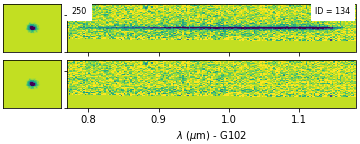

In [36]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

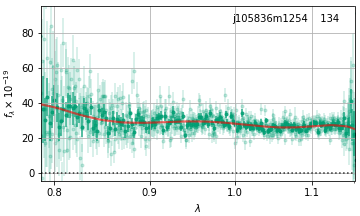

In [37]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


In [ ]:
for id_i in source_ids:
    fitting.run_all_parallel(id_i)

Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 298
Run 427
Run 487
Run 487
Run 487
Run 499
Run 467
Run 467
Run 499
Run 476
Run 499
Run 487
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 32
Run 49
Run 72
Run 108
Run 120
Run 182
Run 194
Run 210
Run 299
Run 402
Run 406
Run 440
Run 481
Run 488
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run 134
Run

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [39]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j105836m1254_00134.log_par
j105836m1254_00134.1D.png
j105836m1254_00134.1D.fits
j105836m1254_00134.stack.png
j105836m1254_00134.beams.fits
j105836m1254_00134.line.png
j105836m1254_00134.stack.fits
j105836m1254_00134.full.fits
j105836m1254_00134.full.png


In [40]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j105836m1254_00134.1D.fits


Filename: j105836m1254_00134.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  G102          1 BinTableHDU     36   179R x 6C   [D, D, D, D, D, D]   


j105836m1254_00134.beams.fits


Filename: j105836m1254_00134.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  REF           1 ImageHDU       244   (64, 64)   float32   
  2  SEG           1 ImageHDU       235   (64, 64)   int32   
  3  SCI           2 ImageHDU       243   (271, 64)   float32   
  4  ERR           2 ImageHDU       234   (271, 64)   float32   
  5  DQ            2 ImageHDU       234   (271, 64)   int16   
  6  CONTAM        2 ImageHDU       234   (271, 64)   float32   
  7  REF           1 ImageHDU       244   (64, 64)   float32   
  8  SEG           1 ImageHDU       235   (64, 64)   int32   
  9  SCI           2 ImageHDU       243   (271

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [41]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

True

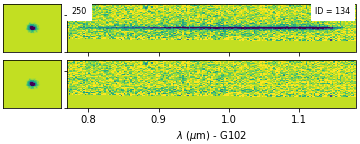

In [42]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

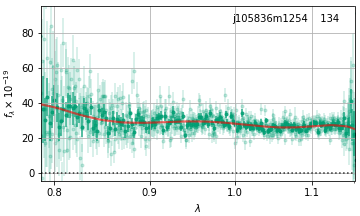

In [43]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 134


(134, 1, 14.164098978042603)

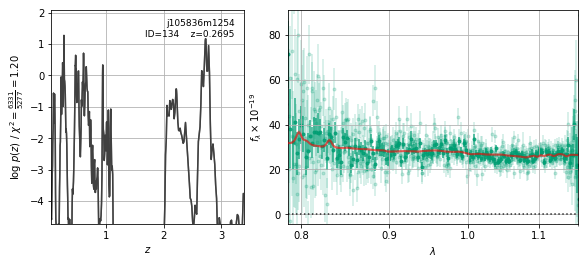

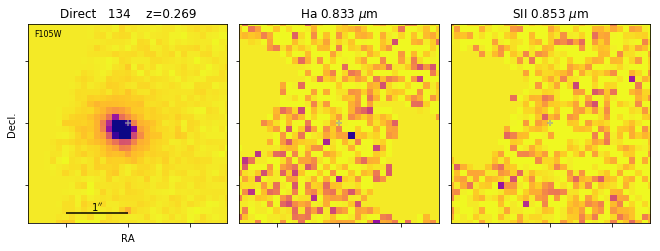

In [44]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).